Importation Torch

In [1]:
import torch
print("Version PyTorch :", torch.__version__)
print("Version CUDA utilisée par PyTorch :", torch.version.cuda)

print(torch.cuda.is_available())
print(torch.backends.cudnn.version())

Version PyTorch : 2.1.2
Version CUDA utilisée par PyTorch : 11.8
True
8700


### Test official Mamba Layer from mamba-ssm 
https://github.com/state-spaces/mamba

In [2]:
##########################################
############ TEST MAMBA LAYER  ###########
##########################################

import torch
from mamba_ssm import Mamba

batch, length, dim = 2, 64, 16
x = torch.randn(batch, length, dim).to("cuda")
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=16,  # SSM state expansion factor
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to("cuda")
y = model(x)
assert y.shape == x.shape
print("input", x.shape)
print("output", y.shape)

input torch.Size([2, 64, 16])
output torch.Size([2, 64, 16])


### Implementation Mamba Block

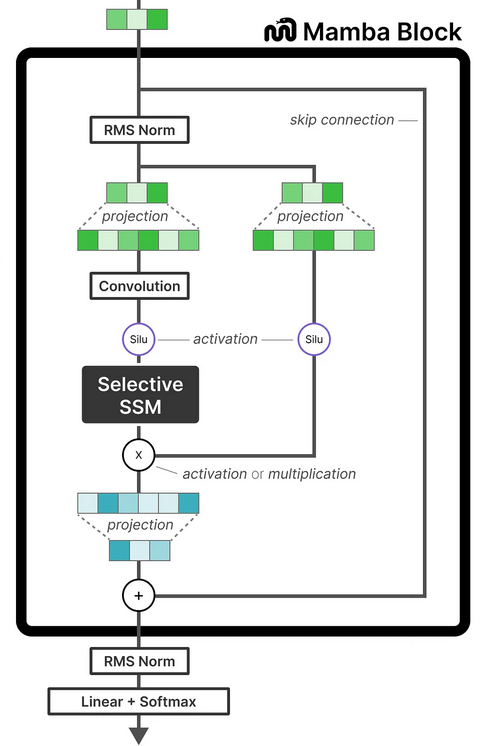

avec parcours des patchs de l'images dans les direct H+, H-, W+ et W-

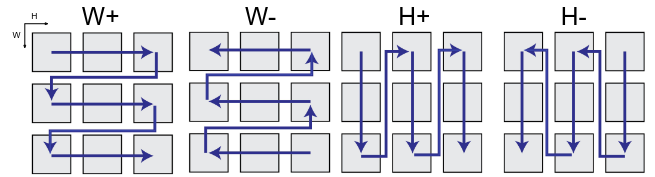

In [3]:
# Copyright (c) OpenMMLab. All rights reserved.
from typing import Sequence

import numpy as np
import torch
import torch.nn as nn
from mmcv.cnn.bricks.transformer import FFN, PatchEmbed
from mmengine.model import BaseModule, ModuleList
from mmengine.model.weight_init import trunc_normal_

from mmpretrain.registry import MODELS
from mmpretrain.models.utils import (MultiheadAttention, SwiGLUFFNFused, build_norm_layer,
                     resize_pos_embed, to_2tuple)
from mmpretrain.models.backbones.base_backbone import BaseBackbone
from mamba_ssm import Mamba
from torch import Tensor
from typing import Optional
from mamba_ssm.ops.triton.layernorm import RMSNorm, layer_norm_fn, rms_norm_fn
from functools import partial
#from .ssm2d import Block2D,Mamba2D,SplitHead2D
from einops import rearrange
# from .mamband import MambaND
from mmpretrain.models.utils.embed import PatchMerging
from prettytable import PrettyTable

Block2D=SplitHead2D=nn.Identity # TODO: Clan implementation and release
MambaND = nn.Identity

from mmcv.cnn.bricks.drop import build_dropout
torch.set_printoptions(precision=4)

class Block(nn.Module):
    def __init__(
        self, dim, mixer_cls, norm_cls=nn.LayerNorm, fused_add_norm=False, residual_in_fp32=False,reverse=False,
        transpose=False,split_head=False,
        drop_path_rate=0.0,drop_rate=0.0,use_mlp=False,downsample=False,
    ):
        """
        Simple block wrapping a mixer class with LayerNorm/RMSNorm and residual connection"

        This Block has a slightly different structure compared to a regular
        prenorm Transformer block.
        The standard block is: LN -> MHA/MLP -> Add.
        [Ref: https://arxiv.org/abs/2002.04745]
        Here we have: Add -> LN -> Mixer, returning both
        the hidden_states (output of the mixer) and the residual.
        This is purely for performance reasons, as we can fuse add and LayerNorm.
        The residual needs to be provided (except for the very first block).
        """
        super().__init__()
        self.residual_in_fp32 = residual_in_fp32
        self.fused_add_norm = fused_add_norm
        self.mixer = mixer_cls(dim)
        self.norm = norm_cls(dim)
        self.split_head = split_head
        self.reverse = reverse
        self.transpose = transpose
        self.drop_path = build_dropout(
            dict(type='DropPath', drop_prob=drop_path_rate)
        )
        self.dropout = build_dropout(
            dict(type='Dropout', drop_prob=drop_rate)
        )
        self.downsample = downsample
        if downsample:
            self.down_sample_layer = PatchMerging(
                dim,dim if self.split_head else dim,
            )
        if use_mlp:
            self.ffn = SwiGLUFFNFused(
                    embed_dims=dim,
                    feedforward_channels=int(dim*4),
                    layer_scale_init_value=0.0)
            self.ln2 = build_norm_layer(dict(type='LN'), dim)
        else:
            self.ffn = None
        if self.fused_add_norm:
            assert RMSNorm is not None, "RMSNorm import fails"
            assert isinstance(
                self.norm, (nn.LayerNorm, RMSNorm)
            ), "Only LayerNorm and RMSNorm are supported for fused_add_norm"

    def forward(
        self, hidden_states: Tensor, residual: Optional[Tensor] = None, inference_params=None,skip=True,**kwargs
    ):
        r"""Pass the input through the encoder layer.

        Args:
            hidden_states: the sequence to the encoder layer (required).
            residual: hidden_states = Mixer(LN(residual))
        """
        
        # print("Input Tensor :", hidden_states)
        # print("shape : ", hidden_states.shape)
        
        h = w = 0

        # if not self.transpose and self.reverse:
        #     print("normal")

        if self.transpose:
            l = hidden_states.shape[1]
            h = w = int(np.sqrt(l))
            # assert h * w == l
            hidden_states = rearrange(hidden_states,'n (h w) c -> n (w h) c',h=h,w=w)
            #print("hidden_states transpose:", hidden_states)
            # print("transpose")
            if residual is not None:
                residual = rearrange(residual,'n (h w) c -> n (w h) c',h=h,w=w)
        if self.reverse:
            hidden_states = hidden_states.flip(1)
            #print("hidden_states reverse:", hidden_states)
            # print("reverse")
            if residual is not None:
                residual = residual.flip(1)
        if not self.fused_add_norm:
            hidden_states = self.norm(hidden_states)
            # residual = (hidden_states + residual) if residual is not None else hidden_states
            # hidden_states = self.norm(residual.to(dtype=self.norm.weight.dtype))
            # if self.residual_in_fp32:
            #     residual = residual.to(torch.float32)
            if self.split_head:
                l = hidden_states.shape[1]
                h = w = int(np.sqrt(l))
                hidden_states = SplitHead2D.apply(hidden_states,4,h,w)
            if skip:
                hidden_states = hidden_states + self.drop_path(self.mixer(hidden_states, inference_params=inference_params,**(kwargs if isinstance(self.mixer,MambaND) else {})))
                # print("passage mamba")
            else:
                hidden_states = self.drop_path(self.dropout(self.mixer(hidden_states, inference_params=inference_params)))
            if self.split_head:
                hidden_states = SplitHead2D.apply(hidden_states,4,h,w)
        else:
            fused_add_norm_fn = rms_norm_fn if isinstance(self.norm, RMSNorm) else layer_norm_fn
            hidden_states, residual = fused_add_norm_fn(
                hidden_states,
                self.norm.weight,
                self.norm.bias,
                residual=residual,
                prenorm=True,
                residual_in_fp32=self.residual_in_fp32,
                eps=self.norm.eps,
            )
            hidden_states = self.drop_path(self.mixer(hidden_states, inference_params=inference_params,**kwargs))
        if self.ffn is not None:
            hidden_states = self.ffn(self.ln2(hidden_states),identity=hidden_states)
        if self.reverse:
            hidden_states = hidden_states.flip(1)
            if residual is not None:
                residual = residual.flip(1)
        if self.transpose:
            hidden_states = rearrange(hidden_states,'n (w h) c -> n (h w) c',h=h,w=w)
            #print("Rearrange parcours 1")
            if residual is not None:
                residual = rearrange(residual,'n (w h) c -> n (h w) c',h=h,w=w)
        if self.downsample:
            if 'h' in kwargs:
                h,w = kwargs['h'],kwargs['w']
            hidden_states,(h,w) = self.down_sample_layer(
                hidden_states,(h,w)
            )
            assert residual is None
            residual = (h,w)

        # print(f"Output Tensor : {hidden_states}")
        # print("shape : ", hidden_states.shape)
        return hidden_states, residual

    def allocate_inference_cache(self, batch_size, max_seqlen, dtype=None, **kwargs):
        return self.mixer.allocate_inference_cache(batch_size, max_seqlen, dtype=dtype, **kwargs)

import torch.nn.functional as F
from mamba_ssm.ops.selective_scan_interface import selective_scan_ref
def  causal_conv1d_fn_ref(x, weight, bias=None,seq_idx=None, activation=None):
    """
    x: (batch, dim, seqlen)
    weight: (dim, width)
    bias: (dim,)
    activation: either None or "silu" or "swish"

    out: (batch, dim, seqlen)
    """
    seqlen=x.shape[-1]
    dim,width = weight.shape
    assert activation =='silu'
    x = F.conv1d(x, weight.unsqueeze(1), bias, padding=width.item() - 1, groups=dim.item())[..., :seqlen]
    return F.silu(x)

def mamba_inner_ref(
    xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
    out_proj_weight, out_proj_bias,
    A, B=None, C=None, D=None, delta_bias=None, B_proj_bias=None,
    C_proj_bias=None, delta_softplus=True
):
    L = xz.shape[-1]
    delta_rank = delta_proj_weight.shape[1]
    d_state = A.shape[-1] * (1 if not A.is_complex() else 2)
    x, z = xz.chunk(2, dim=1)
    x = causal_conv1d_fn_ref(x, rearrange(conv1d_weight, "d 1 w -> d w"), bias=conv1d_bias,seq_idx=None, activation="silu")
    # We're being very careful here about the layout, to avoid extra transposes.
    # We want delta to have d as the slowest moving dimension
    # and L as the fastest moving dimension, since those are what the ssm_scan kernel expects.
    x_dbl = F.linear(rearrange(x, 'b d l -> (b l) d'), x_proj_weight)  # (bl d)
    delta = delta_proj_weight @ x_dbl[:, :delta_rank].t()
    delta = rearrange(delta, "d (b l) -> b d l", l=L)
    if B is None:  # variable B
        B = x_dbl[:, delta_rank:delta_rank + d_state]  # (bl d)
        if B_proj_bias is not None:
            B = B + B_proj_bias.to(dtype=B.dtype)
        if not A.is_complex():
            B = rearrange(B, "(b l) dstate -> b dstate l", l=L).contiguous()
        else:
            B = rearrange(B, "(b l) (dstate two) -> b dstate (l two)", l=L, two=2).contiguous()
    if C is None:  # variable B
        C = x_dbl[:, -d_state:]  # (bl d)
        if C_proj_bias is not None:
            C = C + C_proj_bias.to(dtype=C.dtype)
        if not A.is_complex():
            C = rearrange(C, "(b l) dstate -> b dstate l", l=L).contiguous()
        else:
            C = rearrange(C, "(b l) (dstate two) -> b dstate (l two)", l=L, two=2).contiguous()
    y = selective_scan_ref(x, delta, A, B, C, D, z=z, delta_bias=delta_bias, delta_softplus=True)
    return F.linear(rearrange(y, "b d l -> b l d"), out_proj_weight, out_proj_bias)

# for FLOPS calc only
class Mamba_Ref(Mamba):

    def forward(self, hidden_states, inference_params=None):
        """
        hidden_states: (B, L, D)
        Returns: same shape as hidden_states
        """
        batch, seqlen, dim = hidden_states.shape

        conv_state, ssm_state = None, None
        if inference_params is not None:
            conv_state, ssm_state = self._get_states_from_cache(inference_params, batch)
            if inference_params.seqlen_offset > 0:
                # The states are updated inplace
                out, _, _ = self.step(hidden_states, conv_state, ssm_state)
                return out

        # We do matmul and transpose BLH -> HBL at the same time
        xz = rearrange(
            self.in_proj.weight @ rearrange(hidden_states, "b l d -> d (b l)"),
            "d (b l) -> b d l",
            l=seqlen,
        )
        if self.in_proj.bias is not None:
            xz = xz + rearrange(self.in_proj.bias.to(dtype=xz.dtype), "d -> d 1")

        A = -torch.exp(self.A_log.float())  # (d_inner, d_state)
        # In the backward pass we write dx and dz next to each other to avoid torch.cat
        if self.use_fast_path and inference_params is None:  # Doesn't support outputting the states
            out = mamba_inner_ref(
                xz,
                self.conv1d.weight,
                self.conv1d.bias,
                self.x_proj.weight,
                self.dt_proj.weight,
                self.out_proj.weight,
                self.out_proj.bias,
                A,
                None,  # input-dependent B
                None,  # input-dependent C
                self.D.float(),
                delta_bias=self.dt_proj.bias.float(),
                delta_softplus=True,
            )
        else:
            x, z = xz.chunk(2, dim=1)
            # Compute short convolution
            if conv_state is not None:
                # If we just take x[:, :, -self.d_conv :], it will error if seqlen < self.d_conv
                # Instead F.pad will pad with zeros if seqlen < self.d_conv, and truncate otherwise.
                conv_state.copy_(F.pad(x, (self.d_conv - x.shape[-1], 0)))  # Update state (B D W)
            if causal_conv1d_fn is None:
                x = self.act(self.conv1d(x)[..., :seqlen])
            else:
                assert self.activation in ["silu", "swish"]
                x = causal_conv1d_fn(
                    x=x,
                    weight=rearrange(self.conv1d.weight, "d 1 w -> d w"),
                    bias=self.conv1d.bias,
                    activation=self.activation,
                )

            # We're careful here about the layout, to avoid extra transposes.
            # We want dt to have d as the slowest moving dimension
            # and L as the fastest moving dimension, since those are what the ssm_scan kernel expects.
            x_dbl = self.x_proj(rearrange(x, "b d l -> (b l) d"))  # (bl d)
            dt, B, C = torch.split(x_dbl, [self.dt_rank, self.d_state, self.d_state], dim=-1)
            dt = self.dt_proj.weight @ dt.t()
            dt = rearrange(dt, "d (b l) -> b d l", l=seqlen)
            B = rearrange(B, "(b l) dstate -> b dstate l", l=seqlen).contiguous()
            C = rearrange(C, "(b l) dstate -> b dstate l", l=seqlen).contiguous()
            assert self.activation in ["silu", "swish"]
            y = selective_scan_ref(
                x,
                dt,
                A,
                B,
                C,
                self.D.float(),
                z=z,
                delta_bias=self.dt_proj.bias.float(),
                delta_softplus=True,
                return_last_state=ssm_state is not None,
            )
            if ssm_state is not None:
                y, last_state = y
                ssm_state.copy_(last_state)
            y = rearrange(y, "b d l -> b l d")
            out = self.out_proj(y)
        return out


def create_block(
    d_model,
    ssm_cfg=None,
    norm_epsilon=1e-5,
    rms_norm=False,
    residual_in_fp32=False,
    fused_add_norm=False,
    layer_idx=None,
    device=None,
    dtype=None,
    reverse=None,
    is_2d=False,
    drop_rate=0.1,
    drop_path_rate=0.1,
    use_mlp=False,
    transpose=False,
    split_head=False,
    use_nd=False,
    downsample=False,
    use_ref=False,
    n_dim=2,
):
    if ssm_cfg is None:
        ssm_cfg = {}
    factory_kwargs = {"device": device, "dtype": dtype}
    
    if use_nd: 
        #ssm_cfg['d_state'] *= 4
        transpose = False
        reverse = False
        mixer_cls = partial(MambaND , layer_idx=layer_idx, n_dim=n_dim,**ssm_cfg, **factory_kwargs)
    elif use_ref: # use_ref qui est utilisé pour classification 2D
        mixer_cls = partial(Mamba_Ref, layer_idx=layer_idx, **ssm_cfg, **factory_kwargs)
    else:
        mixer_cls = partial(Mamba2D if is_2d else Mamba, layer_idx=layer_idx, **ssm_cfg, **factory_kwargs)
    norm_cls = partial(
        nn.LayerNorm if not rms_norm else RMSNorm, eps=norm_epsilon, **factory_kwargs
    )
    if is_2d:
        block = Block2D(
            d_model,
            mixer_cls,
            norm_cls=norm_cls,
            fused_add_norm=fused_add_norm,
            residual_in_fp32=residual_in_fp32,
            reverse=reverse,
            drop_rate=drop_rate,
            transpose=transpose,
            drop_path_rate=drop_path_rate,
        )
    else:
        # création du block Mamba
        block = Block(
            d_model,
            mixer_cls,
            norm_cls=norm_cls,
            fused_add_norm=fused_add_norm,
            residual_in_fp32=residual_in_fp32,
            reverse=reverse,
            transpose=transpose,
            drop_rate=drop_rate,
            use_mlp=use_mlp,
            drop_path_rate=drop_path_rate,
            split_head=split_head,
            downsample=downsample,
        )
    block.layer_idx = layer_idx
    return block 
    


### Mamba Config Layer with mmcv 
- config Mamba Layer
- pos embedding
- count parameters

In [4]:
@MODELS.register_module()
class Mamba2DModel(BaseBackbone):
    """Vision Transformer.

    A PyTorch implement of : `An Image is Worth 16x16 Words: Transformers
    for Image Recognition at Scale <https://arxiv.org/abs/2010.11929>`_

    Args:
        arch (str | dict): Vision Transformer architecture. If use string,
            choose from 'small', 'base', 'large', 'deit-tiny', 'deit-small'
            and 'deit-base'. If use dict, it should have below keys:

            - **embed_dims** (int): The dimensions of embedding.
            - **num_layers** (int): The number of transformer encoder layers.
            - **num_heads** (int): The number of heads in attention modules.
            - **feedforward_channels** (int): The hidden dimensions in
              feedforward modules.

            Defaults to 'base'.
        img_size (int | tuple): The expected input image shape. Because we
            support dynamic input shape, just set the argument to the most
            common input image shape. Defaults to 224.
        patch_size (int | tuple): The patch size in patch embedding.
            Defaults to 16.
        in_channels (int): The num of input channels. Defaults to 3.
        out_indices (Sequence | int): Output from which stages.
            Defaults to -1, means the last stage.
        drop_rate (float): Probability of an element to be zeroed.
            Defaults to 0.
        drop_path_rate (float): stochastic depth rate. Defaults to 0.
        qkv_bias (bool): Whether to add bias for qkv in attention modules.
            Defaults to True.
        norm_cfg (dict): Config dict for normalization layer.
            Defaults to ``dict(type='LN')``.
        final_norm (bool): Whether to add a additional layer to normalize
            final feature map. Defaults to True.
        out_type (str): The type of output features. Please choose from

            - ``"cls_token"``: The class token tensor with shape (B, C).
            - ``"featmap"``: The feature map tensor from the patch tokens
              with shape (B, C, H, W).
            - ``"avg_featmap"``: The global averaged feature map tensor
              with shape (B, C).
            - ``"raw"``: The raw feature tensor includes patch tokens and
              class tokens with shape (B, L, C).

            Defaults to ``"cls_token"``.
        with_cls_token (bool): Whether concatenating class token into image
            tokens as transformer input. Defaults to True.
        frozen_stages (int): Stages to be frozen (stop grad and set eval mode).
            -1 means not freezing any parameters. Defaults to -1.
        interpolate_mode (str): Select the interpolate mode for position
            embeding vector resize. Defaults to "bicubic".
        layer_scale_init_value (float or torch.Tensor): Init value of layer
            scale. Defaults to 0.
        patch_cfg (dict): Configs of patch embeding. Defaults to an empty dict.
        layer_cfgs (Sequence | dict): Configs of each transformer layer in
            encoder. Defaults to an empty dict.
        init_cfg (dict, optional): Initialization config dict.
            Defaults to None.
    """
    arch_zoo = {
        **dict.fromkeys(
            ['small'], {
                'embed_dims': 256,
                'num_layers': 8,
                'num_heads': 6,
                'feedforward_channels': 256 * 4
            }),
        **dict.fromkeys(
            ['base'], {
                'embed_dims': 768,
                'num_layers': 12,
                'num_heads': 12,
                'feedforward_channels': 768 * 4
            }),
    }
    num_extra_tokens = 1  # class token
    OUT_TYPES = {'raw', 'cls_token', 'featmap', 'avg_featmap'}

    def __init__(self,
                 arch='small',
                 img_size=32,
                 patch_size=8,
                 in_channels=3,
                 out_indices=-1,
                 drop_rate=0.,
                 drop_path_rate=0.,
                 qkv_bias=True,
                 norm_cfg=dict(type='LN', eps=1e-6),
                 norm_cfg_2=dict(type='LN', eps=1e-6),
                 final_norm=True,
                 out_type='cls_token',
                 with_cls_token=True,
                 frozen_stages=-1,
                 interpolate_mode='bicubic',
                 layer_scale_init_value=0.,
                 patch_cfg=dict(),
                 layer_cfgs=dict(),
                 pre_norm=False,
                 init_cfg=None,
                 is_2d=True,
                 use_v2=False,
                 force_a2=False,
                 embed_dims=None,
                 has_transpose=True,
                 fused_add_norm=True,
                 use_mlp=False,
                 split_head=False,
                 use_nd=False,
                 downsample=None,
                 expand=None,
                 constant_dim=False,
                 has_reverse=True,
                 update_interval=None,
                 duplicate=None,
                 n_dim=2,
                 num_layers=None,
                 use_ref=False,
                 d_state=16):
        super(Mamba2DModel, self).__init__(init_cfg)

        if isinstance(arch, str):
            arch = arch.lower()
            assert arch in set(self.arch_zoo), \
                f'Arch {arch} is not in default archs {set(self.arch_zoo)}'
            self.arch_settings = self.arch_zoo[arch]
        else:
            essential_keys = {
                'embed_dims', 'num_layers', 'num_heads', 'feedforward_channels'
            }
            assert isinstance(arch, dict) and essential_keys <= set(arch), \
                f'Custom arch needs a dict with keys {essential_keys}'
            self.arch_settings = arch
        self.update_interval = update_interval
        self.embed_dims = self.arch_settings['embed_dims'] 
        if embed_dims is not None:
            self.embed_dims = embed_dims
        if num_layers is None:
            num_layers = self.arch_settings['num_layers']
        self.num_layers = num_layers * (2 if not use_mlp else 1)
        self.downsample = self.arch_settings.get('downsample',downsample)
        if self.downsample is None:
            self.downsample = []
        #self.downsample = list((x+1)*2-1 for x in self.downsample)
        self.img_size = to_2tuple(img_size)
        self.is_2d = is_2d
        self.use_nd=use_nd

        # Set patch embedding
        _patch_cfg = dict(
            in_channels=in_channels,
            input_size=img_size,
            embed_dims=self.embed_dims,
            conv_type='Conv2d',
            kernel_size=patch_size,
            stride=patch_size,
            bias=not pre_norm,  # disable bias if pre_norm is used(e.g., CLIP)
        )
        _patch_cfg.update(patch_cfg)
        self.patch_embed = PatchEmbed(**_patch_cfg)
        self.patch_resolution = self.patch_embed.init_out_size
        num_patches = self.patch_resolution[0] * self.patch_resolution[1]

        # Set out type
        if out_type not in self.OUT_TYPES:
            raise ValueError(f'Unsupported `out_type` {out_type}, please '
                             f'choose from {self.OUT_TYPES}')
        self.out_type = out_type

        # Set cls token
        self.with_cls_token = with_cls_token
        if with_cls_token:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, self.embed_dims))
        elif out_type != 'cls_token':
            self.cls_token = None
            self.num_extra_tokens = 0
        else:
            raise ValueError(
                'with_cls_token must be True when `out_type="cls_token"`.')

        # Set position embedding
        self.interpolate_mode = interpolate_mode
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + self.num_extra_tokens,
                        self.embed_dims))
        self._register_load_state_dict_pre_hook(self._prepare_pos_embed)

        self.drop_after_pos = nn.Dropout(p=drop_rate)

        if isinstance(out_indices, int):
            out_indices = [out_indices]
        assert isinstance(out_indices, Sequence), \
            f'"out_indices" must by a sequence or int, ' \
            f'get {type(out_indices)} instead.'
        for i, index in enumerate(out_indices):
            if index < 0:
                out_indices[i] = self.num_layers + index
            assert 0 <= out_indices[i] <= self.num_layers, \
                f'Invalid out_indices {index}'
        self.out_indices = out_indices

        # stochastic depth decay rule
        dpr = np.linspace(0, drop_path_rate, self.num_layers)

        self.layers = ModuleList()
        if isinstance(layer_cfgs, dict):
            layer_cfgs = [layer_cfgs] * self.num_layers
        ssm_cfg={"d_state":d_state}
        if expand is not None:
            ssm_cfg['expand'] = expand
        if duplicate:
            ssm_cfg['duplicate'] = duplicate
        if use_v2 and is_2d:
            ssm_cfg['use_v2'] = use_v2
        if force_a2:
            ssm_cfg['force_a2'] = force_a2
        dim = self.embed_dims
        for i in range(self.num_layers):
            #self.layers.append(TransformerEncoderLayer(**_layer_cfg))
            do_downsample = i in self.downsample
            self.layers.append(
                create_block(
                d_model=dim,
                ssm_cfg=ssm_cfg,
                fused_add_norm=fused_add_norm,
                residual_in_fp32=True,
                drop_rate=drop_rate,
                drop_path_rate=dpr[i],
                reverse= (not split_head ) and (i % 2) > 0 and has_reverse,
                transpose = (not split_head ) and has_transpose and ( i % 4) >=2,
                use_mlp=use_mlp,
                is_2d=is_2d,
                rms_norm=False,
                split_head=split_head,
                use_nd=use_nd,
                downsample=do_downsample,
                n_dim=n_dim,
                use_ref=use_ref
                )
            )
            if do_downsample and not constant_dim:
                dim *= 2
                
        self.frozen_stages = frozen_stages
        if pre_norm:
            self.pre_norm = build_norm_layer(norm_cfg, dim)
        else:
            self.pre_norm = nn.Identity()

        self.final_norm = final_norm
        if final_norm:
            self.ln1 = build_norm_layer(norm_cfg, dim)
        if self.out_type == 'avg_featmap':
            self.ln2 = build_norm_layer(norm_cfg_2, dim)

        # freeze stages only when self.frozen_stages > 0
        if self.frozen_stages > 0:
            self._freeze_stages()
        self.count_parameters()
    @property
    def norm1(self):
        return self.ln1

    @property
    def norm2(self):
        return self.ln2

    def init_weights(self):
        super(Mamba2DModel, self).init_weights()

        if not (isinstance(self.init_cfg, dict)
                and self.init_cfg['type'] == 'Pretrained'):
            if self.pos_embed is not None:
                trunc_normal_(self.pos_embed, std=0.02)
        else:
            ckpt = self.init_cfg['checkpoint']
            ckpt = torch.load(ckpt,map_location='cpu')['state_dict']
            ckpt = {k.replace('backbone.','',1):v for k,v in ckpt.items() if  k.startswith('backbone.') }
            curr_dict = self.state_dict()
            for k,v in ckpt.items():
                if k in curr_dict and (v_new:=curr_dict[k]).shape != v.shape:
                    if 'patch_embed' in k:
                        # n c H W
                        v_resized = torch.nn.functional.interpolate(v,v_new.shape[-2:])
                        assert v_resized.shape == v_new.shape
                        ckpt[k] = v_resized
                    elif 'pos_embed' in k:
                        b,old_len,dim = v.shape
                        old_d = int(np.sqrt(old_len))
                        new_len = v_new.shape[1]
                        new_d = int(np.sqrt(new_len))
                        v_resized = v.reshape(b,old_d,old_d,dim).permute(0,3,1,2)
                        v_resized = torch.nn.functional.interpolate(v_resized,(new_d,new_d)).flatten(2).permute(0,2,1)
                        assert v_resized.shape == v_new.shape
                        ckpt[k] = v_resized
                    else:
                        print(k,v_new.shape,v.shape)
            res = self.load_state_dict(ckpt,strict=False)
            print('----------init-------------------')
            print(res)

    def _prepare_pos_embed(self, state_dict, prefix, *args, **kwargs):
        name = prefix + 'pos_embed'
        if name not in state_dict.keys():
            return

        ckpt_pos_embed_shape = state_dict[name].shape
        if (not self.with_cls_token
                and ckpt_pos_embed_shape[1] == self.pos_embed.shape[1] + 1):
            # Remove cls token from state dict if it's not used.
            state_dict[name] = state_dict[name][:, 1:]
            ckpt_pos_embed_shape = state_dict[name].shape

        if self.pos_embed.shape != ckpt_pos_embed_shape:
            from mmengine.logging import MMLogger
            logger = MMLogger.get_current_instance()
            logger.info(
                f'Resize the pos_embed shape from {ckpt_pos_embed_shape} '
                f'to {self.pos_embed.shape}.')

            ckpt_pos_embed_shape = to_2tuple(
                int(np.sqrt(ckpt_pos_embed_shape[1] - self.num_extra_tokens)))
            pos_embed_shape = self.patch_embed.init_out_size

            state_dict[name] = resize_pos_embed(state_dict[name],
                                                ckpt_pos_embed_shape,
                                                pos_embed_shape,
                                                self.interpolate_mode,
                                                self.num_extra_tokens)

    @staticmethod
    def resize_pos_embed(*args, **kwargs):
        """Interface for backward-compatibility."""
        return resize_pos_embed(*args, **kwargs)

    def _freeze_stages(self):
        # freeze position embedding
        if self.pos_embed is not None:
            self.pos_embed.requires_grad = False
        # set dropout to eval modelMambaBlock.png

        self.drop_after_pos.eval()
        # freeze patch embedding
        self.patch_embed.eval()
        for param in self.patch_embed.parameters():
            param.requires_grad = False
        # freeze pre-norm
        for param in self.pre_norm.parameters():
            param.requires_grad = False
        # freeze cls_token
        if self.cls_token is not None:
            self.cls_token.requires_grad = False
        # freeze layers
        for i in range(1, self.frozen_stages + 1):
            m = self.layers[i - 1]
            m.eval()
            for param in m.parameters():
                param.requires_grad = False
        # freeze the last layer norm
        if self.frozen_stages == len(self.layers):
            if self.final_norm:
                self.ln1.eval()
                for param in self.ln1.parameters():
                    param.requires_grad = False

            if self.out_type == 'avg_featmap':
                self.ln2.eval()
                for param in self.ln2.parameters():
                    param.requires_grad = False

    def forward(self, x):
        B = x.shape[0]
        x, patch_resolution = self.patch_embed(x)
        #print("patch")
        x = x + resize_pos_embed(
            self.pos_embed,
            self.patch_resolution,
            patch_resolution,
            mode=self.interpolate_mode,
            num_extra_tokens=self.num_extra_tokens)[:,self.num_extra_tokens:]
        if self.is_2d:
            assert self.cls_token is  None
            x = rearrange(x,'n (h w) c-> n c h w',h=patch_resolution[0],w=patch_resolution[1])
        if self.cls_token is not None:
            # stole cls_tokens impl from Phil Wang, thanks
            cls_token = self.cls_token.expand(B, -1, -1)
            x = torch.cat((x,cls_token), dim=1) # append last
        x = self.drop_after_pos(x)

        x = self.pre_norm(x)
        h = patch_resolution[0]
        w = patch_resolution[1]
        outs = []
        residual = None
        if self.update_interval:
            raw_x = x
            for i,layer in enumerate(self.layers):
                z = i // 2
                x_l,residual = layer(raw_x,residual,skip=False,h=h,w=w)
                if layer.downsample:
                        h,w = residual
                        residual = None
                x = x + x_l
                if (i+1) % self.update_interval == 0 or i == len(self.layers) - 1:
                    raw_x = x
                #x = raw_x
                if i == len(self.layers) - 1:
                    x = (x + residual) if residual is not None else x
                if i == len(self.layers) - 1 and self.final_norm:
                    x = self.ln1(x)

                if i in self.out_indices:
                    outs.append(self._format_output(x, patch_resolution))
        else:
            for i, layer in enumerate(self.layers):
                if self.use_nd:
                    x,residual = layer(x,residual,h=h,w=w)
                    if layer.downsample:
                        h,w = residual
                        residual = None
                else:
                    x,residual = layer(x,residual,h=h,w=w)
                    if layer.downsample:
                        h,w = residual
                        residual = None

                if i == len(self.layers) - 1:
                    x = (x + residual) if residual is not None else x
                if i == len(self.layers) - 1 and self.final_norm:
                    x = self.ln1(x)

                if i in self.out_indices:
                    outs.append(self._format_output(x, patch_resolution))

        return tuple(outs)

    def count_parameters(self,model=None):
        if model is None:
            model = self
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in model.named_parameters():
            if not parameter.requires_grad:
                continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params += params
        self.total_parms = total_params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        return total_params
    
    def _format_output(self, x, hw):
        if self.out_type == 'raw':
            return x
        if self.out_type == 'cls_token':
            return x[:, -1]
        if not self.is_2d:
            patch_token = x[:, self.num_extra_tokens:]
        else:
            patch_token = x
        if self.out_type == 'featmap':
            B = x.size(0)
            # (B, N, C) -> (B, H, W, C) -> (B, C, H, W)
            if self.is_2d:
                return patch_token
            else:
                return patch_token.reshape(B, *hw, -1).permute(0, 3, 1, 2)
        if self.out_type == 'avg_featmap':
            if self.is_2d:
                return self.ln2(patch_token.flatten(2).mean(dim=-1))
            else:
                return self.ln2(patch_token.mean(dim=1))

    def get_layer_depth(self, param_name: str, prefix: str = ''):
        """Get the layer-wise depth of a parameter.

        Args:
            param_name (str): The name of the parameter.
            prefix (str): The prefix for the parameter.
                Defaults to an empty string.

        Returns:
            Tuple[int, int]: The layer-wise depth and the num of layers.

        Note:
            The first depth is the stem module (``layer_depth=0``), and the
            last depth is the subsequent module (``layer_depth=num_layers-1``)
        """
        num_layers = self.num_layers + 2

        if not param_name.startswith(prefix):
            # For subsequent module like head
            return num_layers - 1, num_layers

        param_name = param_name[len(prefix):]

        if param_name in ('cls_token', 'pos_embed'):
            layer_depth = 0
        elif param_name.startswith('patch_embed'):
            layer_depth = 0
        elif param_name.startswith('layers'):
            layer_id = int(param_name.split('.')[1])
            layer_depth = layer_id + 1
        else:
            layer_depth = num_layers - 1

        return layer_depth, num_layers


## TEST FOR CIFAR TRAINING

In [5]:
##  """""""""""""""""""""""      ##
##              CONFIG           ##   
##    """"""""""""""""""""""""   ##

In [6]:
import torch
import mmcv

print(f"PyTorch version: {torch.__version__}")
print(f"MMCV version: {mmcv.__version__}") # must be 2.1.0 or 2.2.0

PyTorch version: 2.1.2
MMCV version: 2.1.0


In [7]:
import torch
from mmengine.hooks import Hook
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from typing import Any, Dict, List, Optional, Sequence, Tuple

from mmengine.evaluator import BaseMetric
from mmengine.registry import METRICS

def train_step(self, data_batch, optim_wrapper):
    # Forward pass
    outputs = self(**data_batch)

    # Calculate loss
    loss_fn = torch.nn.CrossEntropyLoss()  # Change this to your loss function
    loss = loss_fn(outputs, data_batch['labels'])

    # Backward pass and optimize
    optim_wrapper.zero_grad()
    loss.backward()
    optim_wrapper.step()

    # Collect predictions and loss
    metrics = {
        'loss': loss,
        'preds': outputs.detach()  # Ensure predictions are detached from the computation graph
    }

    return metrics


def val_step(self, data_batch):
    # Forward pass
    outputs = self(**data_batch)

    # Calculate loss
    loss_fn = torch.nn.CrossEntropyLoss()  # Change this to your loss function
    loss = loss_fn(outputs, data_batch['labels'])

    # Collect other metrics if needed
    metrics = {
        'loss': loss,
        'preds': outputs
    }

    return metrics



# Ajout d'une metric pour le calcul de la loss de validation
@METRICS.register_module()
class LossValMetric(BaseMetric):
    """Loss evaluation metric."""
    default_prefix: Optional[str] = 'loss'

    def __init__(self, collect_device: str = 'cpu', prefix: Optional[str] = None) -> None:
        super().__init__(collect_device=collect_device, prefix=prefix)
        self.loss_fn = torch.nn.CrossEntropyLoss()  # loss function 

    def process(self, data_batch: Sequence[Tuple[Any, Dict]], data_samples: Sequence[Dict]) -> None:
        """Process one batch of data samples and data_samples. The processed
        results should be stored in ``self.results``, which will be used to
        compute the metrics when all batches have been processed.
        """
        outputs = [data_sample['pred_score'].to('cuda') for data_sample in data_samples]
        labels = [data_sample['gt_label'].to('cuda') for data_sample in data_samples]
   
        # Stack outputs and labels to form tensors
        outputs = torch.stack(outputs)
        labels = torch.cat(labels)

        # Calculate loss
        loss = self.loss_fn(outputs, labels).cpu().item()
        self.results.append({'loss': loss})

    def compute_metrics(self, results: List[Dict]) -> Dict:
        """Compute the metrics from processed results."""
        losses = [x['loss'] for x in results]
        avg_loss = sum(losses) / len(losses)
        return {'loss': avg_loss}



class MetricLoggerHook(Hook):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_top1_acc = []
        self.val_top1_acc = []
        self.batch_losses = []  # To store batch losses for averaging
        self.batch_top1_acc = []  # To store batch accuracies for averaging
        self.all_labels = []  # To store true labels for confusion matrix
        self.all_preds = []  # To store predicted labels for confusion matrix
        self.class_names = [
            "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" 
        ]

    def after_train_epoch(self, runner):
        if self.batch_losses:
            avg_loss = sum(self.batch_losses) / len(self.batch_losses)
            self.train_loss.append(avg_loss)
            self.batch_losses = []  # Reset batch losses for the next epoch
        else:
            self.train_loss.append(None)


        if self.batch_top1_acc:
            max_acc = max(self.batch_top1_acc)  # Get the maximum accuracy
            self.train_top1_acc.append(max_acc)
            self.batch_top1_acc = []  # Reset batch accuracies for the next epoch
        else:
            self.train_top1_acc.append(None)
    

    def after_val_epoch(self, runner, metrics=None):
        if metrics and 'accuracy/top1' in metrics:
            self.val_top1_acc.append(metrics['accuracy/top1'])
        else:
            self.val_top1_acc.append(None)

        if metrics and 'loss/loss' in metrics:
            self.val_loss.append(metrics['loss/loss'])
        else:
            self.val_loss.append(None)

        self.save_to_csv('metrics.csv')
            
        self.plot_metrics()  # Plot metrics after each validation epoch
        self.plot_confusion_matrix()  # Plot confusion matrix after each validation epoch
        self.all_labels = []  # Reset labels for the next epoch
        self.all_preds = []  # Reset predictions for the next epoch

    def after_train_iter(self, runner, batch_idx, data_batch=None, outputs=None):
        self.batch_losses.append(outputs['loss'].item())
        runner.message_hub.update_scalar('loss', outputs['loss'].item())
    
        # Forward pass to get predictions
        with torch.no_grad():
            preds = runner.model(**data_batch)
            preds = preds.argmax(dim=1)
    
        
        # Assuming labels are in data_batch['data_samples']
        labels = [sample.gt_label.item() for sample in data_batch['data_samples']]
        labels = torch.tensor(labels).to(preds.device)  # Ensure labels are on the same device as preds
        correct = preds.eq(labels).sum().item()
        accuracy = correct / len(labels)
        self.batch_top1_acc.append(accuracy)
        runner.message_hub.update_scalar('top1_acc', accuracy)

        
    
    def after_val_iter(self, runner, batch_idx, data_batch=None, outputs=None):
        true_labels = [sample.gt_label.item() for sample in data_batch['data_samples']]
        pred_labels = [output.pred_label.item() for output in outputs]

        self.all_labels.extend(true_labels)
        self.all_preds.extend(pred_labels)

    def plot_metrics(self):
        epochs = range(1, len(self.train_loss) + 1)

        plt.figure(figsize=(12, 5))

        # Courbe de perte d'entraînement
        plt.subplot(1, 2, 1)
        if len(self.train_loss) > 0:
            plt.plot(epochs, self.train_loss, label='Training loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.legend()

        # Courbe d'accuracy de validation
        plt.subplot(1, 2, 2)
        if len(self.val_top1_acc) > 0:
            plt.plot(epochs, self.val_top1_acc, label='Validation Top-1 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy over Epochs')
        plt.legend()

        plt.show()


    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.all_labels, self.all_preds, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        
        fig, ax = plt.subplots(figsize=(25, 25))  # Adjust the figure size as needed
        disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90, values_format='.1f')
        
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        
        # Ajuster la taille de la police
        plt.xticks(fontsize=10) 
        plt.yticks(fontsize=10)  
        
        plt.show()

    def save_to_csv(self, filename):
        epochs = range(1, len(self.train_loss) + 1)

        #print(f"epoch : {epochs}, train_loss : {self.train_loss}, val_acc : {self.val_top1_acc}")
        data = {
            'Epoch': epochs,
            'Training Loss': self.train_loss,
            'Validation Loss': self.val_loss,
            'Training Top-1 Accuracy': self.train_top1_acc,
            'Validation Top-1 Accuracy': self.val_top1_acc
        }
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)


Files already downloaded and verified
Files already downloaded and verified
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f4d1f6bb0d0>
Validation dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f4d1f6bb280>
Validation evaluator: [{'type': 'Accuracy', 'topk': (1, 5)}, {'type': 'LossValMetric'}]
07/23 14:51:18 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 77
    GPU 0: Quadro RTX 5000
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.4, V12.4.99
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 2.1.2
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture app

INFO:__main__:Starting training...


Sample batch inputs shape: torch.Size([64, 3, 32, 32])
Sample batch labels shape: torch.Size([1])
07/23 14:51:18 - mmengine - WARNING - Dataset CustomDataset has no metainfo. ``dataset_meta`` in visualizer will be None.
07/23 14:51:18 - mmengine - WARNING - Dataset CustomDataset has no metainfo. ``dataset_meta`` in evaluator, metric and visualizer will be None.
07/23 14:51:18 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/23 14:51:18 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/23 14:51:18 - mmengine - INFO - Checkpoints will be saved to /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment.
07/23 14:51:55 - mmengine - INFO - Epoch(train)  [1][100/782]  base_lr: 2.5424e-05 lr: 1.0630e-05  eta: 3:11:53  time: 0.3671  data_time: 0.0882  memory: 3611  grad_norm: 2.3

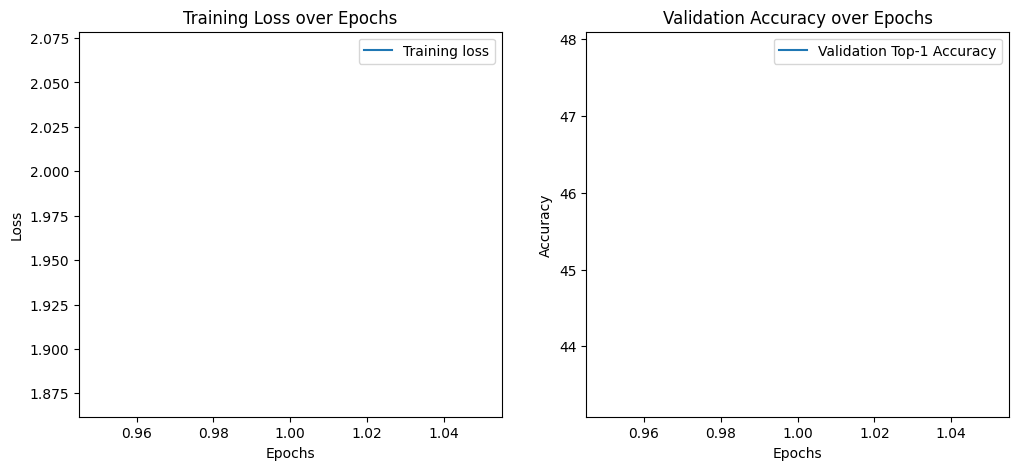

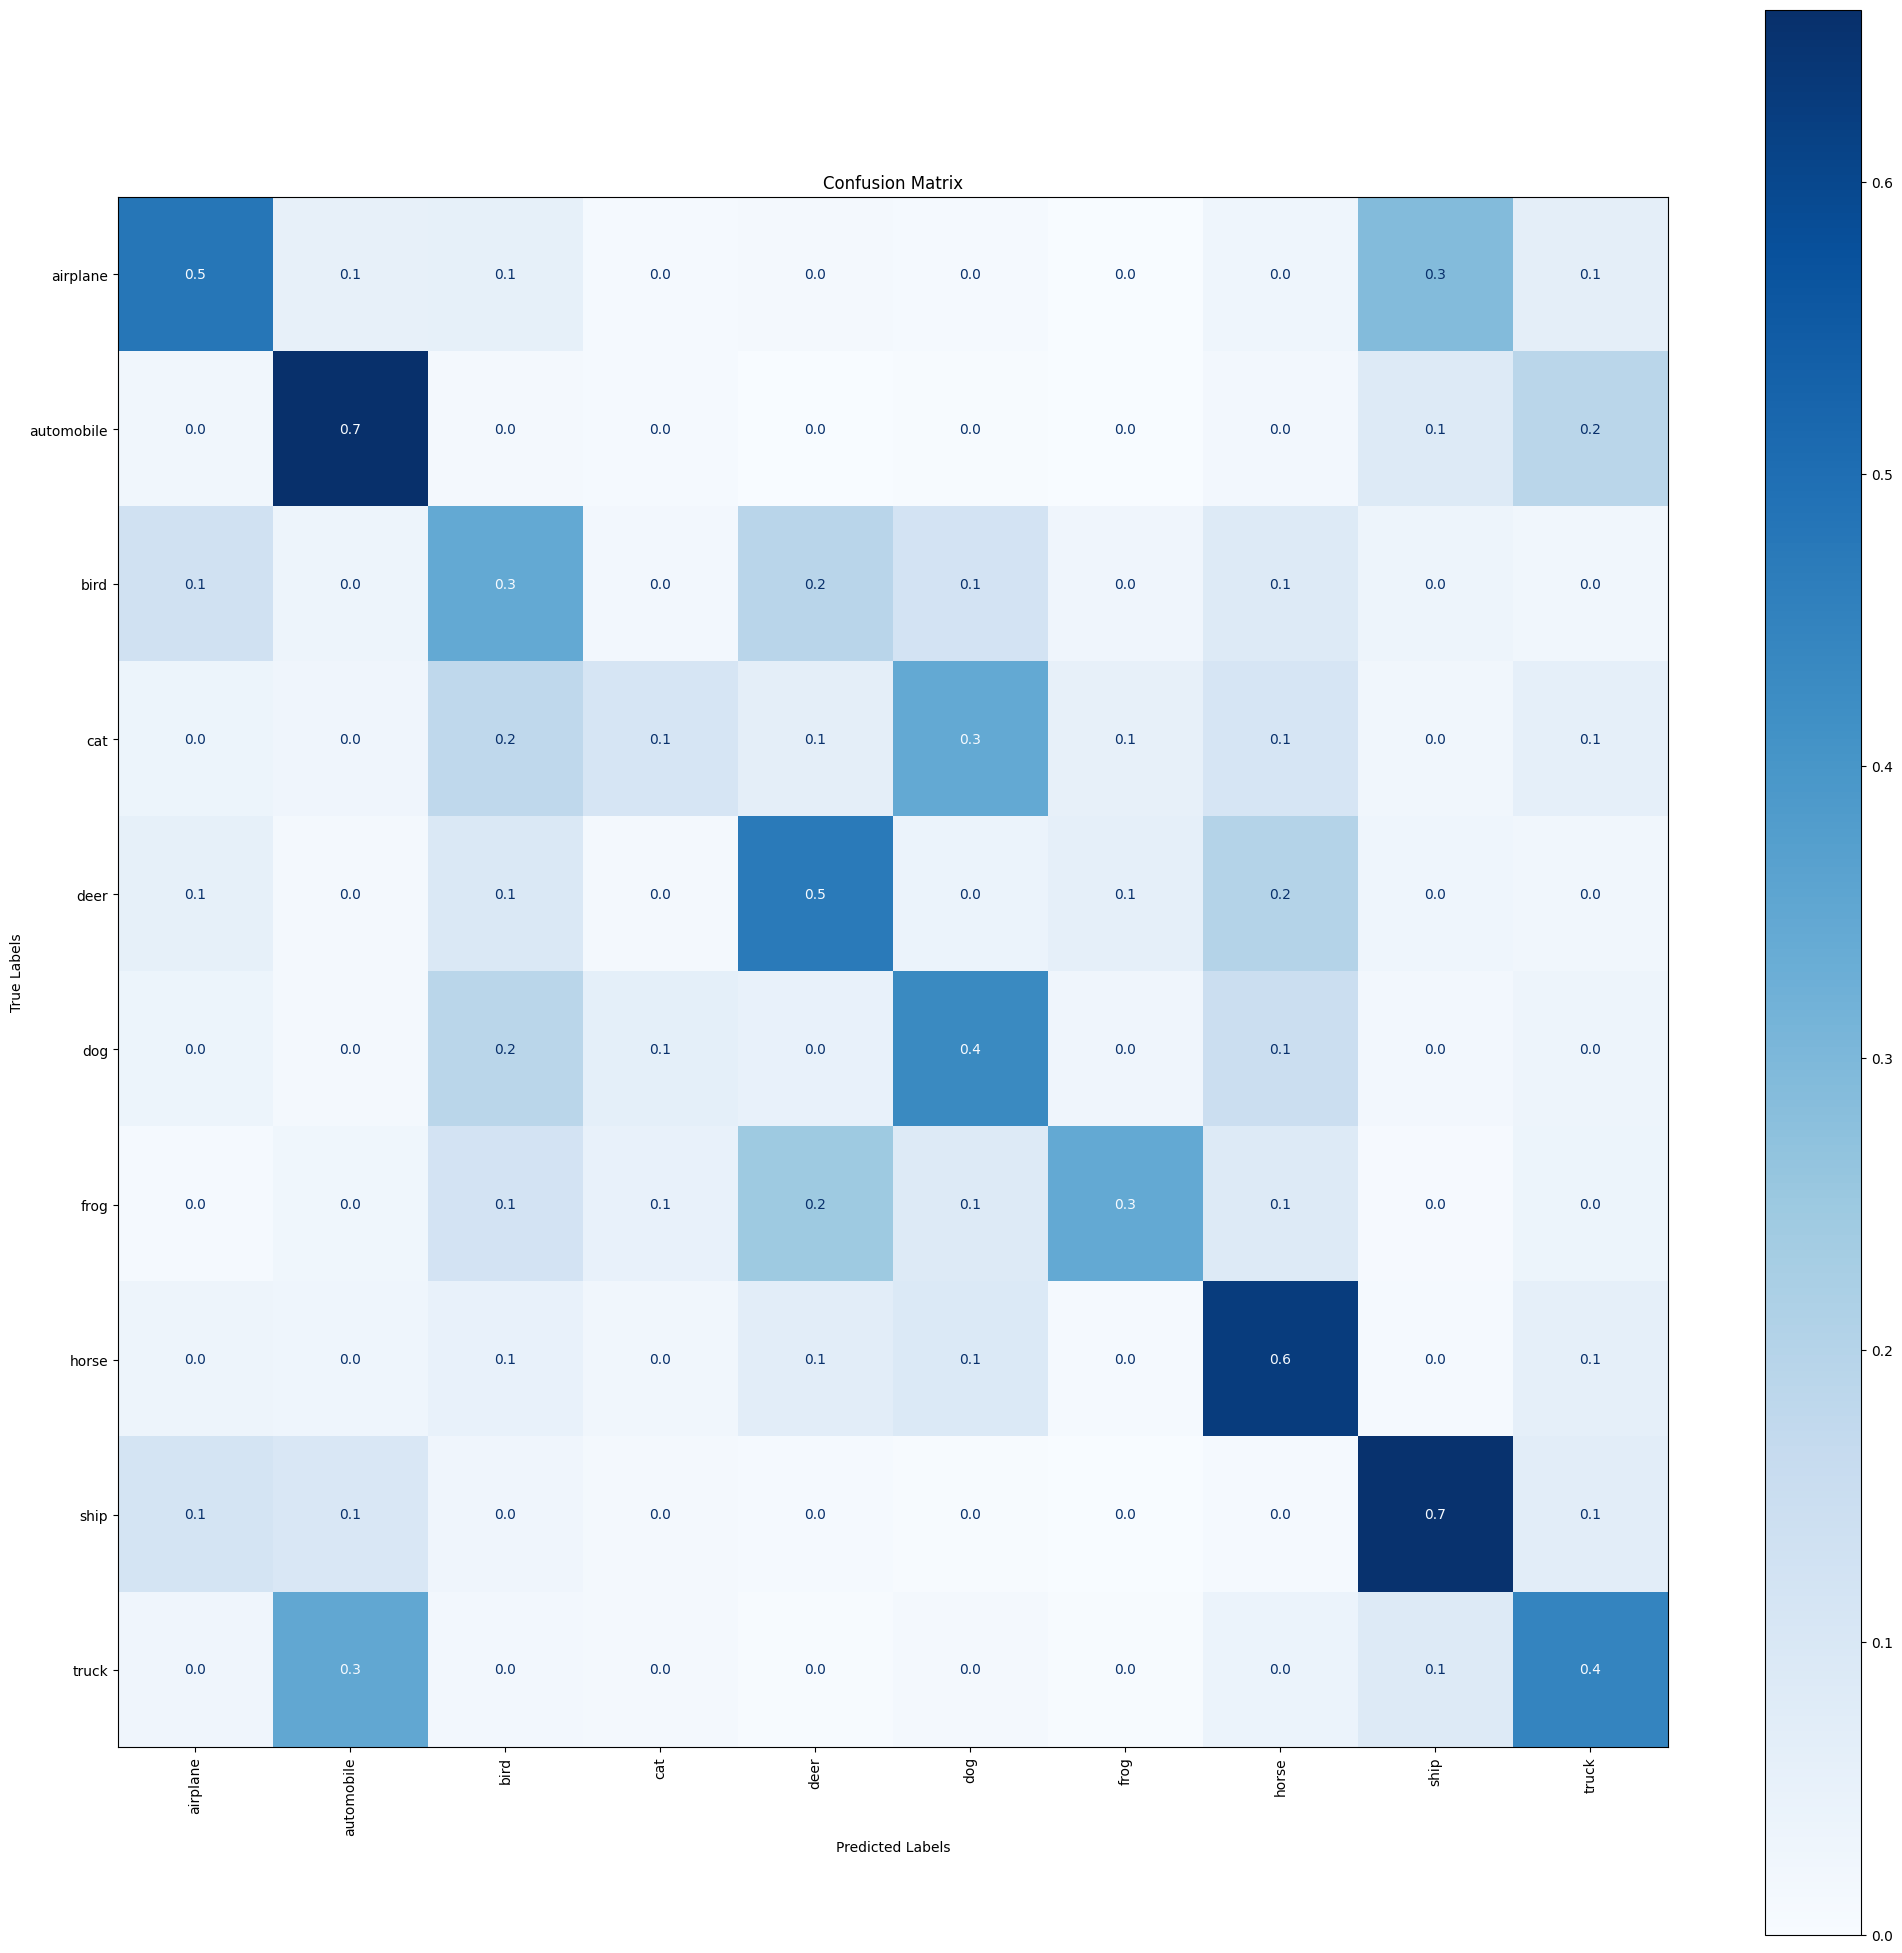

07/23 14:56:25 - mmengine - INFO - Epoch(val) [1][157/157]    accuracy/top1: 45.5900  accuracy/top5: 92.2400  loss/loss: 2.1294  data_time: 0.0102  time: 0.0896
07/23 14:56:25 - mmengine - INFO - The best checkpoint with 45.5900 accuracy/top1 at 1 epoch is saved to best_accuracy_top1_epoch_1.pth.
07/23 14:57:03 - mmengine - INFO - Epoch(train)  [2][100/782]  base_lr: 2.2545e-04 lr: 9.4267e-05  eta: 3:09:13  time: 0.3866  data_time: 0.0935  memory: 3611  grad_norm: 2.0883  loss: 1.6090
07/23 14:57:41 - mmengine - INFO - Epoch(train)  [2][200/782]  base_lr: 2.5103e-04 lr: 1.0496e-04  eta: 3:08:51  time: 0.3751  data_time: 0.0903  memory: 3611  grad_norm: 2.0923  loss: 1.5912
07/23 14:57:48 - mmengine - INFO - Exp name: 20240723_145117
07/23 14:58:19 - mmengine - INFO - Epoch(train)  [2][300/782]  base_lr: 2.7661e-04 lr: 1.1566e-04  eta: 3:08:20  time: 0.3756  data_time: 0.0903  memory: 3611  grad_norm: 2.2048  loss: 1.5240
07/23 14:58:57 - mmengine - INFO - Epoch(train)  [2][400/782]  ba

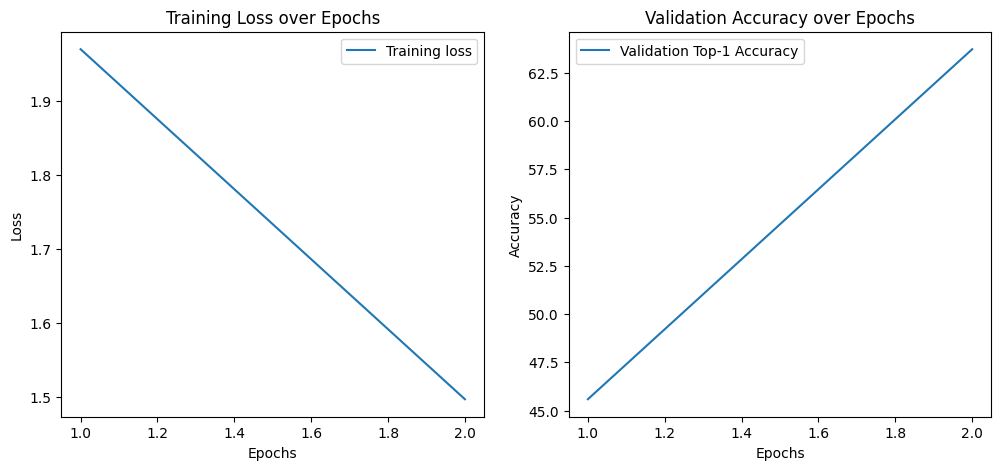

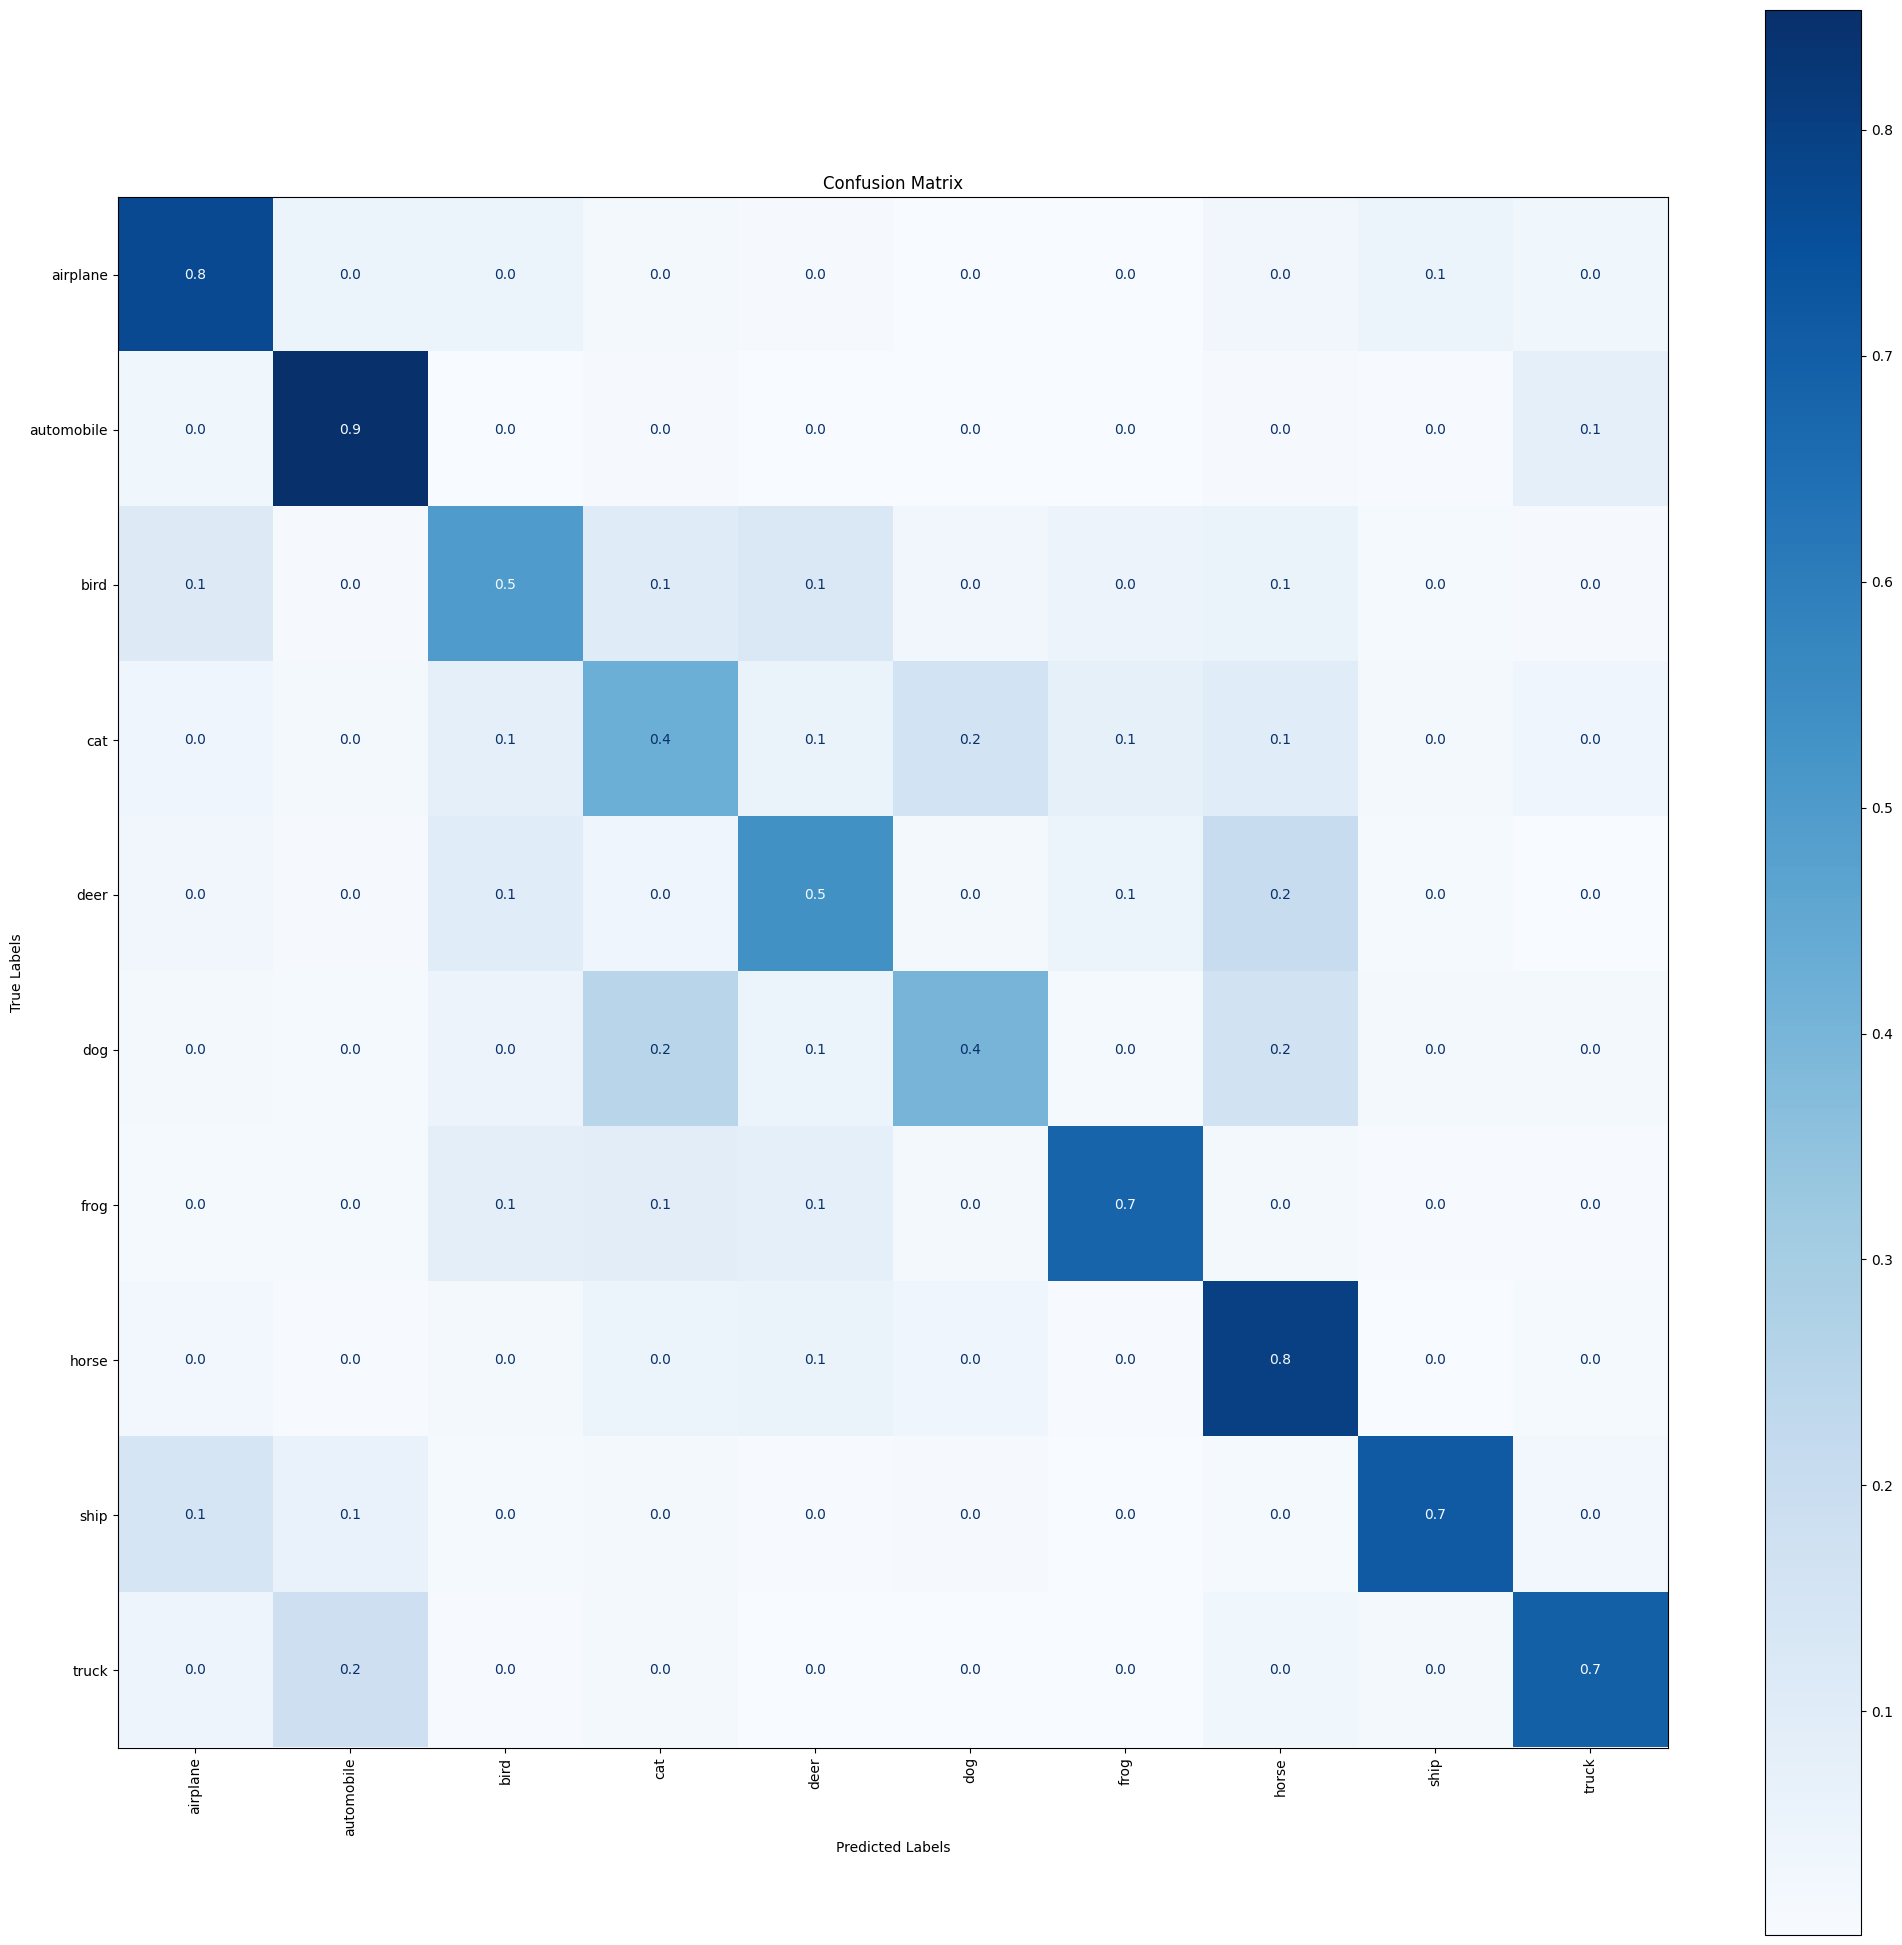

07/23 15:01:39 - mmengine - INFO - Epoch(val) [2][157/157]    accuracy/top1: 63.7200  accuracy/top5: 97.0500  loss/loss: 2.0410  data_time: 0.0099  time: 0.0892
07/23 15:01:39 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_1.pth is removed
07/23 15:01:39 - mmengine - INFO - The best checkpoint with 63.7200 accuracy/top1 at 2 epoch is saved to best_accuracy_top1_epoch_2.pth.
07/23 15:02:17 - mmengine - INFO - Epoch(train)  [3][100/782]  base_lr: 4.2549e-04 lr: 1.7790e-04  eta: 3:06:11  time: 0.3775  data_time: 0.0911  memory: 3611  grad_norm: 2.2908  loss: 1.3502
07/23 15:02:56 - mmengine - INFO - Epoch(train)  [3][200/782]  base_lr: 4.5107e-04 lr: 1.8860e-04  eta: 3:05:44  time: 0.3821  data_time: 0.0925  memory: 3611  grad_norm: 2.1943  loss: 1.3605
07/23 15:03:35 - mmengine - INFO - Epoch(train)  [3][300/782]  base_lr: 4.7664e-04 lr: 1.9929e-04  eta: 3:05:35  time: 0.

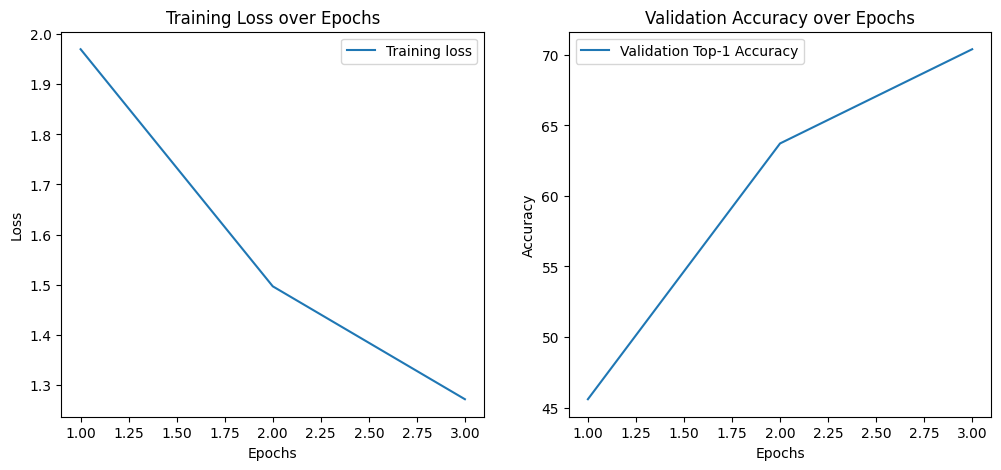

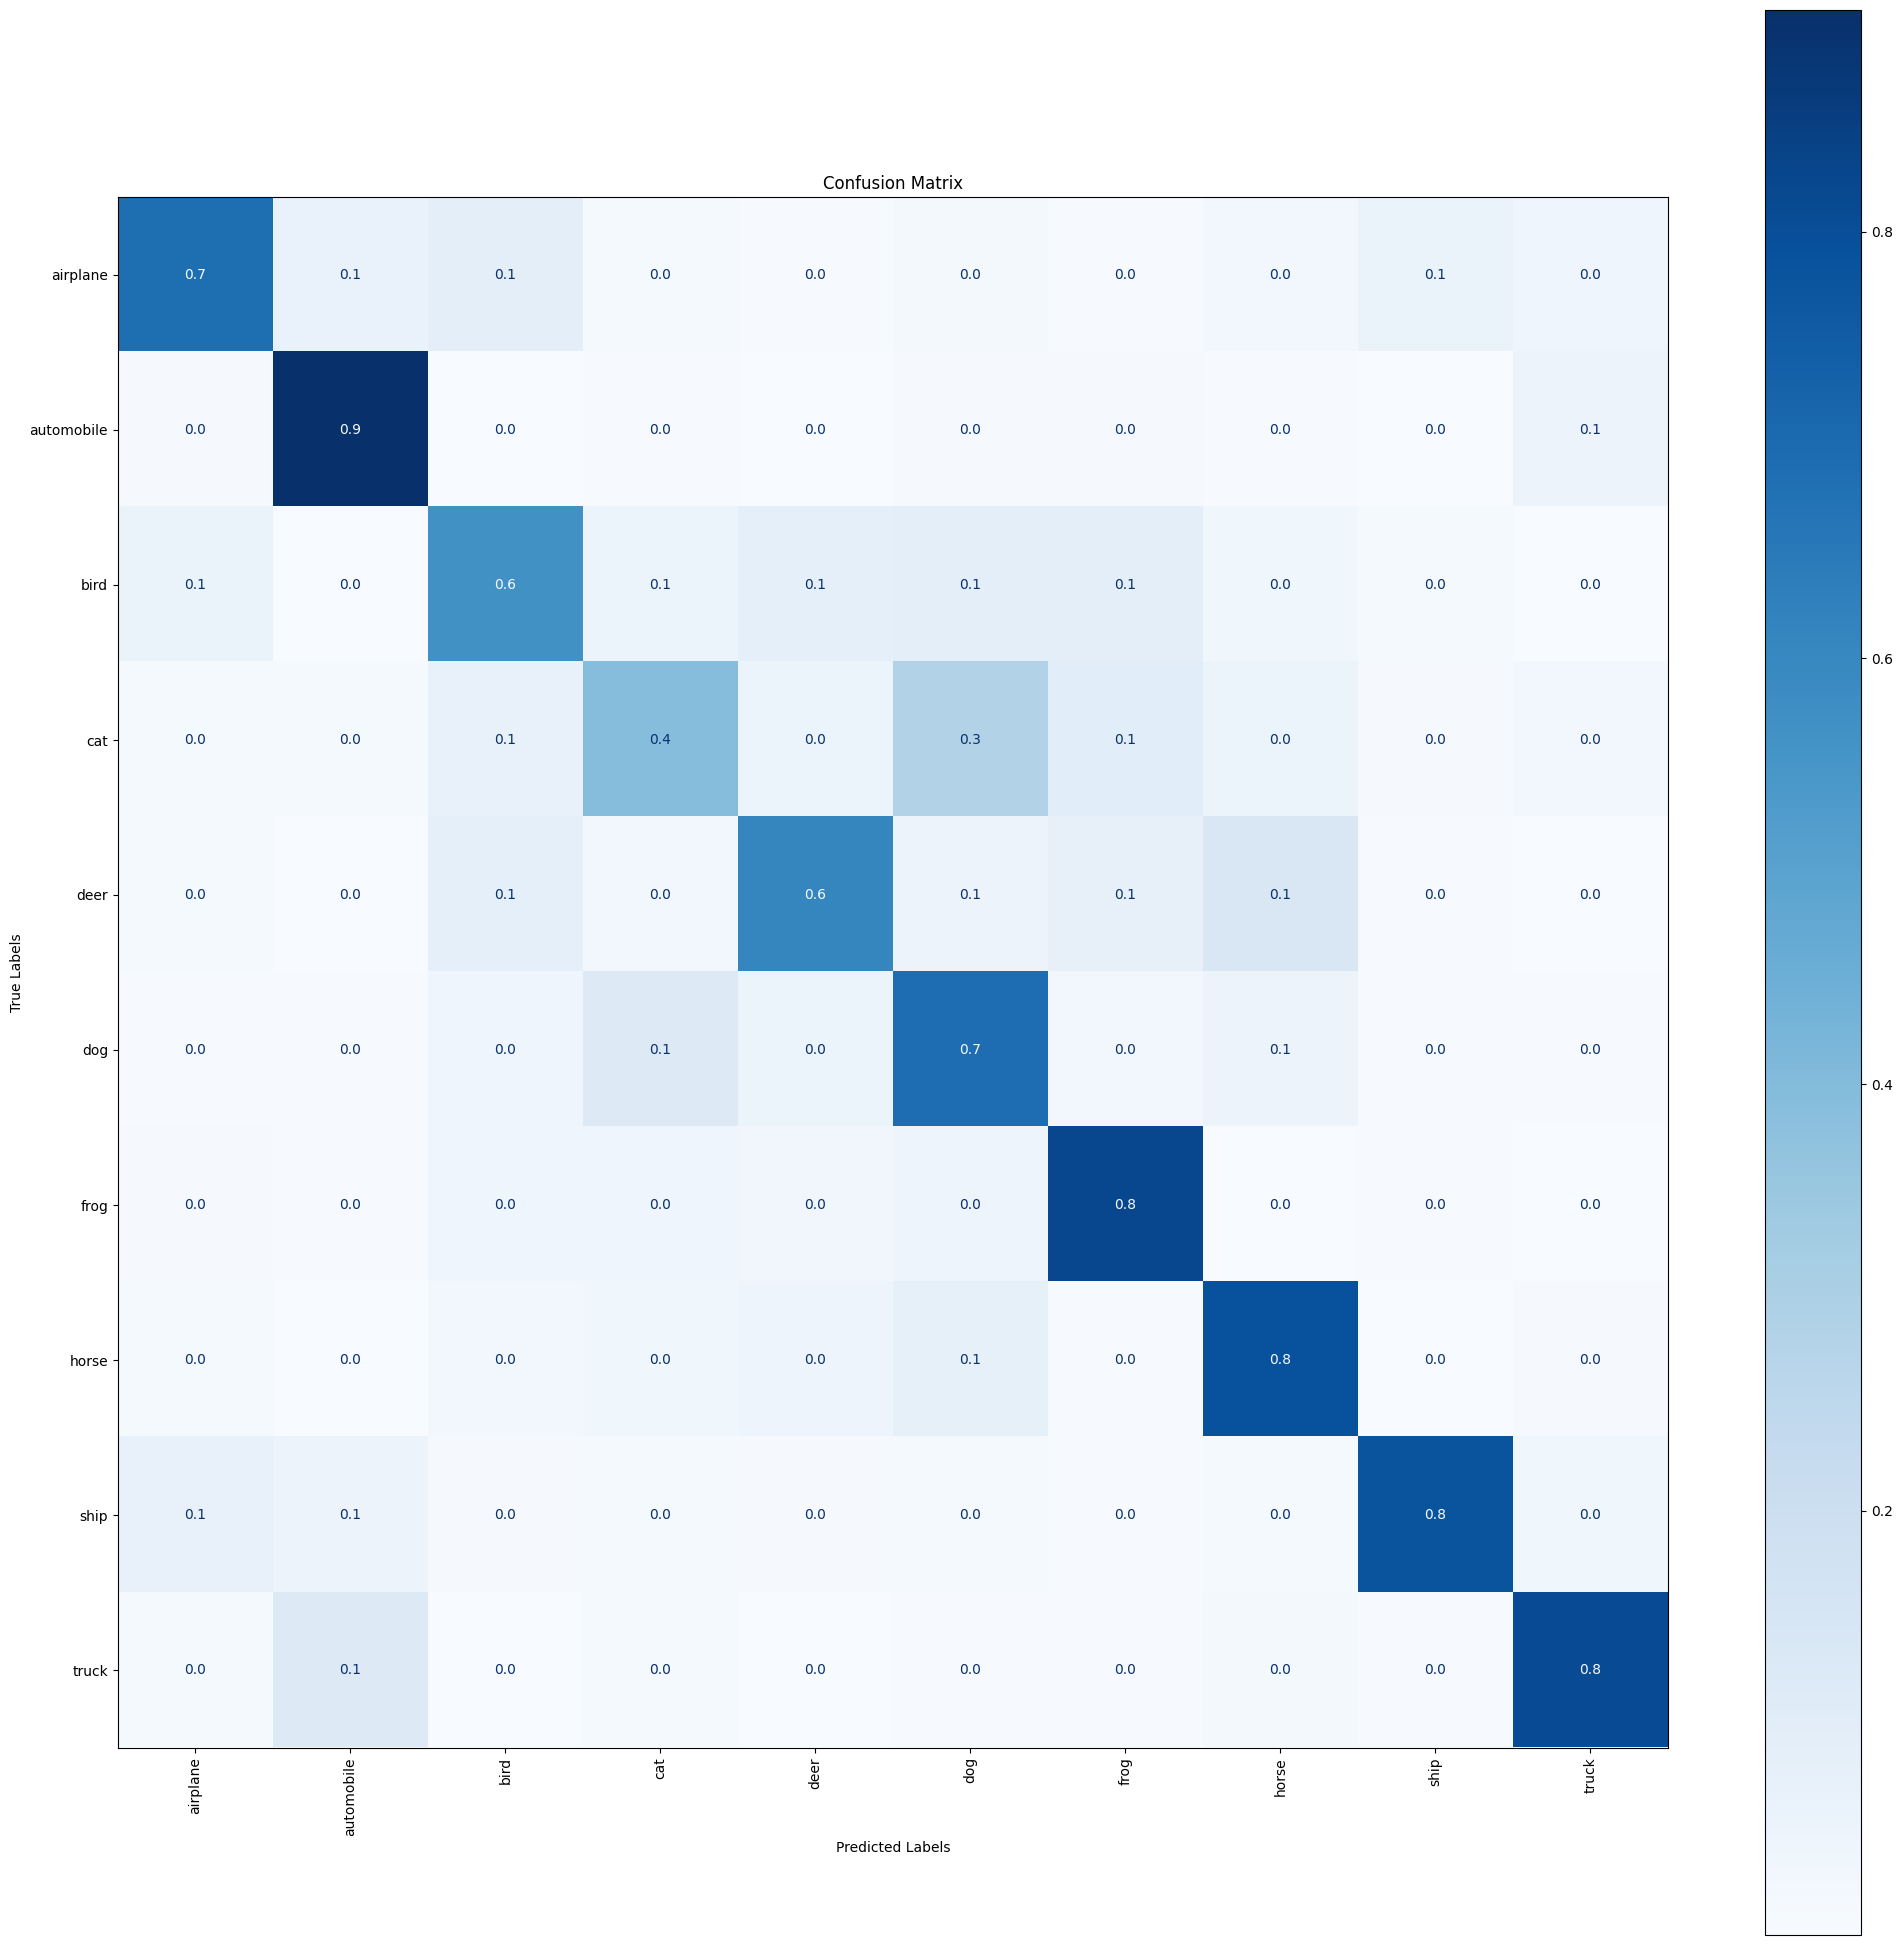

07/23 15:06:57 - mmengine - INFO - Epoch(val) [3][157/157]    accuracy/top1: 70.4000  accuracy/top5: 97.8600  loss/loss: 1.9846  data_time: 0.0111  time: 0.0906
07/23 15:06:57 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_2.pth is removed
07/23 15:06:58 - mmengine - INFO - The best checkpoint with 70.4000 accuracy/top1 at 3 epoch is saved to best_accuracy_top1_epoch_3.pth.
07/23 15:07:36 - mmengine - INFO - Epoch(train)  [4][100/782]  base_lr: 6.2552e-04 lr: 2.6154e-04  eta: 3:02:47  time: 0.3792  data_time: 0.0910  memory: 3611  grad_norm: 2.1256  loss: 1.2166
07/23 15:08:14 - mmengine - INFO - Epoch(train)  [4][200/782]  base_lr: 6.5110e-04 lr: 2.7224e-04  eta: 3:02:08  time: 0.3830  data_time: 0.0928  memory: 3611  grad_norm: 2.0941  loss: 1.1650
07/23 15:08:52 - mmengine - INFO - Epoch(train)  [4][300/782]  base_lr: 6.7668e-04 lr: 2.8293e-04  eta: 3:01:32  time: 0.

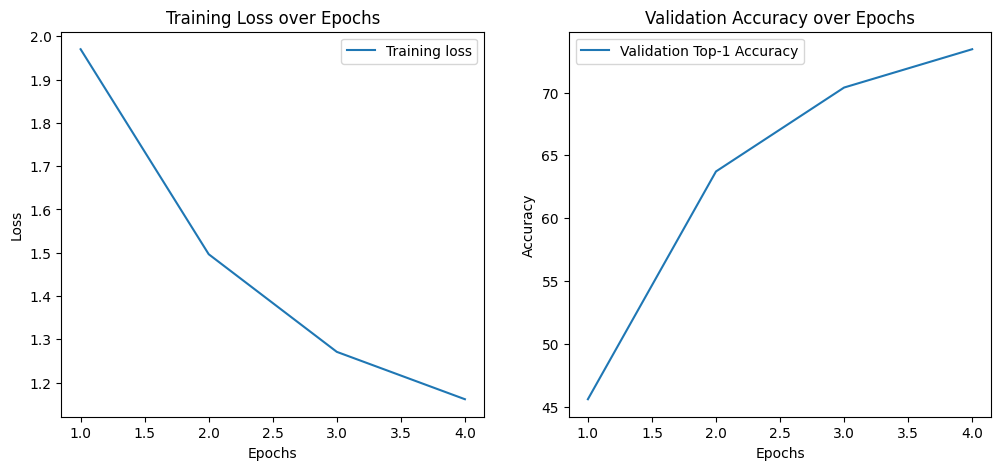

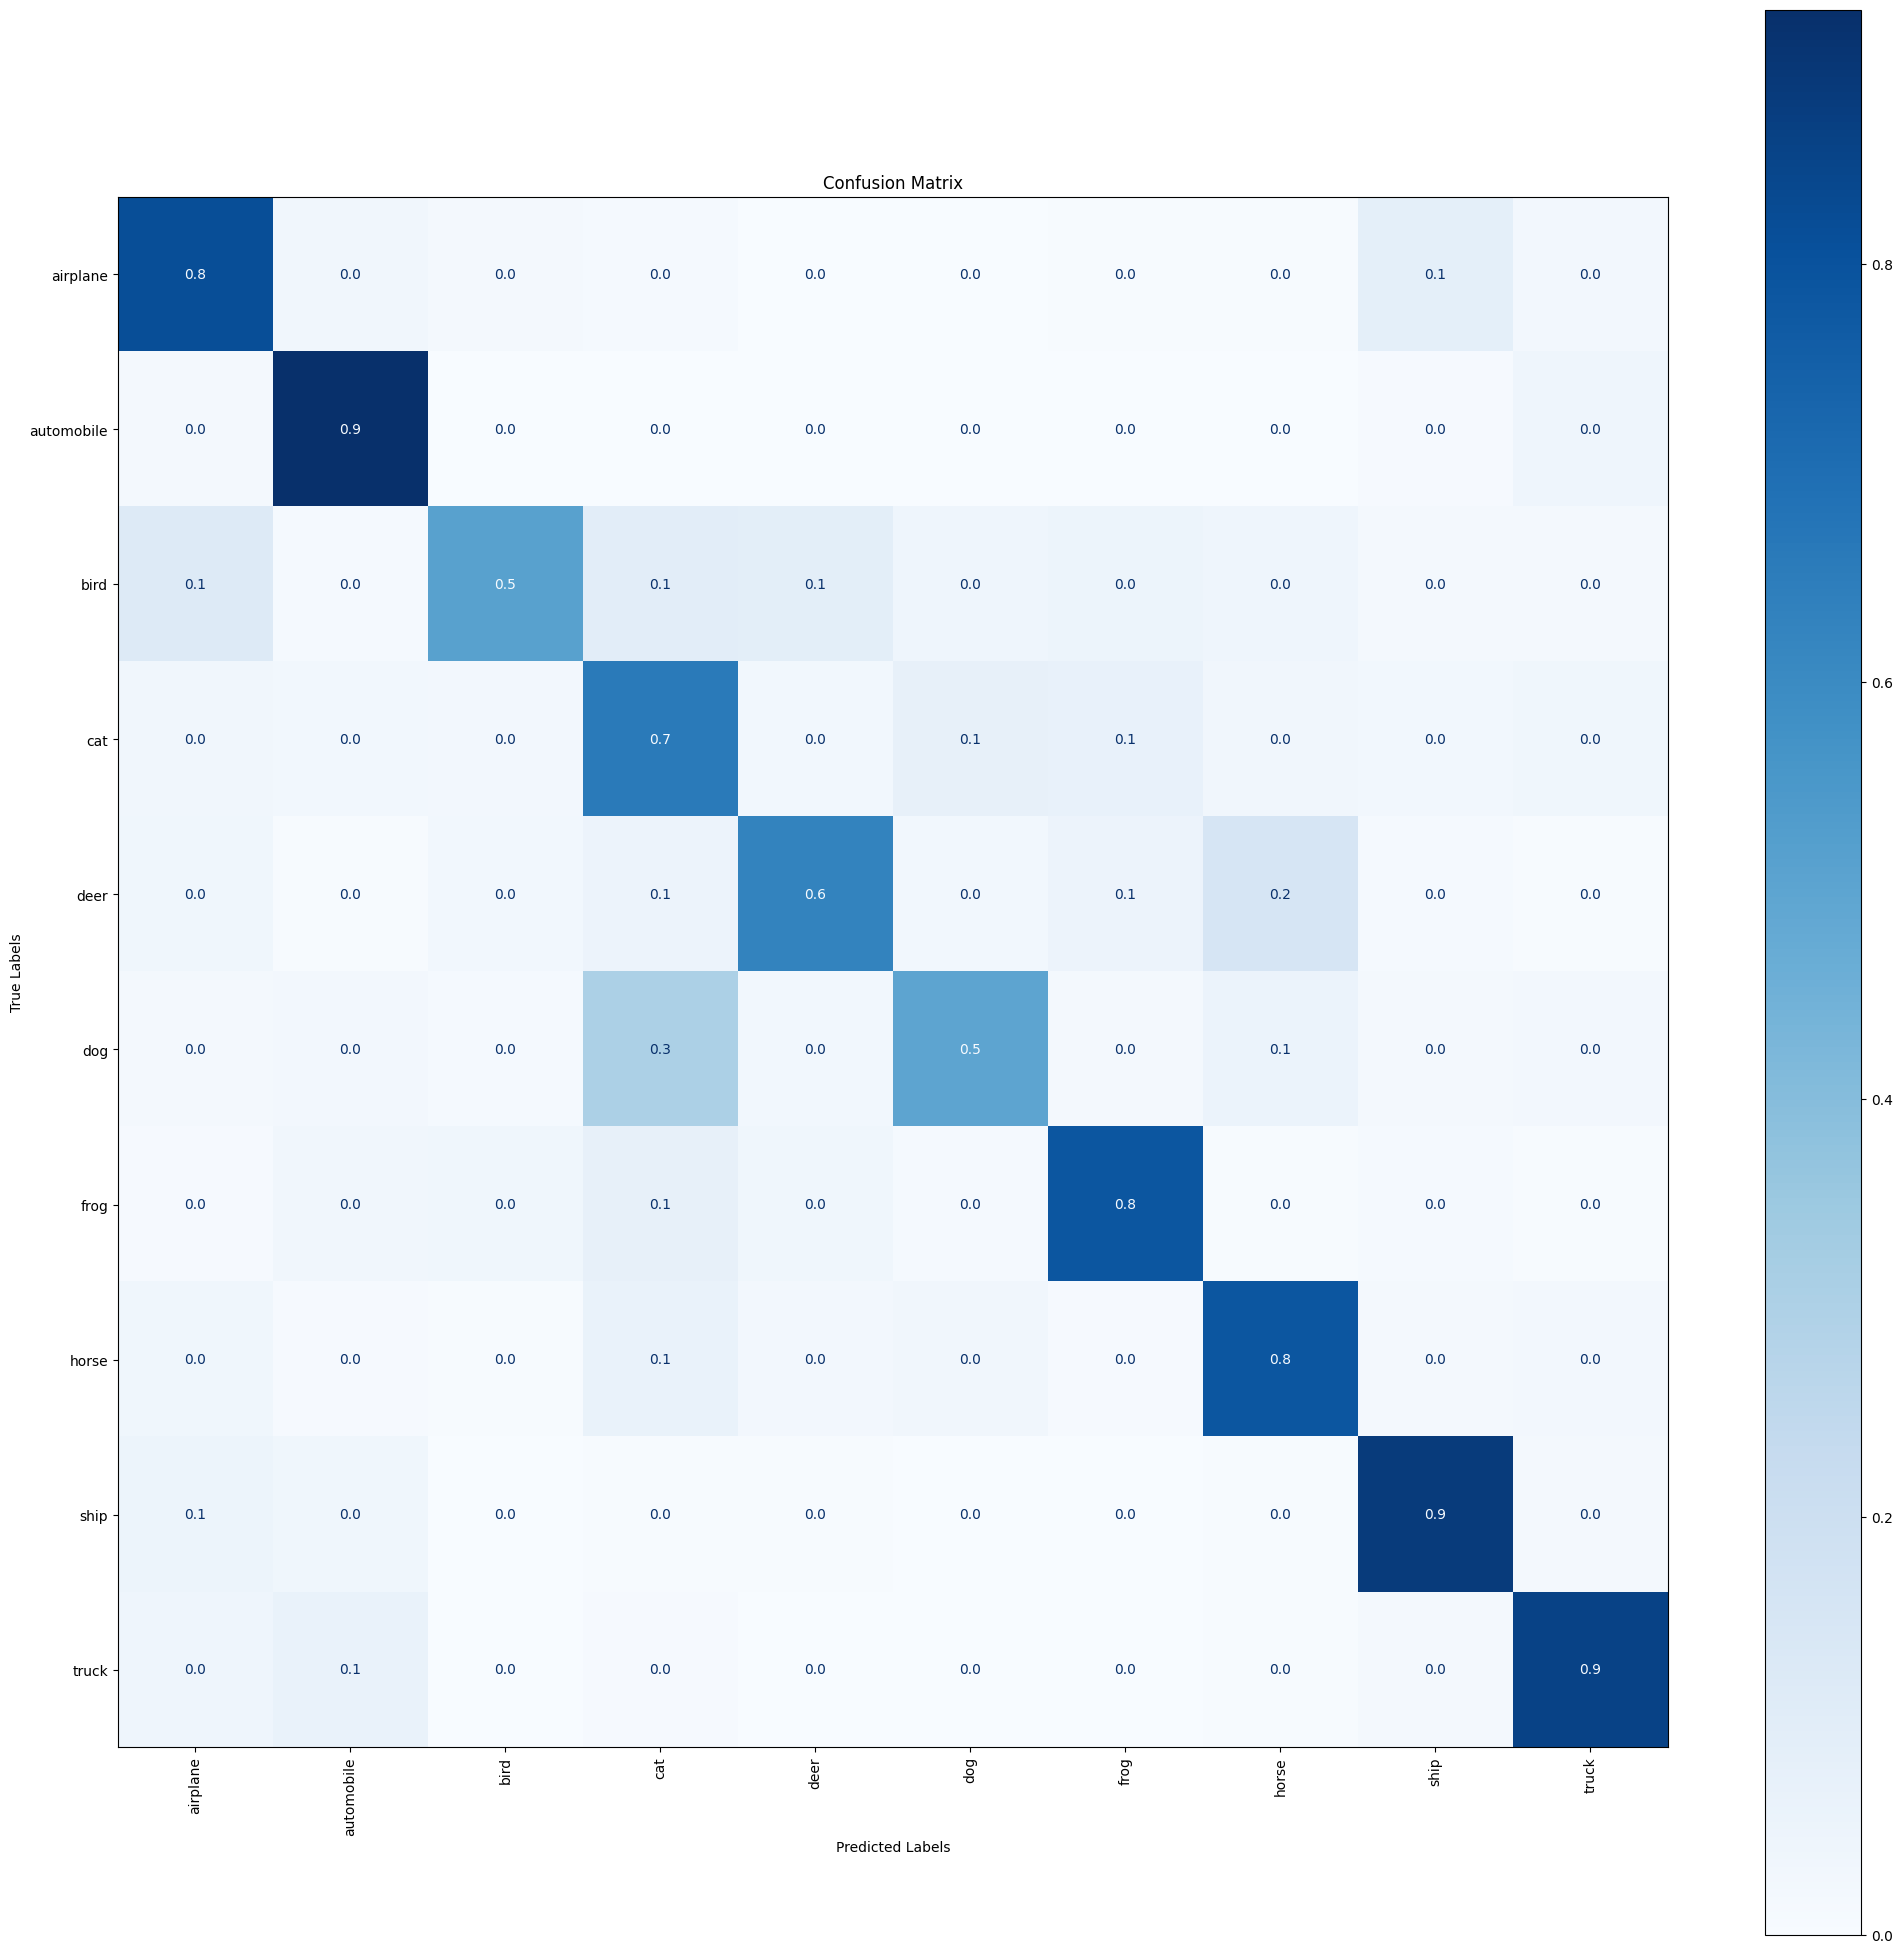

07/23 15:12:10 - mmengine - INFO - Epoch(val) [4][157/157]    accuracy/top1: 73.4500  accuracy/top5: 98.0400  loss/loss: 1.9476  data_time: 0.0109  time: 0.0897
07/23 15:12:10 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_3.pth is removed
07/23 15:12:10 - mmengine - INFO - The best checkpoint with 73.4500 accuracy/top1 at 4 epoch is saved to best_accuracy_top1_epoch_4.pth.
07/23 15:12:48 - mmengine - INFO - Epoch(train)  [5][100/782]  base_lr: 8.2555e-04 lr: 3.4518e-04  eta: 2:57:43  time: 0.3784  data_time: 0.0908  memory: 3611  grad_norm: 1.8844  loss: 1.1006
07/23 15:13:26 - mmengine - INFO - Epoch(train)  [5][200/782]  base_lr: 8.5113e-04 lr: 3.5587e-04  eta: 2:57:04  time: 0.3791  data_time: 0.0909  memory: 3611  grad_norm: 1.9231  loss: 1.0680
07/23 15:14:04 - mmengine - INFO - Epoch(train)  [5][300/782]  base_lr: 8.7671e-04 lr: 3.6657e-04  eta: 2:56:25  time: 0.

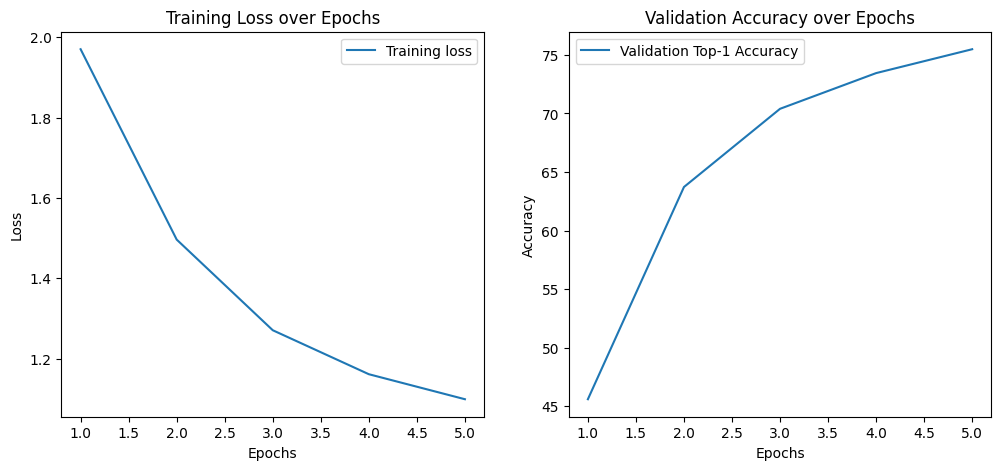

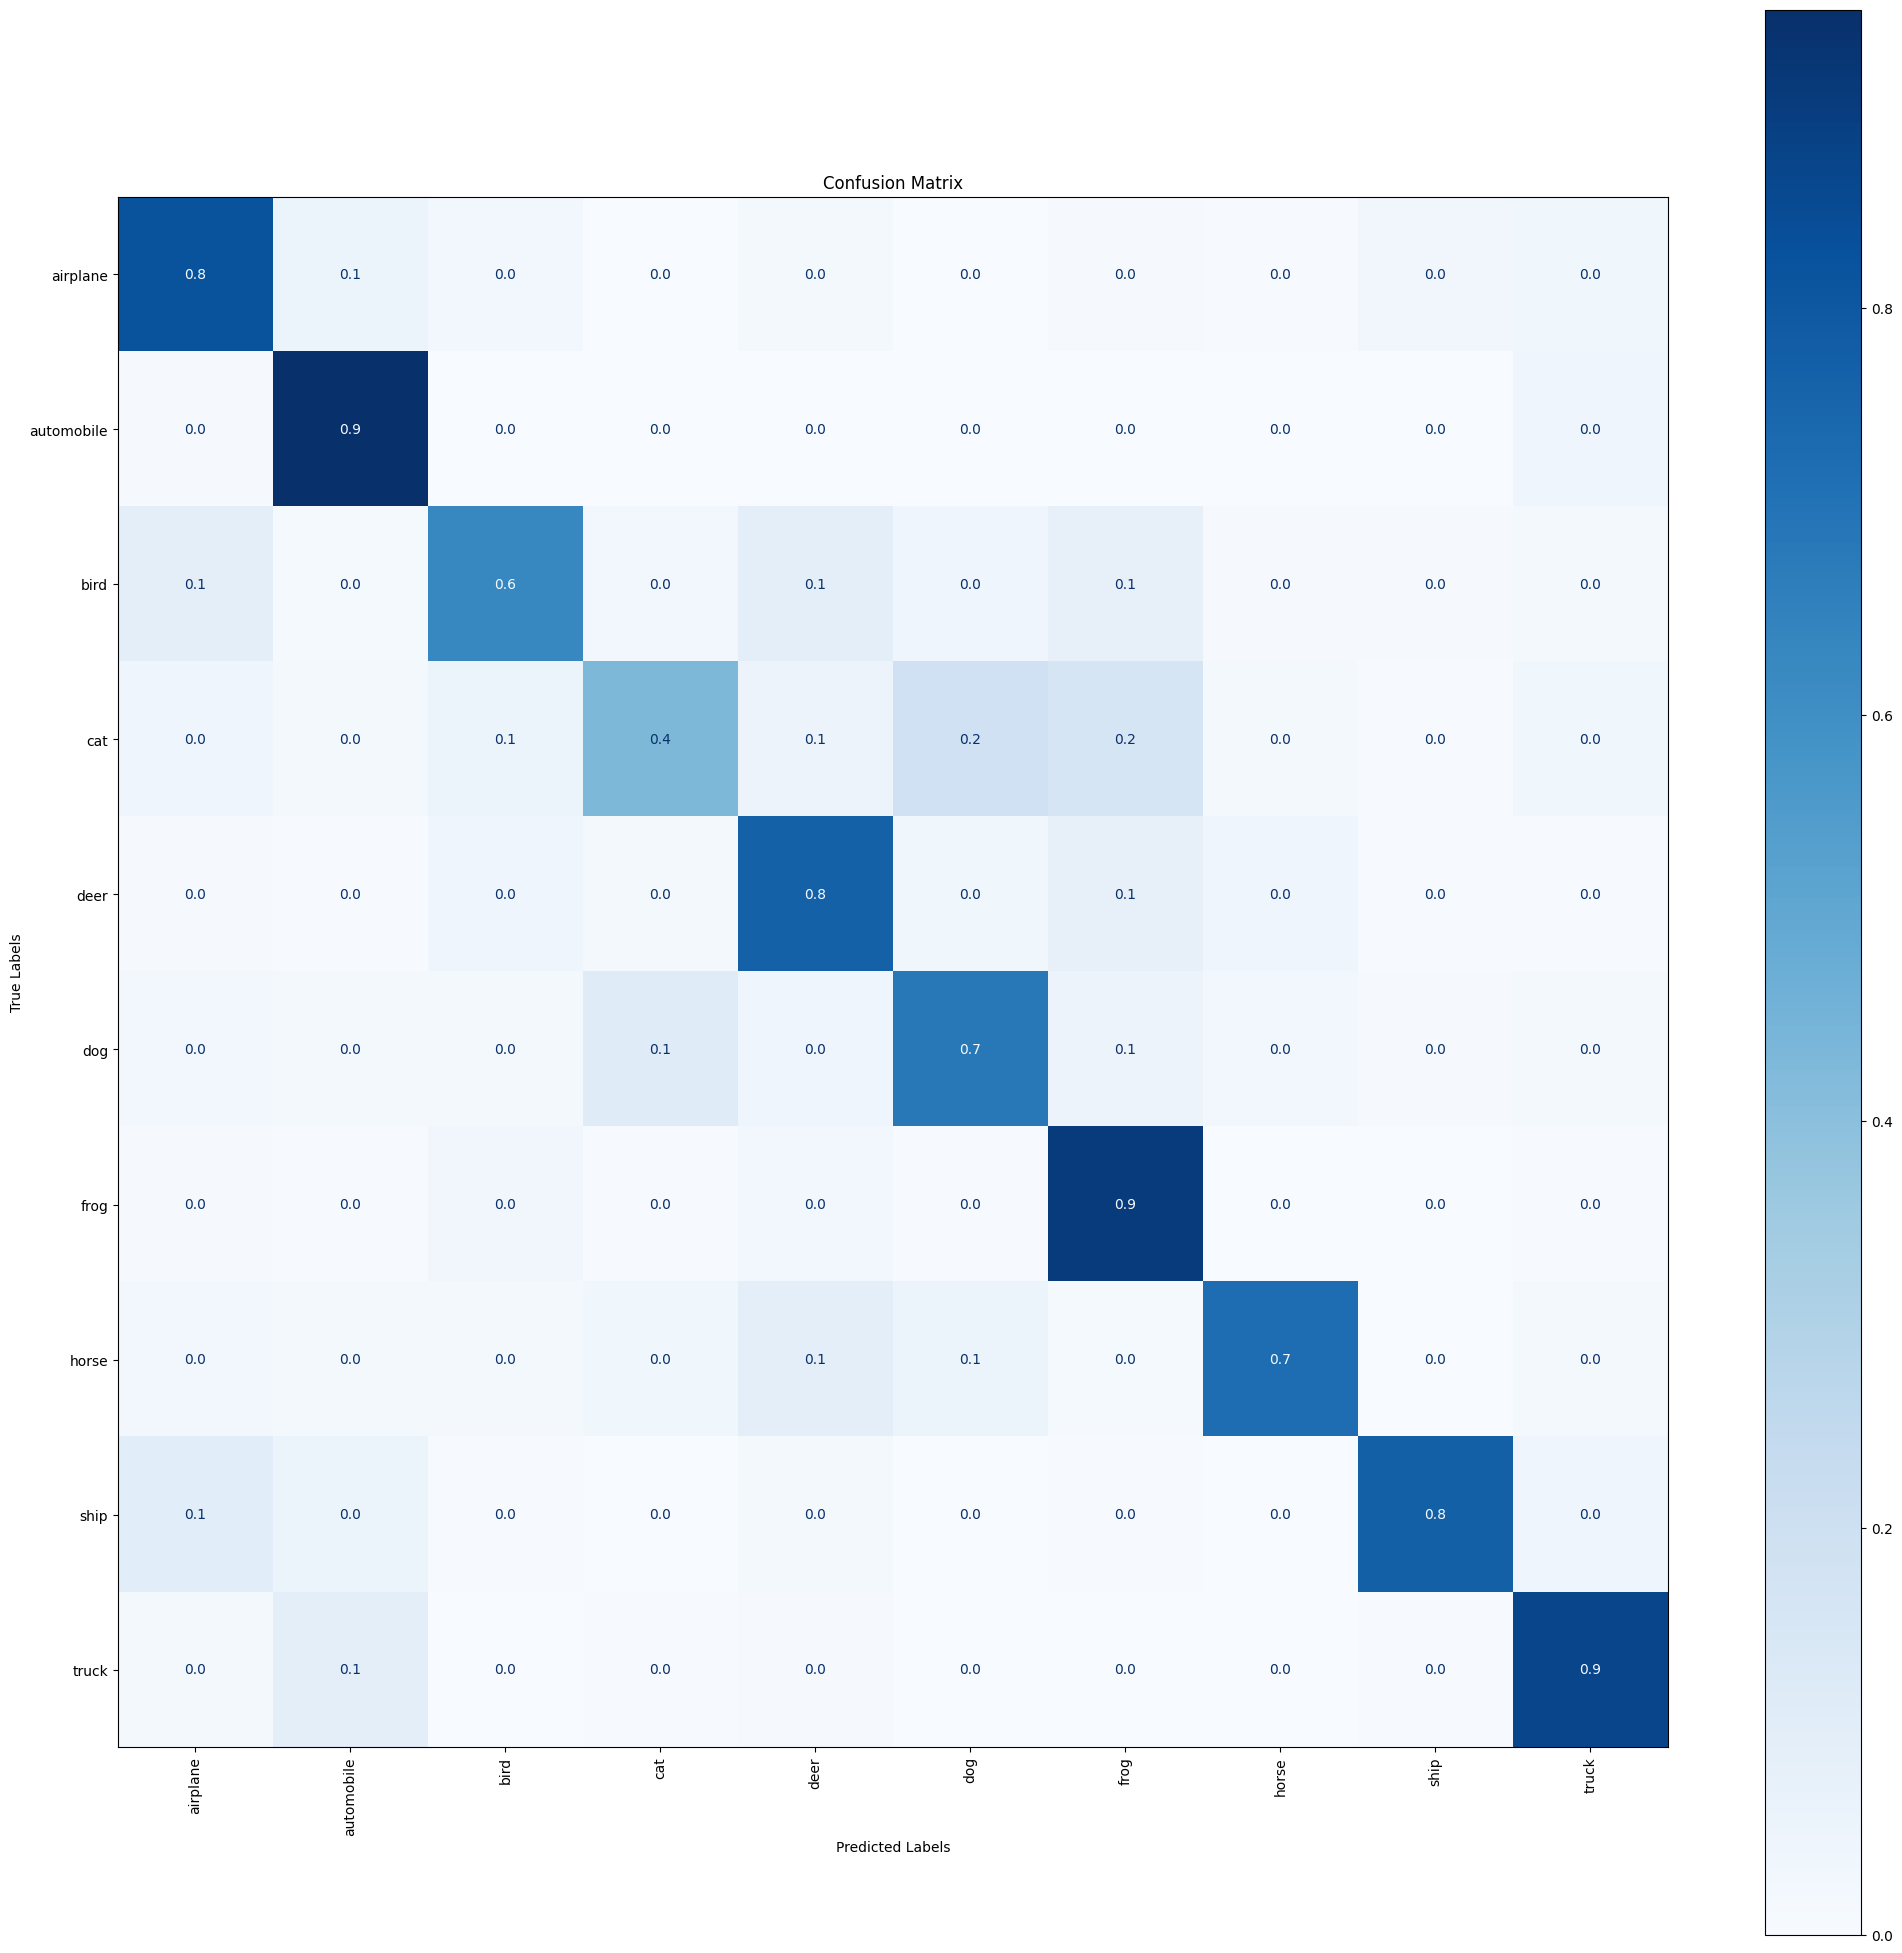

07/23 15:17:22 - mmengine - INFO - Epoch(val) [5][157/157]    accuracy/top1: 75.4900  accuracy/top5: 98.0600  loss/loss: 1.9220  data_time: 0.0108  time: 0.0890
07/23 15:17:22 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_4.pth is removed
07/23 15:17:22 - mmengine - INFO - The best checkpoint with 75.4900 accuracy/top1 at 5 epoch is saved to best_accuracy_top1_epoch_5.pth.
07/23 15:17:56 - mmengine - INFO - Exp name: 20240723_145117
07/23 15:18:00 - mmengine - INFO - Epoch(train)  [6][100/782]  base_lr: 9.9997e-04 lr: 4.1811e-04  eta: 2:52:38  time: 0.3785  data_time: 0.0912  memory: 3611  grad_norm: 1.9439  loss: 1.0767
07/23 15:18:38 - mmengine - INFO - Epoch(train)  [6][200/782]  base_lr: 9.9987e-04 lr: 4.1807e-04  eta: 2:51:59  time: 0.3781  data_time: 0.0911  memory: 3611  grad_norm: 1.8578  loss: 1.0084
07/23 15:19:15 - mmengine - INFO - Epoch(train)  [6][300/782

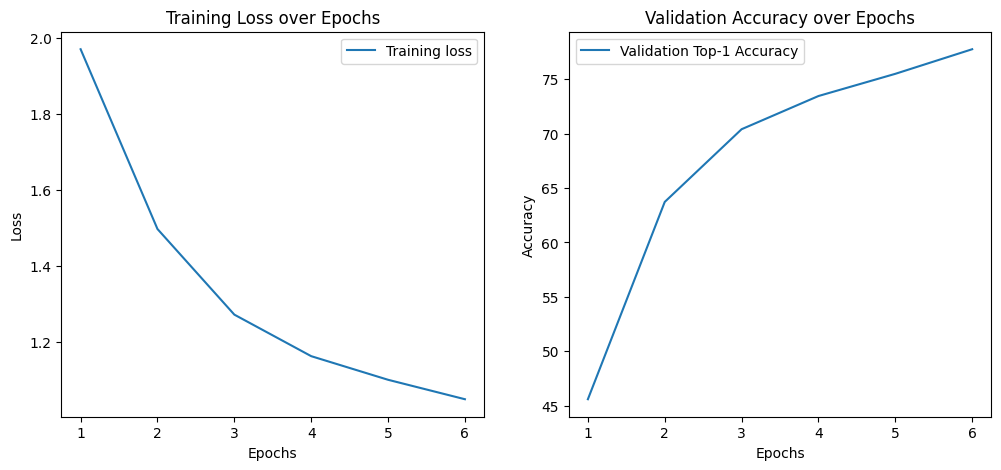

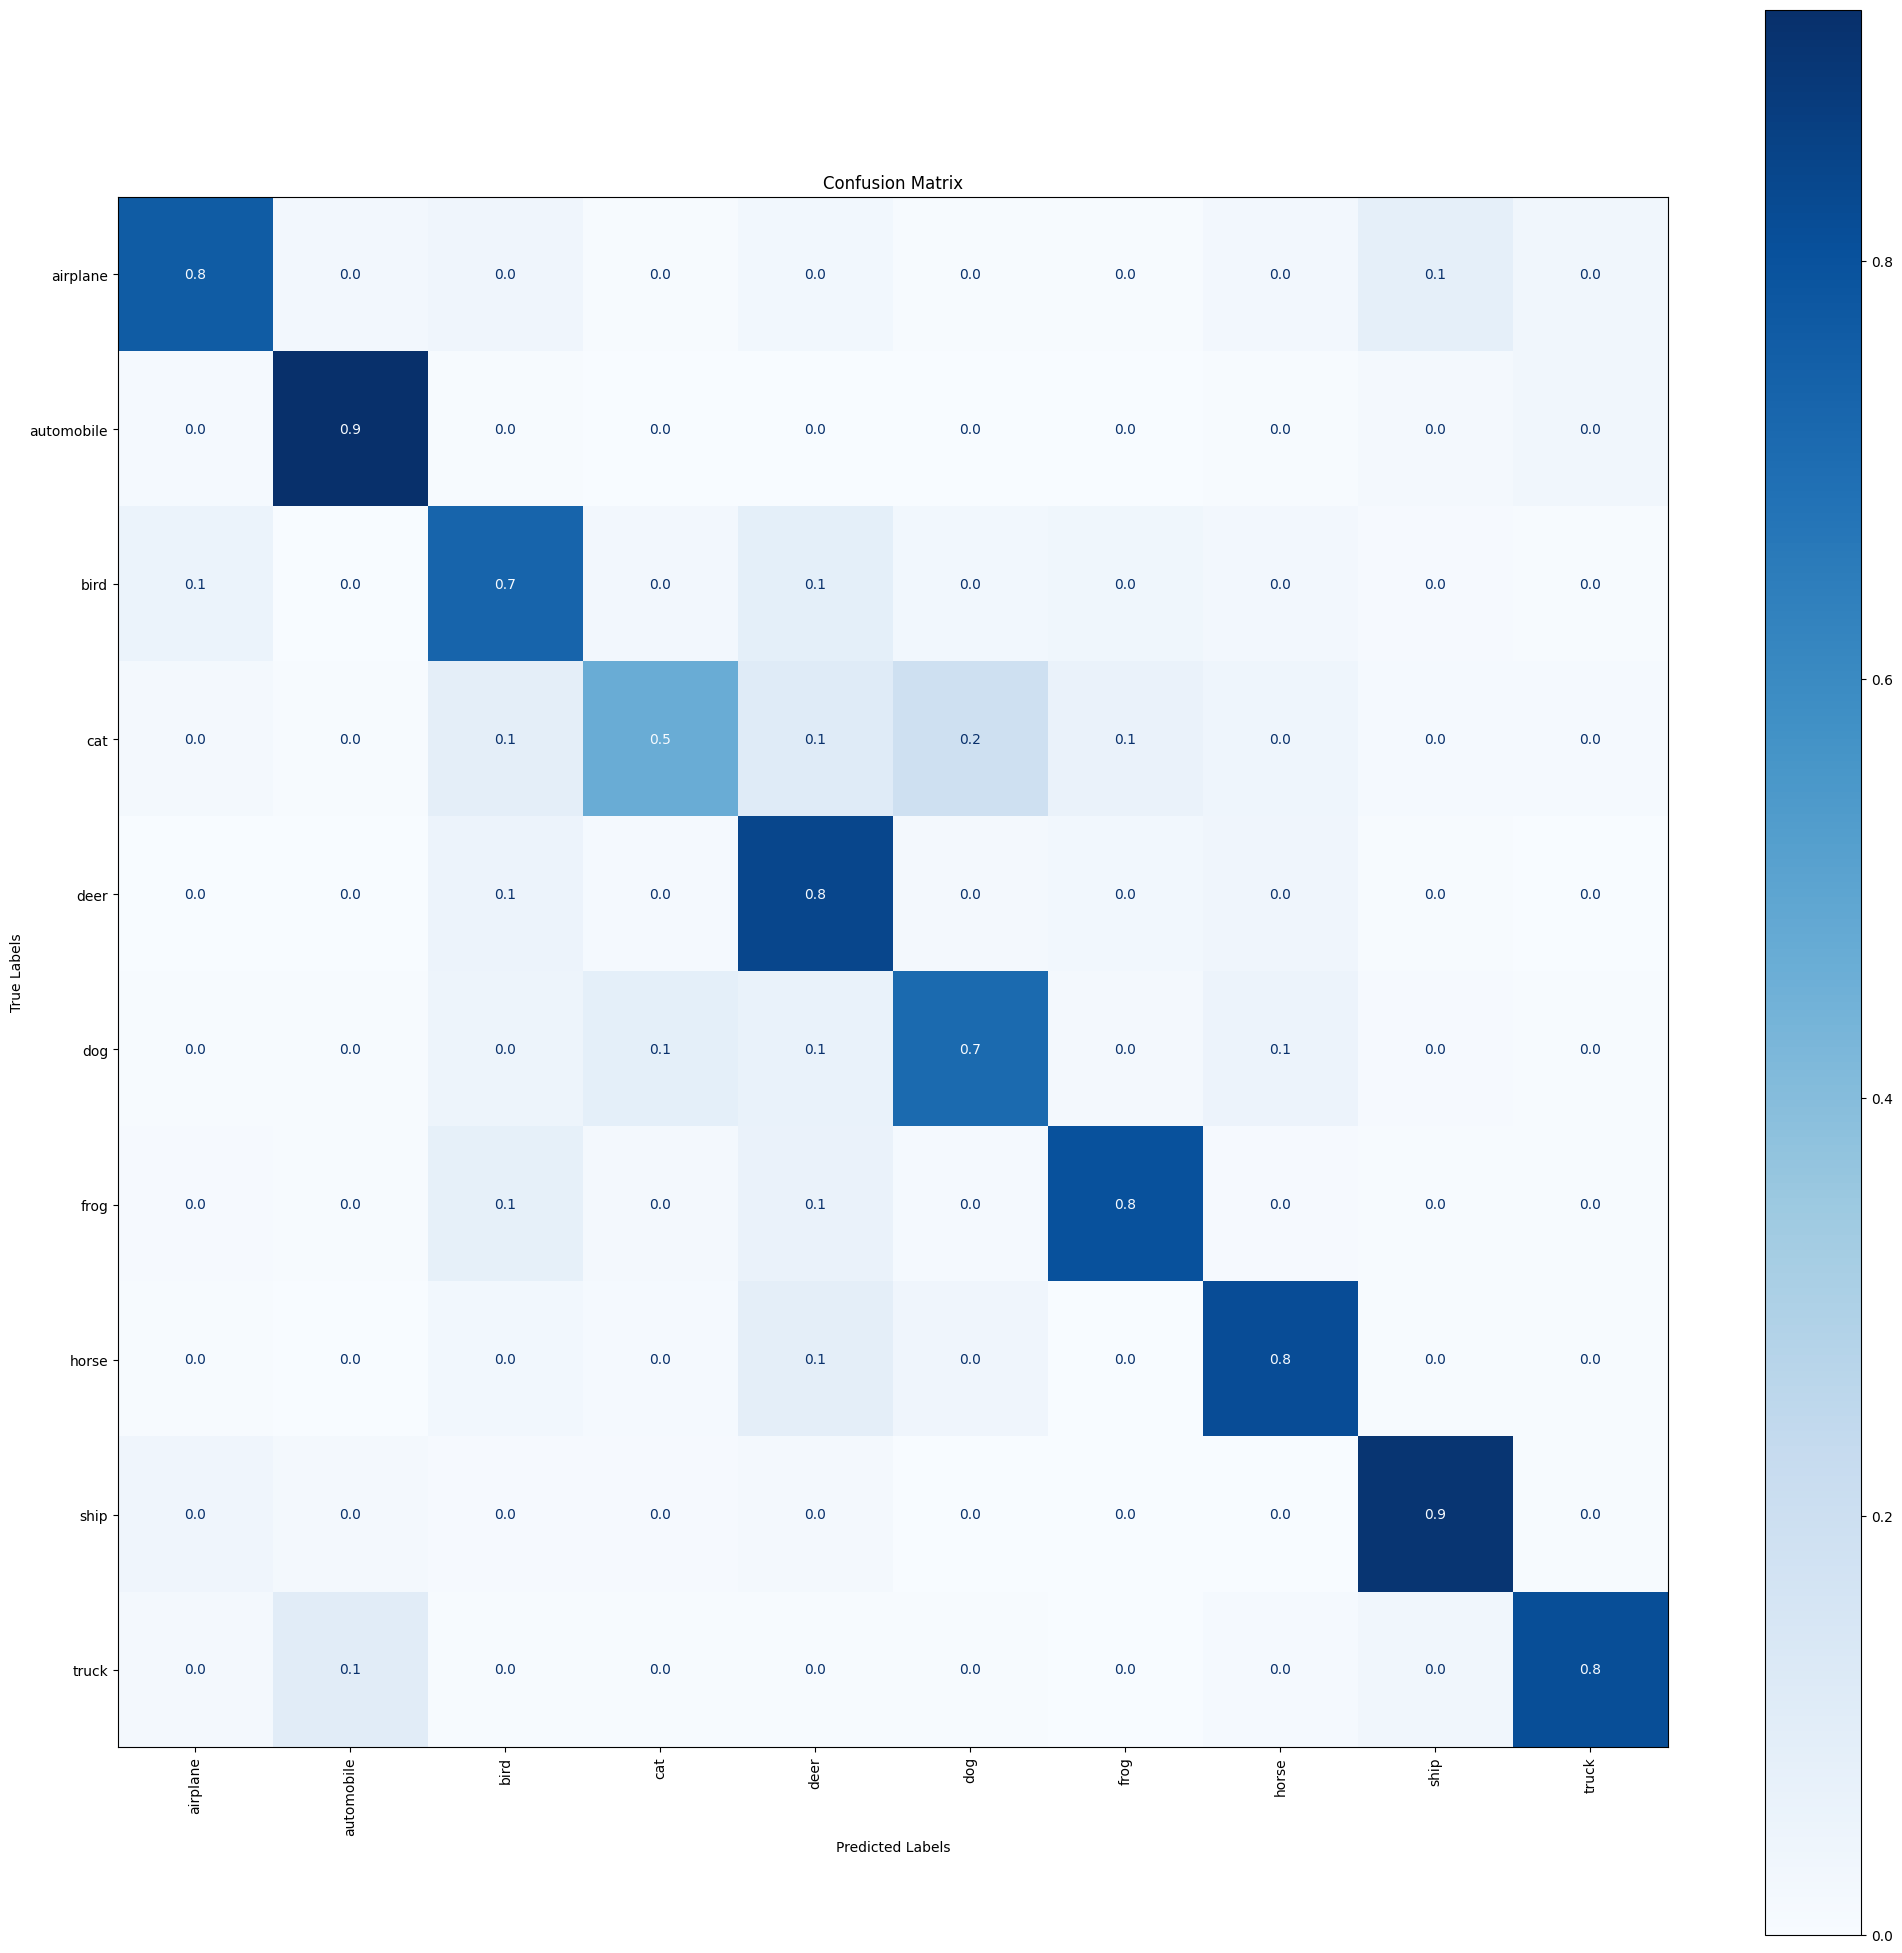

07/23 15:22:34 - mmengine - INFO - Epoch(val) [6][157/157]    accuracy/top1: 77.7500  accuracy/top5: 98.6900  loss/loss: 1.9026  data_time: 0.0101  time: 0.0890
07/23 15:22:34 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_5.pth is removed
07/23 15:22:34 - mmengine - INFO - The best checkpoint with 77.7500 accuracy/top1 at 6 epoch is saved to best_accuracy_top1_epoch_6.pth.
07/23 15:23:13 - mmengine - INFO - Epoch(train)  [7][100/782]  base_lr: 9.9747e-04 lr: 4.1708e-04  eta: 2:47:41  time: 0.3787  data_time: 0.0915  memory: 3611  grad_norm: 1.8071  loss: 0.9558
07/23 15:23:50 - mmengine - INFO - Epoch(train)  [7][200/782]  base_lr: 9.9687e-04 lr: 4.1683e-04  eta: 2:47:03  time: 0.3798  data_time: 0.0918  memory: 3611  grad_norm: 1.7454  loss: 0.9546
07/23 15:24:28 - mmengine - INFO - Epoch(train)  [7][300/782]  base_lr: 9.9619e-04 lr: 4.1655e-04  eta: 2:46:24  time: 0.

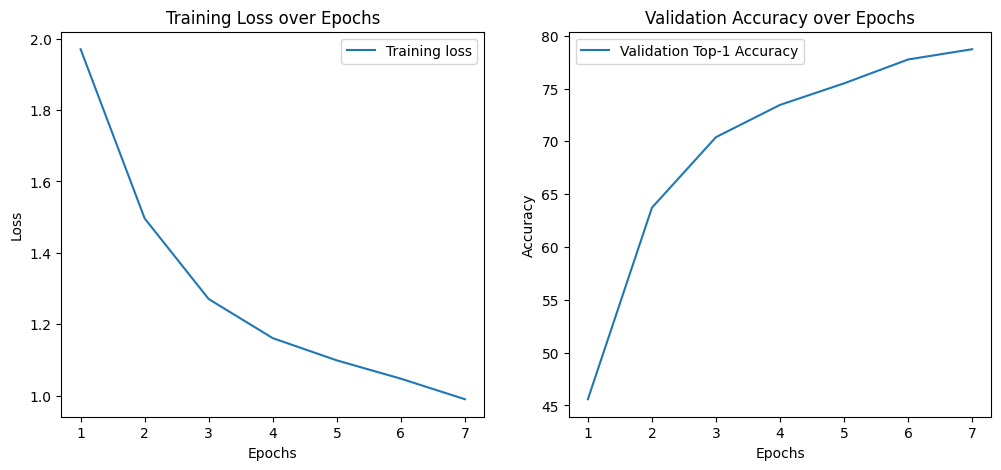

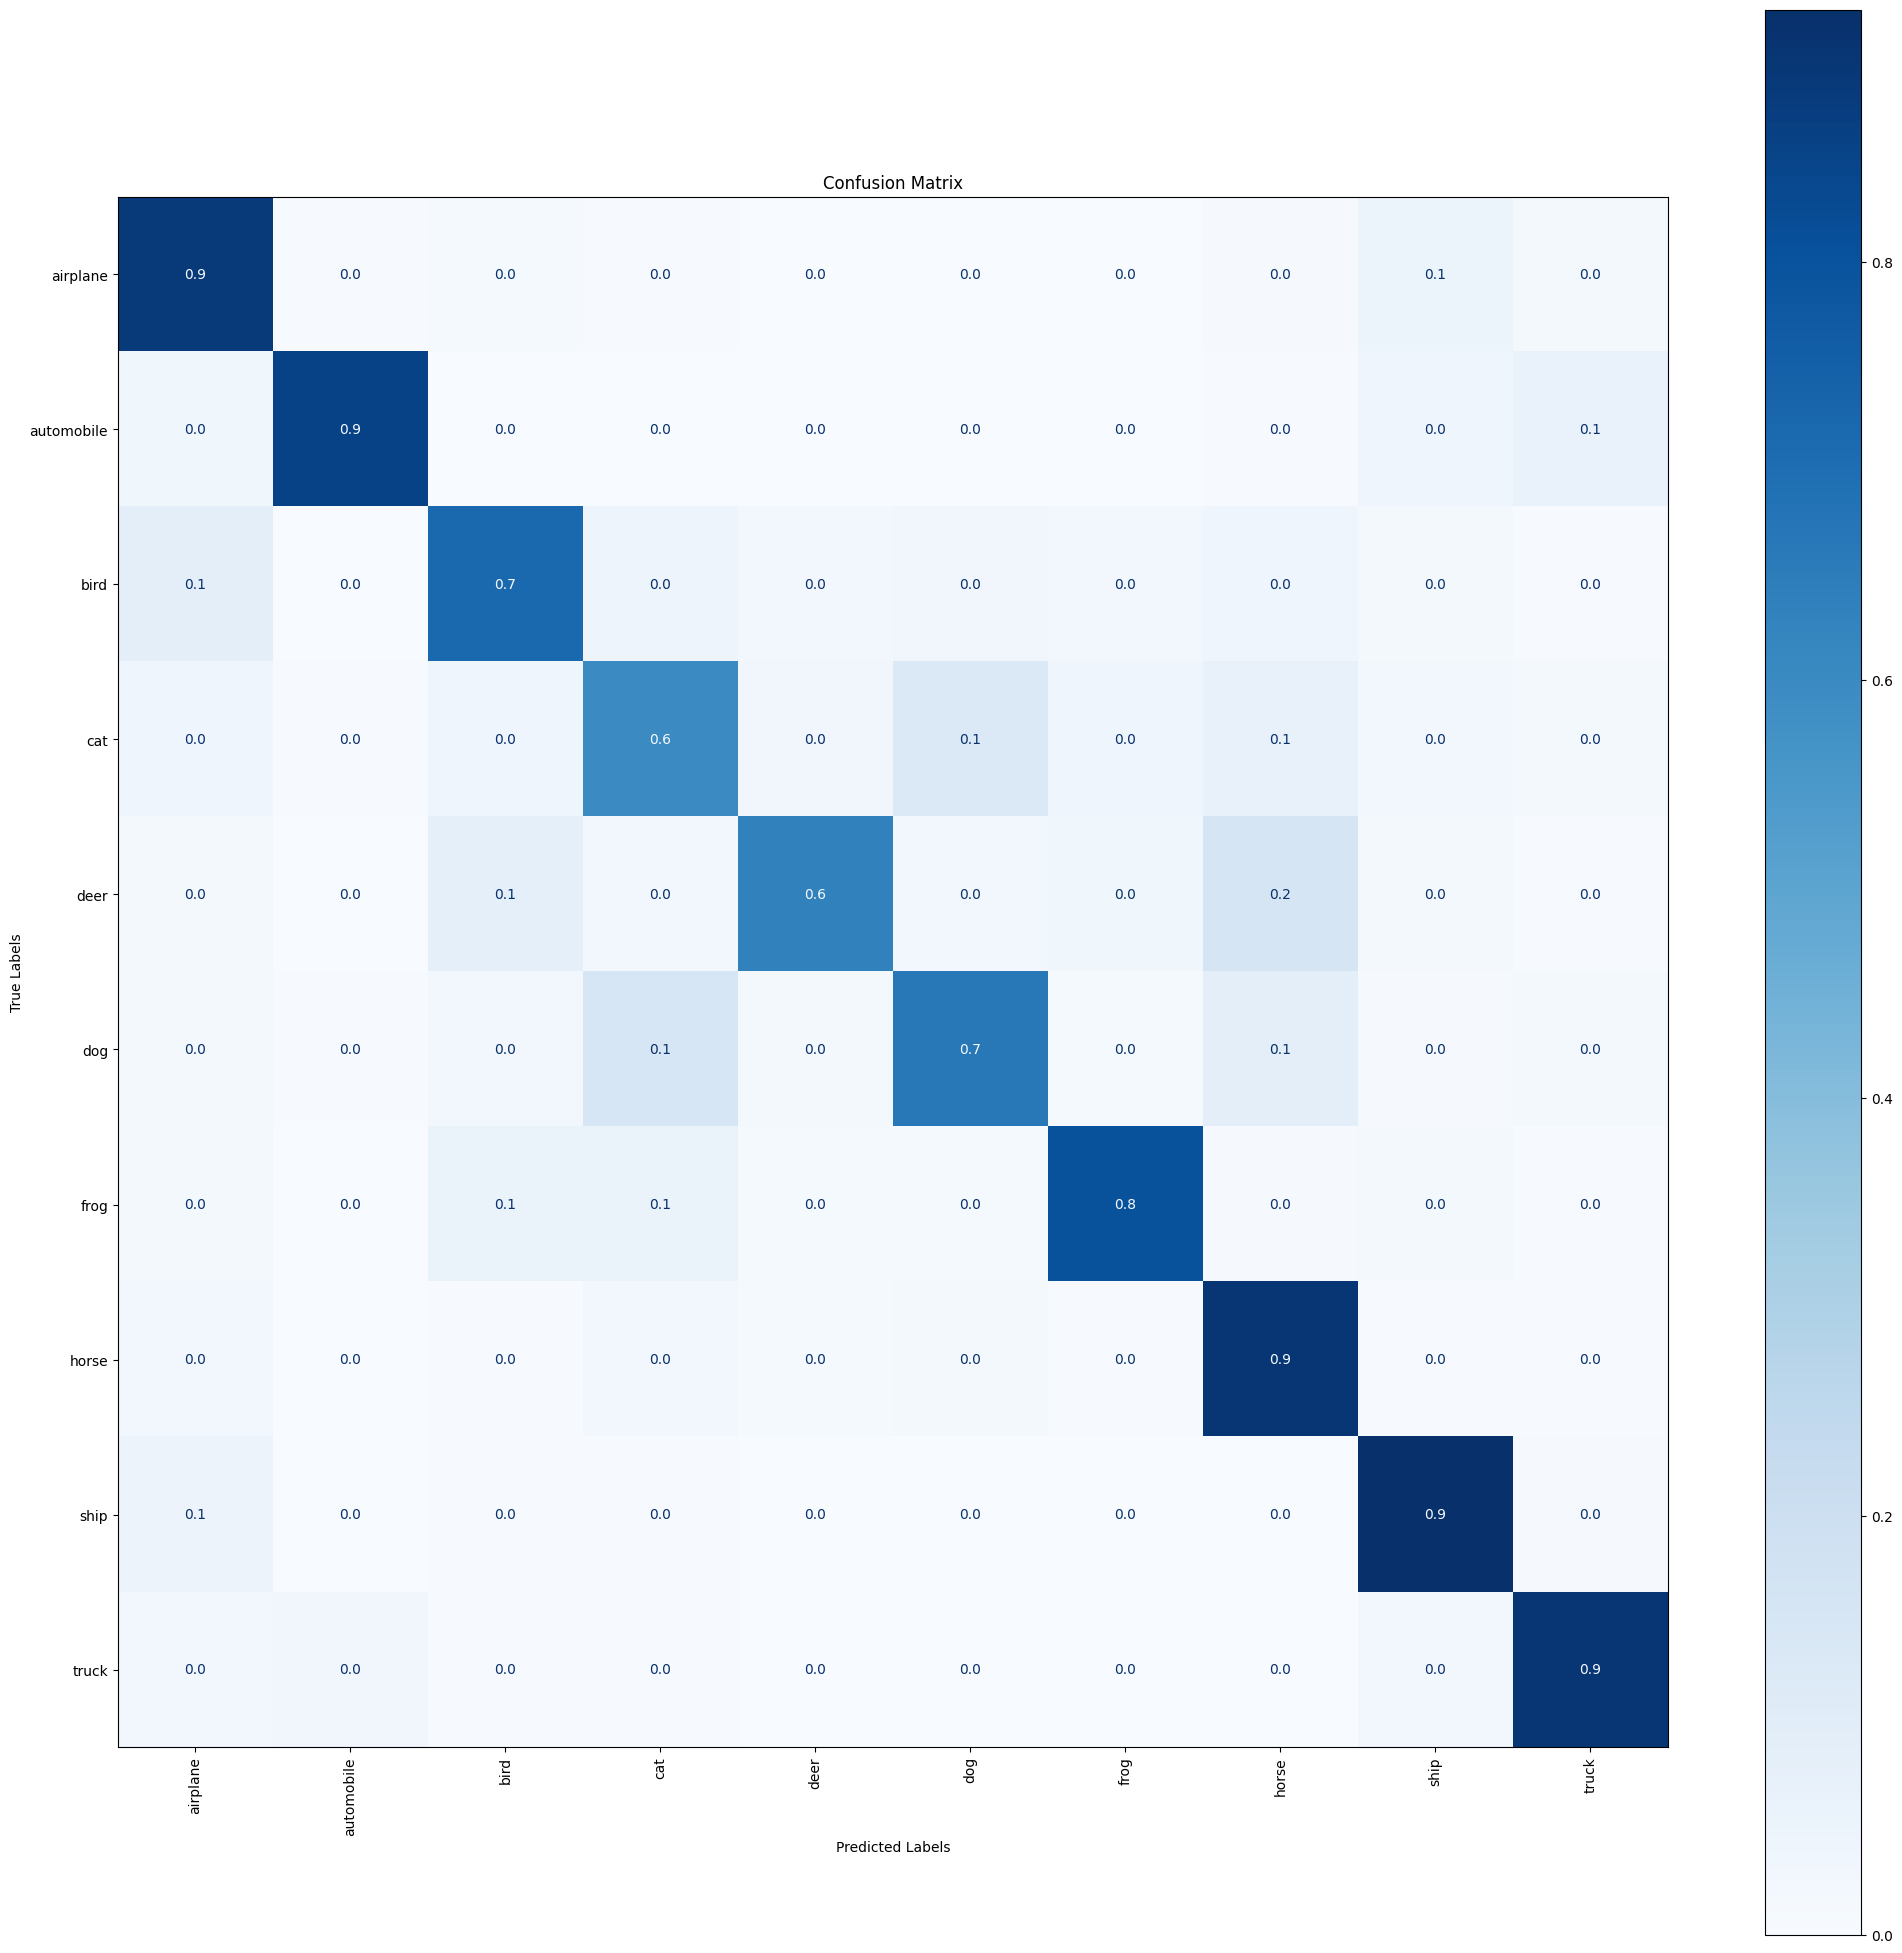

07/23 15:27:46 - mmengine - INFO - Epoch(val) [7][157/157]    accuracy/top1: 78.7200  accuracy/top5: 98.6800  loss/loss: 1.8853  data_time: 0.0100  time: 0.0889
07/23 15:27:46 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_6.pth is removed
07/23 15:27:46 - mmengine - INFO - The best checkpoint with 78.7200 accuracy/top1 at 7 epoch is saved to best_accuracy_top1_epoch_7.pth.
07/23 15:28:25 - mmengine - INFO - Epoch(train)  [8][100/782]  base_lr: 9.9101e-04 lr: 4.1441e-04  eta: 2:42:41  time: 0.3826  data_time: 0.0926  memory: 3611  grad_norm: 1.6963  loss: 0.9134
07/23 15:29:03 - mmengine - INFO - Epoch(train)  [8][200/782]  base_lr: 9.8990e-04 lr: 4.1396e-04  eta: 2:42:03  time: 0.3785  data_time: 0.0911  memory: 3611  grad_norm: 1.7792  loss: 0.9740
07/23 15:29:40 - mmengine - INFO - Epoch(train)  [8][300/782]  base_lr: 9.8873e-04 lr: 4.1347e-04  eta: 2:41:24  time: 0.

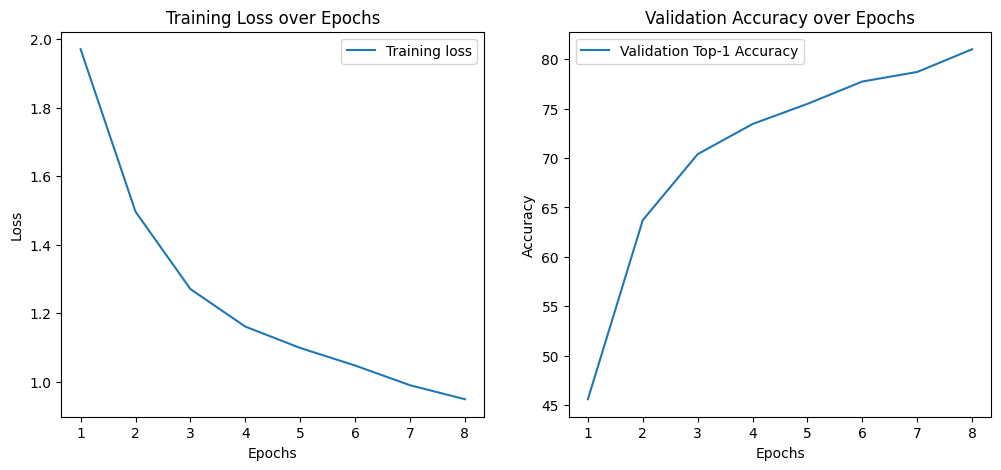

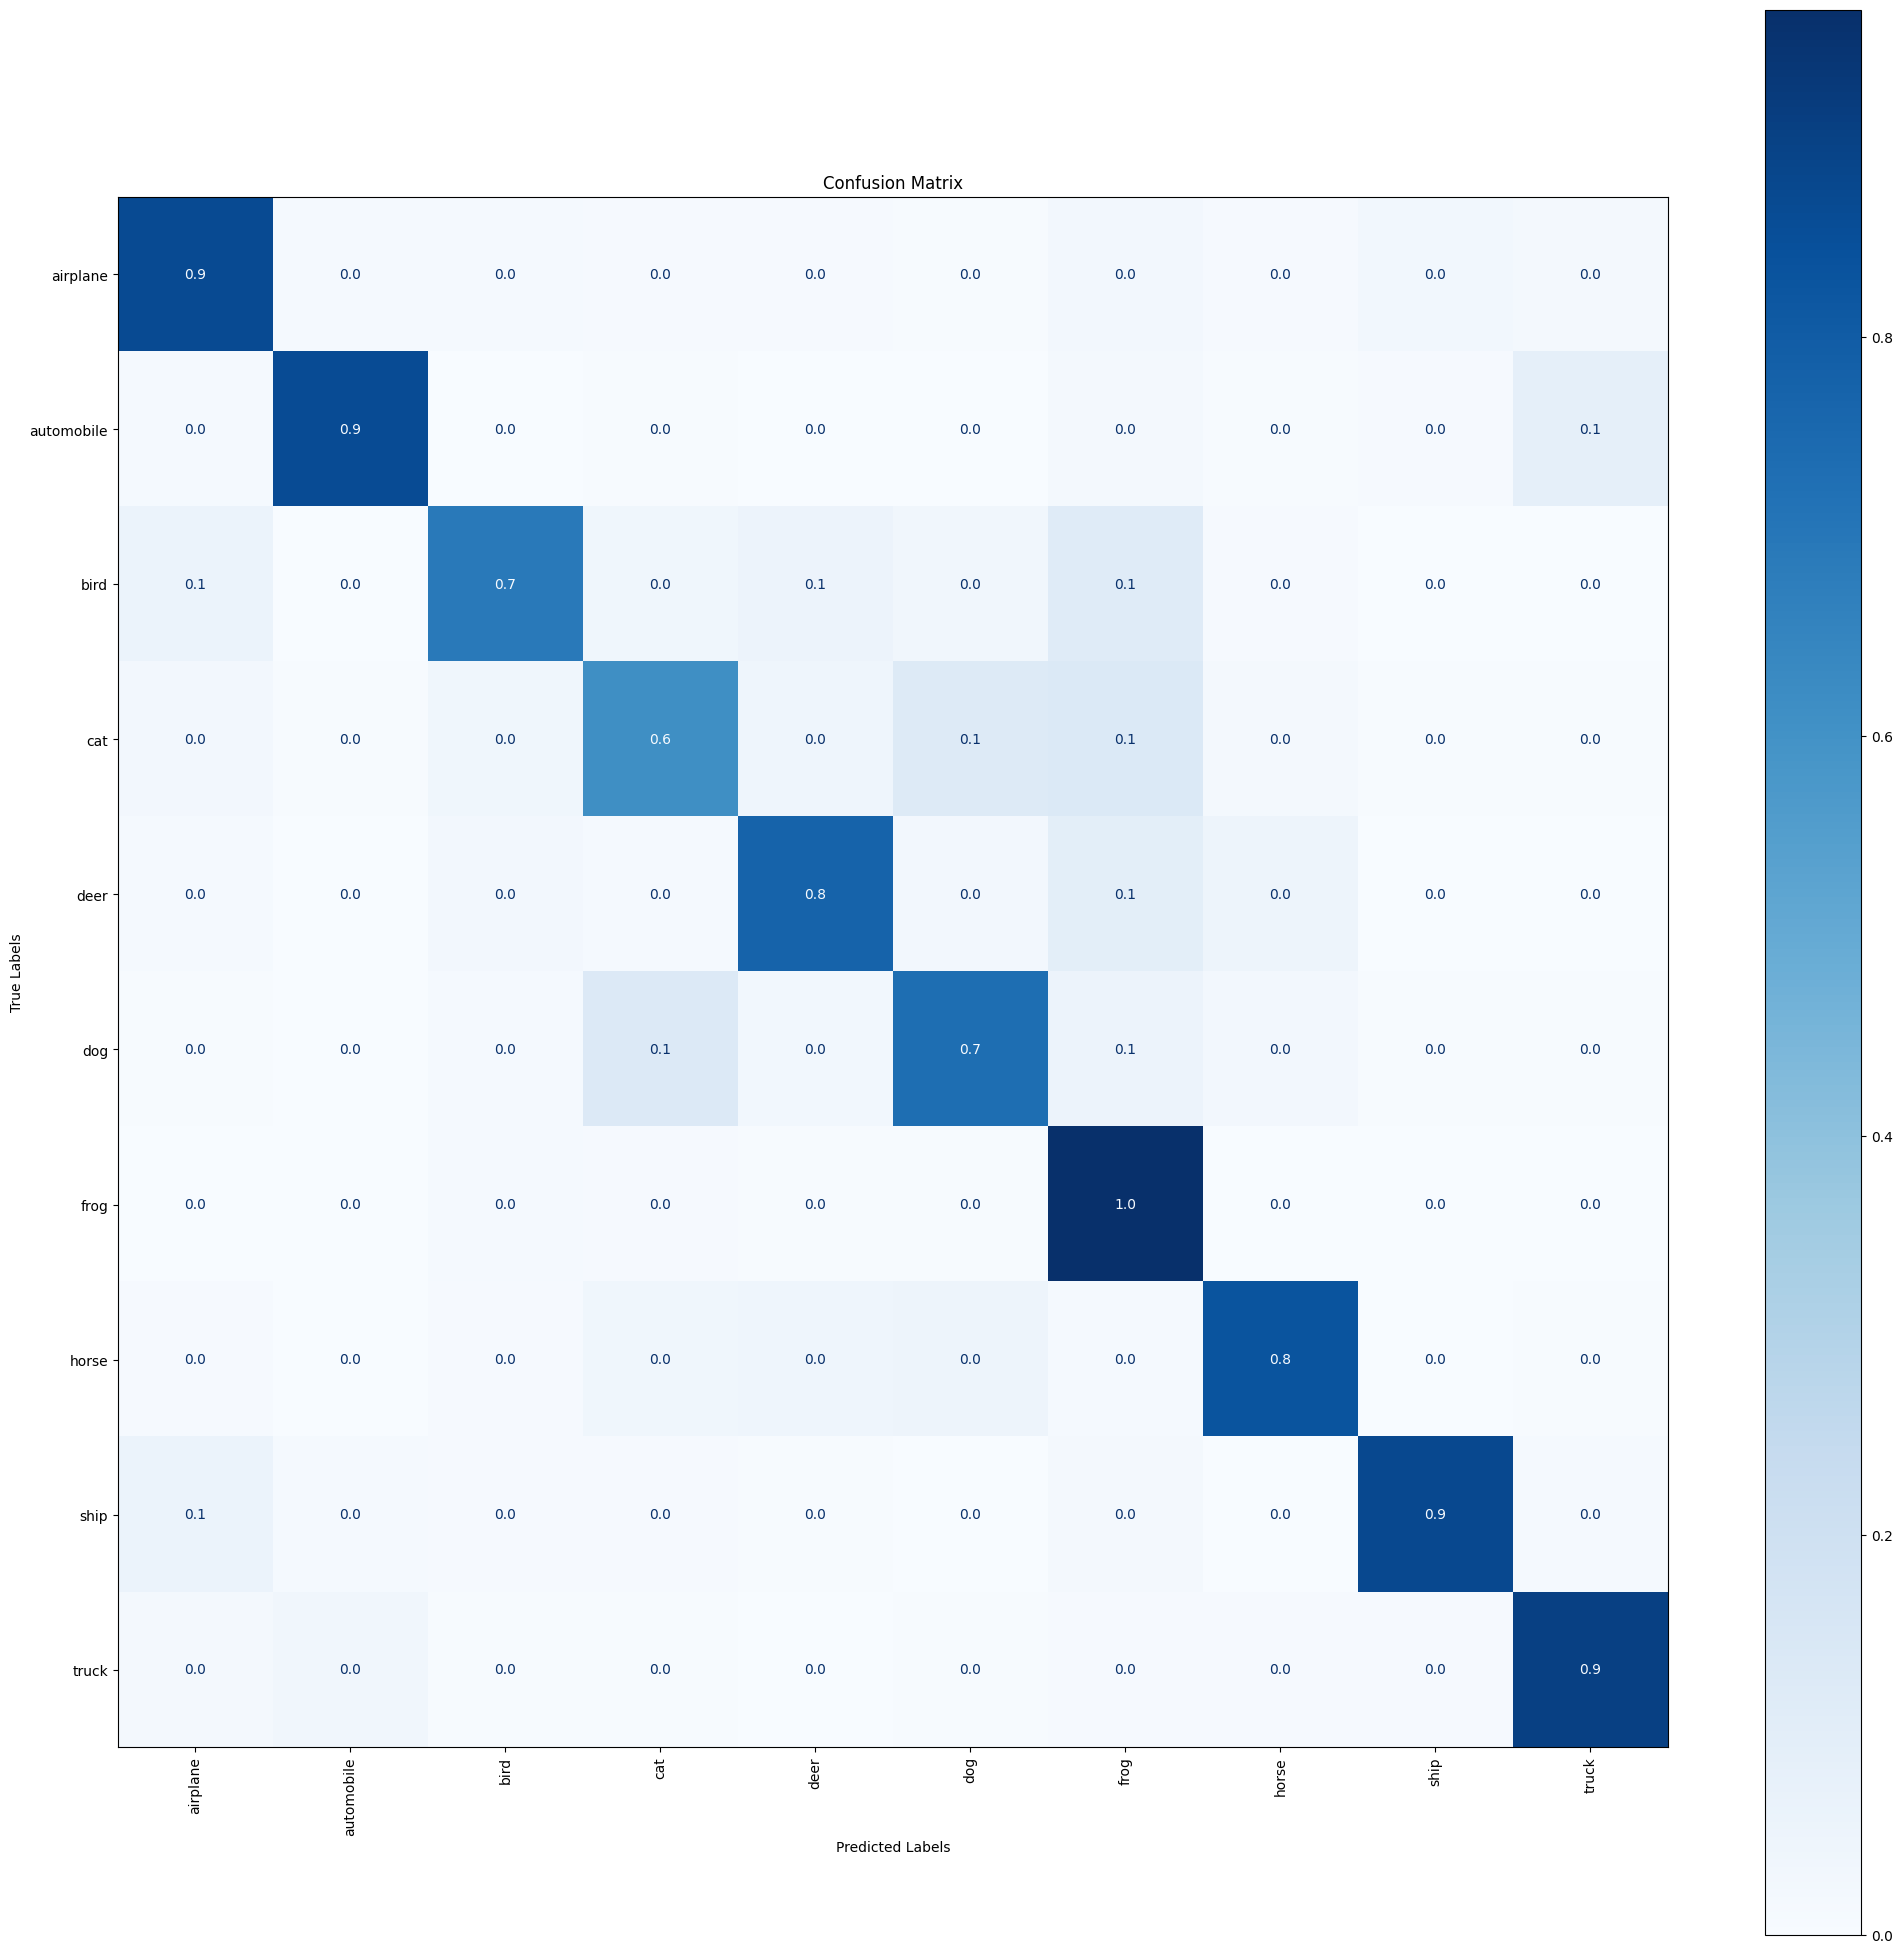

07/23 15:32:58 - mmengine - INFO - Epoch(val) [8][157/157]    accuracy/top1: 81.0200  accuracy/top5: 99.0100  loss/loss: 1.8693  data_time: 0.0101  time: 0.0898
07/23 15:32:58 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_7.pth is removed
07/23 15:32:59 - mmengine - INFO - The best checkpoint with 81.0200 accuracy/top1 at 8 epoch is saved to best_accuracy_top1_epoch_8.pth.
07/23 15:33:37 - mmengine - INFO - Epoch(train)  [9][100/782]  base_lr: 9.8063e-04 lr: 4.1014e-04  eta: 2:37:44  time: 0.3816  data_time: 0.0919  memory: 3611  grad_norm: 1.5397  loss: 0.8671
07/23 15:34:15 - mmengine - INFO - Epoch(train)  [9][200/782]  base_lr: 9.7903e-04 lr: 4.0948e-04  eta: 2:37:06  time: 0.3805  data_time: 0.0916  memory: 3611  grad_norm: 1.6685  loss: 0.9132
07/23 15:34:54 - mmengine - INFO - Epoch(train)  [9][300/782]  base_lr: 9.7736e-04 lr: 4.0879e-04  eta: 2:36:29  time: 0.

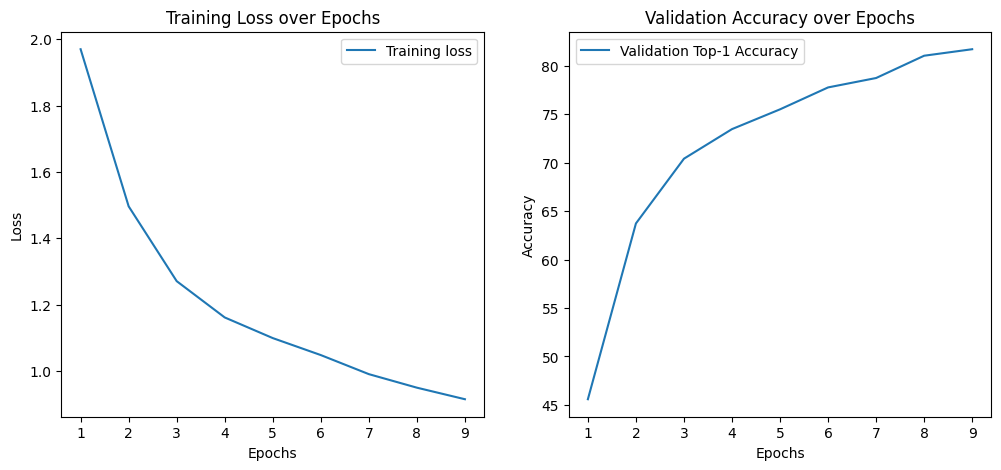

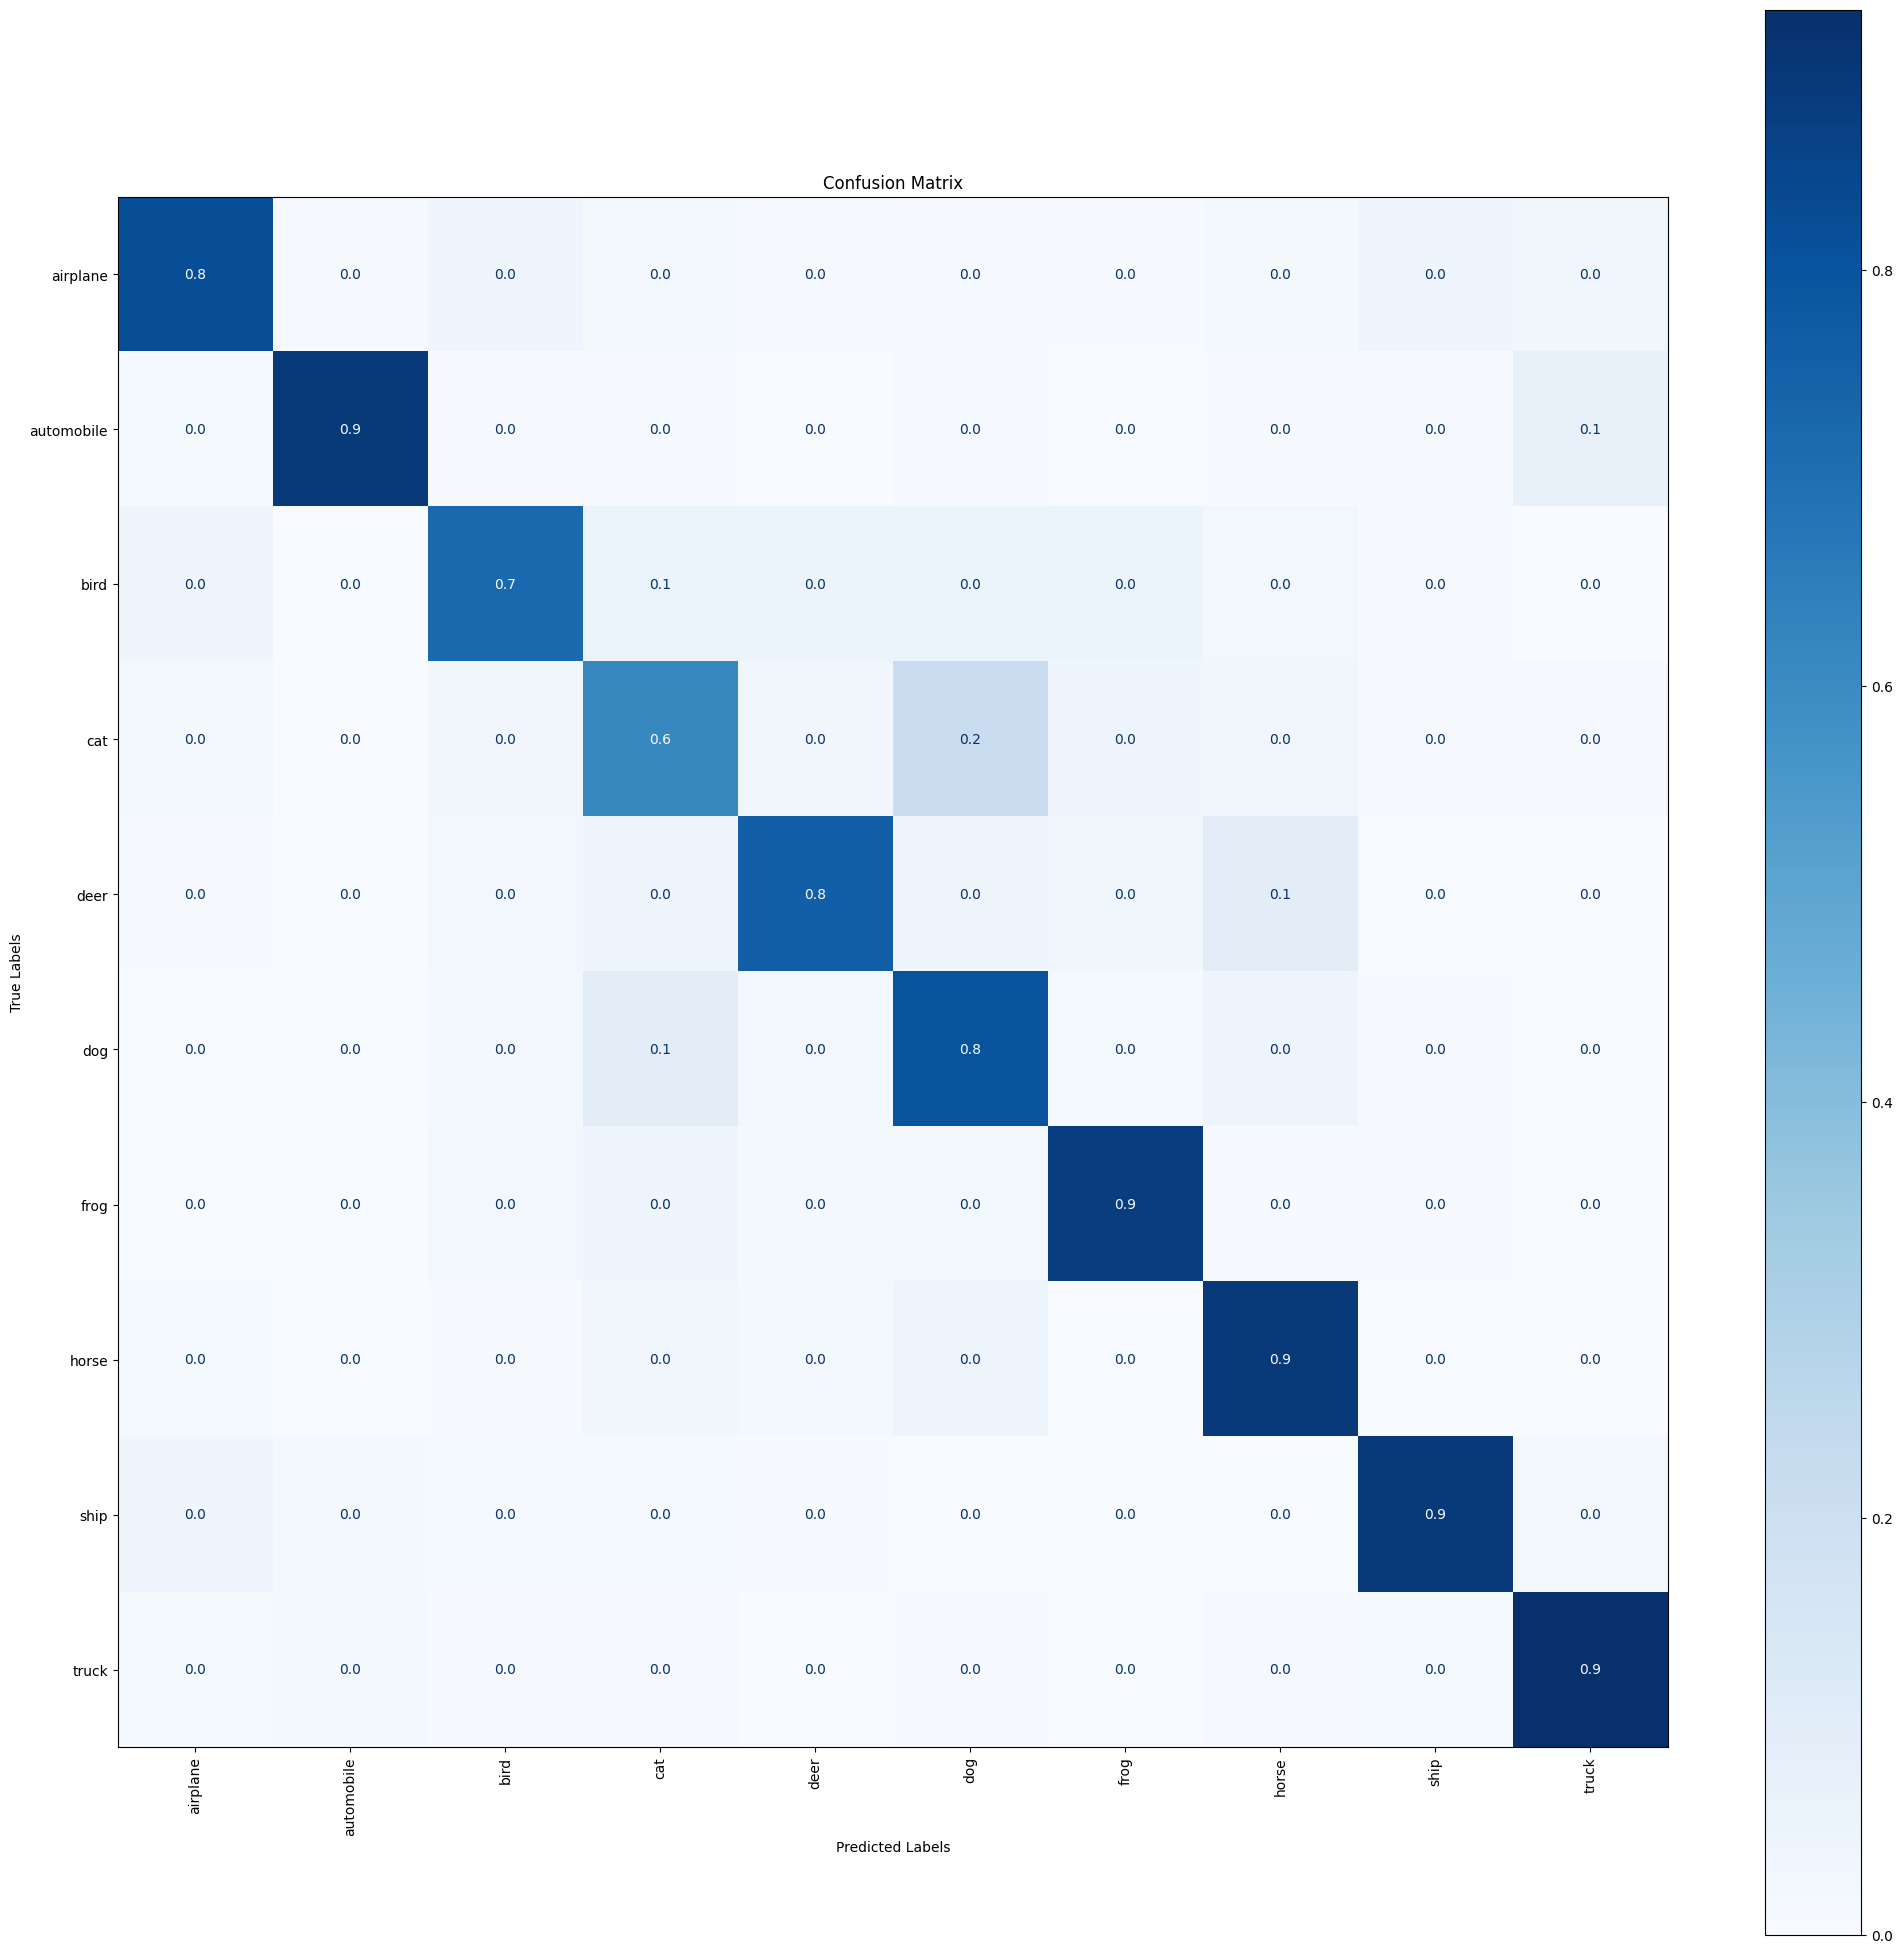

07/23 15:38:12 - mmengine - INFO - Epoch(val) [9][157/157]    accuracy/top1: 81.6900  accuracy/top5: 99.0000  loss/loss: 1.8560  data_time: 0.0100  time: 0.0896
07/23 15:38:12 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_8.pth is removed
07/23 15:38:12 - mmengine - INFO - The best checkpoint with 81.6900 accuracy/top1 at 9 epoch is saved to best_accuracy_top1_epoch_9.pth.
07/23 15:38:51 - mmengine - INFO - Epoch(train) [10][100/782]  base_lr: 9.6643e-04 lr: 4.0428e-04  eta: 2:32:50  time: 0.3825  data_time: 0.0923  memory: 3611  grad_norm: 1.6484  loss: 0.9005
07/23 15:39:29 - mmengine - INFO - Epoch(train) [10][200/782]  base_lr: 9.6434e-04 lr: 4.0342e-04  eta: 2:32:13  time: 0.3811  data_time: 0.0917  memory: 3611  grad_norm: 1.5891  loss: 0.8589
07/23 15:40:08 - mmengine - INFO - Epoch(train) [10][300/782]  base_lr: 9.6220e-04 lr: 4.0254e-04  eta: 2:31:37  time: 0.

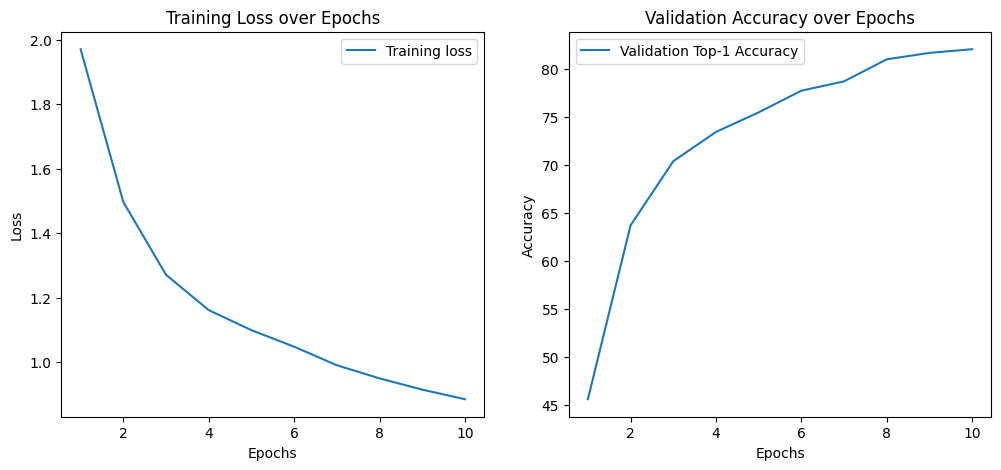

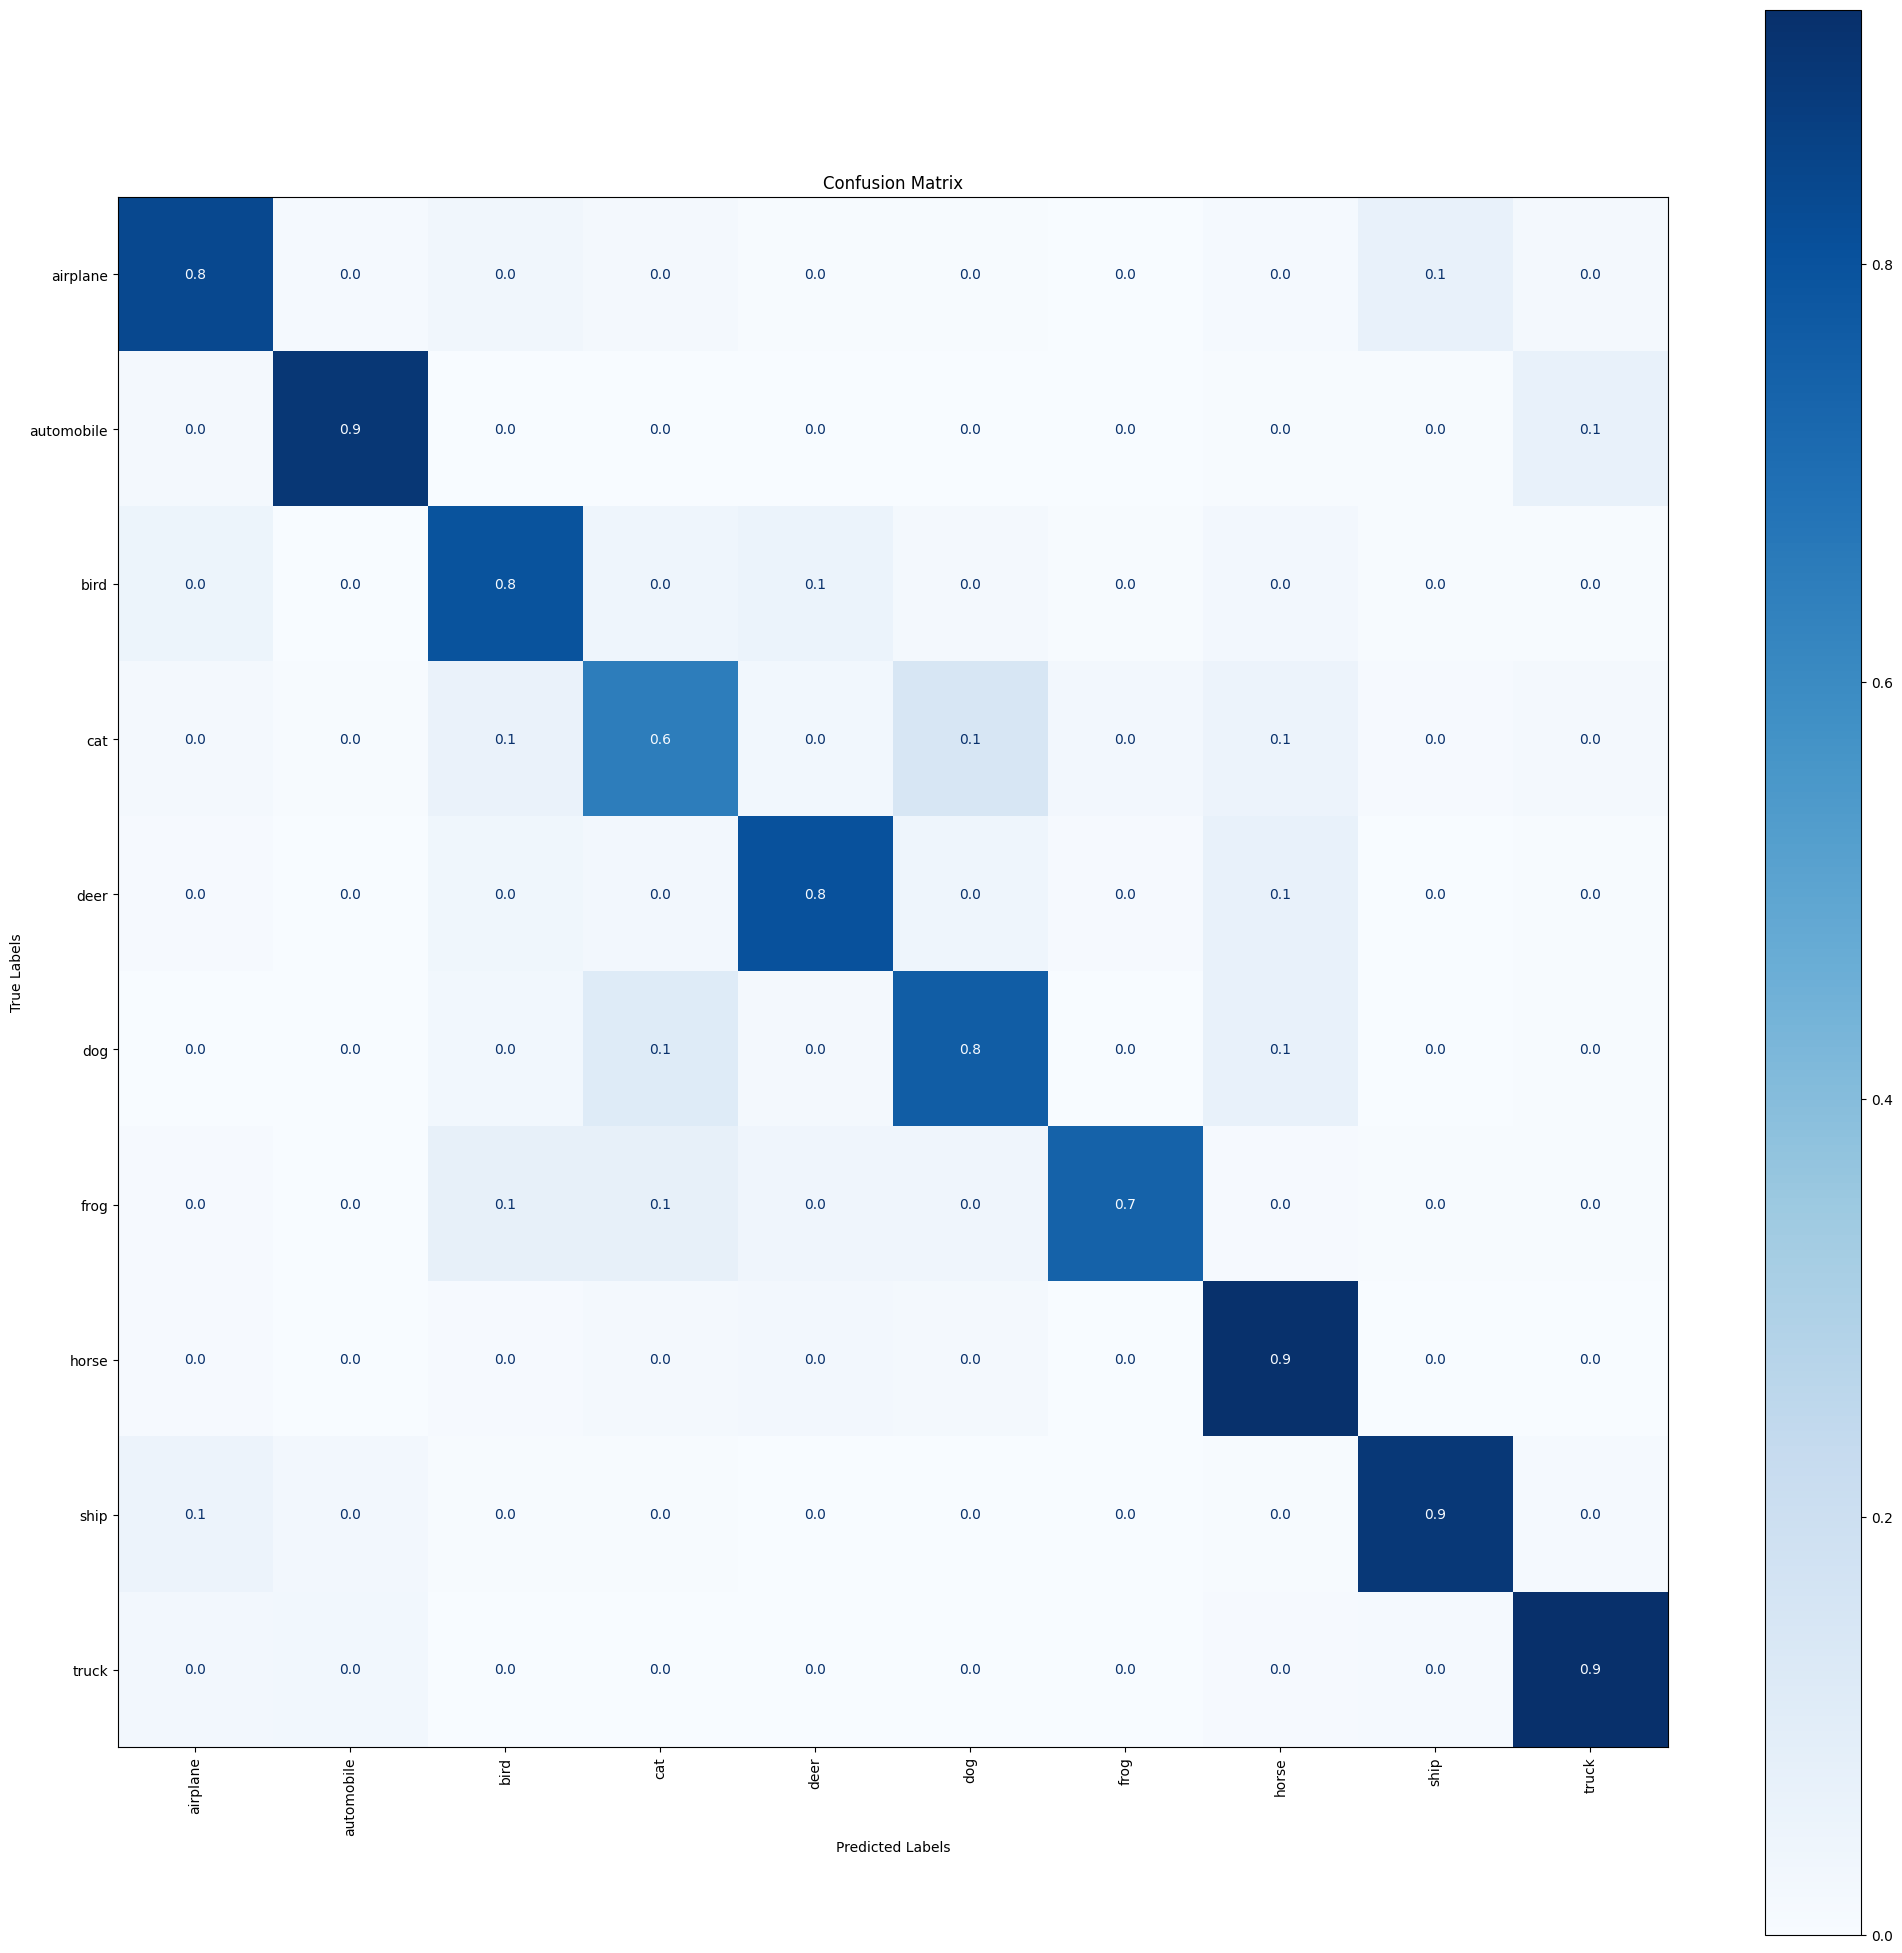

07/23 15:43:28 - mmengine - INFO - Epoch(val) [10][157/157]    accuracy/top1: 82.0700  accuracy/top5: 99.0800  loss/loss: 1.8450  data_time: 0.0099  time: 0.0904
07/23 15:43:28 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_9.pth is removed
07/23 15:43:28 - mmengine - INFO - The best checkpoint with 82.0700 accuracy/top1 at 10 epoch is saved to best_accuracy_top1_epoch_10.pth.
07/23 15:44:08 - mmengine - INFO - Epoch(train) [11][100/782]  base_lr: 9.4851e-04 lr: 3.9689e-04  eta: 2:28:06  time: 0.3874  data_time: 0.0940  memory: 3611  grad_norm: 1.6978  loss: 0.8815
07/23 15:44:39 - mmengine - INFO - Exp name: 20240723_145117
07/23 15:44:47 - mmengine - INFO - Epoch(train) [11][200/782]  base_lr: 9.4596e-04 lr: 3.9584e-04  eta: 2:27:30  time: 0.3804  data_time: 0.0920  memory: 3611  grad_norm: 1.5737  loss: 0.8515
07/23 15:45:26 - mmengine - INFO - Epoch(train) [11][300/

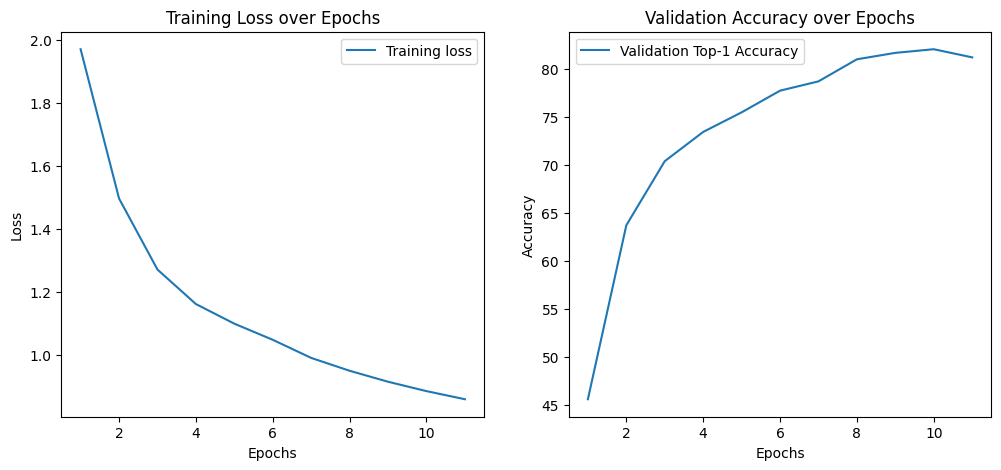

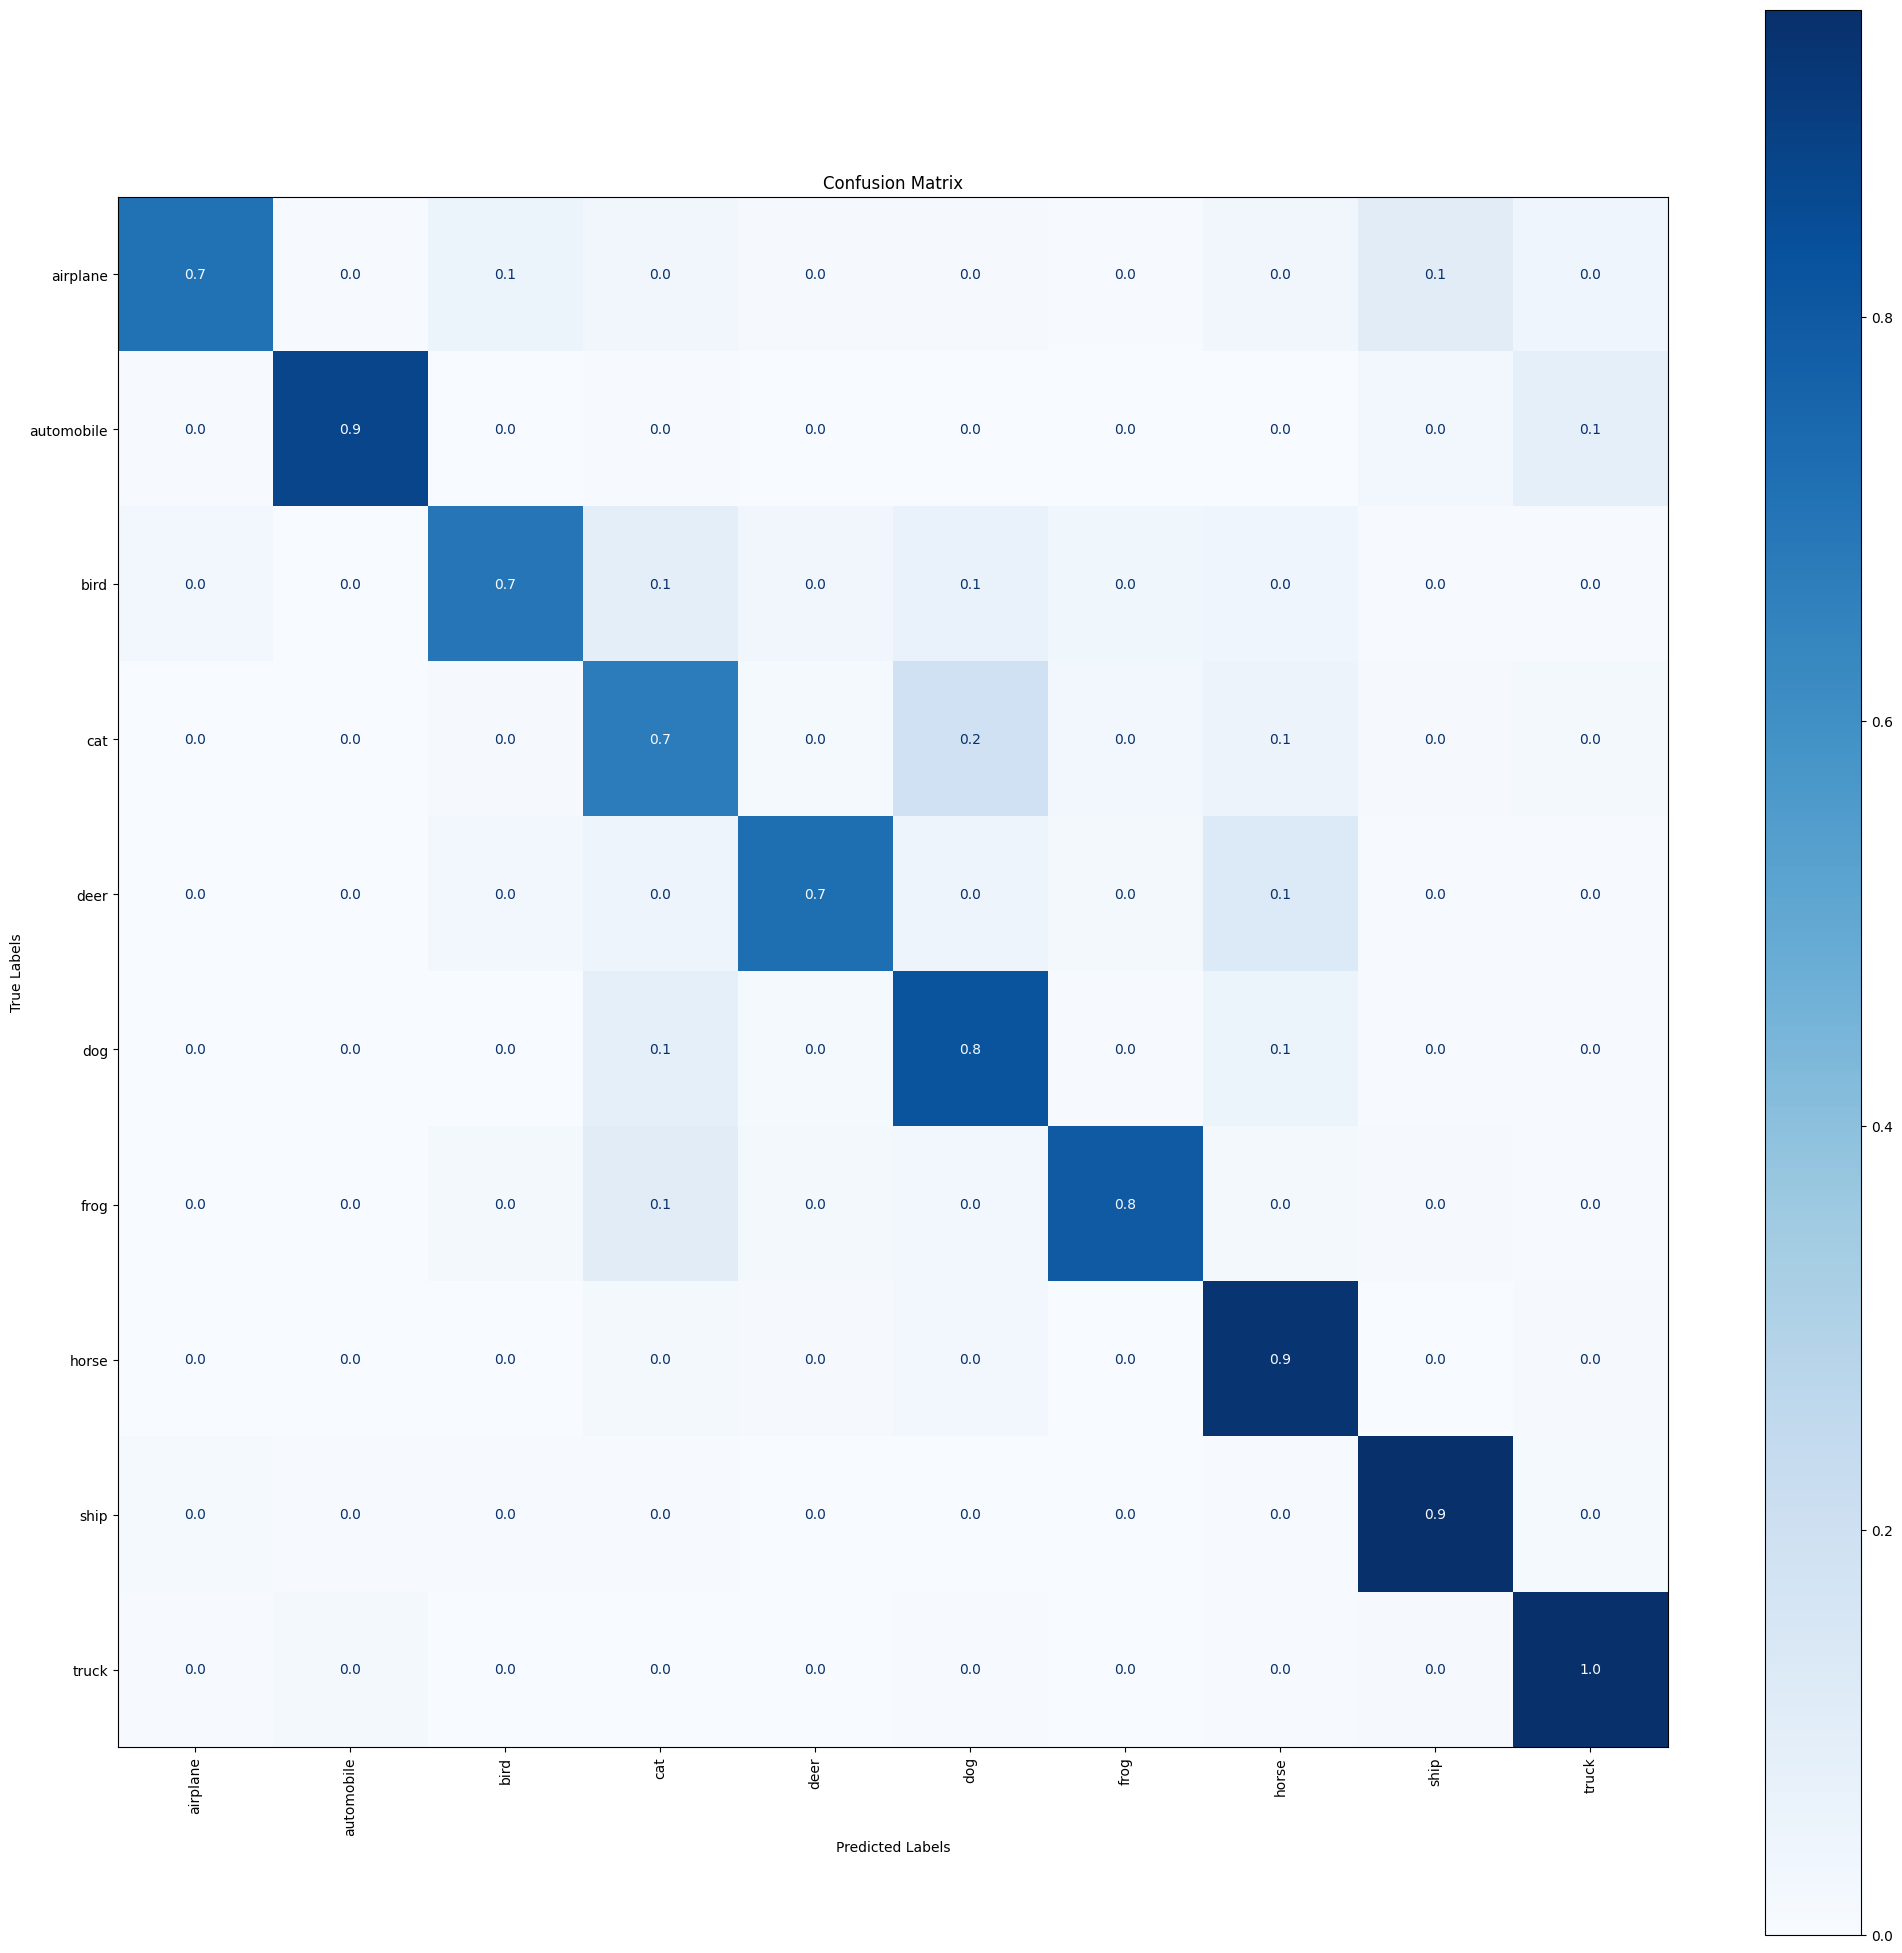

07/23 15:48:46 - mmengine - INFO - Epoch(val) [11][157/157]    accuracy/top1: 81.2200  accuracy/top5: 99.0300  loss/loss: 1.8075  data_time: 0.0101  time: 0.0897
07/23 15:49:24 - mmengine - INFO - Epoch(train) [12][100/782]  base_lr: 9.2702e-04 lr: 3.8803e-04  eta: 2:23:17  time: 0.3806  data_time: 0.0916  memory: 3611  grad_norm: 1.5425  loss: 0.8011
07/23 15:50:02 - mmengine - INFO - Epoch(train) [12][200/782]  base_lr: 9.2402e-04 lr: 3.8680e-04  eta: 2:22:39  time: 0.3809  data_time: 0.0919  memory: 3611  grad_norm: 1.5573  loss: 0.8624
07/23 15:50:41 - mmengine - INFO - Epoch(train) [12][300/782]  base_lr: 9.2097e-04 lr: 3.8554e-04  eta: 2:22:02  time: 0.3818  data_time: 0.0921  memory: 3611  grad_norm: 1.6741  loss: 0.8480
07/23 15:51:18 - mmengine - INFO - Exp name: 20240723_145117
07/23 15:51:19 - mmengine - INFO - Epoch(train) [12][400/782]  base_lr: 9.1786e-04 lr: 3.8426e-04  eta: 2:21:24  time: 0.3831  data_time: 0.0925  memory: 3611  grad_norm: 1.4215  loss: 0.8084
07/23 15:

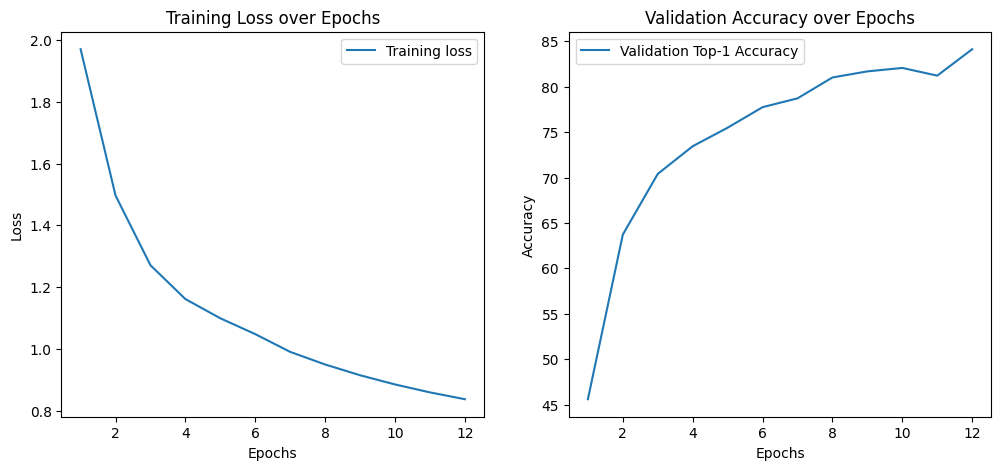

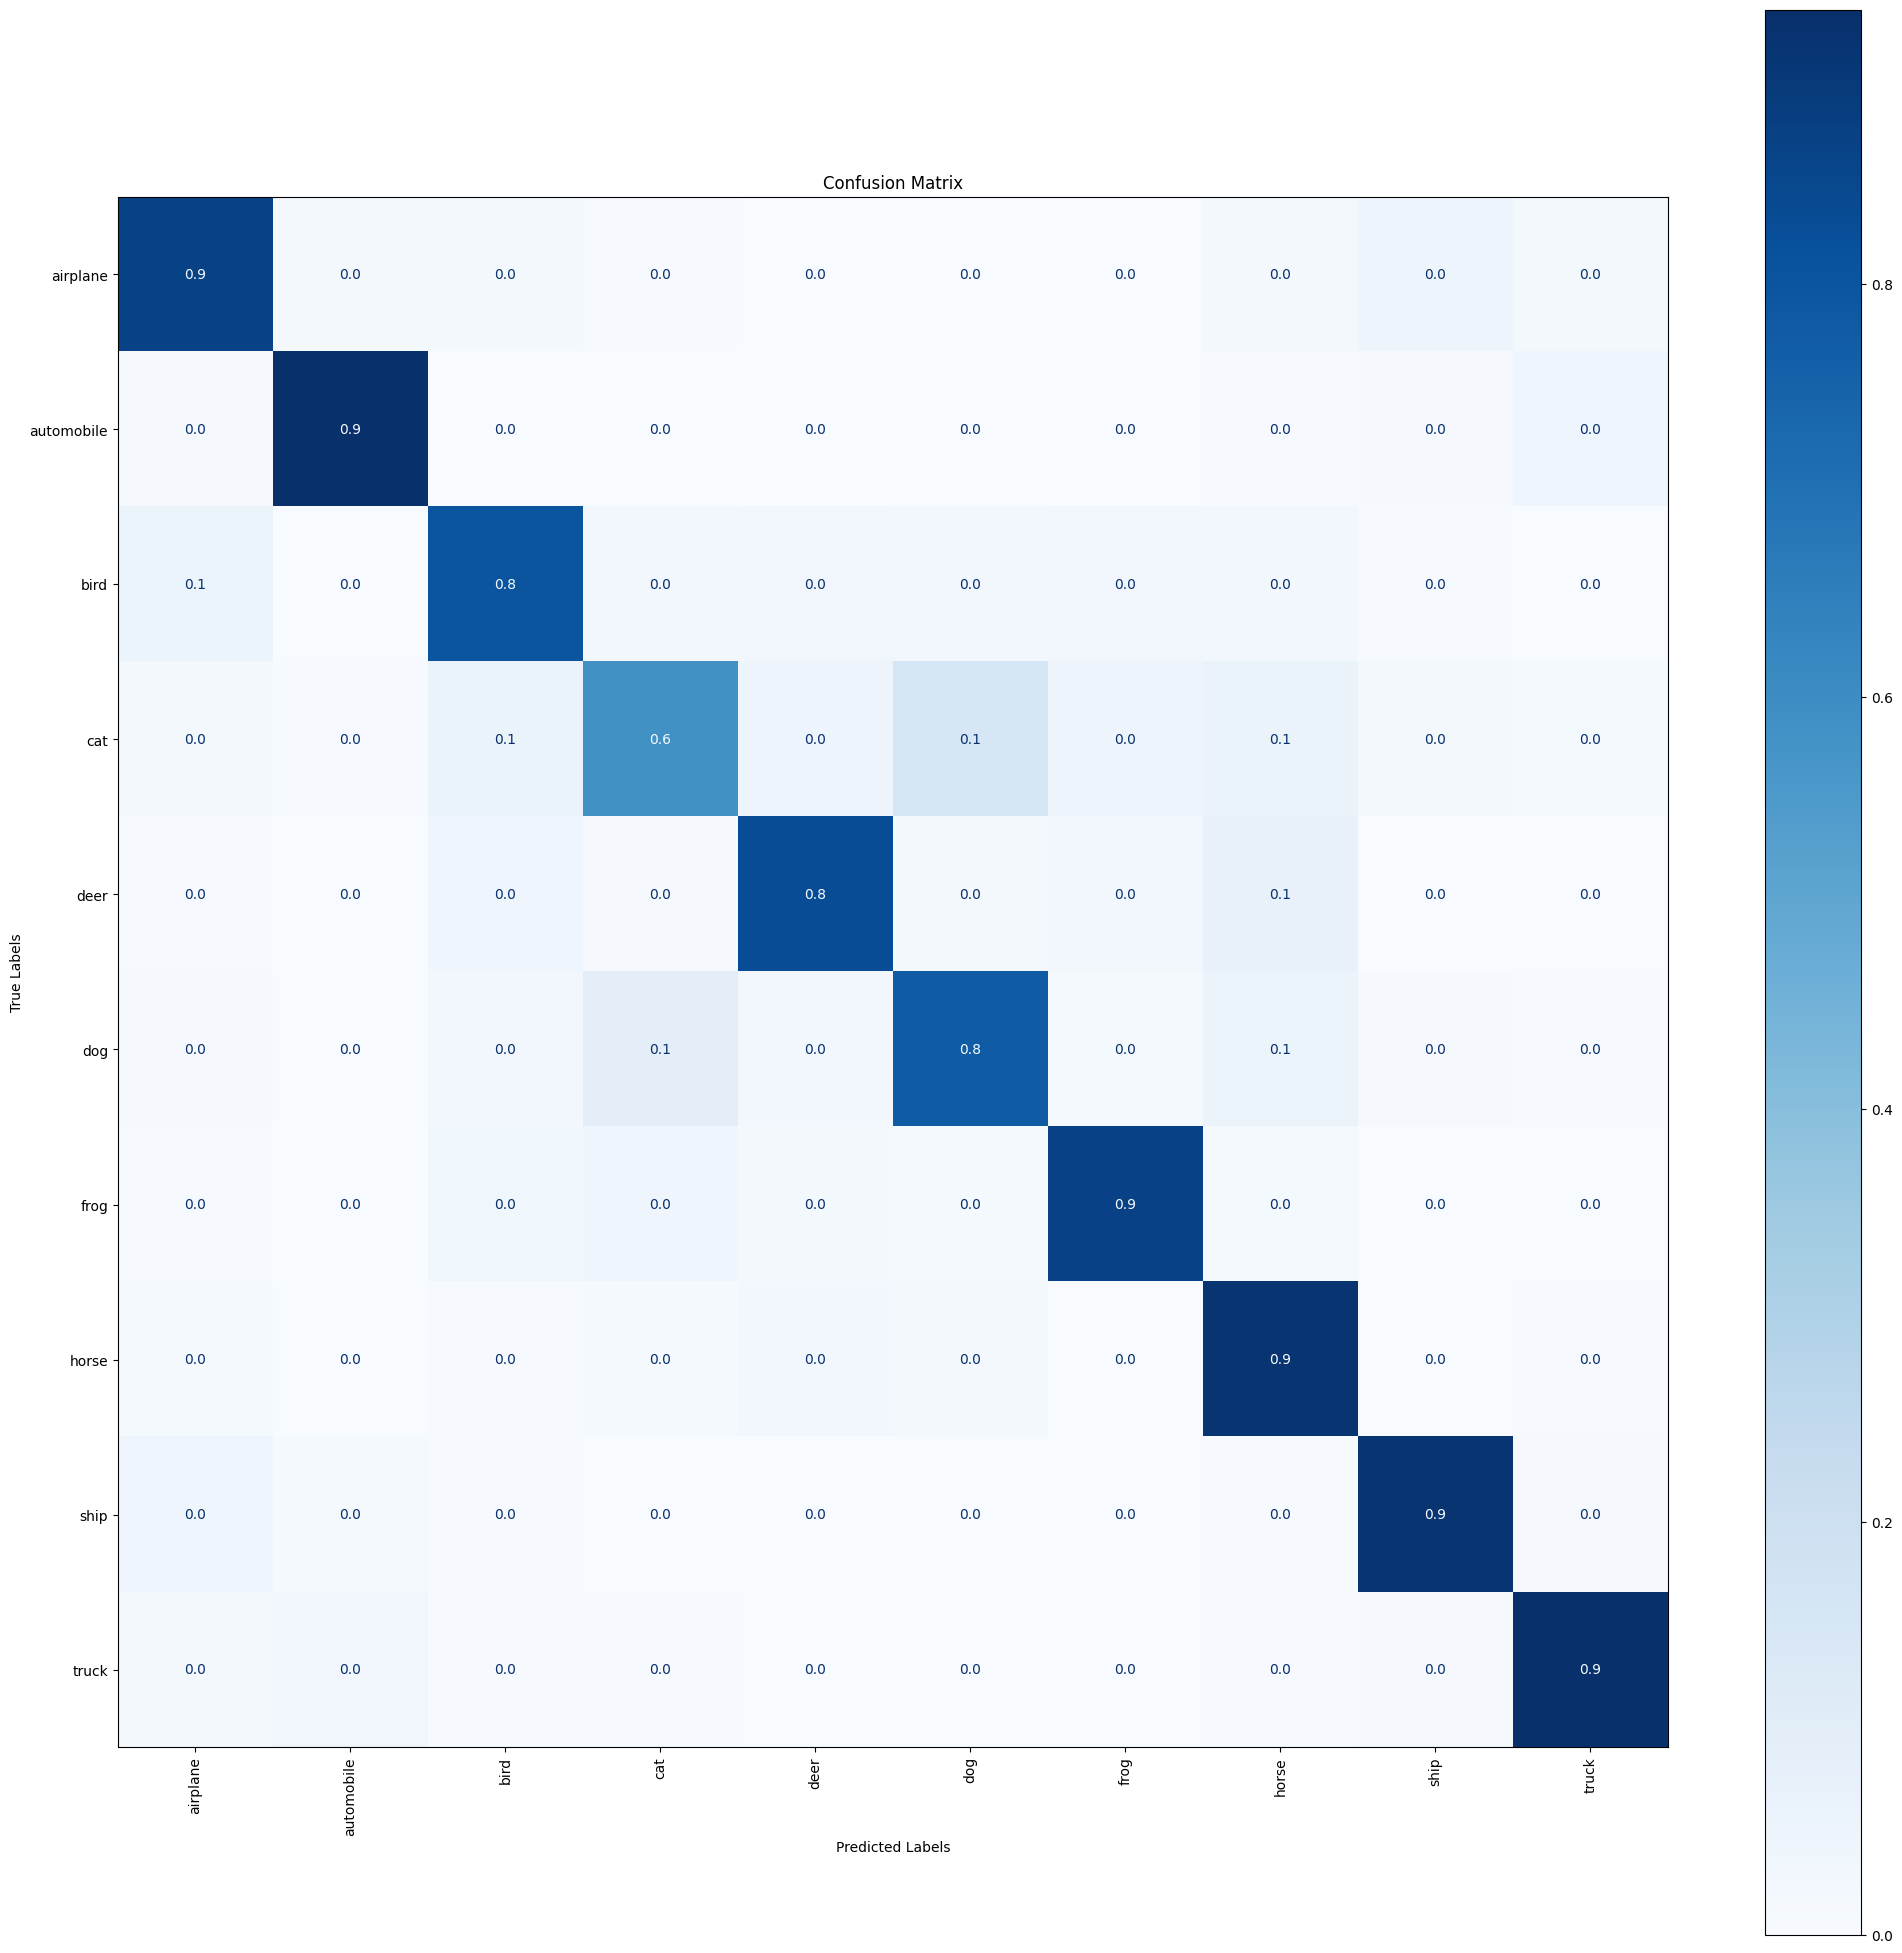

07/23 15:53:59 - mmengine - INFO - Epoch(val) [12][157/157]    accuracy/top1: 84.1300  accuracy/top5: 99.1900  loss/loss: 1.7831  data_time: 0.0100  time: 0.0896
07/23 15:53:59 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_10.pth is removed
07/23 15:54:00 - mmengine - INFO - The best checkpoint with 84.1300 accuracy/top1 at 12 epoch is saved to best_accuracy_top1_epoch_12.pth.
07/23 15:54:38 - mmengine - INFO - Epoch(train) [13][100/782]  base_lr: 9.0213e-04 lr: 3.7777e-04  eta: 2:18:20  time: 0.3811  data_time: 0.0914  memory: 3611  grad_norm: 1.6273  loss: 0.8106
07/23 15:55:16 - mmengine - INFO - Epoch(train) [13][200/782]  base_lr: 8.9871e-04 lr: 3.7637e-04  eta: 2:17:42  time: 0.3806  data_time: 0.0914  memory: 3611  grad_norm: 1.5624  loss: 0.8018
07/23 15:55:54 - mmengine - INFO - Epoch(train) [13][300/782]  base_lr: 8.9524e-04 lr: 3.7494e-04  eta: 2:17:05  time

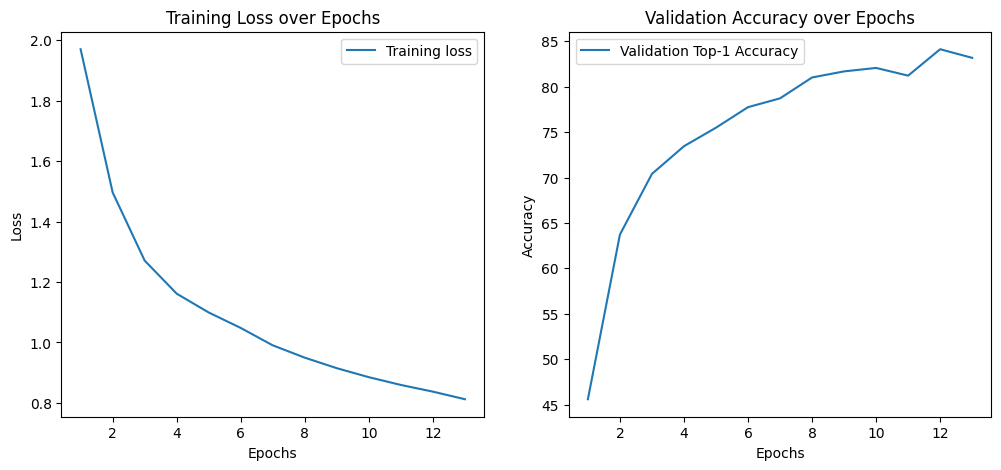

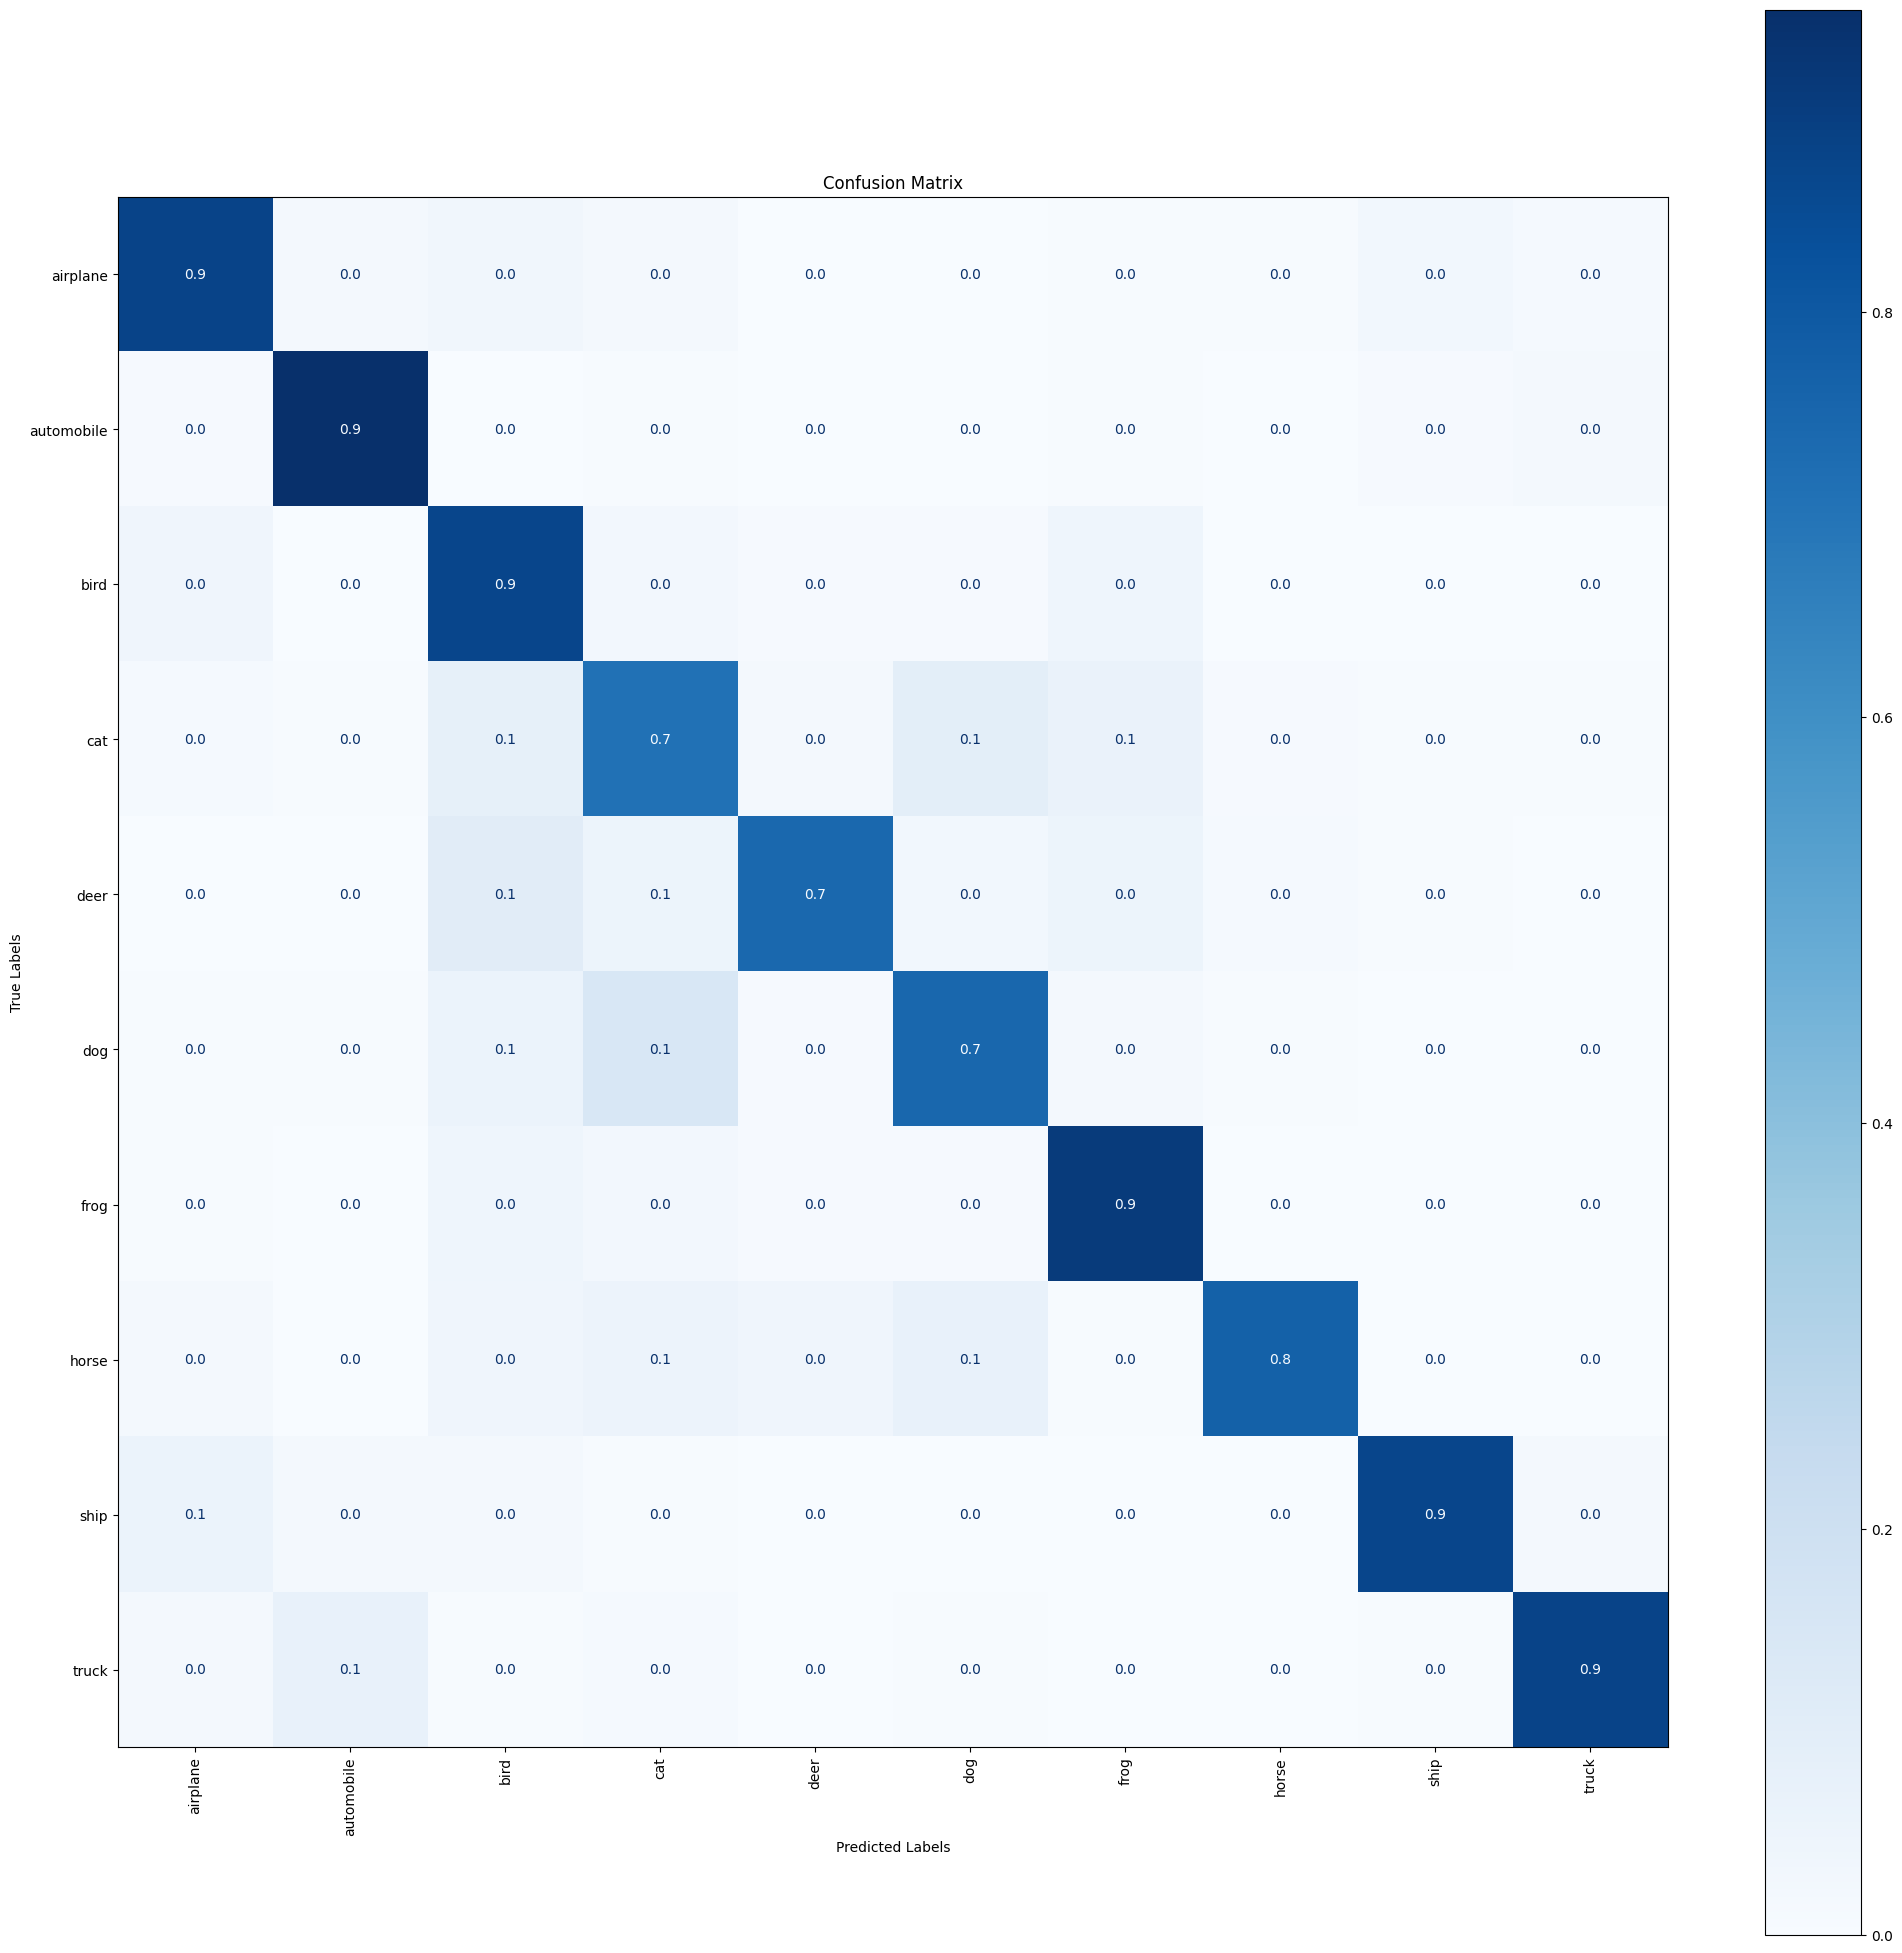

07/23 15:59:15 - mmengine - INFO - Epoch(val) [13][157/157]    accuracy/top1: 83.1800  accuracy/top5: 99.0400  loss/loss: 1.7676  data_time: 0.0099  time: 0.0892
07/23 15:59:53 - mmengine - INFO - Epoch(train) [14][100/782]  base_lr: 8.7405e-04 lr: 3.6620e-04  eta: 2:13:27  time: 0.3799  data_time: 0.0915  memory: 3611  grad_norm: 1.6327  loss: 0.7579
07/23 16:00:32 - mmengine - INFO - Epoch(train) [14][200/782]  base_lr: 8.7023e-04 lr: 3.6463e-04  eta: 2:12:51  time: 0.3835  data_time: 0.0919  memory: 3611  grad_norm: 1.3844  loss: 0.7731
07/23 16:01:11 - mmengine - INFO - Epoch(train) [14][300/782]  base_lr: 8.6638e-04 lr: 3.6303e-04  eta: 2:12:15  time: 0.3789  data_time: 0.0913  memory: 3611  grad_norm: 1.5252  loss: 0.7980
07/23 16:01:50 - mmengine - INFO - Epoch(train) [14][400/782]  base_lr: 8.6247e-04 lr: 3.6142e-04  eta: 2:11:38  time: 0.3831  data_time: 0.0918  memory: 3611  grad_norm: 1.5012  loss: 0.7658
07/23 16:02:30 - mmengine - INFO - Epoch(train) [14][500/782]  base_lr

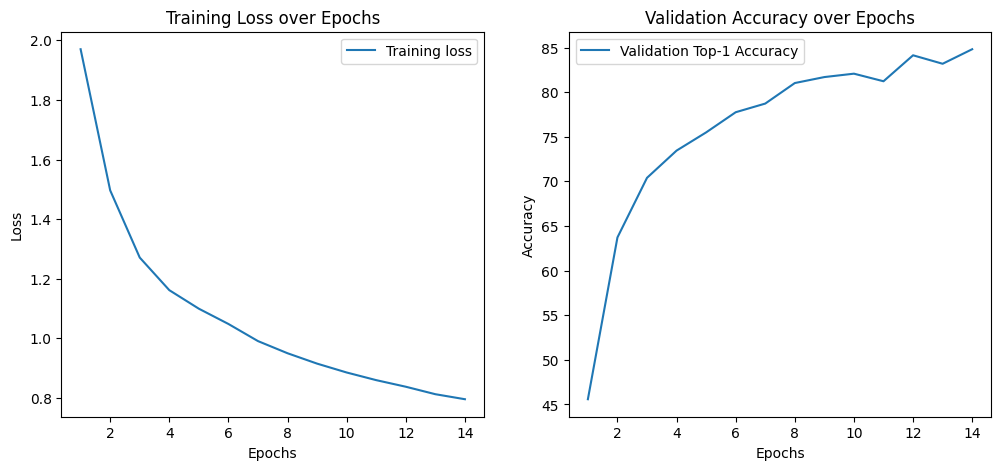

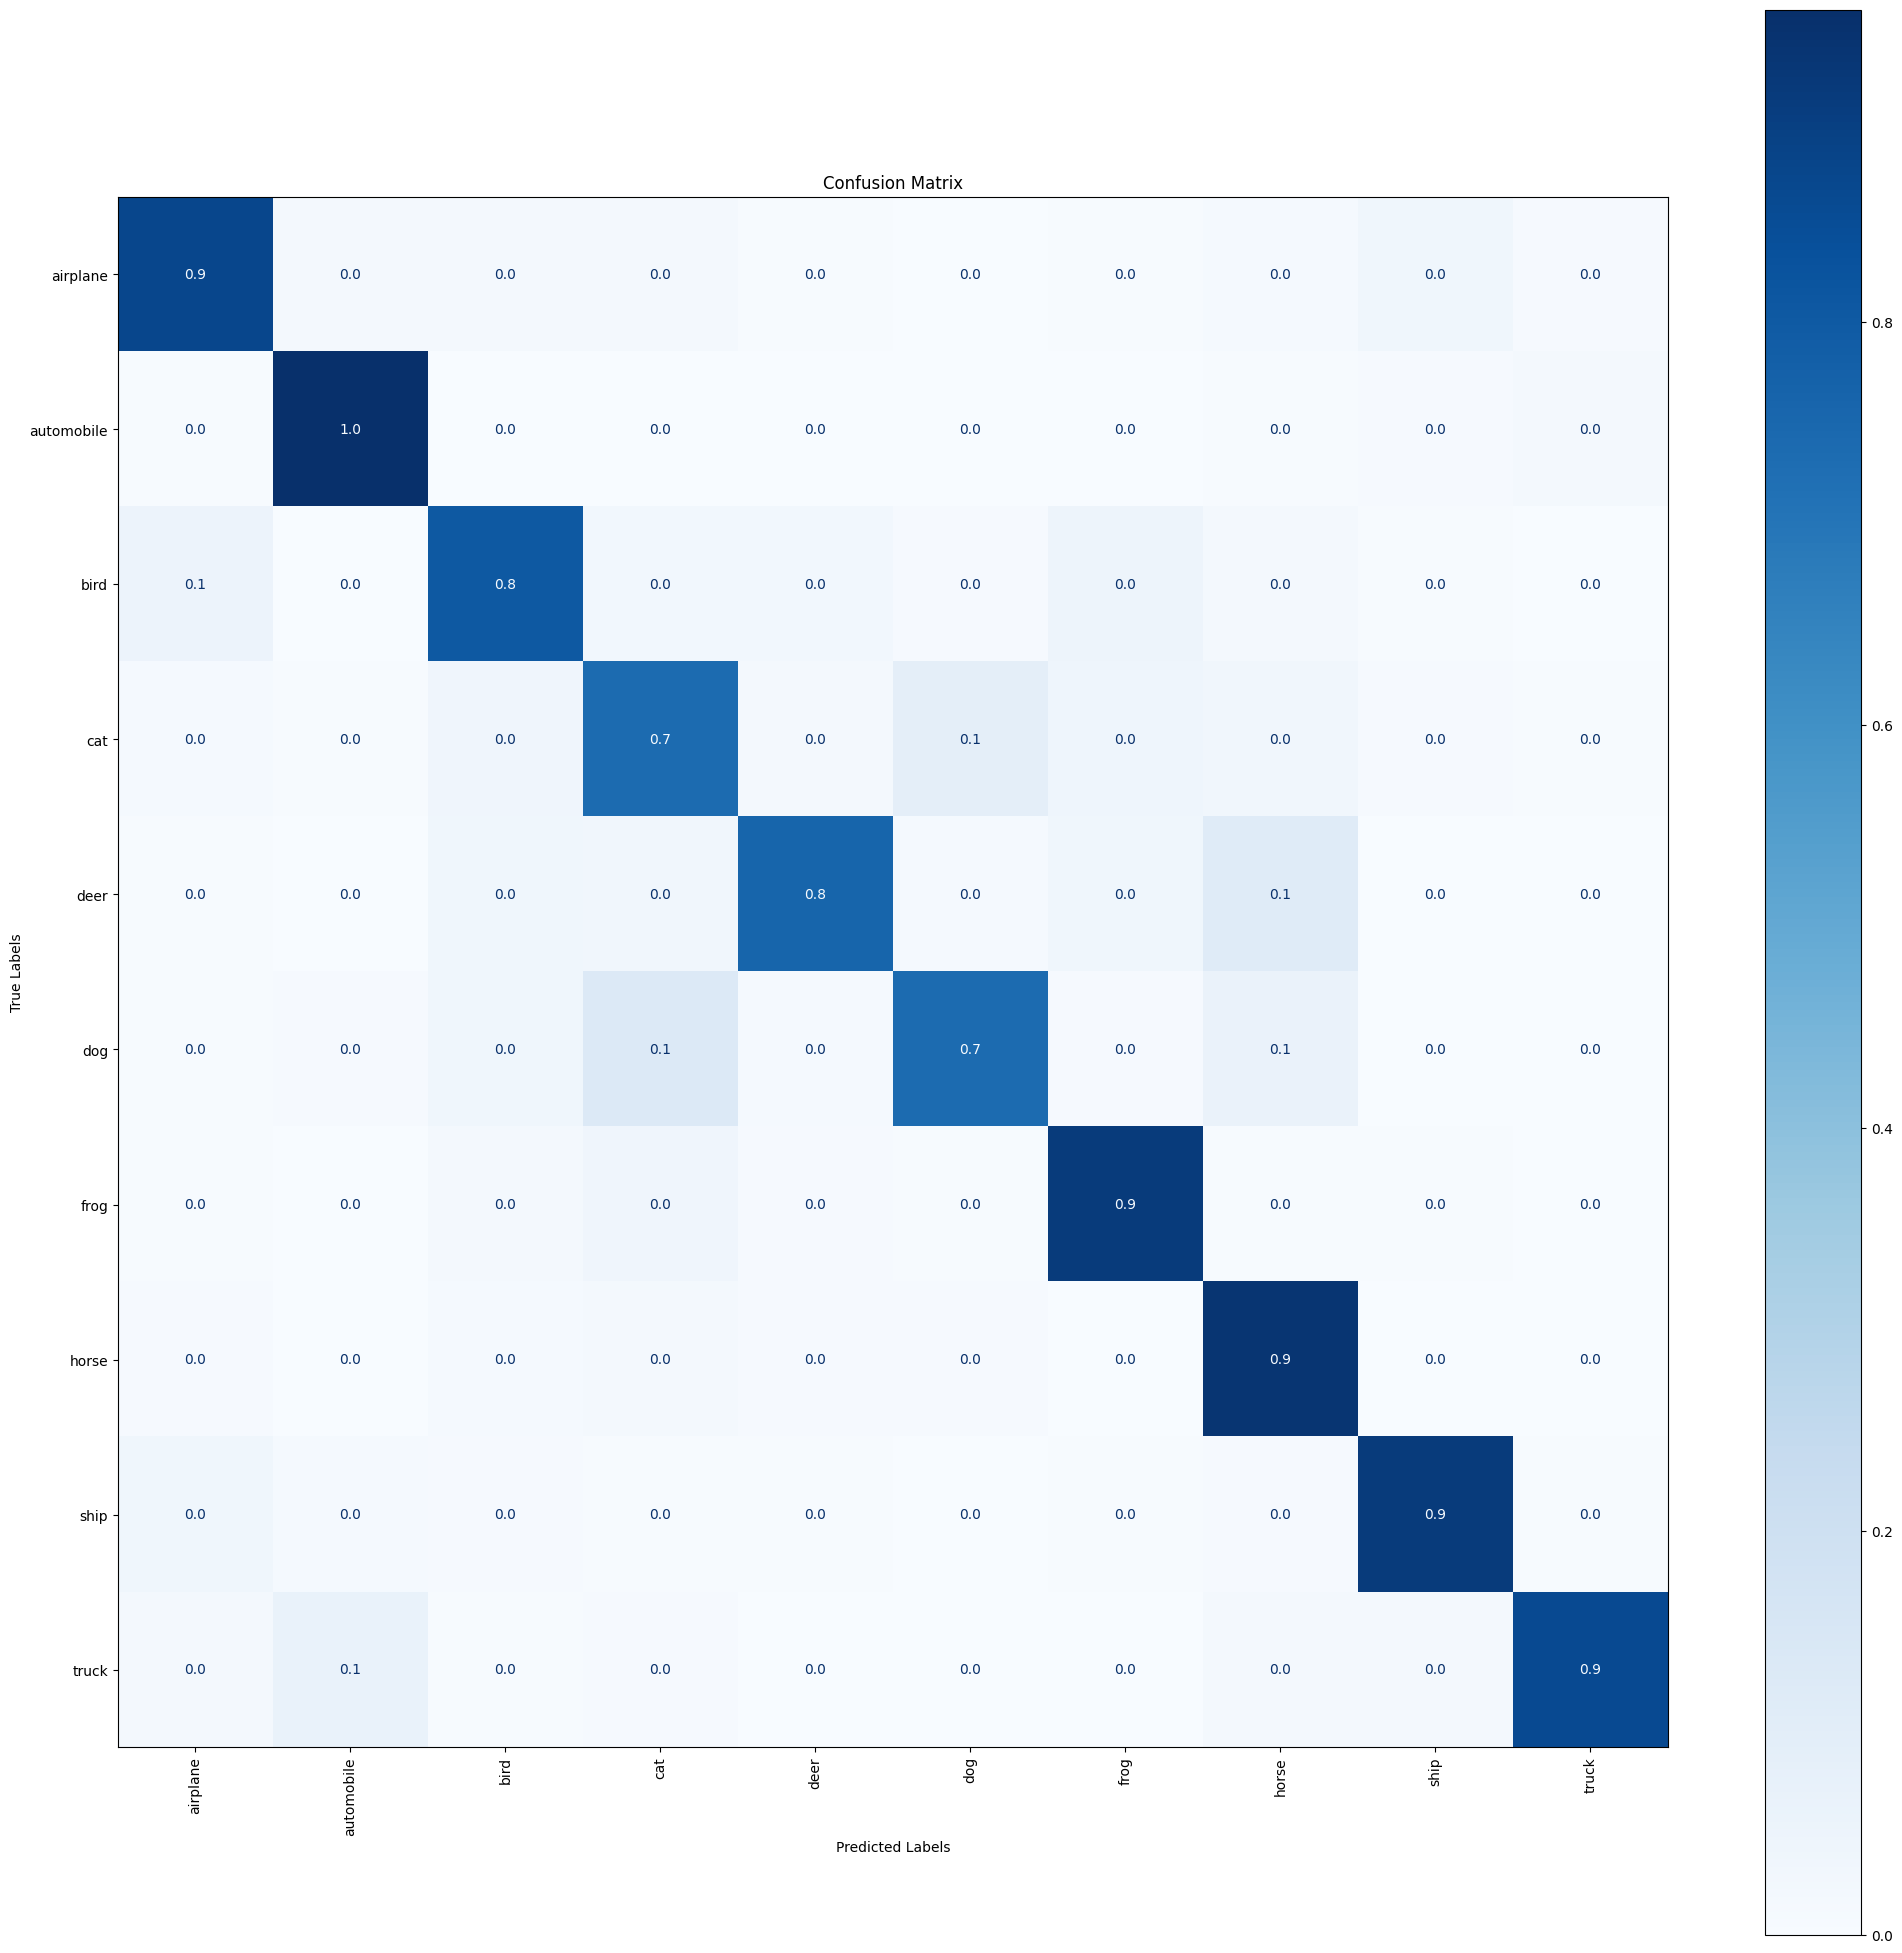

07/23 16:04:32 - mmengine - INFO - Epoch(val) [14][157/157]    accuracy/top1: 84.8100  accuracy/top5: 99.1200  loss/loss: 1.7551  data_time: 0.0099  time: 0.0889
07/23 16:04:32 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_12.pth is removed
07/23 16:04:32 - mmengine - INFO - The best checkpoint with 84.8100 accuracy/top1 at 14 epoch is saved to best_accuracy_top1_epoch_14.pth.
07/23 16:04:52 - mmengine - INFO - Exp name: 20240723_145117
07/23 16:05:10 - mmengine - INFO - Epoch(train) [15][100/782]  base_lr: 8.4299e-04 lr: 3.5339e-04  eta: 2:08:35  time: 0.3773  data_time: 0.0908  memory: 3611  grad_norm: 1.5239  loss: 0.7129
07/23 16:05:48 - mmengine - INFO - Epoch(train) [15][200/782]  base_lr: 8.3882e-04 lr: 3.5167e-04  eta: 2:07:56  time: 0.3782  data_time: 0.0912  memory: 3611  grad_norm: 1.5144  loss: 0.7574
07/23 16:06:26 - mmengine - INFO - Epoch(train) [15][300

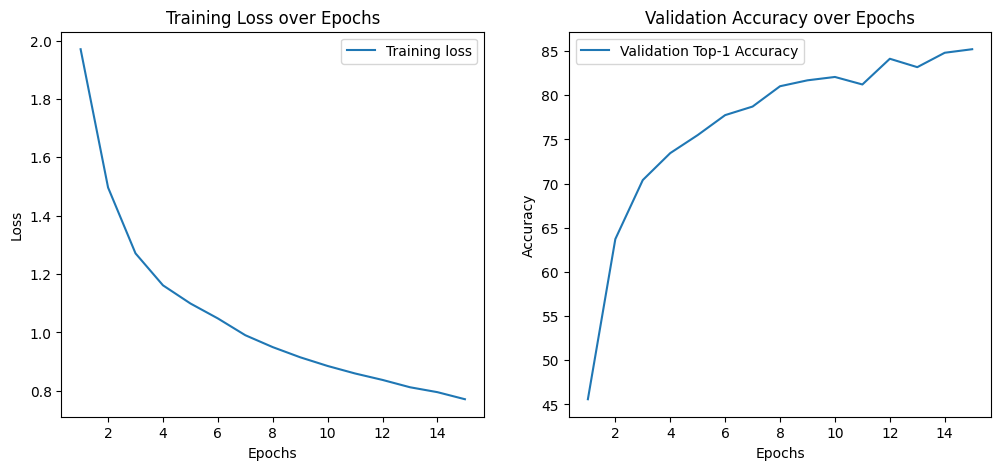

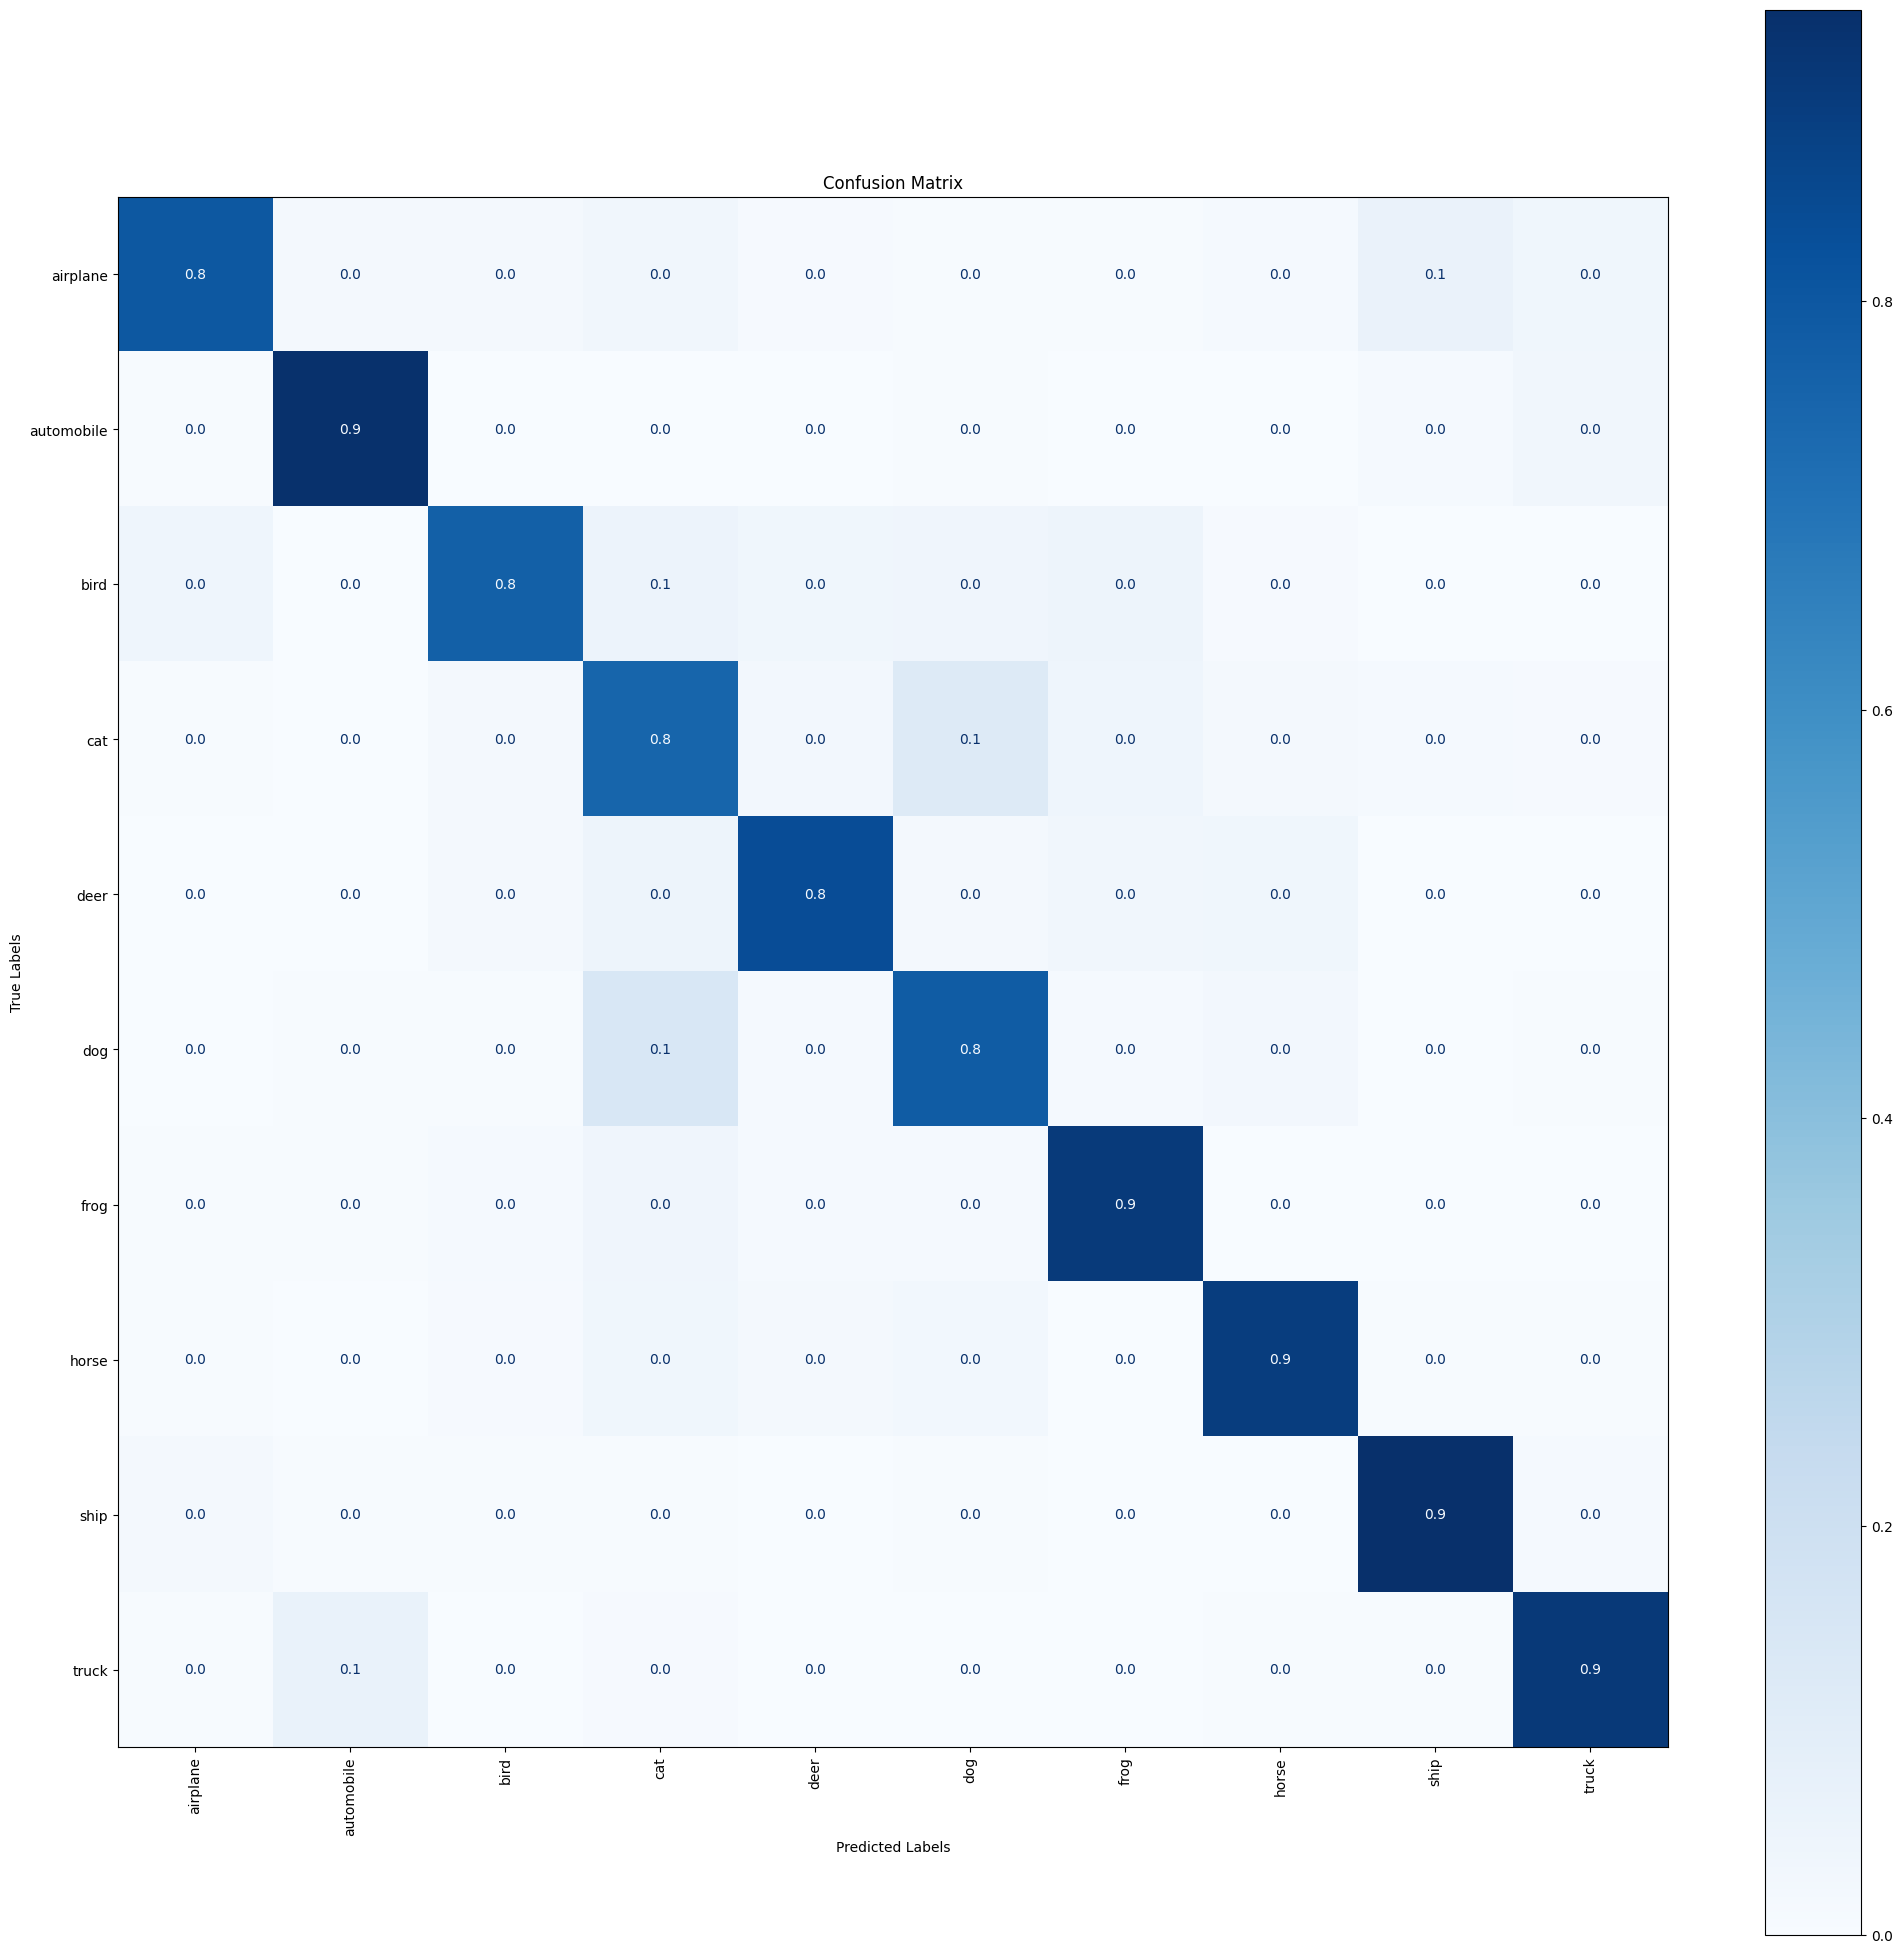

07/23 16:09:48 - mmengine - INFO - Epoch(val) [15][157/157]    accuracy/top1: 85.2100  accuracy/top5: 99.1300  loss/loss: 1.7431  data_time: 0.0103  time: 0.0897
07/23 16:09:48 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_14.pth is removed
07/23 16:09:49 - mmengine - INFO - The best checkpoint with 85.2100 accuracy/top1 at 15 epoch is saved to best_accuracy_top1_epoch_15.pth.
07/23 16:10:27 - mmengine - INFO - Epoch(train) [16][100/782]  base_lr: 8.0921e-04 lr: 3.3947e-04  eta: 2:03:42  time: 0.3789  data_time: 0.0913  memory: 3611  grad_norm: 1.5486  loss: 0.7557
07/23 16:11:06 - mmengine - INFO - Epoch(train) [16][200/782]  base_lr: 8.0471e-04 lr: 3.3761e-04  eta: 2:03:04  time: 0.3766  data_time: 0.0907  memory: 3611  grad_norm: 1.3982  loss: 0.7171
07/23 16:11:33 - mmengine - INFO - Exp name: 20240723_145117
07/23 16:11:44 - mmengine - INFO - Epoch(train) [16][300

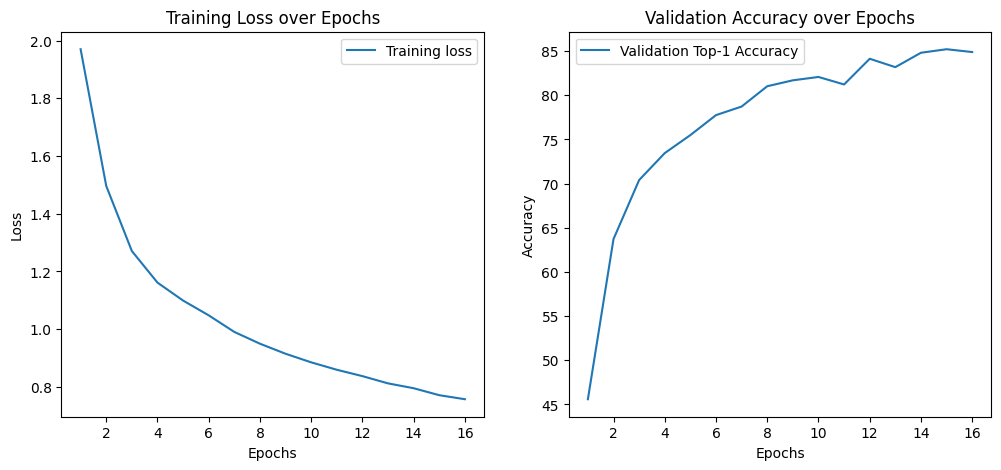

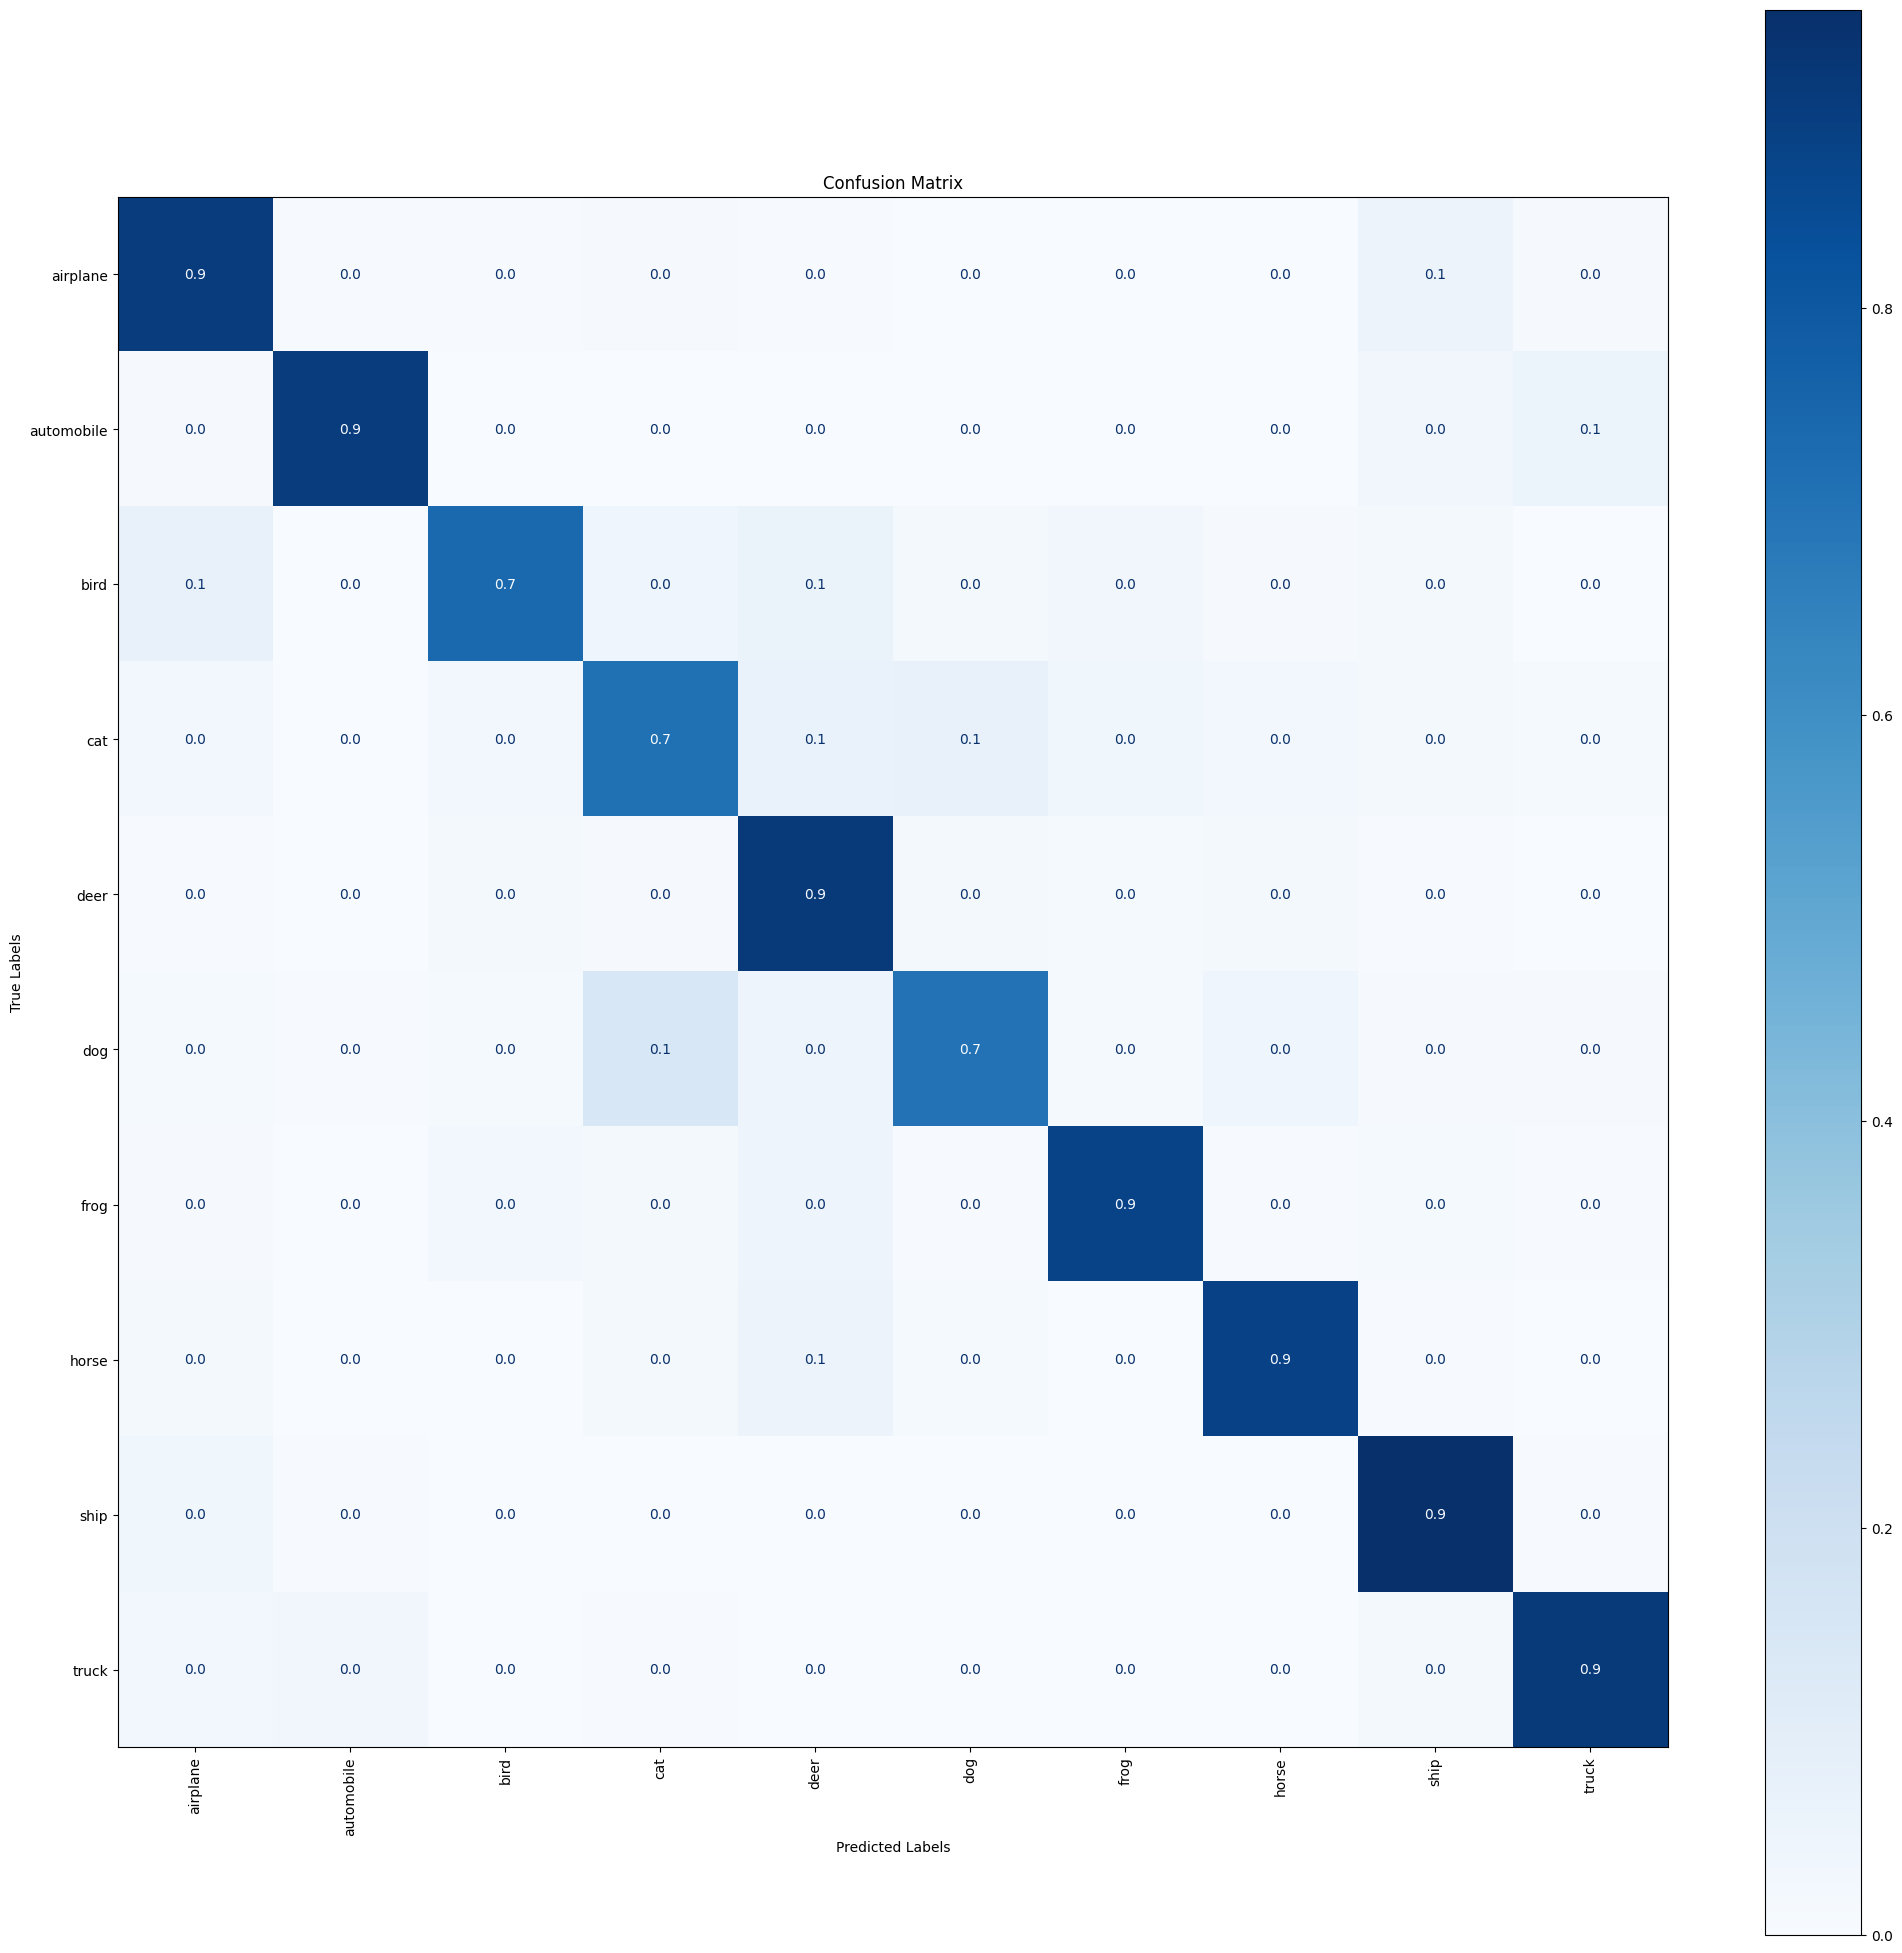

07/23 16:15:01 - mmengine - INFO - Epoch(val) [16][157/157]    accuracy/top1: 84.8900  accuracy/top5: 99.1300  loss/loss: 1.7324  data_time: 0.0095  time: 0.0891
07/23 16:15:39 - mmengine - INFO - Epoch(train) [17][100/782]  base_lr: 7.7298e-04 lr: 3.2453e-04  eta: 1:58:41  time: 0.3791  data_time: 0.0912  memory: 3611  grad_norm: 1.3735  loss: 0.6923
07/23 16:16:17 - mmengine - INFO - Epoch(train) [17][200/782]  base_lr: 7.6819e-04 lr: 3.2256e-04  eta: 1:58:03  time: 0.3785  data_time: 0.0909  memory: 3611  grad_norm: 1.7684  loss: 0.7588
07/23 16:16:55 - mmengine - INFO - Epoch(train) [17][300/782]  base_lr: 7.6336e-04 lr: 3.2057e-04  eta: 1:57:24  time: 0.3773  data_time: 0.0904  memory: 3611  grad_norm: 1.4983  loss: 0.7430
07/23 16:17:33 - mmengine - INFO - Epoch(train) [17][400/782]  base_lr: 7.5849e-04 lr: 3.1856e-04  eta: 1:56:46  time: 0.3782  data_time: 0.0911  memory: 3611  grad_norm: 1.5520  loss: 0.7312
07/23 16:18:06 - mmengine - INFO - Exp name: 20240723_145117
07/23 16:

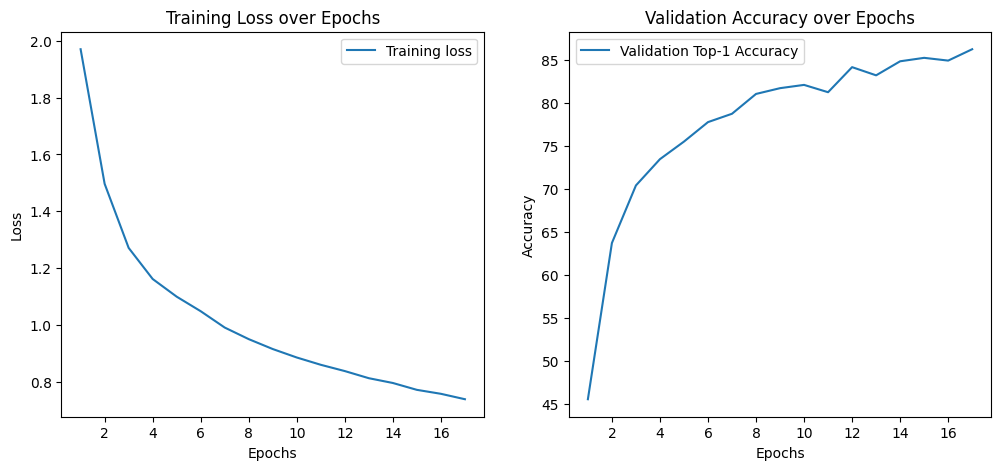

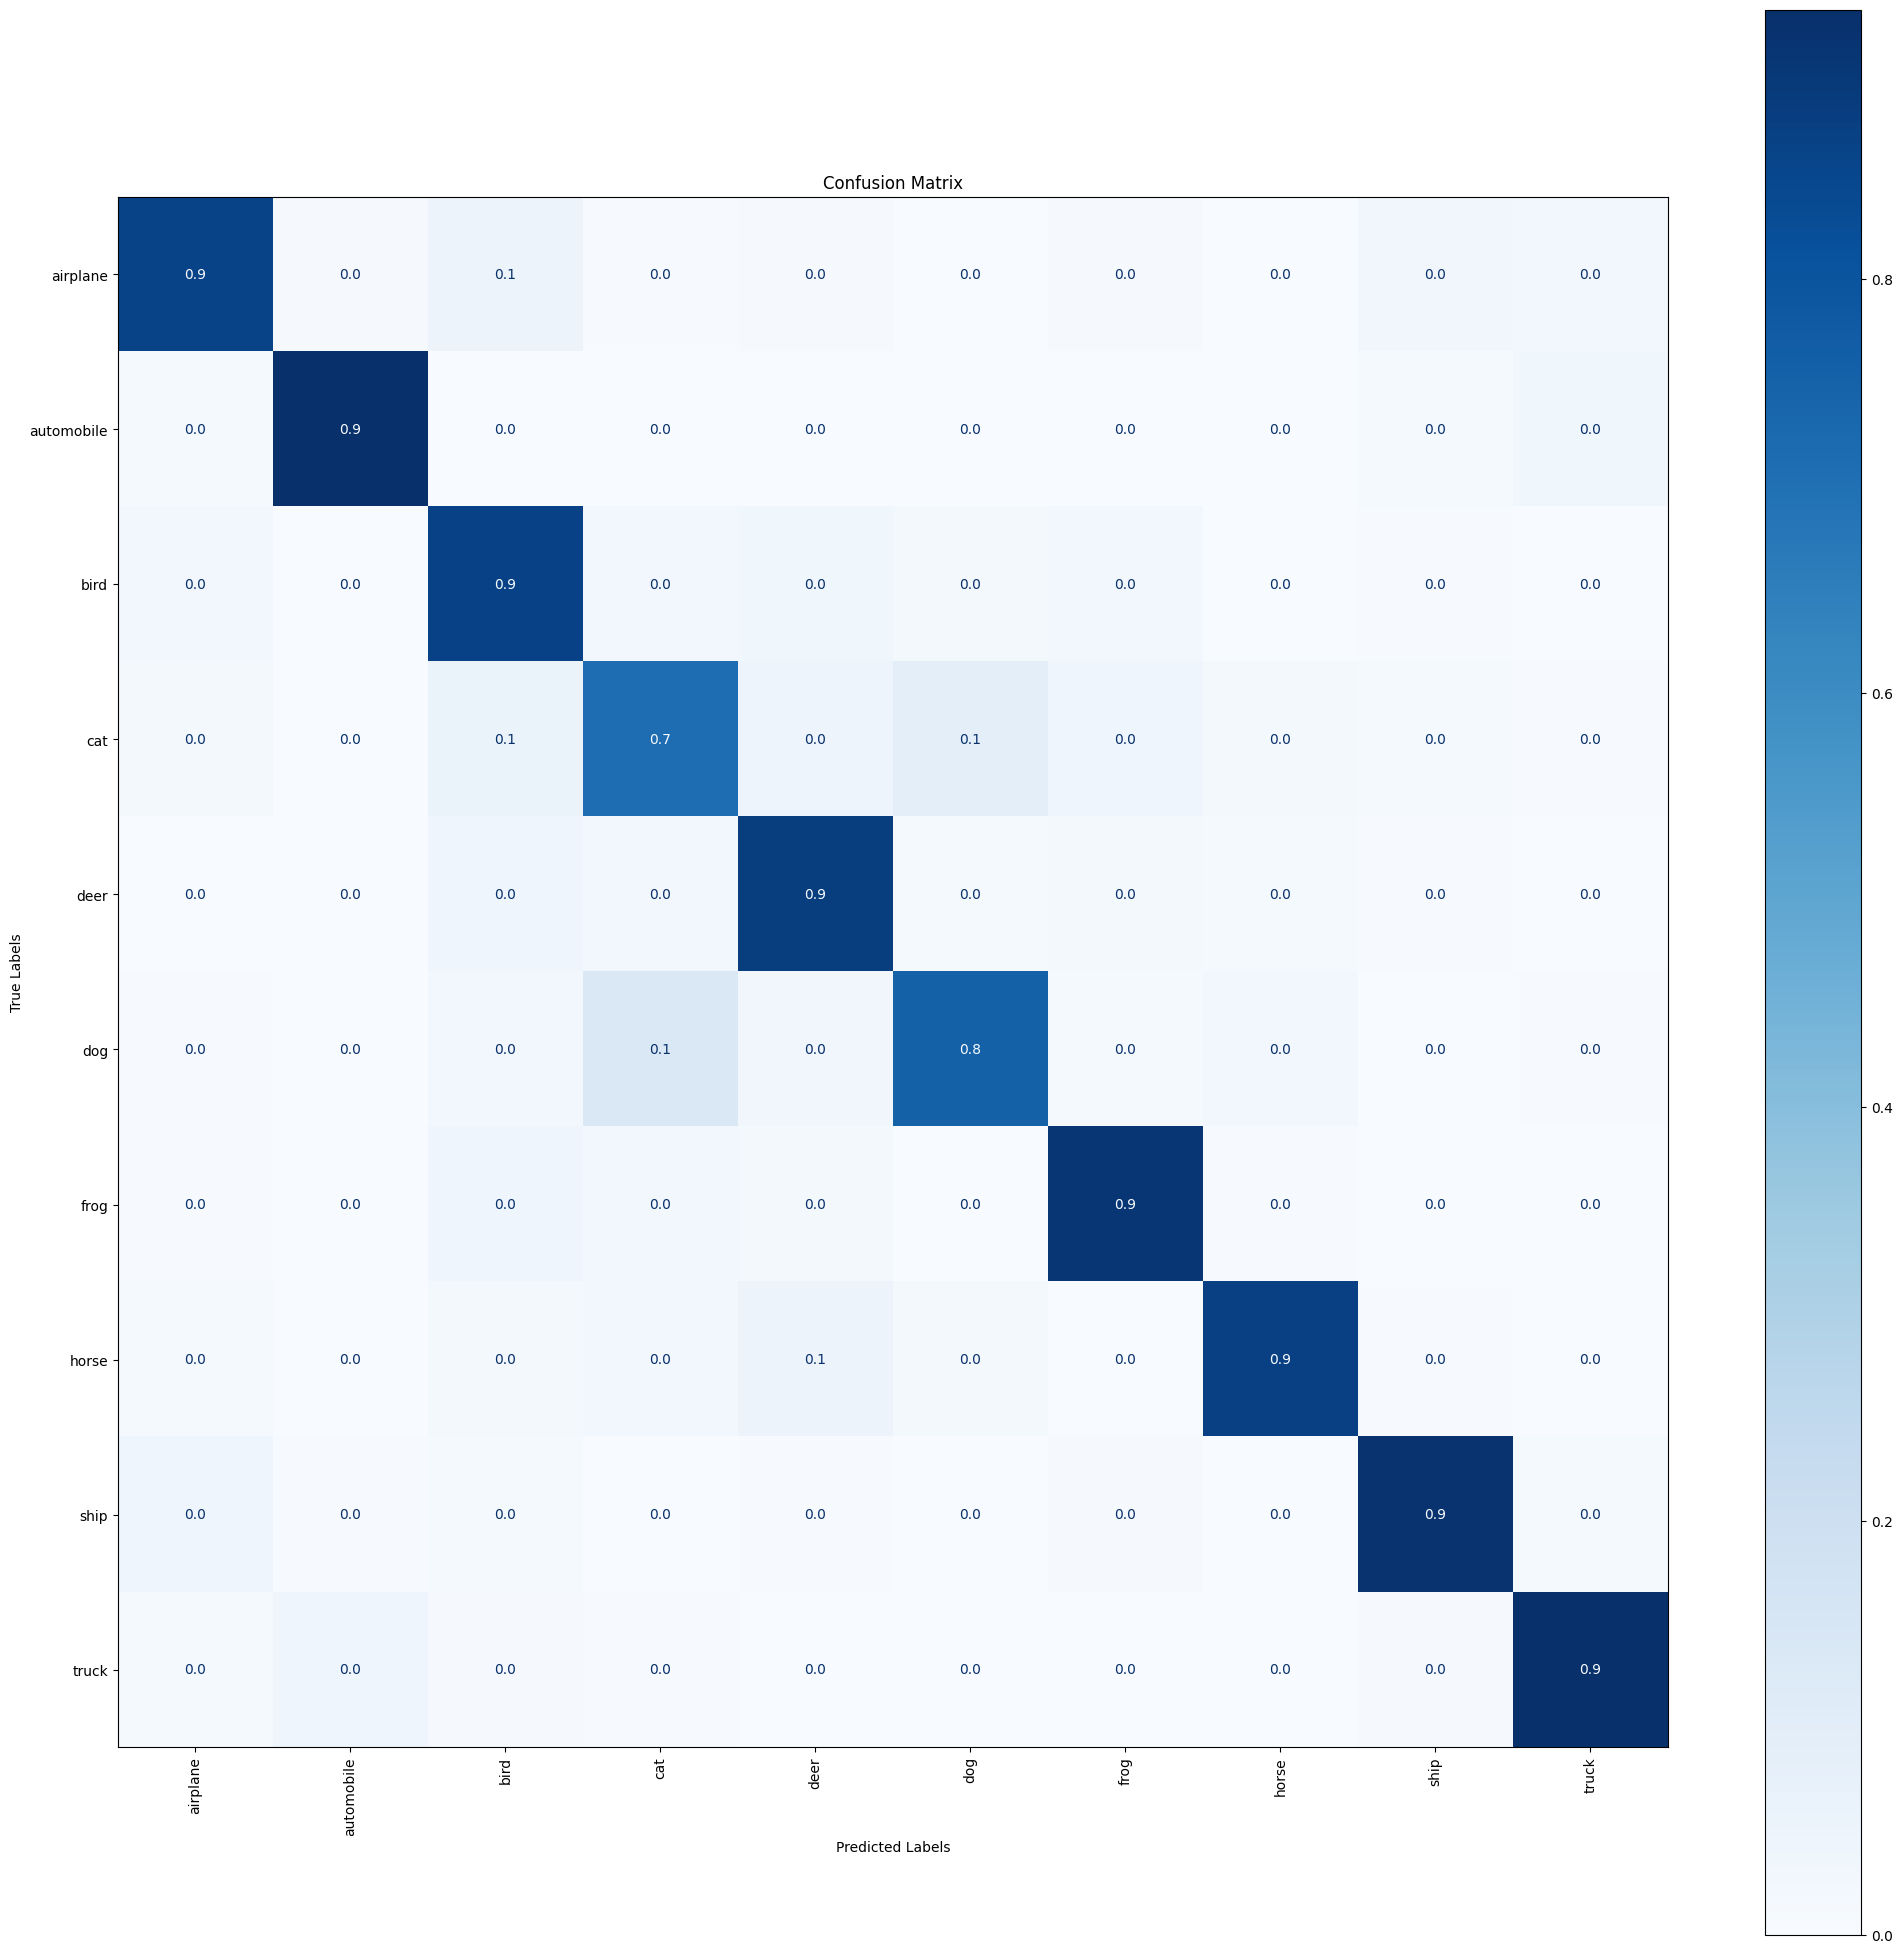

07/23 16:20:12 - mmengine - INFO - Epoch(val) [17][157/157]    accuracy/top1: 86.2100  accuracy/top5: 99.4300  loss/loss: 1.7236  data_time: 0.0094  time: 0.0889
07/23 16:20:12 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_15.pth is removed
07/23 16:20:13 - mmengine - INFO - The best checkpoint with 86.2100 accuracy/top1 at 17 epoch is saved to best_accuracy_top1_epoch_17.pth.
07/23 16:20:51 - mmengine - INFO - Epoch(train) [18][100/782]  base_lr: 7.3460e-04 lr: 3.0871e-04  eta: 1:53:40  time: 0.3783  data_time: 0.0909  memory: 3611  grad_norm: 1.4159  loss: 0.6954
07/23 16:21:29 - mmengine - INFO - Epoch(train) [18][200/782]  base_lr: 7.2955e-04 lr: 3.0663e-04  eta: 1:53:02  time: 0.3799  data_time: 0.0913  memory: 3611  grad_norm: 1.5566  loss: 0.7371
07/23 16:22:07 - mmengine - INFO - Epoch(train) [18][300/782]  base_lr: 7.2447e-04 lr: 3.0454e-04  eta: 1:52:24  time

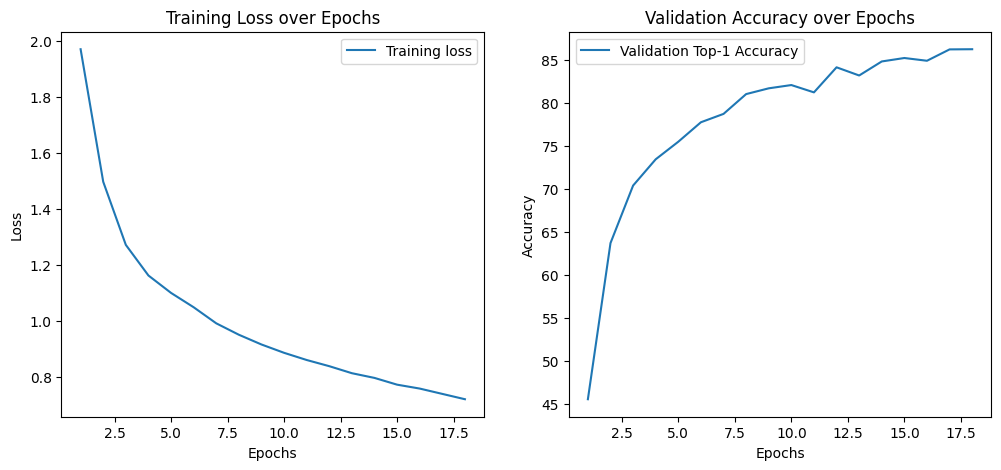

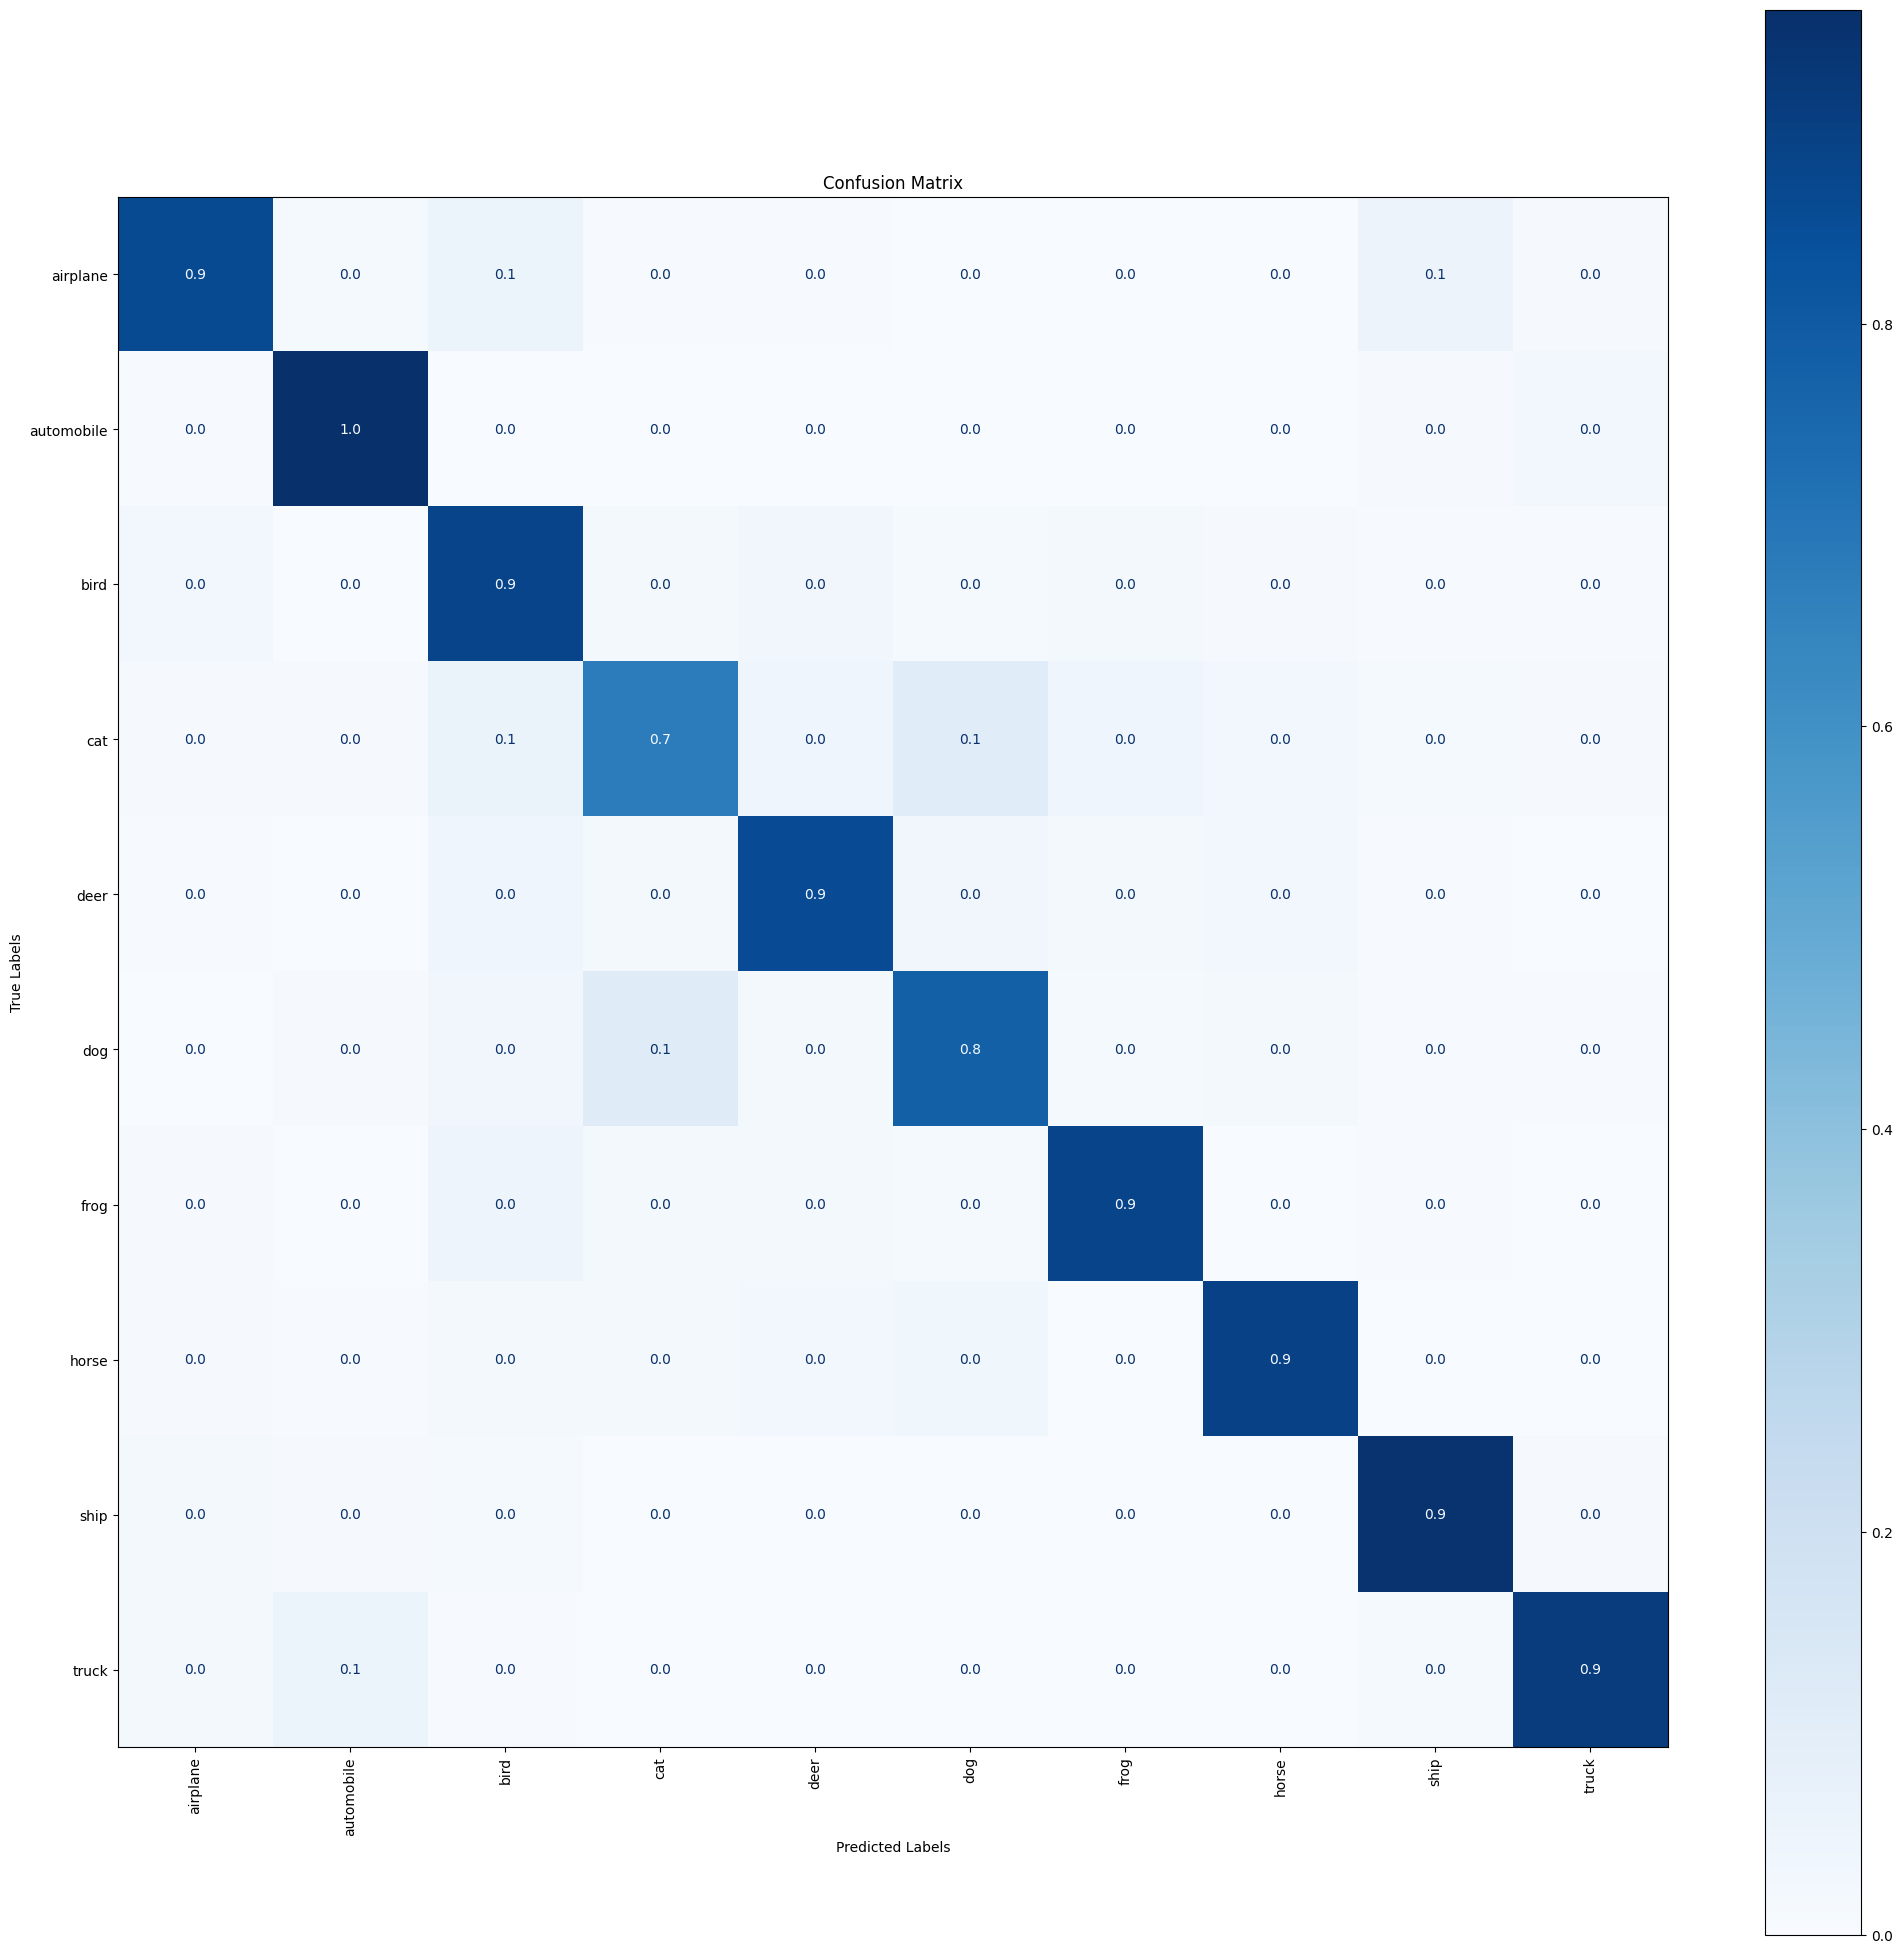

07/23 16:25:24 - mmengine - INFO - Epoch(val) [18][157/157]    accuracy/top1: 86.2300  accuracy/top5: 99.2000  loss/loss: 1.7164  data_time: 0.0101  time: 0.0889
07/23 16:25:24 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_17.pth is removed
07/23 16:25:25 - mmengine - INFO - The best checkpoint with 86.2300 accuracy/top1 at 18 epoch is saved to best_accuracy_top1_epoch_18.pth.
07/23 16:26:03 - mmengine - INFO - Epoch(train) [19][100/782]  base_lr: 6.9436e-04 lr: 2.9212e-04  eta: 1:48:40  time: 0.3771  data_time: 0.0906  memory: 3611  grad_norm: 1.3975  loss: 0.6837
07/23 16:26:43 - mmengine - INFO - Epoch(train) [19][200/782]  base_lr: 6.8910e-04 lr: 2.8995e-04  eta: 1:48:03  time: 0.3920  data_time: 0.0943  memory: 3611  grad_norm: 1.4228  loss: 0.7048
07/23 16:27:21 - mmengine - INFO - Epoch(train) [19][300/782]  base_lr: 6.8381e-04 lr: 2.8778e-04  eta: 1:47:26  time

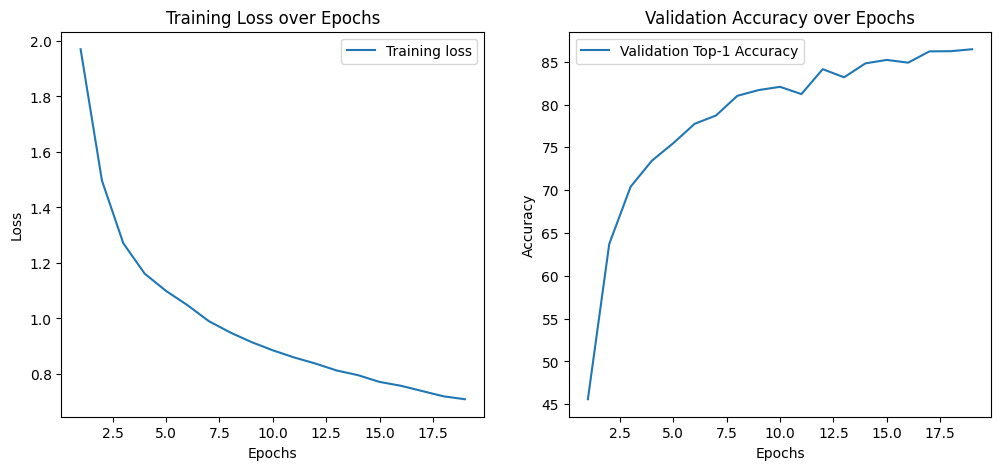

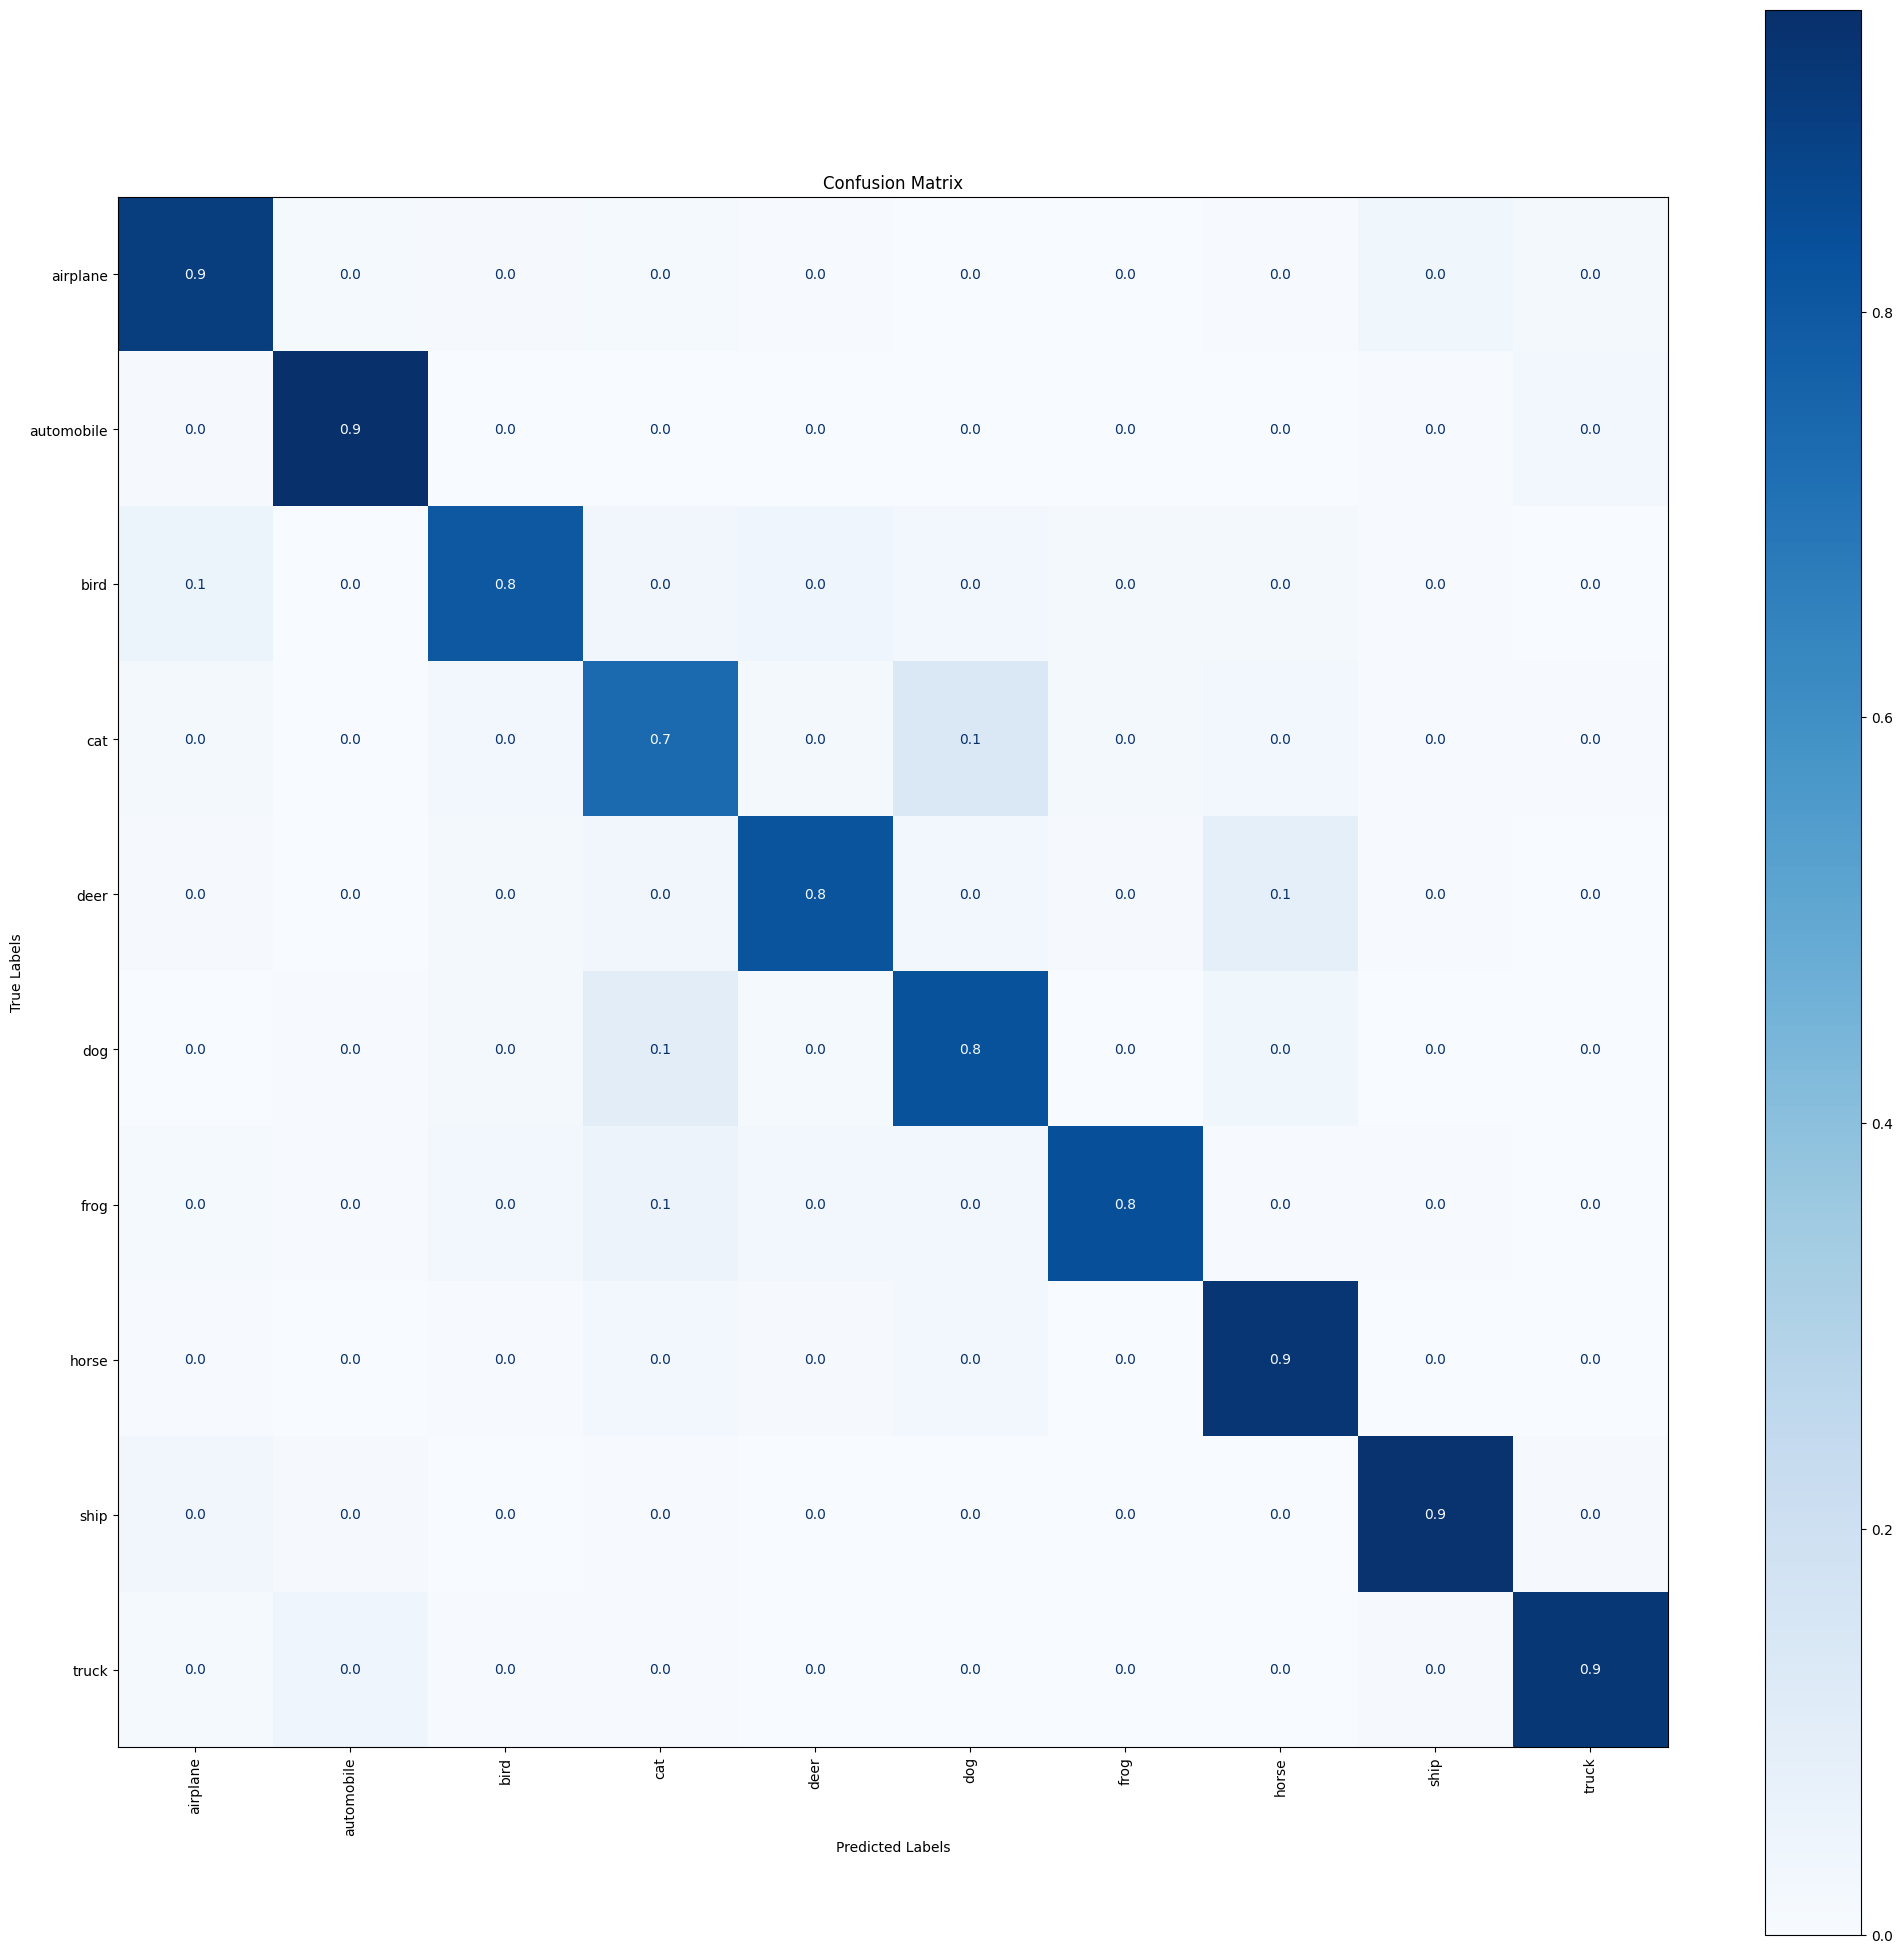

07/23 16:30:41 - mmengine - INFO - Epoch(val) [19][157/157]    accuracy/top1: 86.4600  accuracy/top5: 99.0200  loss/loss: 1.7098  data_time: 0.0095  time: 0.0890
07/23 16:30:41 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_18.pth is removed
07/23 16:30:41 - mmengine - INFO - The best checkpoint with 86.4600 accuracy/top1 at 19 epoch is saved to best_accuracy_top1_epoch_19.pth.
07/23 16:31:19 - mmengine - INFO - Epoch(train) [20][100/782]  base_lr: 6.5260e-04 lr: 2.7491e-04  eta: 1:43:44  time: 0.3782  data_time: 0.0913  memory: 3611  grad_norm: 1.5495  loss: 0.7119
07/23 16:31:35 - mmengine - INFO - Exp name: 20240723_145117
07/23 16:31:57 - mmengine - INFO - Epoch(train) [20][200/782]  base_lr: 6.4717e-04 lr: 2.7267e-04  eta: 1:43:06  time: 0.3785  data_time: 0.0914  memory: 3611  grad_norm: 1.4697  loss: 0.6524
07/23 16:32:35 - mmengine - INFO - Epoch(train) [20][300

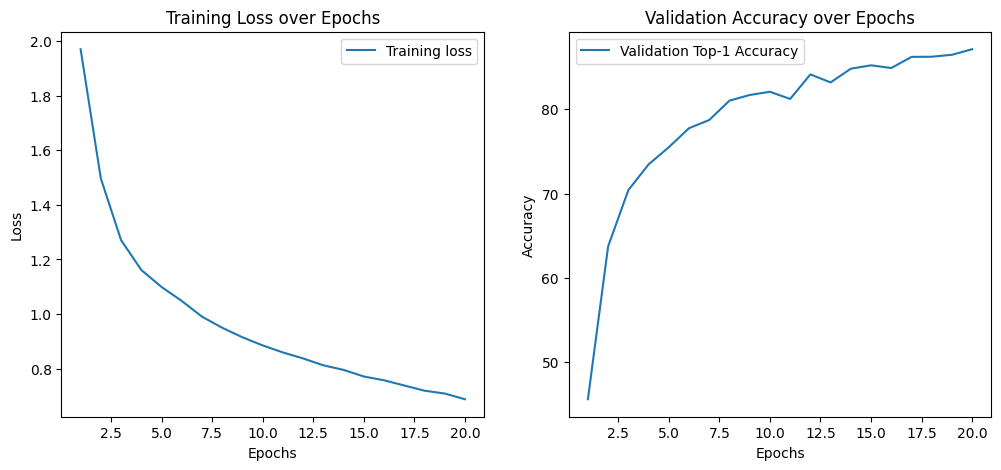

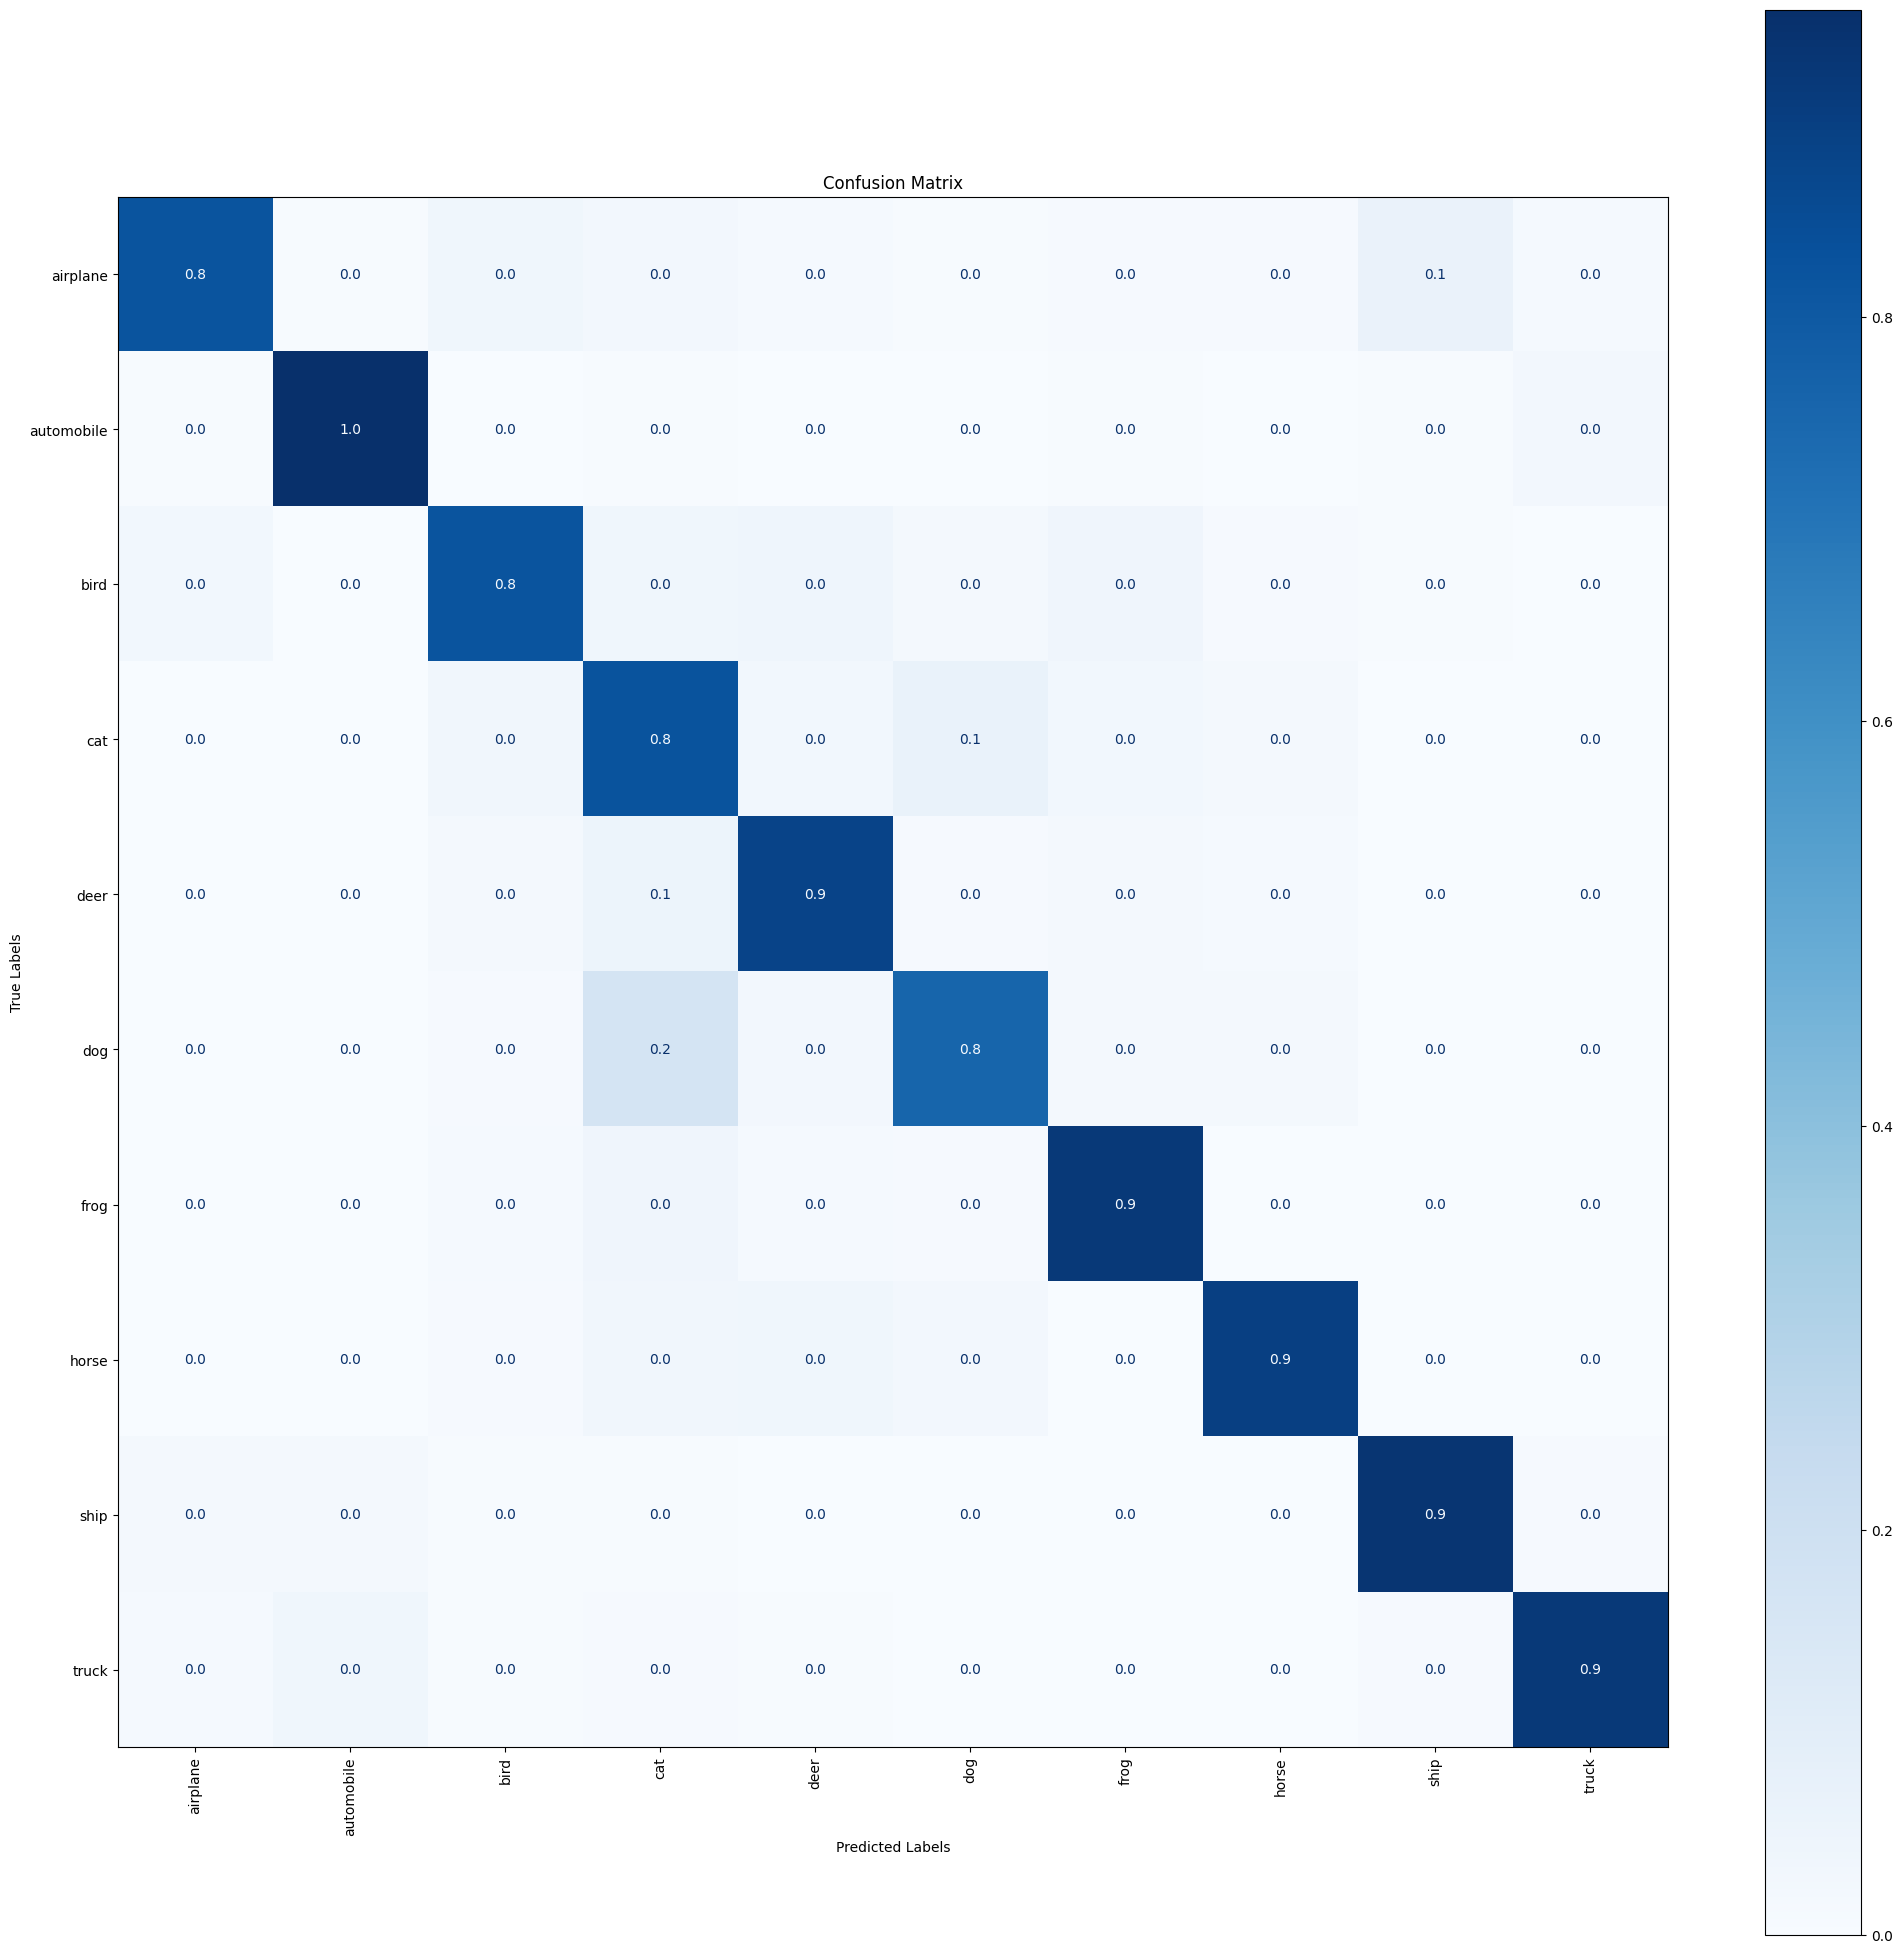

07/23 16:35:53 - mmengine - INFO - Epoch(val) [20][157/157]    accuracy/top1: 87.1200  accuracy/top5: 99.2700  loss/loss: 1.7020  data_time: 0.0095  time: 0.0895
07/23 16:35:53 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_19.pth is removed
07/23 16:35:54 - mmengine - INFO - The best checkpoint with 87.1200 accuracy/top1 at 20 epoch is saved to best_accuracy_top1_epoch_20.pth.
07/23 16:36:32 - mmengine - INFO - Epoch(train) [21][100/782]  base_lr: 6.0966e-04 lr: 2.5720e-04  eta: 1:38:45  time: 0.3807  data_time: 0.0919  memory: 3611  grad_norm: 1.4209  loss: 0.6714
07/23 16:37:10 - mmengine - INFO - Epoch(train) [21][200/782]  base_lr: 6.0410e-04 lr: 2.5491e-04  eta: 1:38:07  time: 0.3803  data_time: 0.0918  memory: 3611  grad_norm: 1.4129  loss: 0.6451
07/23 16:37:48 - mmengine - INFO - Epoch(train) [21][300/782]  base_lr: 5.9852e-04 lr: 2.5261e-04  eta: 1:37:29  time

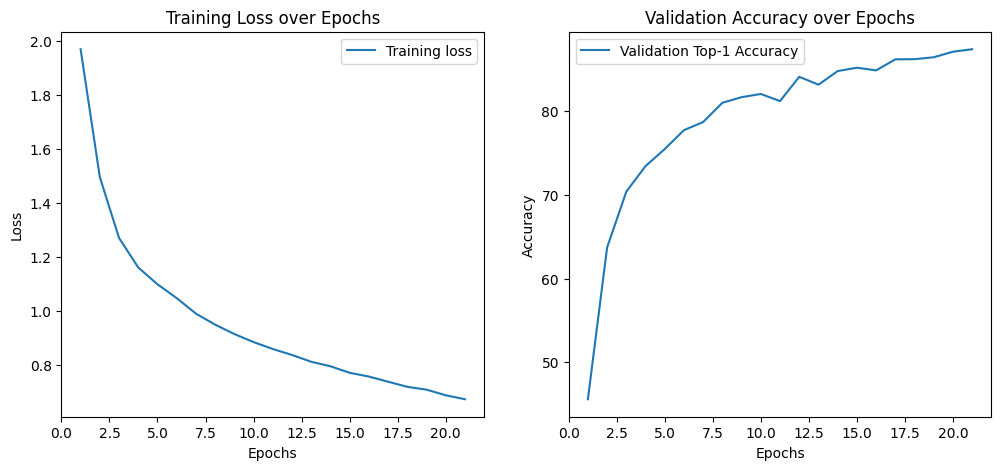

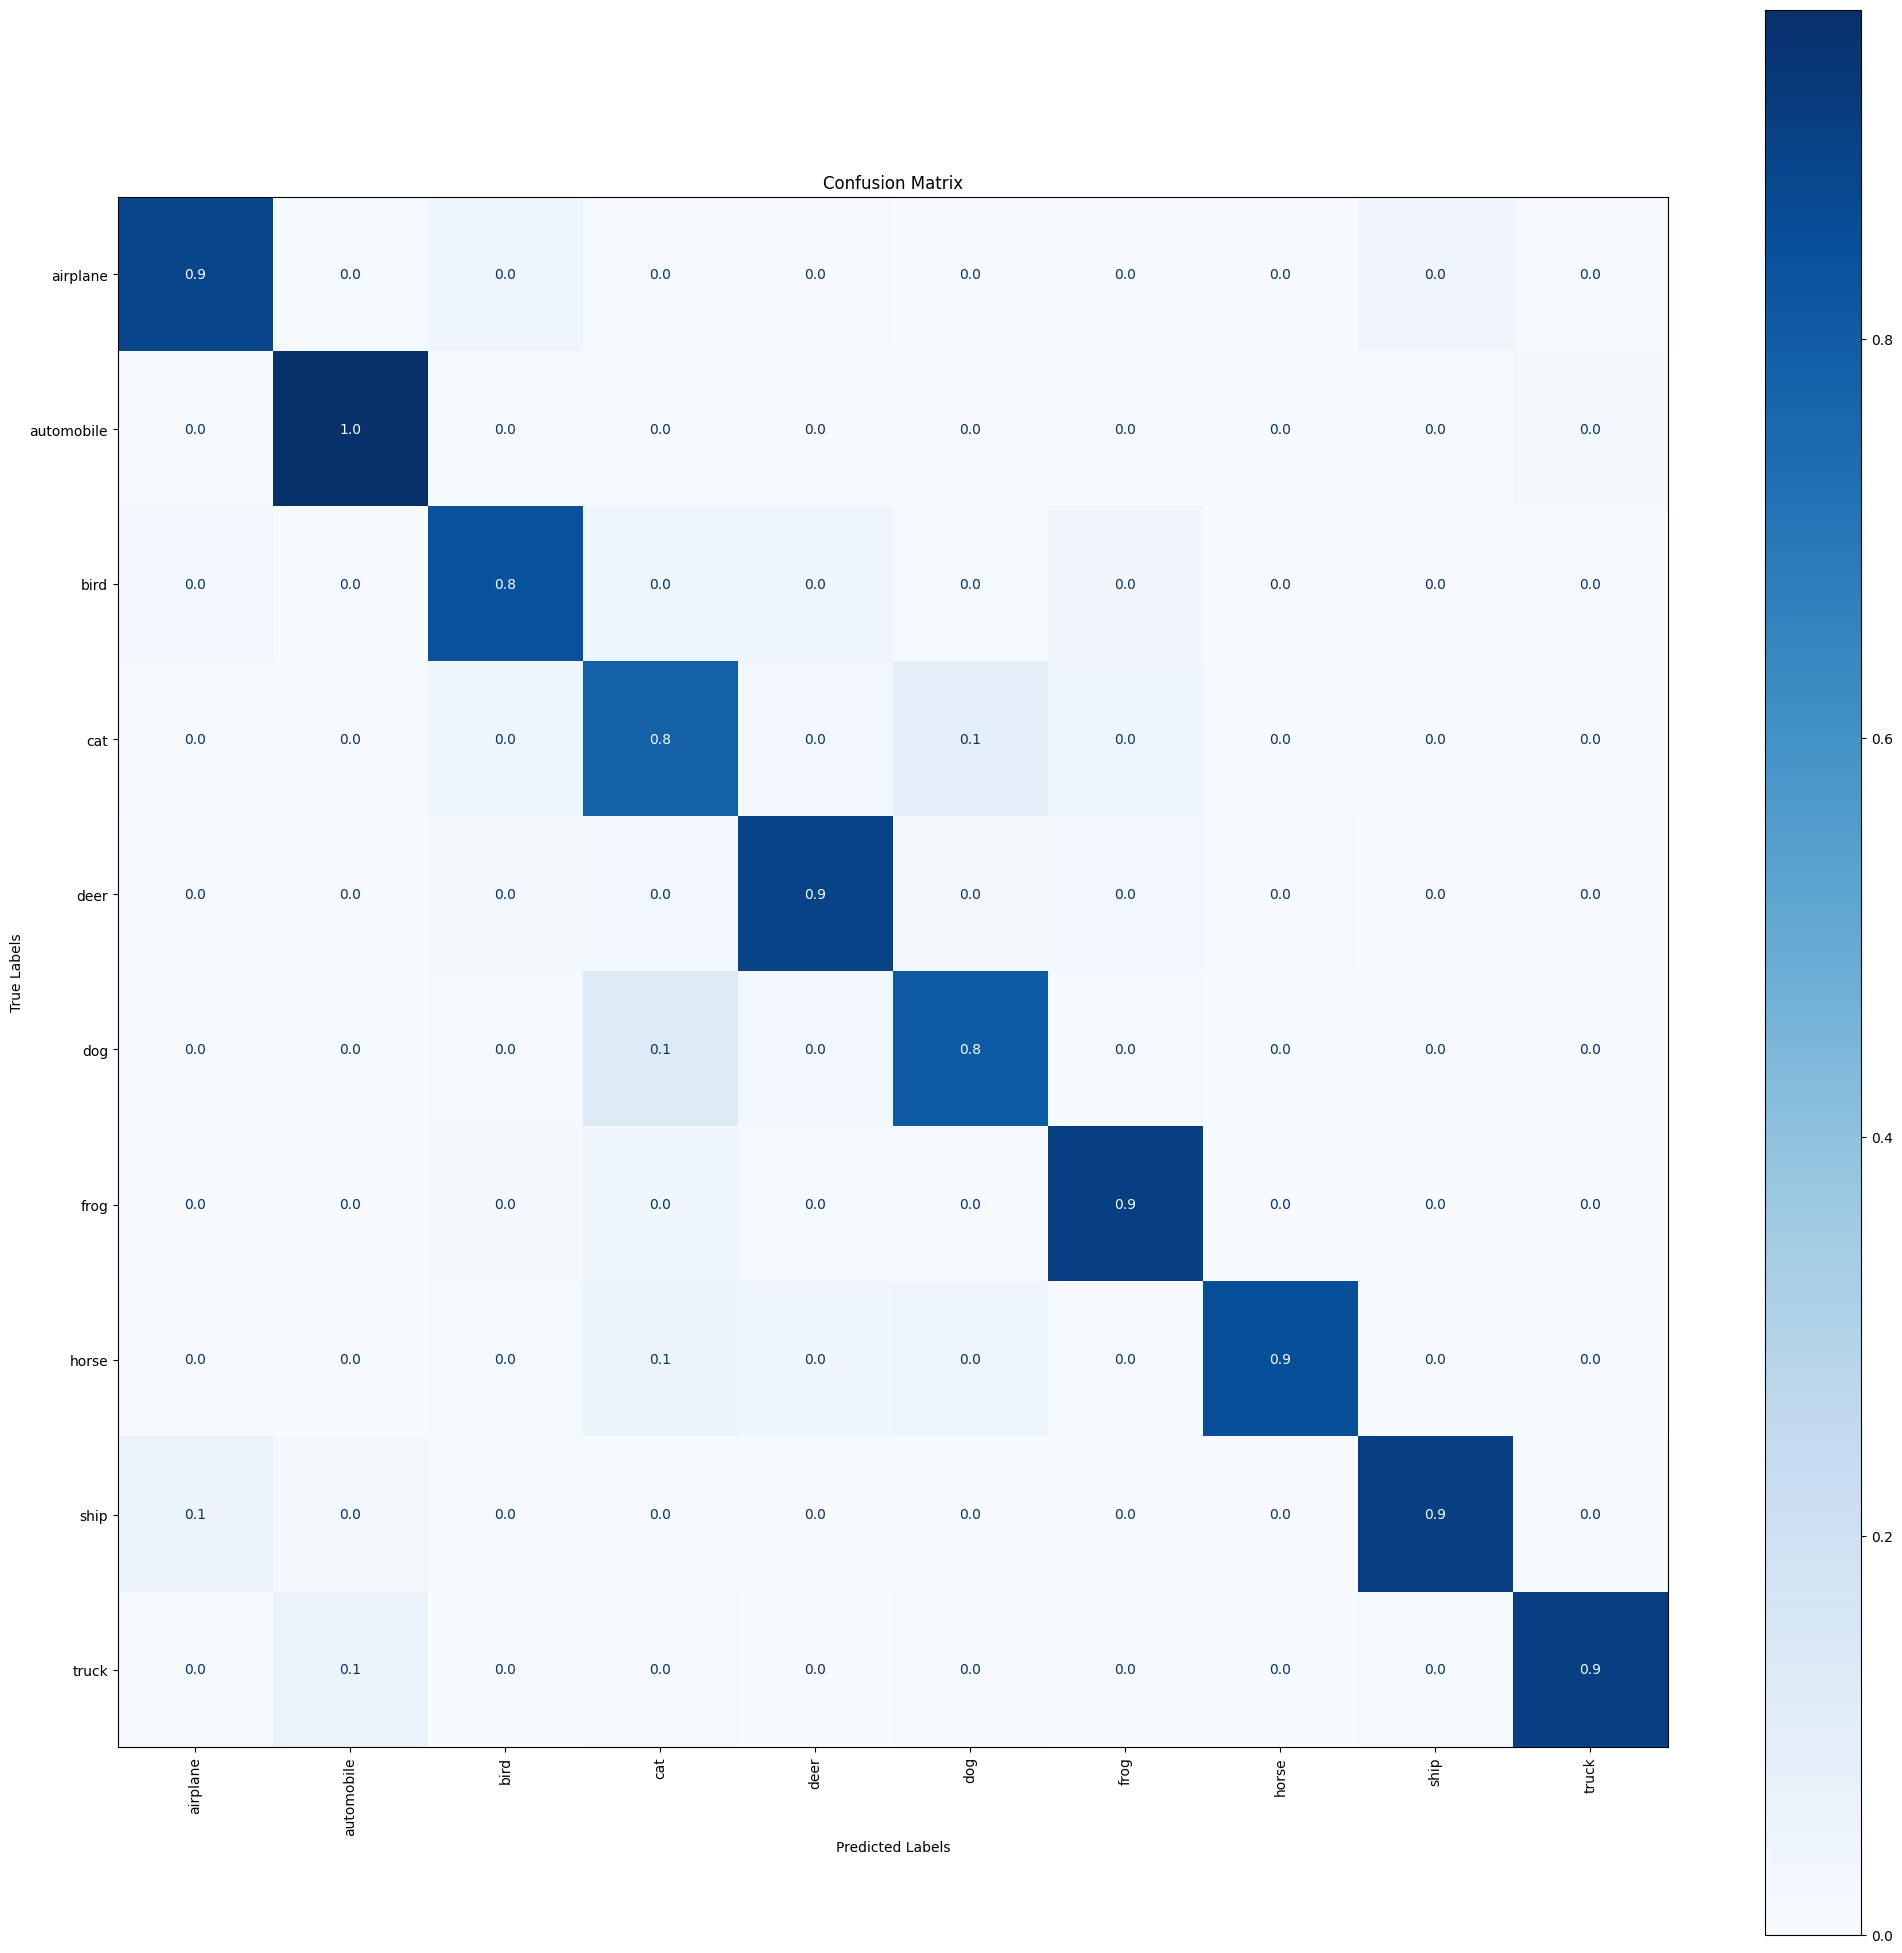

07/23 16:41:07 - mmengine - INFO - Epoch(val) [21][157/157]    accuracy/top1: 87.4200  accuracy/top5: 99.1600  loss/loss: 1.6940  data_time: 0.0096  time: 0.0896
07/23 16:41:07 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_20.pth is removed
07/23 16:41:07 - mmengine - INFO - The best checkpoint with 87.4200 accuracy/top1 at 21 epoch is saved to best_accuracy_top1_epoch_21.pth.
07/23 16:41:46 - mmengine - INFO - Epoch(train) [22][100/782]  base_lr: 5.6587e-04 lr: 2.3915e-04  eta: 1:33:47  time: 0.3805  data_time: 0.0917  memory: 3611  grad_norm: 1.5283  loss: 0.6678
07/23 16:42:24 - mmengine - INFO - Epoch(train) [22][200/782]  base_lr: 5.6022e-04 lr: 2.3683e-04  eta: 1:33:09  time: 0.4023  data_time: 0.1000  memory: 3611  grad_norm: 1.3708  loss: 0.6618
07/23 16:43:04 - mmengine - INFO - Epoch(train) [22][300/782]  base_lr: 5.5458e-04 lr: 2.3450e-04  eta: 1:32:32  time

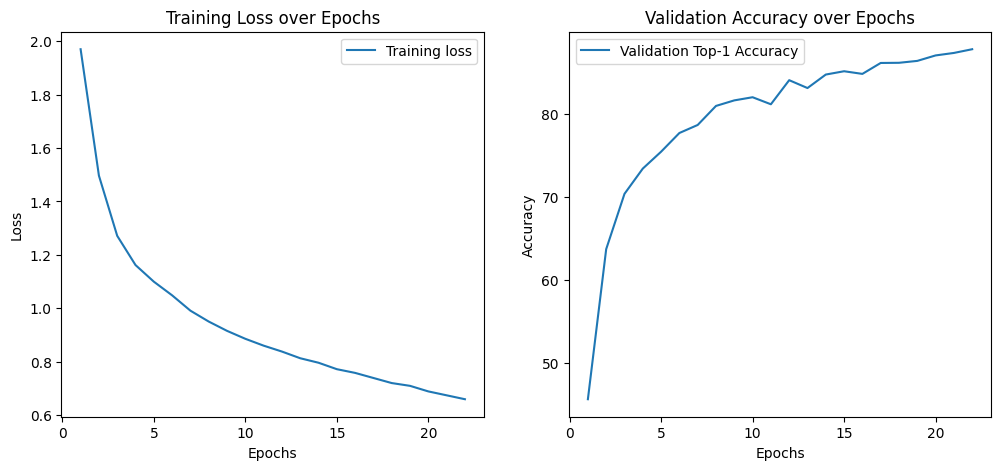

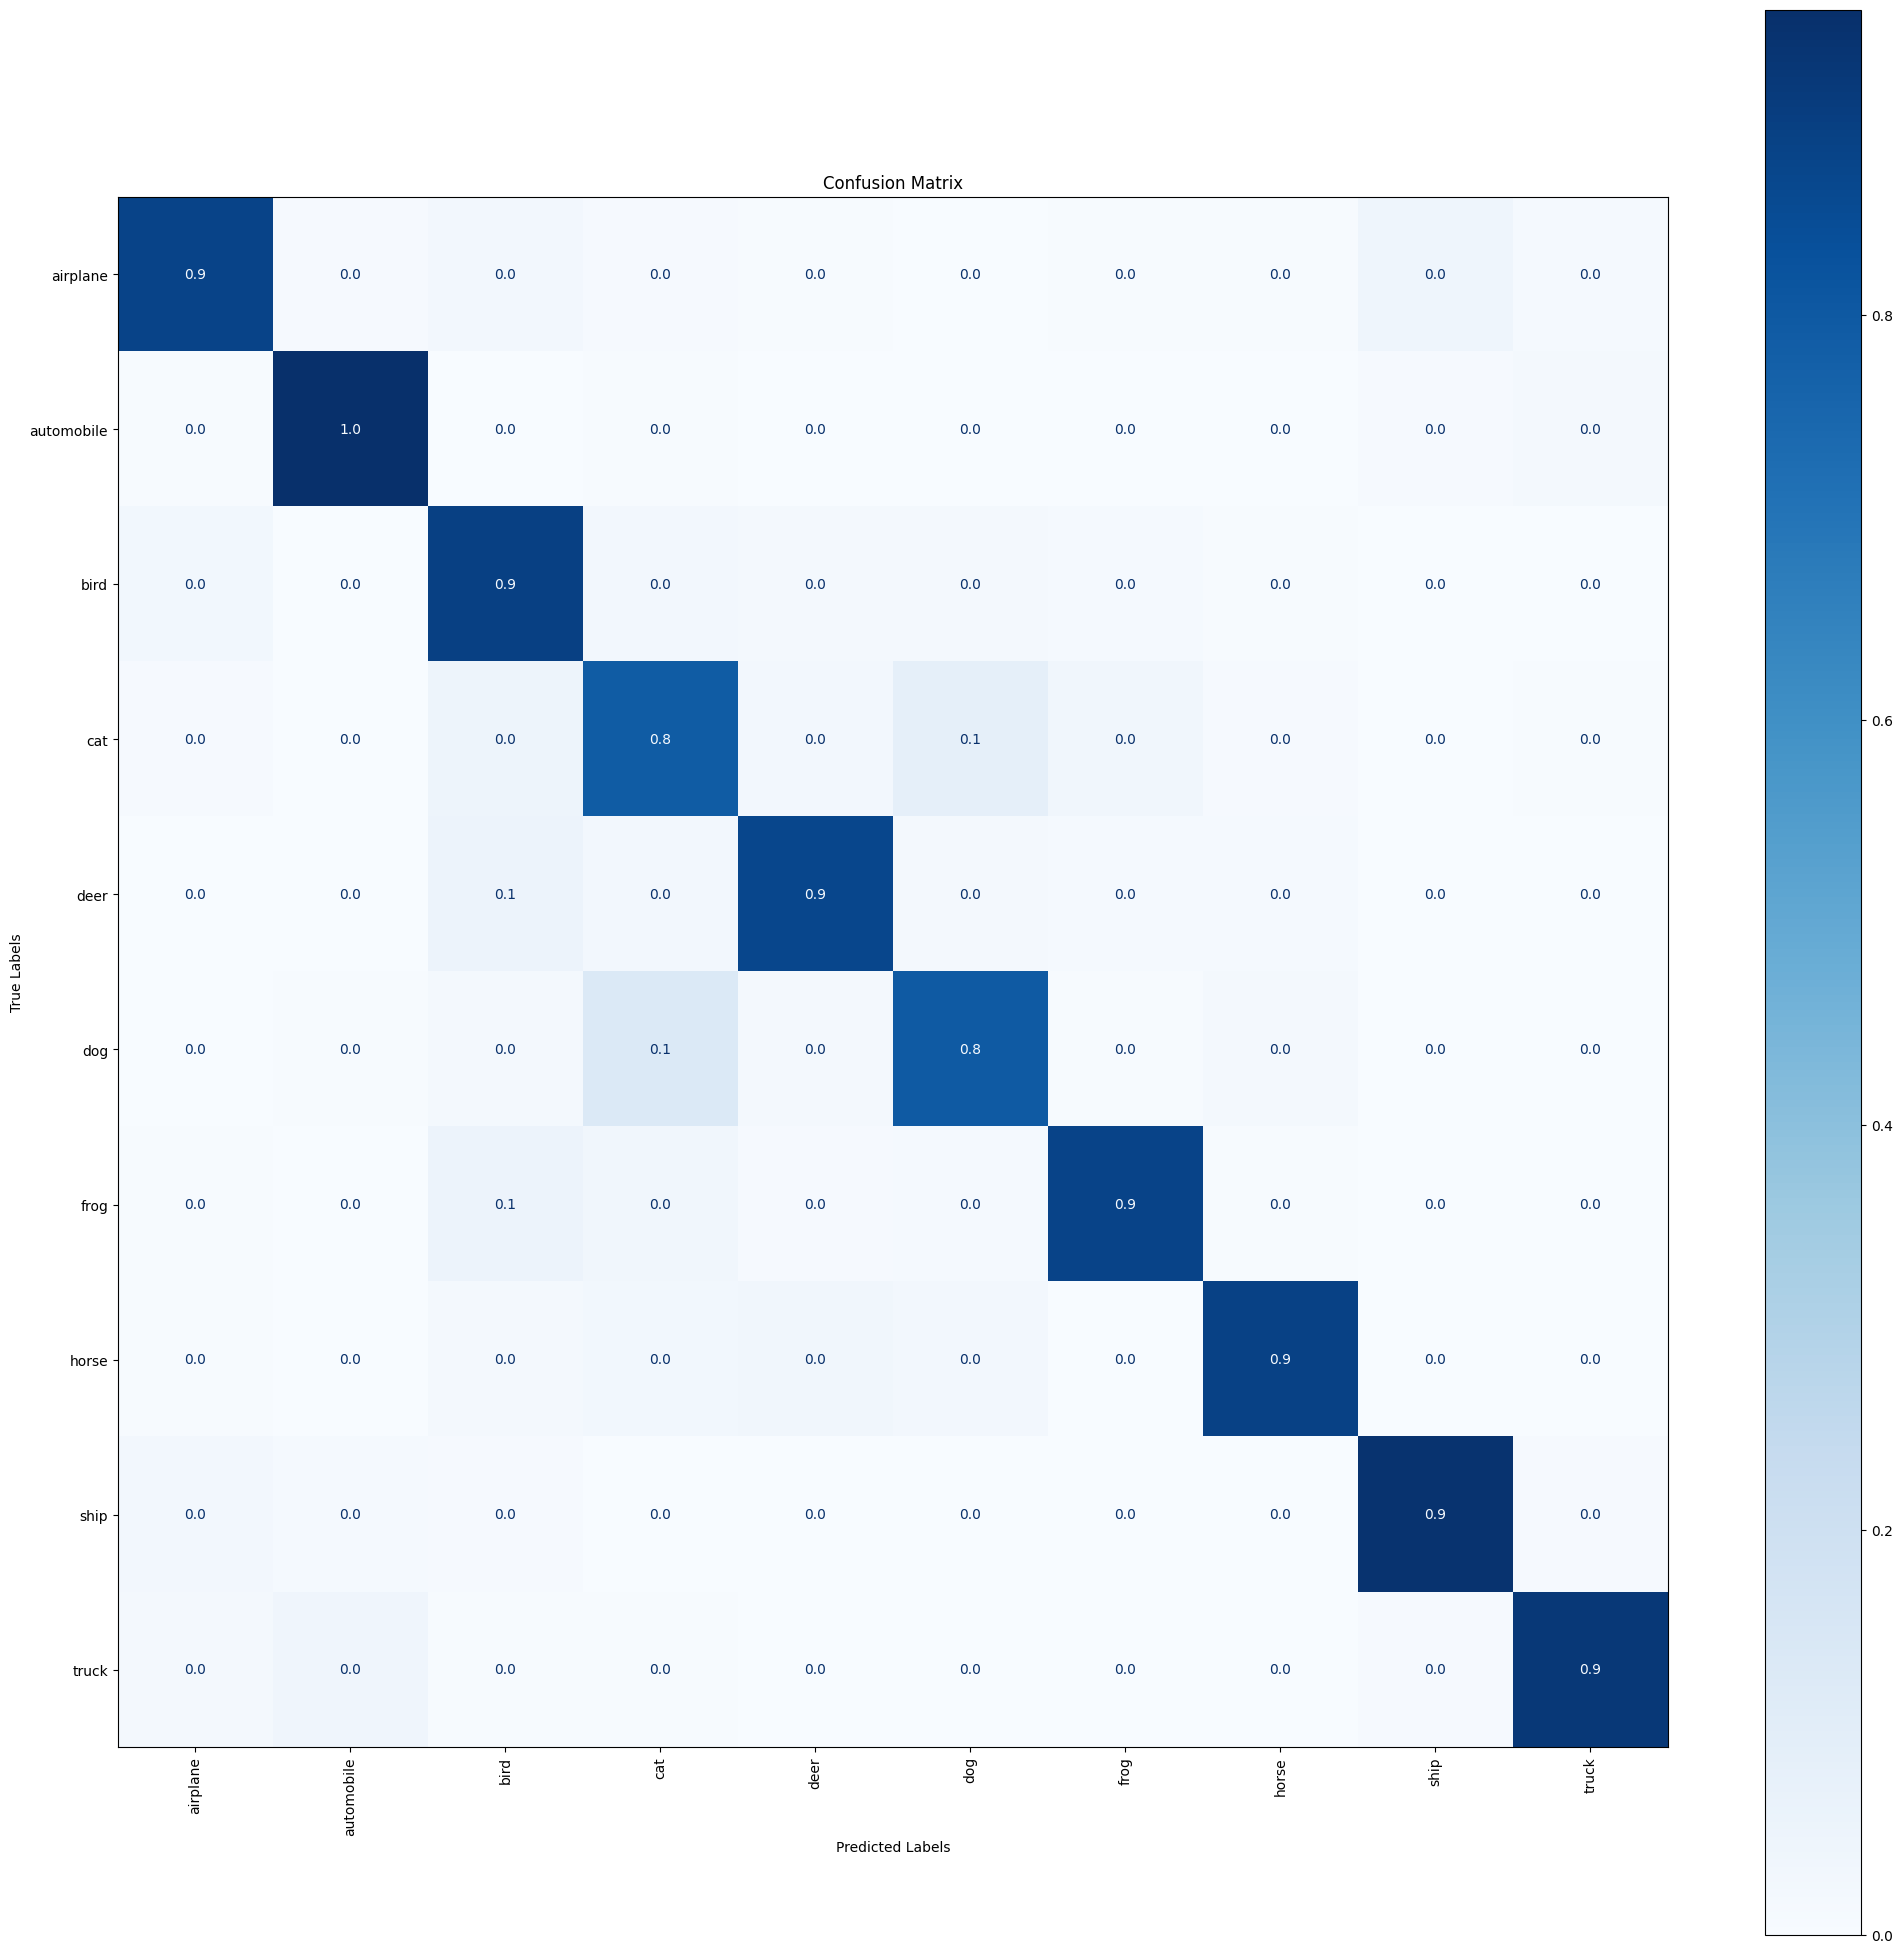

07/23 16:46:26 - mmengine - INFO - Epoch(val) [22][157/157]    accuracy/top1: 87.8700  accuracy/top5: 99.1800  loss/loss: 1.6899  data_time: 0.0096  time: 0.0897
07/23 16:46:26 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_21.pth is removed
07/23 16:46:26 - mmengine - INFO - The best checkpoint with 87.8700 accuracy/top1 at 22 epoch is saved to best_accuracy_top1_epoch_22.pth.
07/23 16:47:05 - mmengine - INFO - Epoch(train) [23][100/782]  base_lr: 5.2159e-04 lr: 2.2090e-04  eta: 1:28:53  time: 0.3820  data_time: 0.0916  memory: 3611  grad_norm: 1.3279  loss: 0.6052
07/23 16:47:43 - mmengine - INFO - Epoch(train) [23][200/782]  base_lr: 5.1591e-04 lr: 2.1856e-04  eta: 1:28:15  time: 0.3815  data_time: 0.0924  memory: 3611  grad_norm: 1.3093  loss: 0.6277
07/23 16:48:21 - mmengine - INFO - Epoch(train) [23][300/782]  base_lr: 5.1023e-04 lr: 2.1621e-04  eta: 1:27:37  time

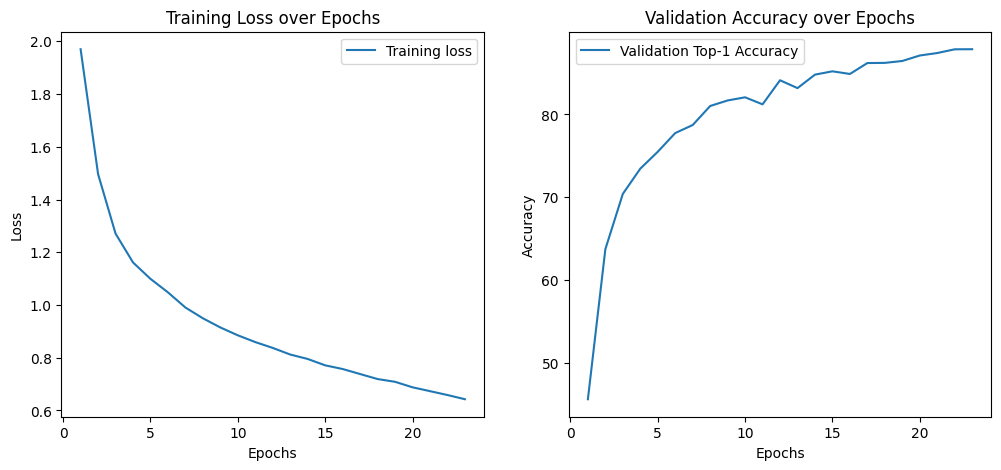

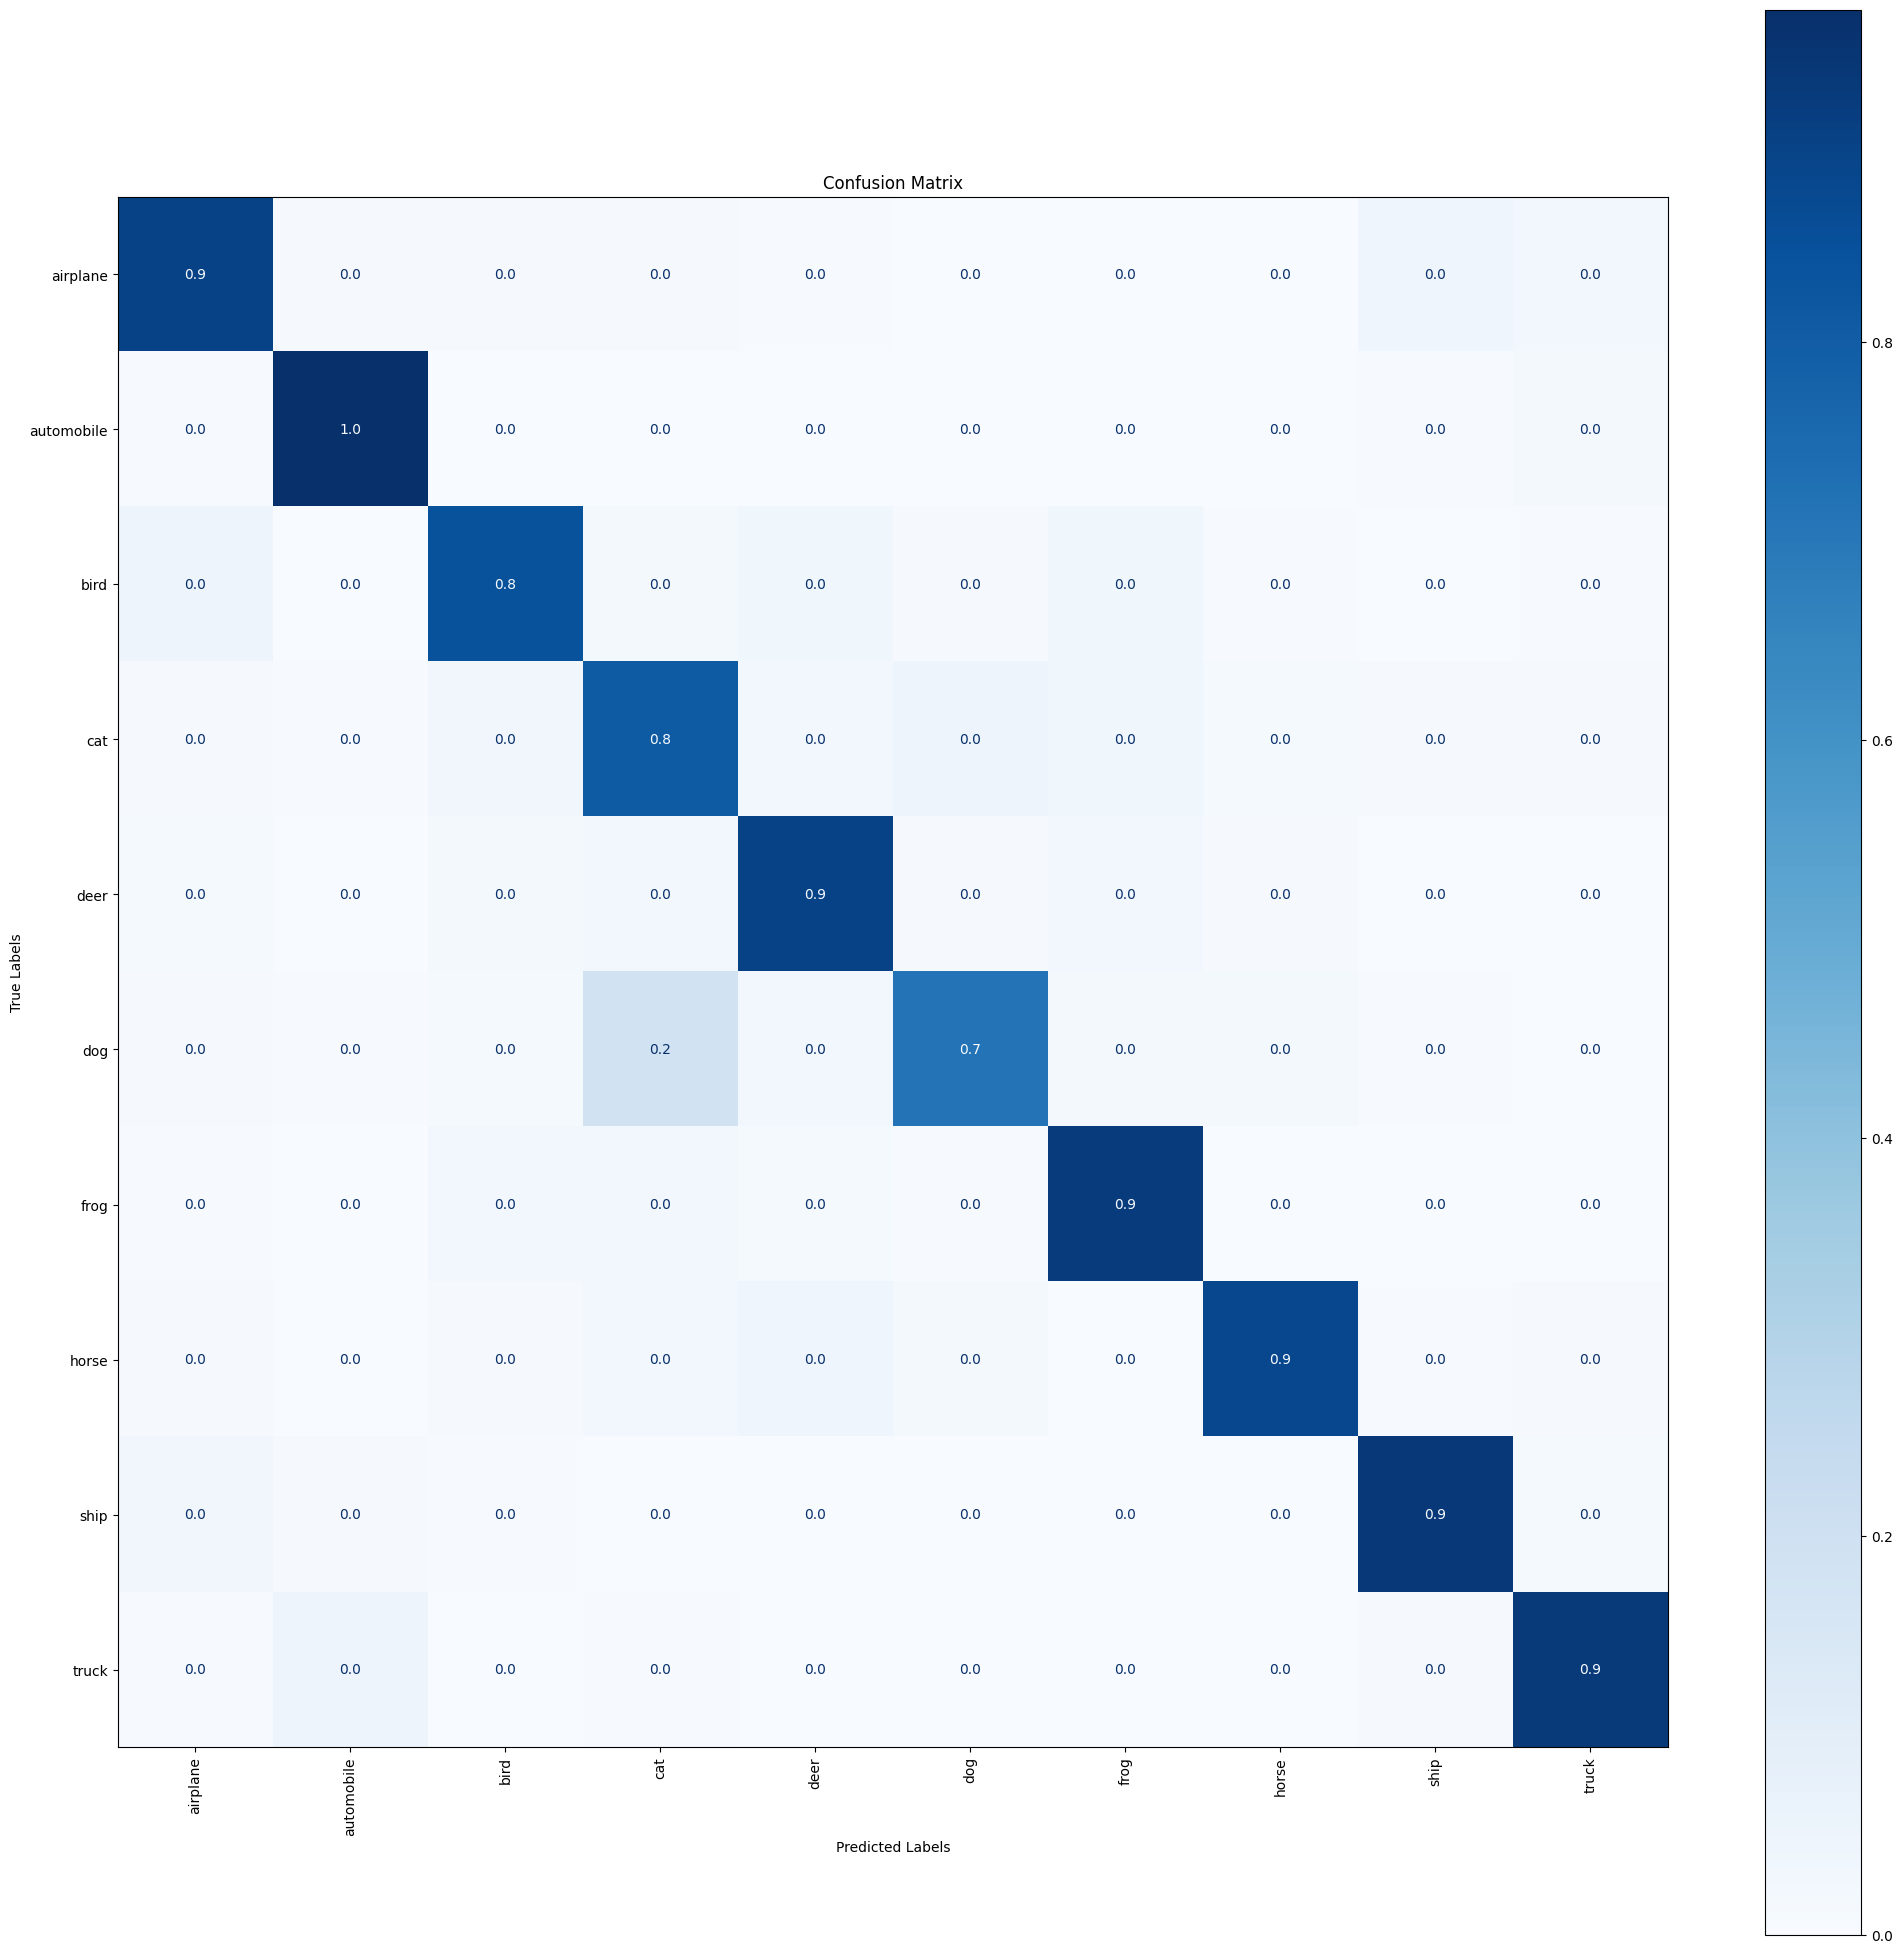

07/23 16:51:40 - mmengine - INFO - Epoch(val) [23][157/157]    accuracy/top1: 87.8800  accuracy/top5: 99.0500  loss/loss: 1.6844  data_time: 0.0100  time: 0.0896
07/23 16:51:40 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_22.pth is removed
07/23 16:51:41 - mmengine - INFO - The best checkpoint with 87.8800 accuracy/top1 at 23 epoch is saved to best_accuracy_top1_epoch_23.pth.
07/23 16:51:46 - mmengine - INFO - Exp name: 20240723_145117
07/23 16:52:19 - mmengine - INFO - Epoch(train) [24][100/782]  base_lr: 4.7717e-04 lr: 2.0259e-04  eta: 1:23:55  time: 0.3819  data_time: 0.0914  memory: 3611  grad_norm: 1.2555  loss: 0.6263
07/23 16:52:57 - mmengine - INFO - Epoch(train) [24][200/782]  base_lr: 4.7150e-04 lr: 2.0025e-04  eta: 1:23:17  time: 0.3806  data_time: 0.0919  memory: 3611  grad_norm: 1.5825  loss: 0.6599
07/23 16:53:36 - mmengine - INFO - Epoch(train) [24][300

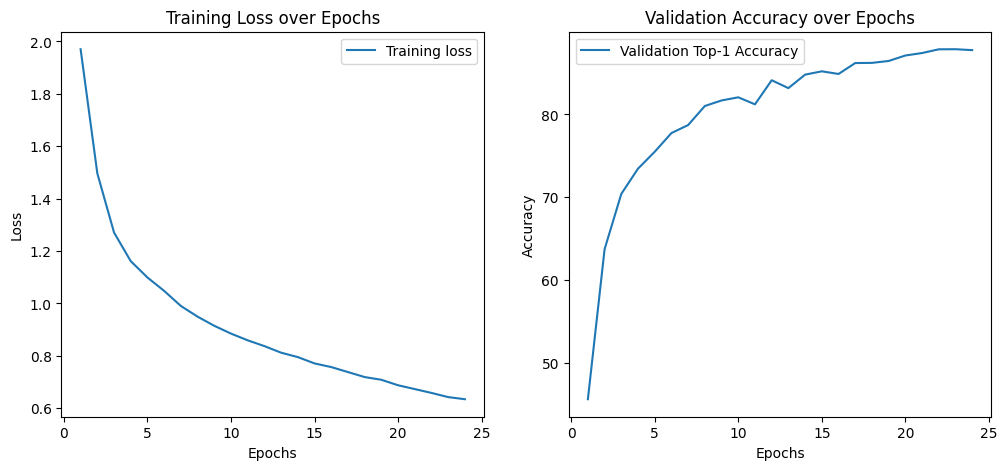

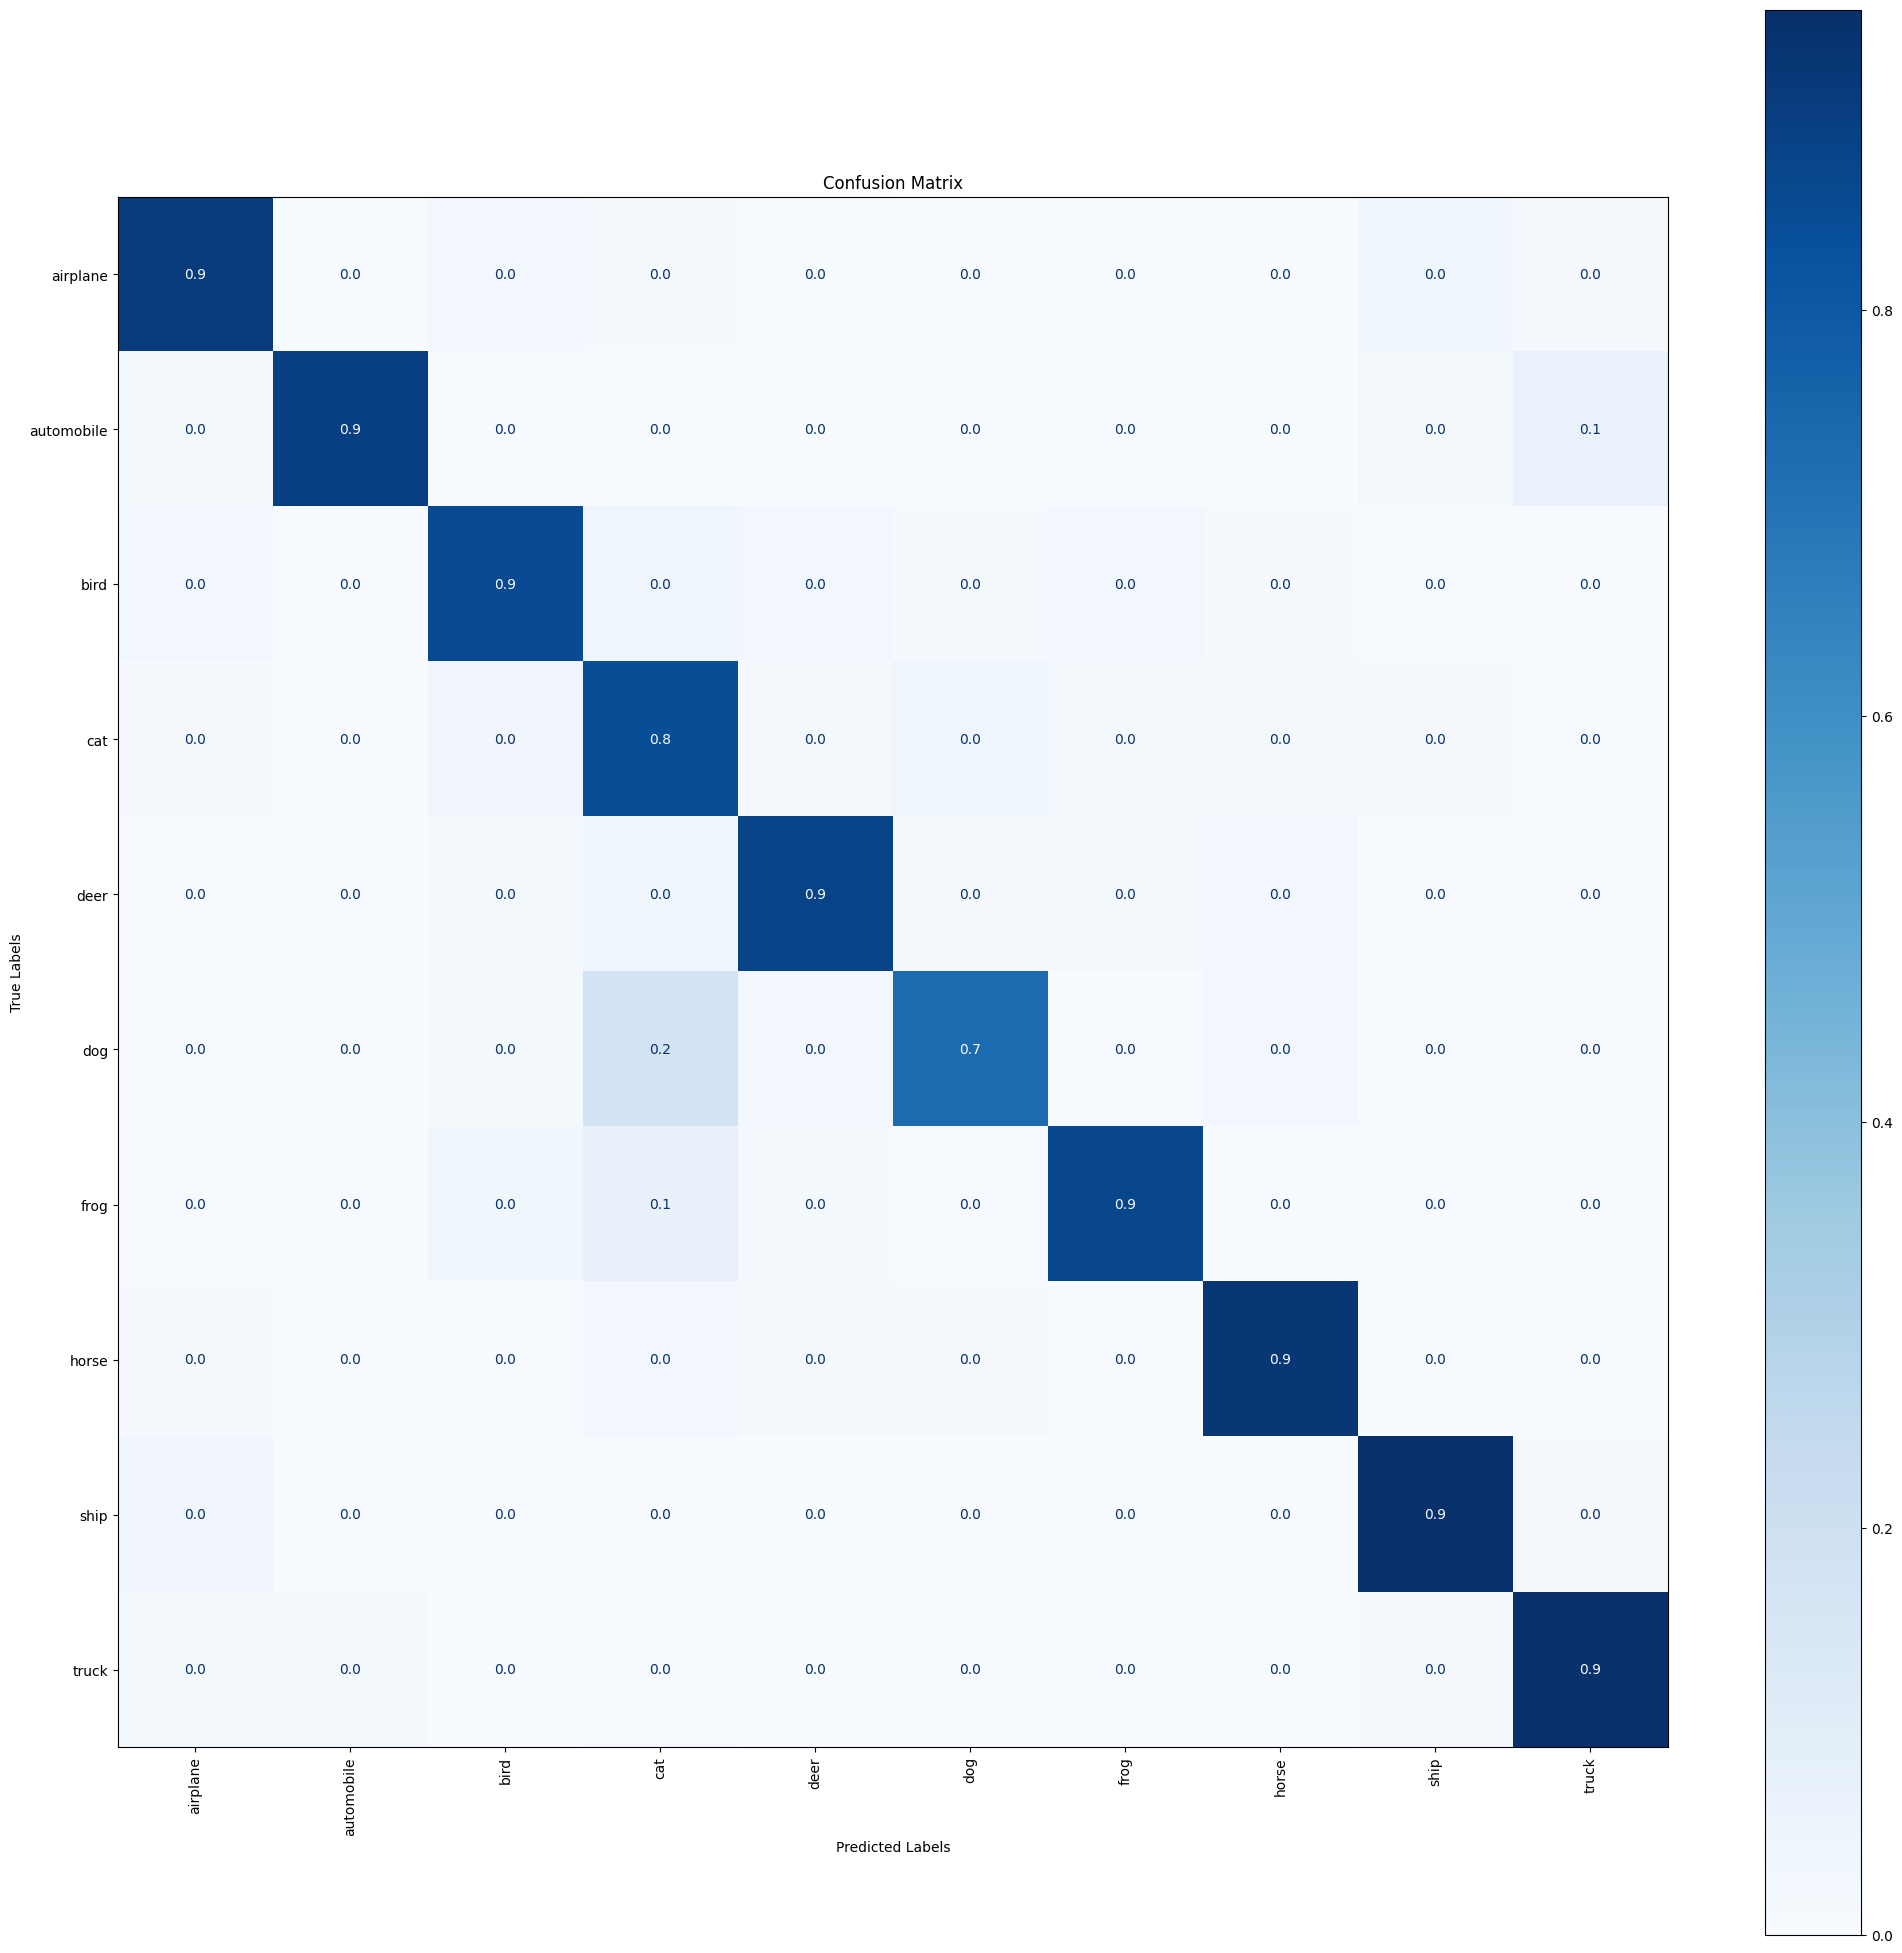

07/23 16:57:04 - mmengine - INFO - Epoch(val) [24][157/157]    accuracy/top1: 87.7700  accuracy/top5: 99.2100  loss/loss: 1.6797  data_time: 0.0108  time: 0.0954
07/23 16:57:44 - mmengine - INFO - Epoch(train) [25][100/782]  base_lr: 4.3298e-04 lr: 1.8437e-04  eta: 1:19:03  time: 0.4128  data_time: 0.1018  memory: 3611  grad_norm: 1.6514  loss: 0.6275
07/23 16:58:24 - mmengine - INFO - Epoch(train) [25][200/782]  base_lr: 4.2737e-04 lr: 1.8206e-04  eta: 1:18:26  time: 0.3848  data_time: 0.0924  memory: 3611  grad_norm: 1.4119  loss: 0.5981
07/23 16:58:36 - mmengine - INFO - Exp name: 20240723_145117
07/23 16:59:02 - mmengine - INFO - Epoch(train) [25][300/782]  base_lr: 4.2176e-04 lr: 1.7975e-04  eta: 1:17:48  time: 0.3821  data_time: 0.0925  memory: 3611  grad_norm: 1.3139  loss: 0.6136
07/23 16:59:40 - mmengine - INFO - Epoch(train) [25][400/782]  base_lr: 4.1617e-04 lr: 1.7744e-04  eta: 1:17:10  time: 0.3801  data_time: 0.0915  memory: 3611  grad_norm: 1.5471  loss: 0.6271
07/23 17:

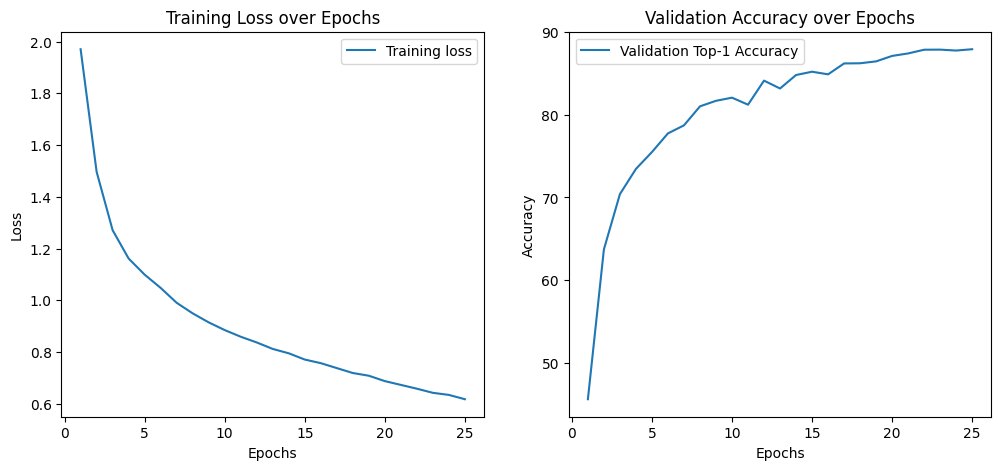

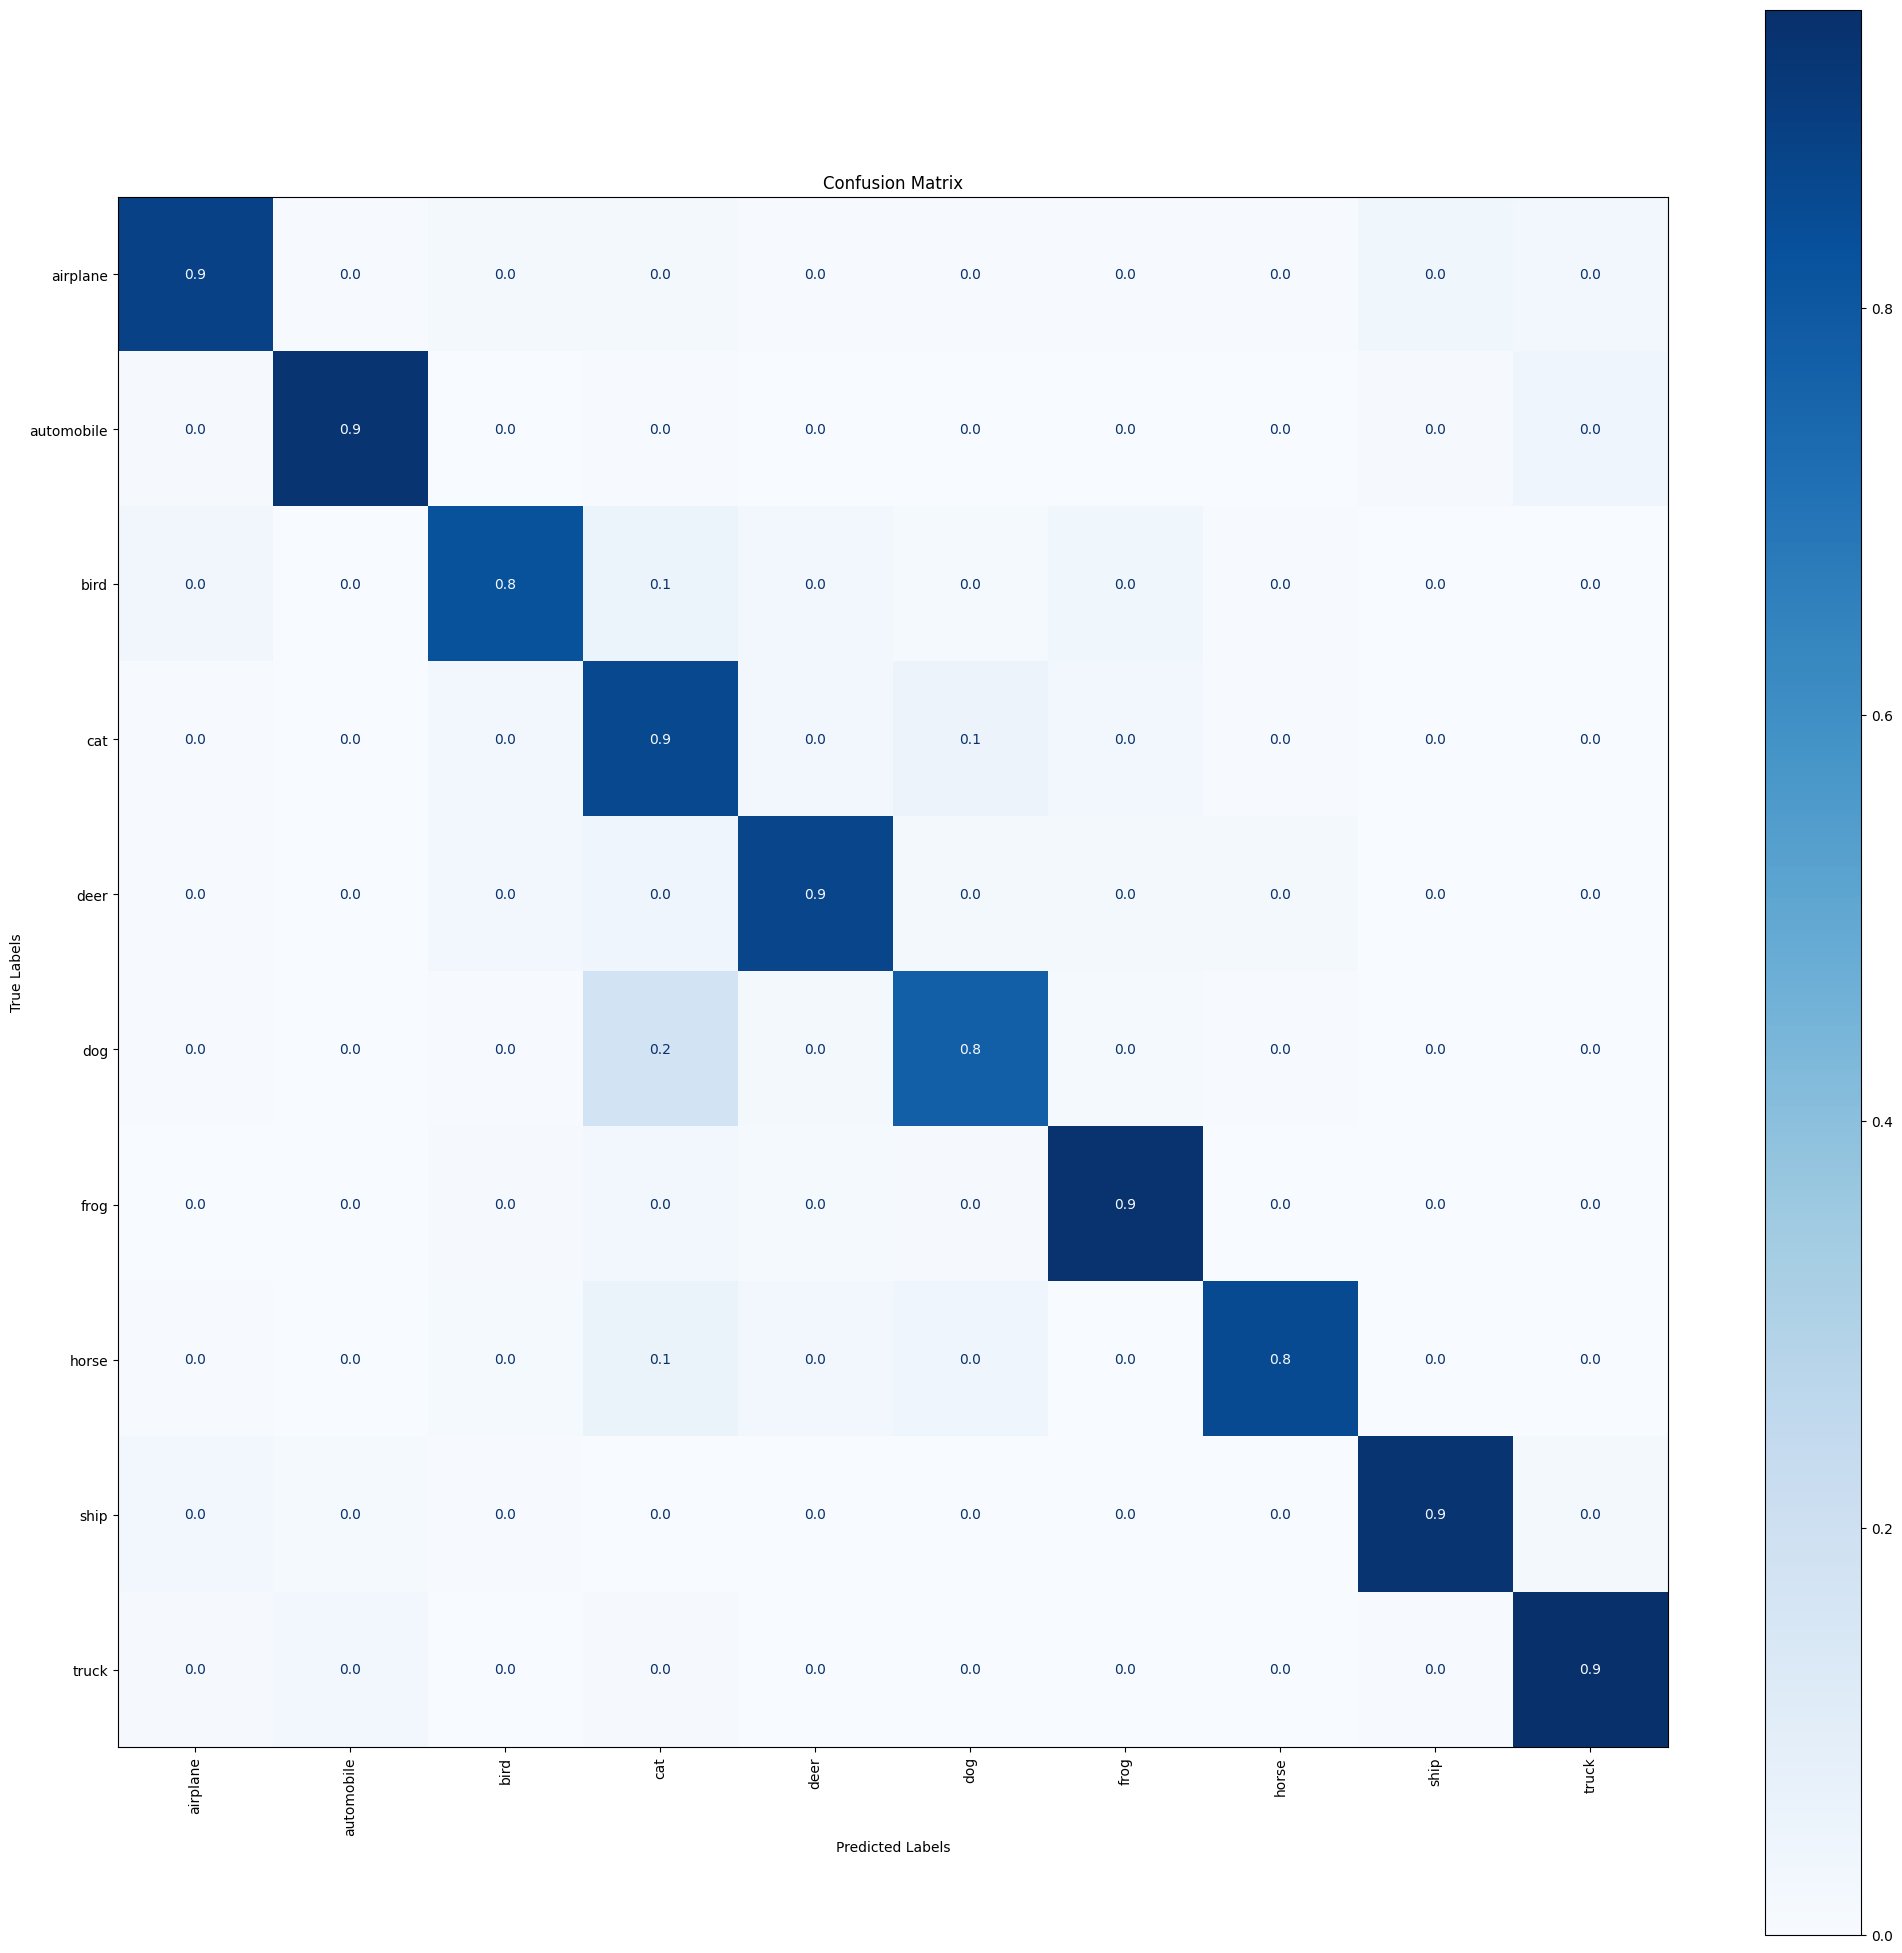

07/23 17:02:21 - mmengine - INFO - Epoch(val) [25][157/157]    accuracy/top1: 87.9300  accuracy/top5: 99.0500  loss/loss: 1.6755  data_time: 0.0101  time: 0.0894
07/23 17:02:21 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_23.pth is removed
07/23 17:02:21 - mmengine - INFO - The best checkpoint with 87.9300 accuracy/top1 at 25 epoch is saved to best_accuracy_top1_epoch_25.pth.
07/23 17:03:00 - mmengine - INFO - Epoch(train) [26][100/782]  base_lr: 3.8938e-04 lr: 1.6639e-04  eta: 1:14:05  time: 0.3904  data_time: 0.0941  memory: 3611  grad_norm: 1.2102  loss: 0.5966
07/23 17:03:39 - mmengine - INFO - Epoch(train) [26][200/782]  base_lr: 3.8386e-04 lr: 1.6412e-04  eta: 1:13:27  time: 0.3805  data_time: 0.0918  memory: 3611  grad_norm: 1.3844  loss: 0.5863
07/23 17:04:17 - mmengine - INFO - Epoch(train) [26][300/782]  base_lr: 3.7836e-04 lr: 1.6185e-04  eta: 1:12:49  time

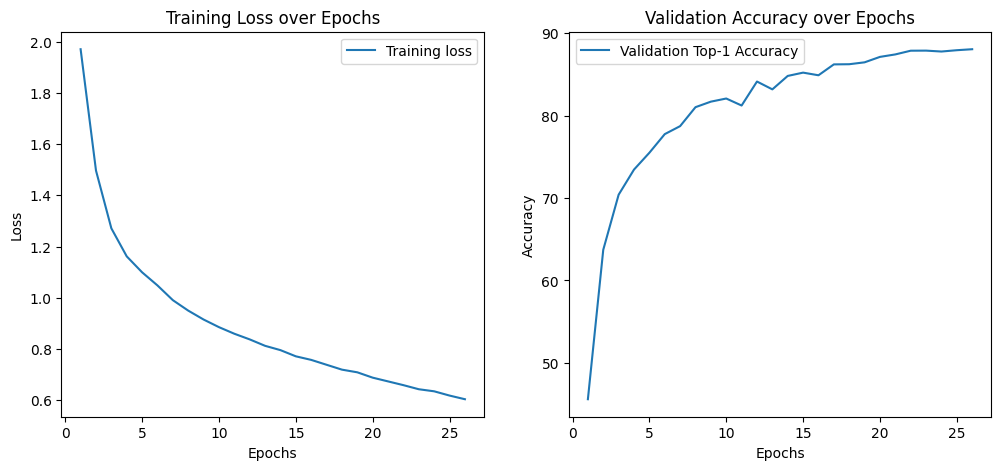

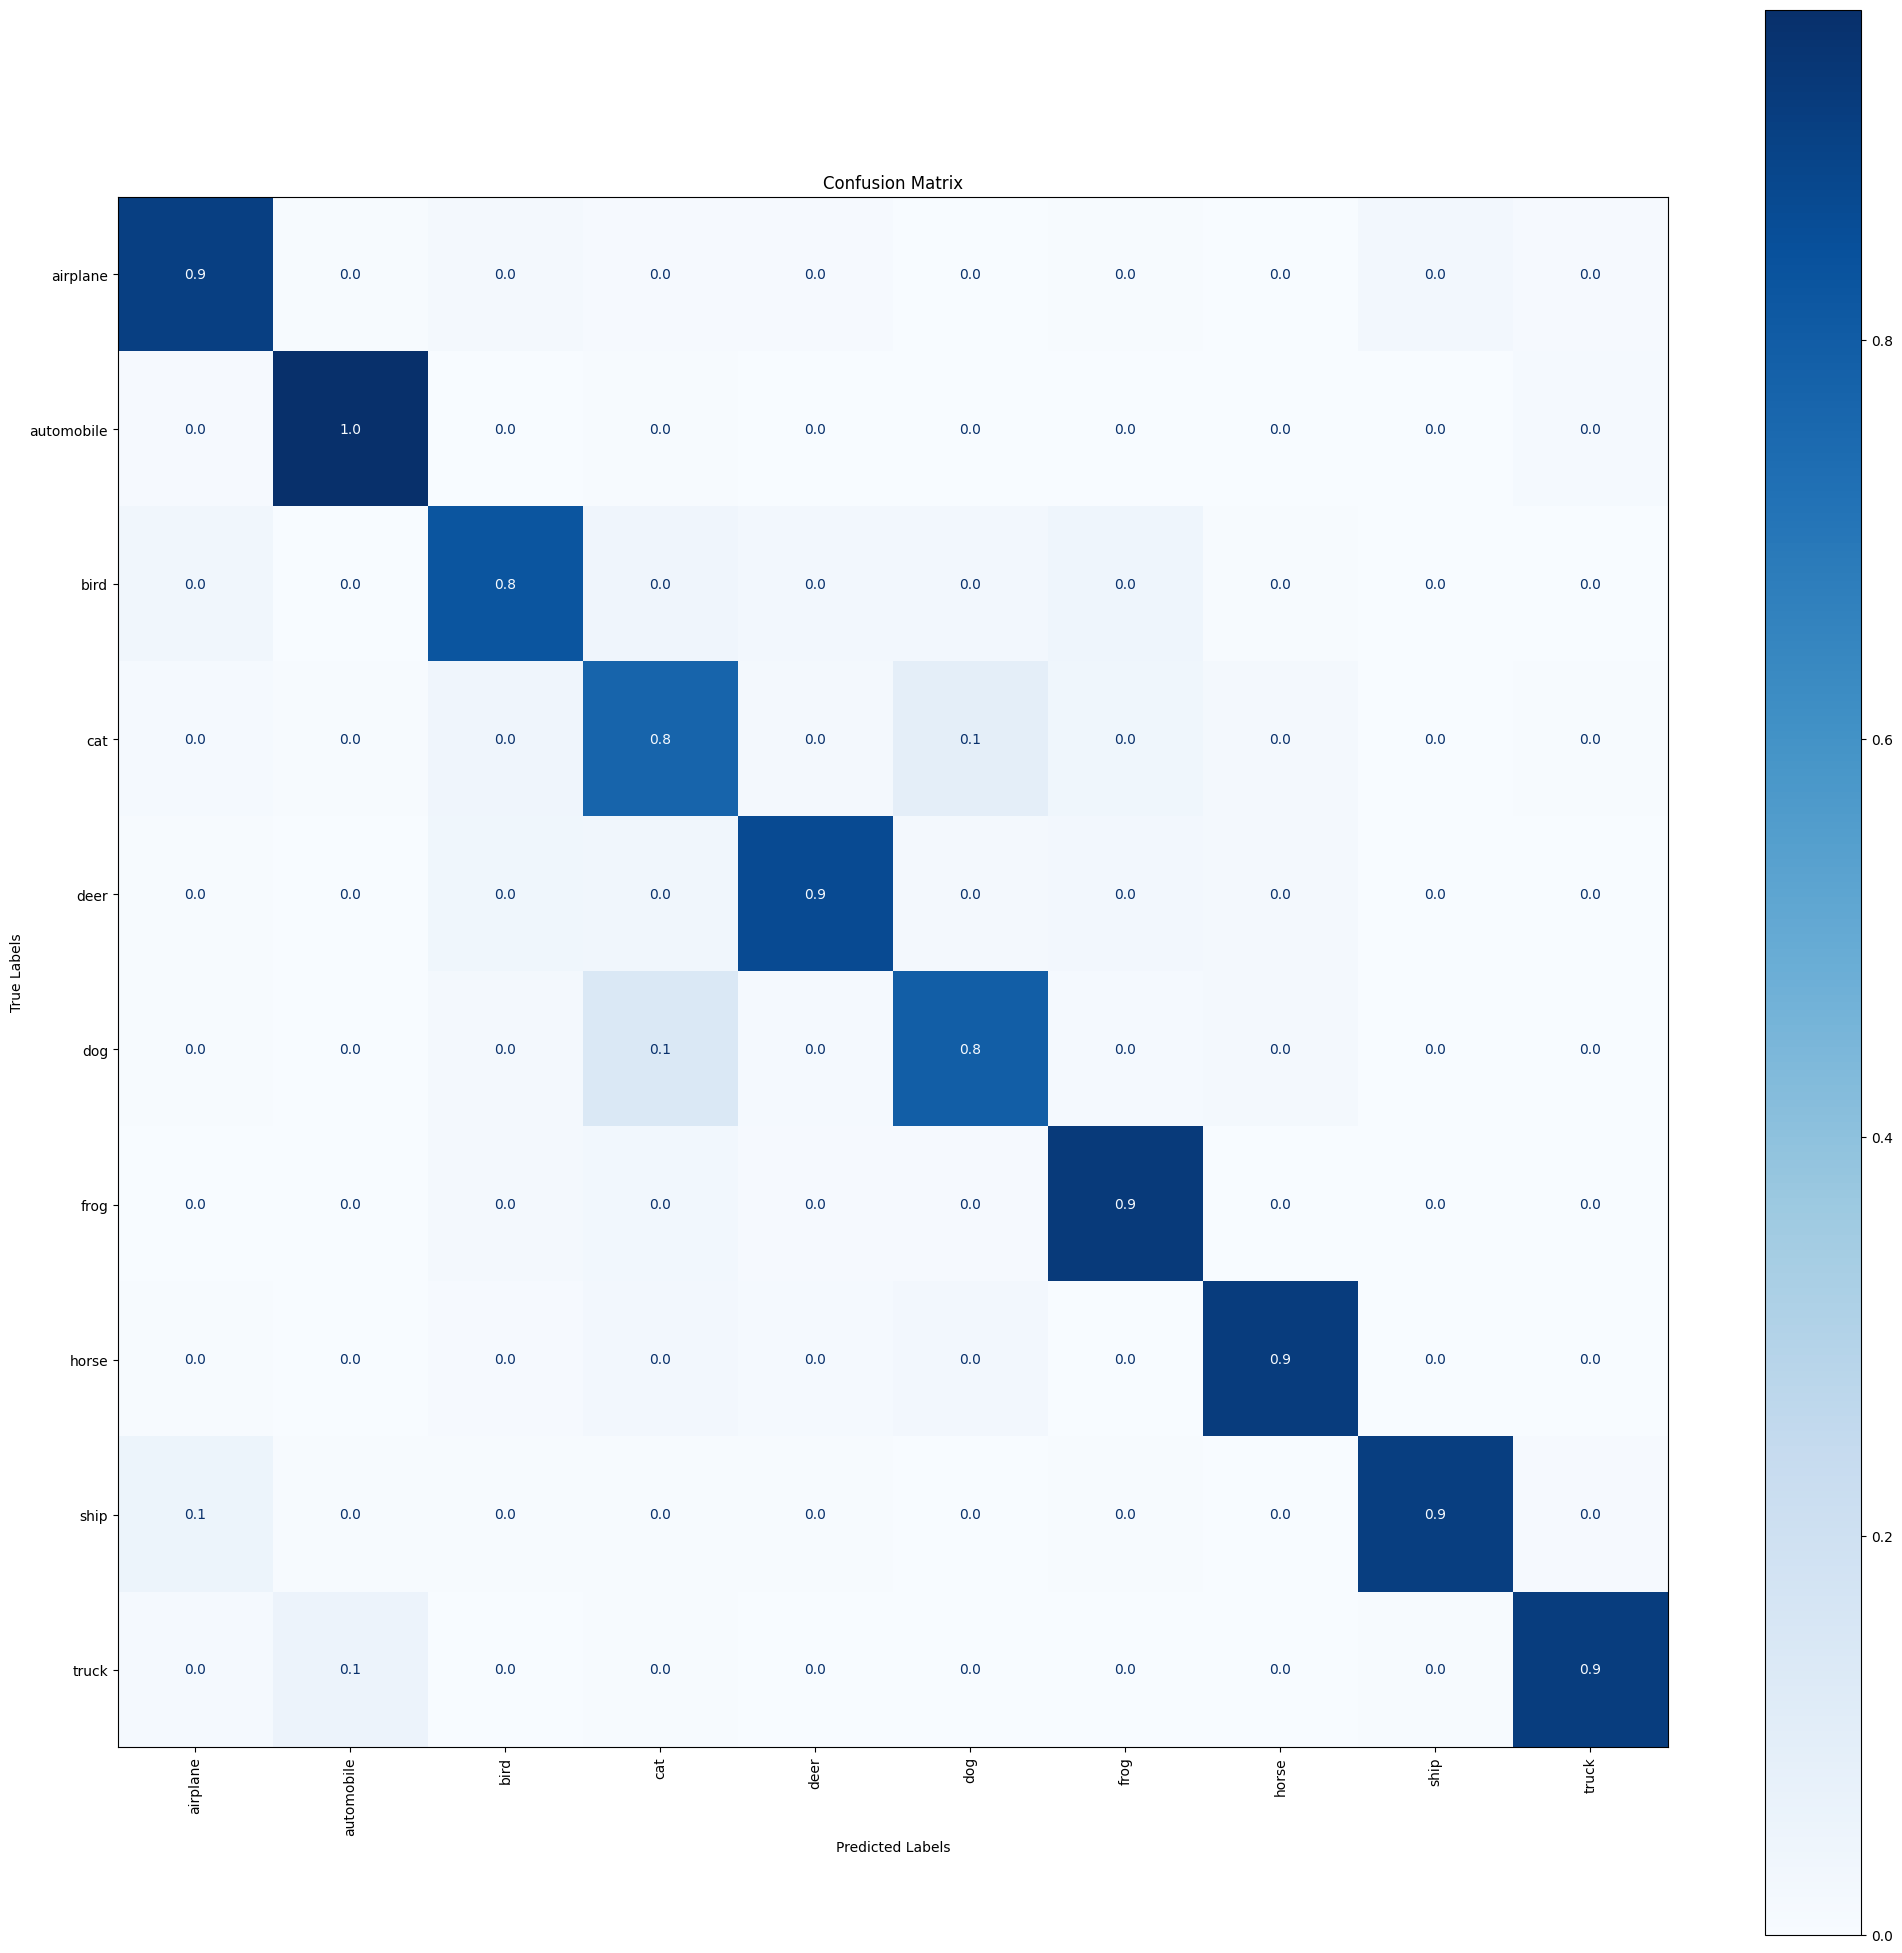

07/23 17:07:35 - mmengine - INFO - Epoch(val) [26][157/157]    accuracy/top1: 88.0500  accuracy/top5: 99.1800  loss/loss: 1.6713  data_time: 0.0101  time: 0.0899
07/23 17:07:35 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_25.pth is removed
07/23 17:07:36 - mmengine - INFO - The best checkpoint with 88.0500 accuracy/top1 at 26 epoch is saved to best_accuracy_top1_epoch_26.pth.
07/23 17:08:14 - mmengine - INFO - Epoch(train) [27][100/782]  base_lr: 3.4670e-04 lr: 1.4880e-04  eta: 1:09:06  time: 0.3814  data_time: 0.0920  memory: 3611  grad_norm: 1.5585  loss: 0.5998
07/23 17:08:52 - mmengine - INFO - Epoch(train) [27][200/782]  base_lr: 3.4132e-04 lr: 1.4659e-04  eta: 1:08:28  time: 0.3808  data_time: 0.0918  memory: 3611  grad_norm: 1.3453  loss: 0.6066
07/23 17:09:31 - mmengine - INFO - Epoch(train) [27][300/782]  base_lr: 3.3597e-04 lr: 1.4438e-04  eta: 1:07:49  time

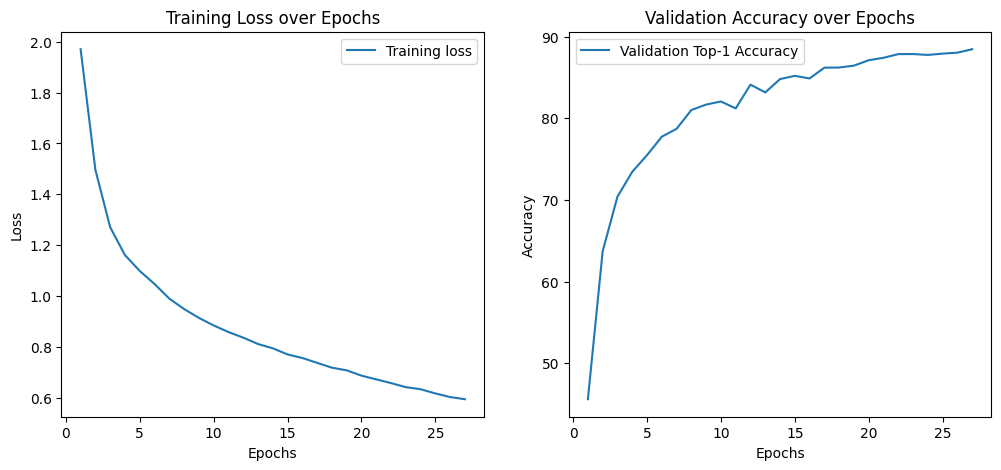

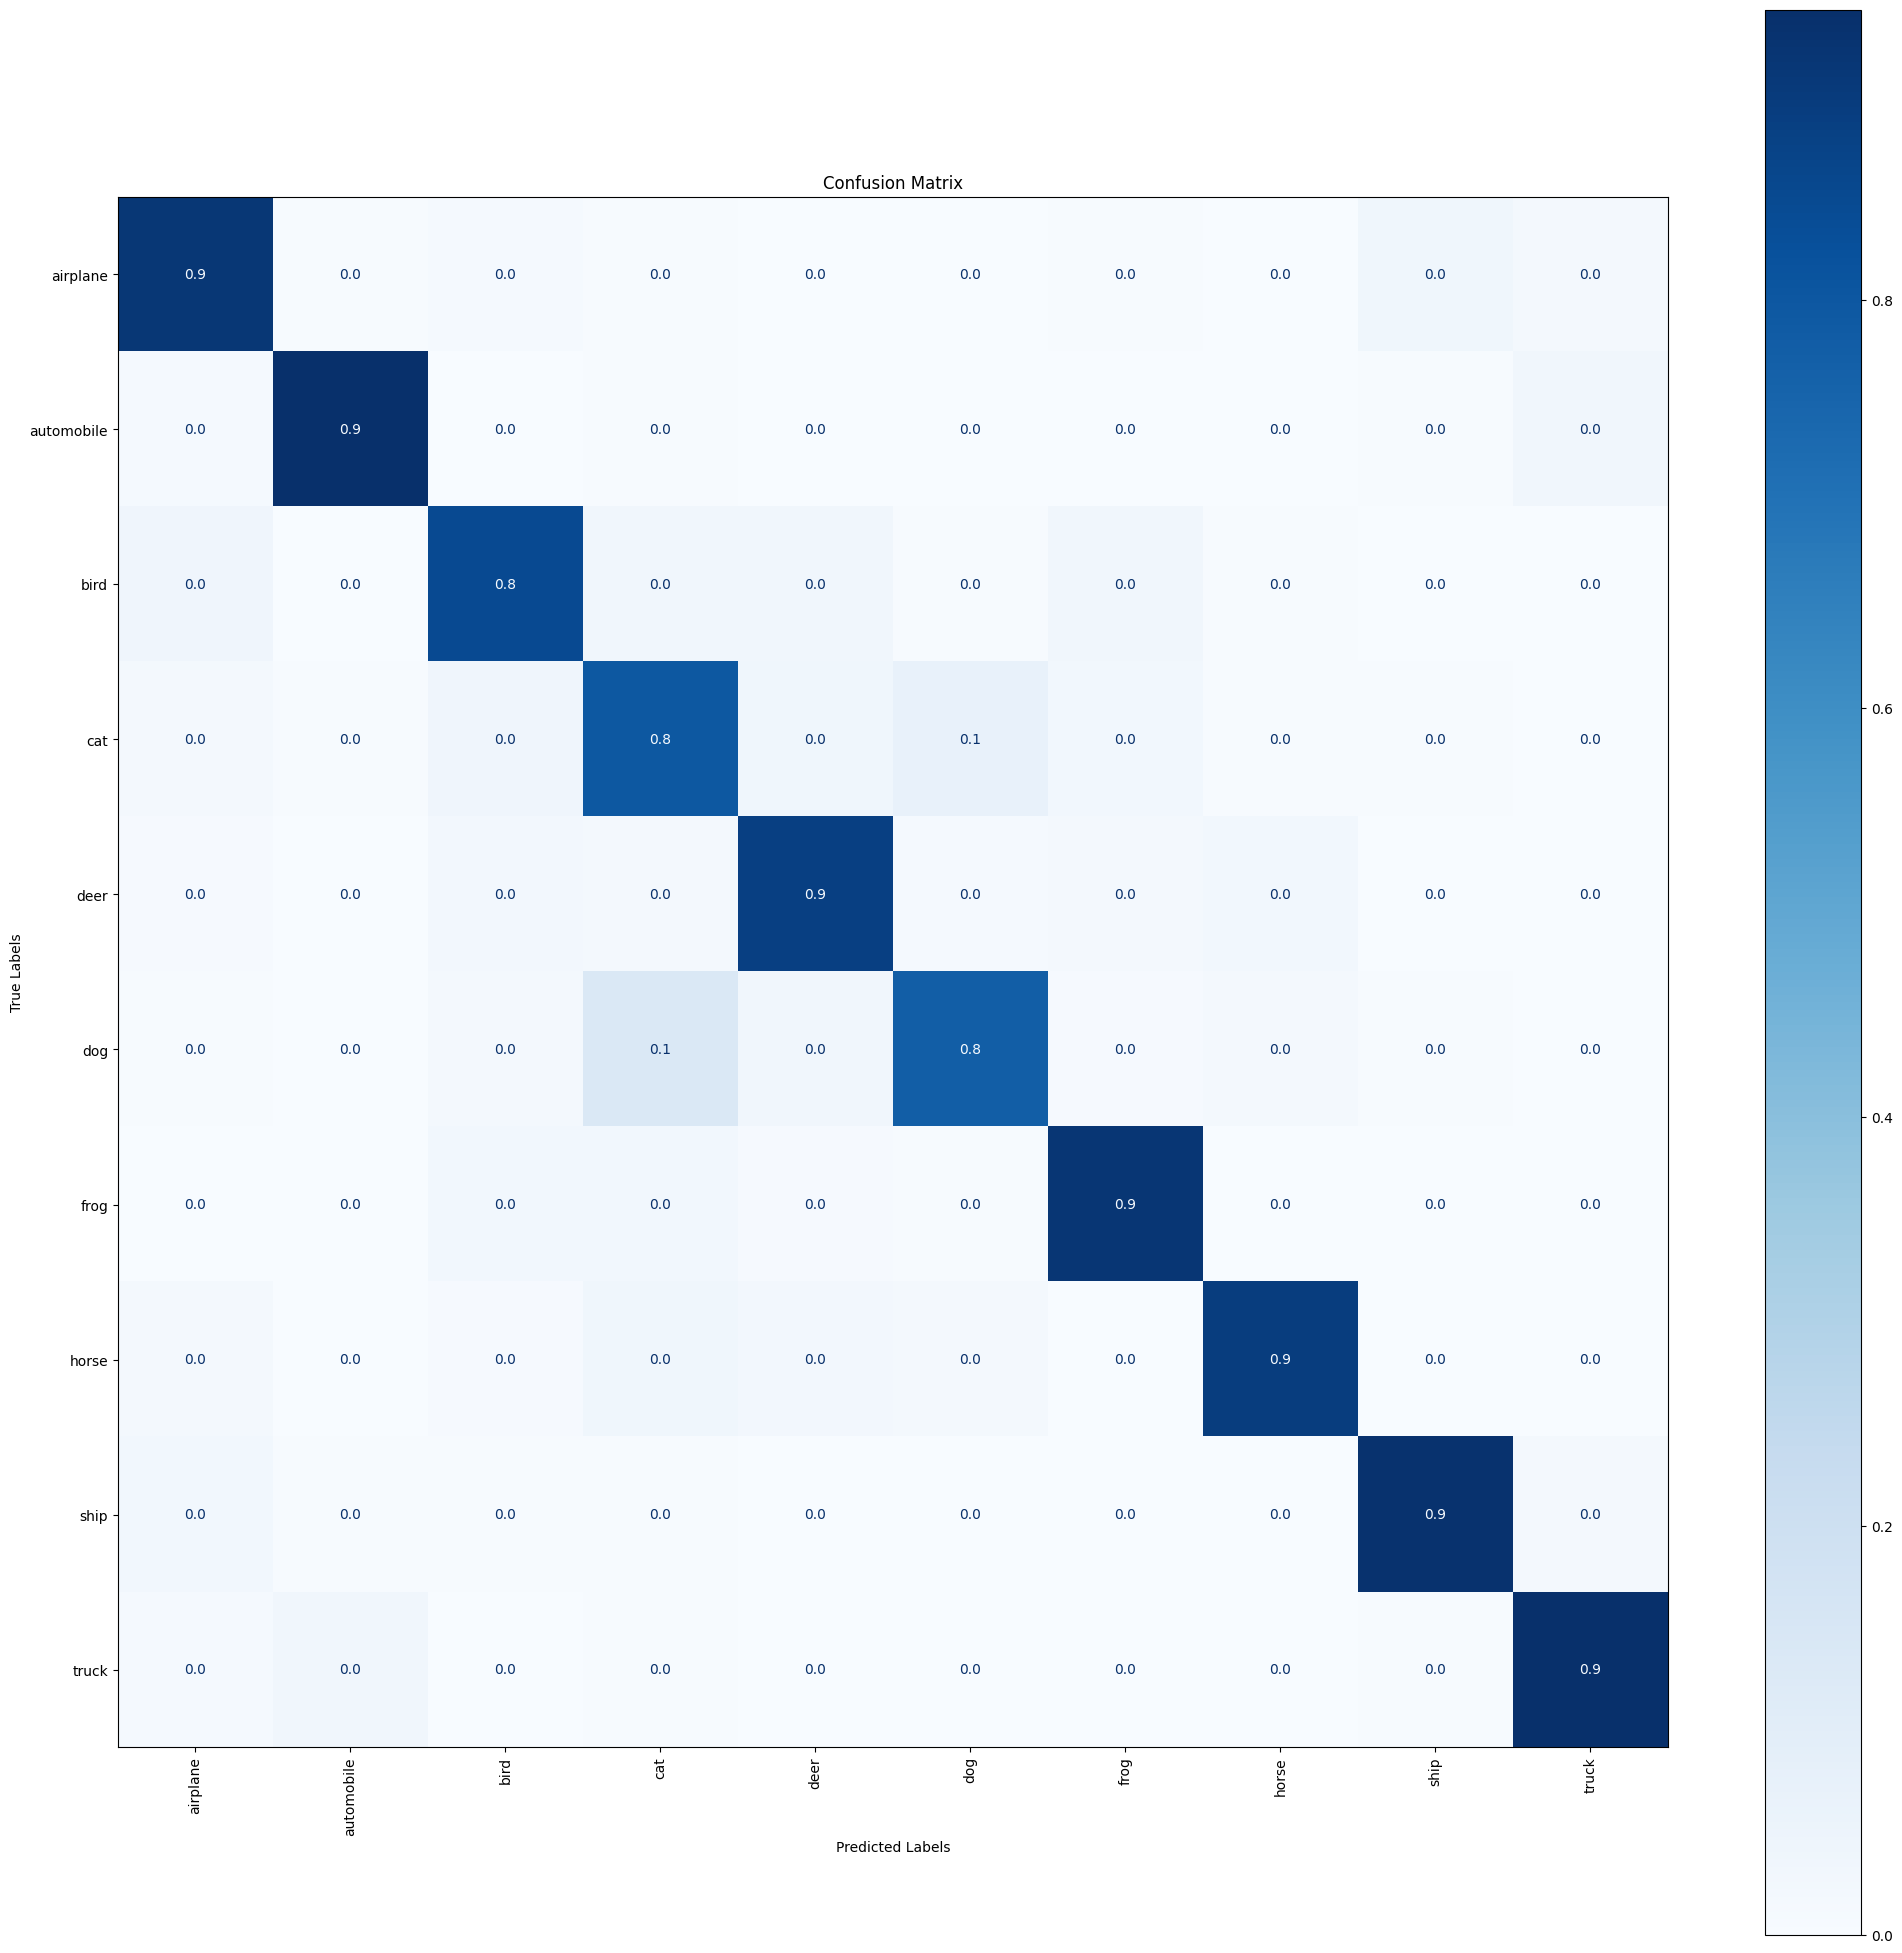

07/23 17:12:56 - mmengine - INFO - Epoch(val) [27][157/157]    accuracy/top1: 88.4700  accuracy/top5: 99.0200  loss/loss: 1.6672  data_time: 0.0106  time: 0.0953
07/23 17:12:56 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_26.pth is removed
07/23 17:12:56 - mmengine - INFO - The best checkpoint with 88.4700 accuracy/top1 at 27 epoch is saved to best_accuracy_top1_epoch_27.pth.
07/23 17:13:37 - mmengine - INFO - Epoch(train) [28][100/782]  base_lr: 3.0529e-04 lr: 1.3173e-04  eta: 1:04:10  time: 0.4110  data_time: 0.0970  memory: 3611  grad_norm: 1.2347  loss: 0.5791
07/23 17:14:16 - mmengine - INFO - Epoch(train) [28][200/782]  base_lr: 3.0011e-04 lr: 1.2959e-04  eta: 1:03:33  time: 0.3995  data_time: 0.0963  memory: 3611  grad_norm: 1.2955  loss: 0.5870
07/23 17:14:55 - mmengine - INFO - Epoch(train) [28][300/782]  base_lr: 2.9495e-04 lr: 1.2747e-04  eta: 1:02:55  time

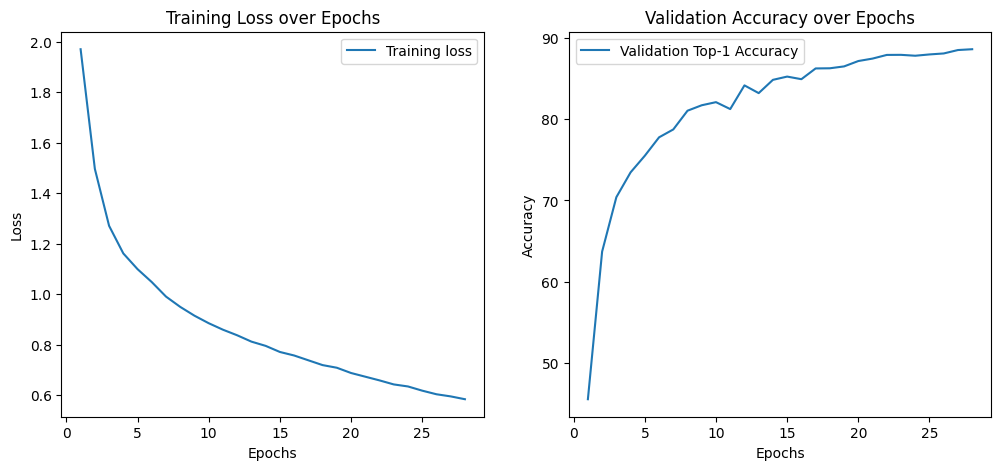

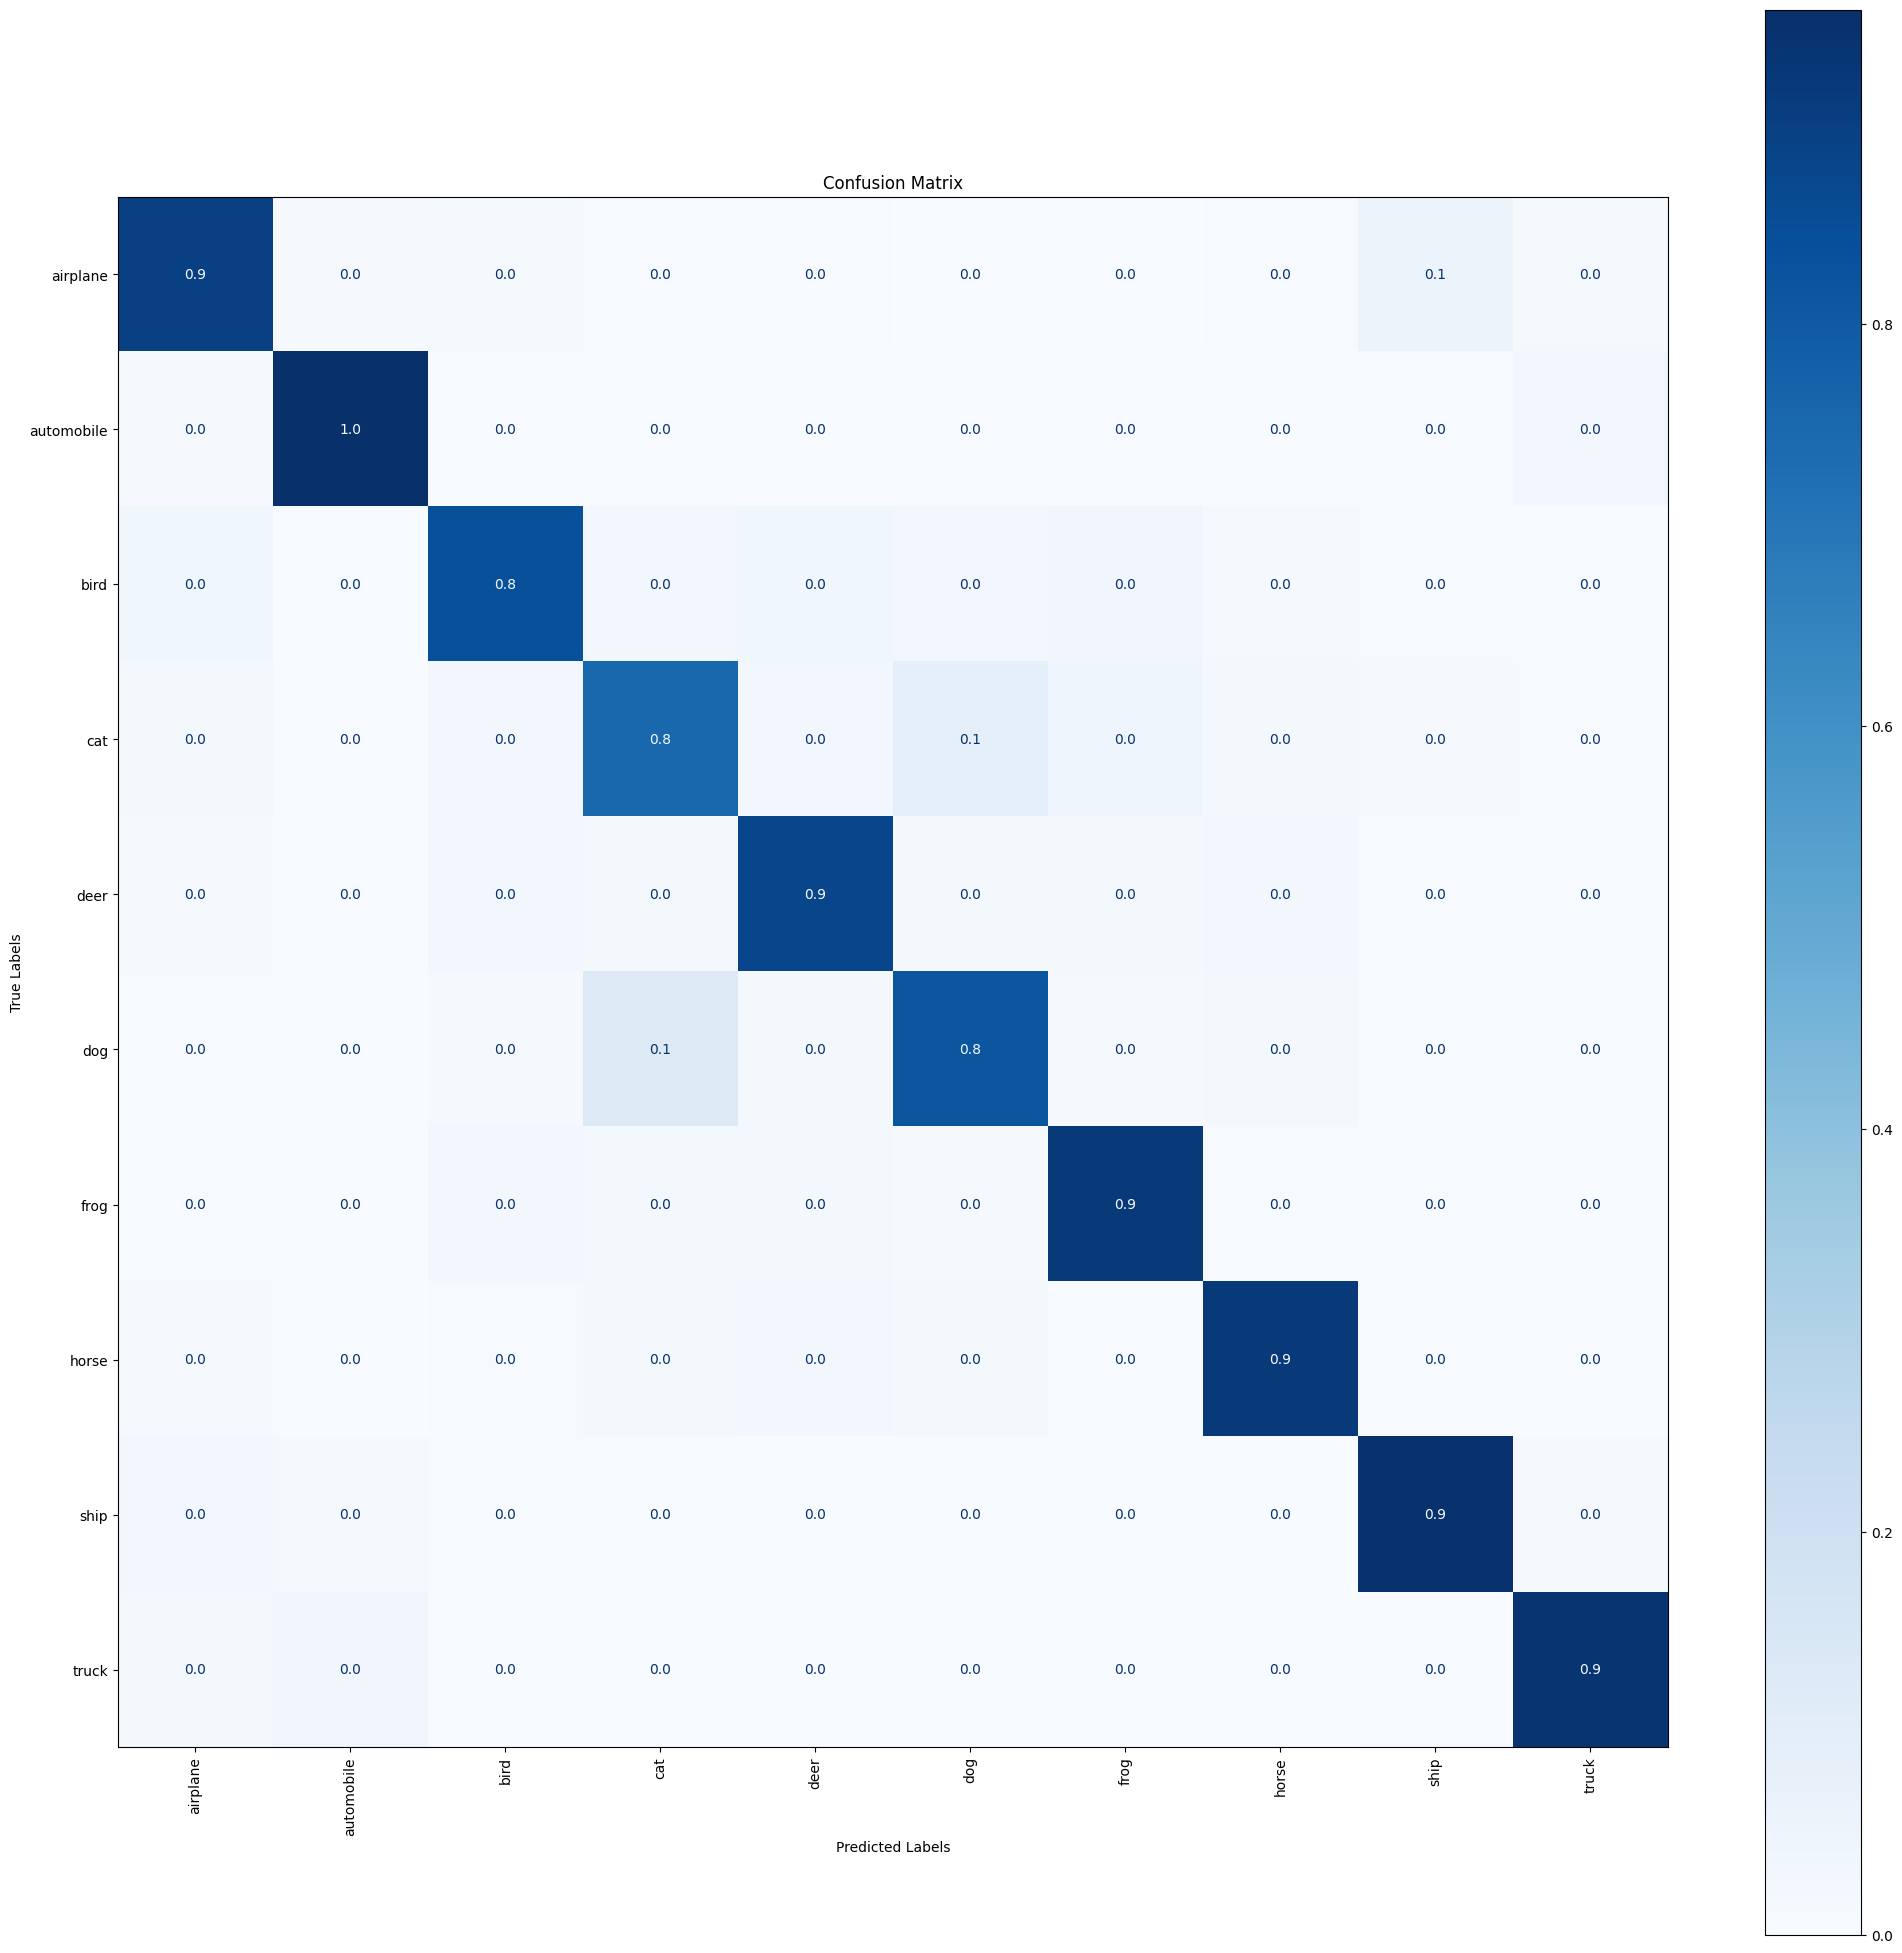

07/23 17:18:17 - mmengine - INFO - Epoch(val) [28][157/157]    accuracy/top1: 88.5700  accuracy/top5: 98.9900  loss/loss: 1.6635  data_time: 0.0101  time: 0.0908
07/23 17:18:17 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_27.pth is removed
07/23 17:18:17 - mmengine - INFO - The best checkpoint with 88.5700 accuracy/top1 at 28 epoch is saved to best_accuracy_top1_epoch_28.pth.
07/23 17:18:57 - mmengine - INFO - Epoch(train) [29][100/782]  base_lr: 2.6550e-04 lr: 1.1533e-04  eta: 0:59:13  time: 0.3809  data_time: 0.0917  memory: 3611  grad_norm: 1.2317  loss: 0.5816
07/23 17:18:58 - mmengine - INFO - Exp name: 20240723_145117
07/23 17:19:35 - mmengine - INFO - Epoch(train) [29][200/782]  base_lr: 2.6054e-04 lr: 1.1328e-04  eta: 0:58:35  time: 0.3800  data_time: 0.0913  memory: 3611  grad_norm: 1.2747  loss: 0.5868
07/23 17:20:13 - mmengine - INFO - Epoch(train) [29][300

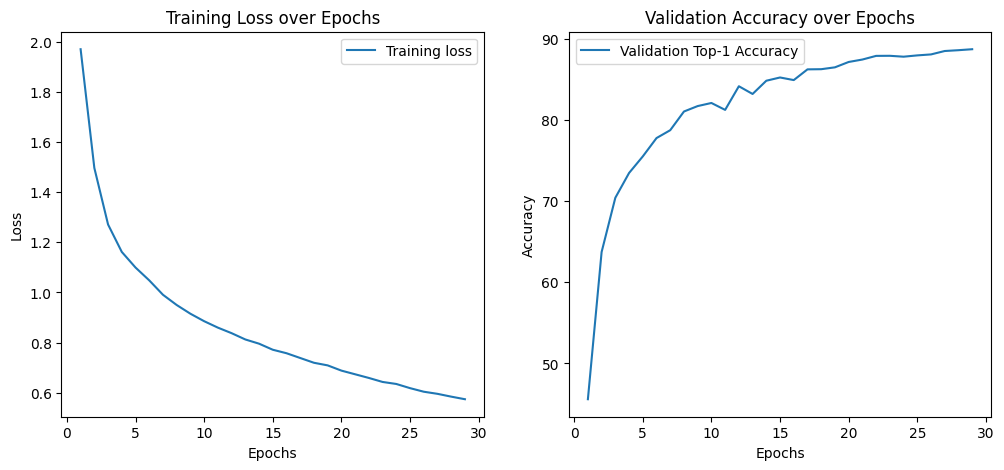

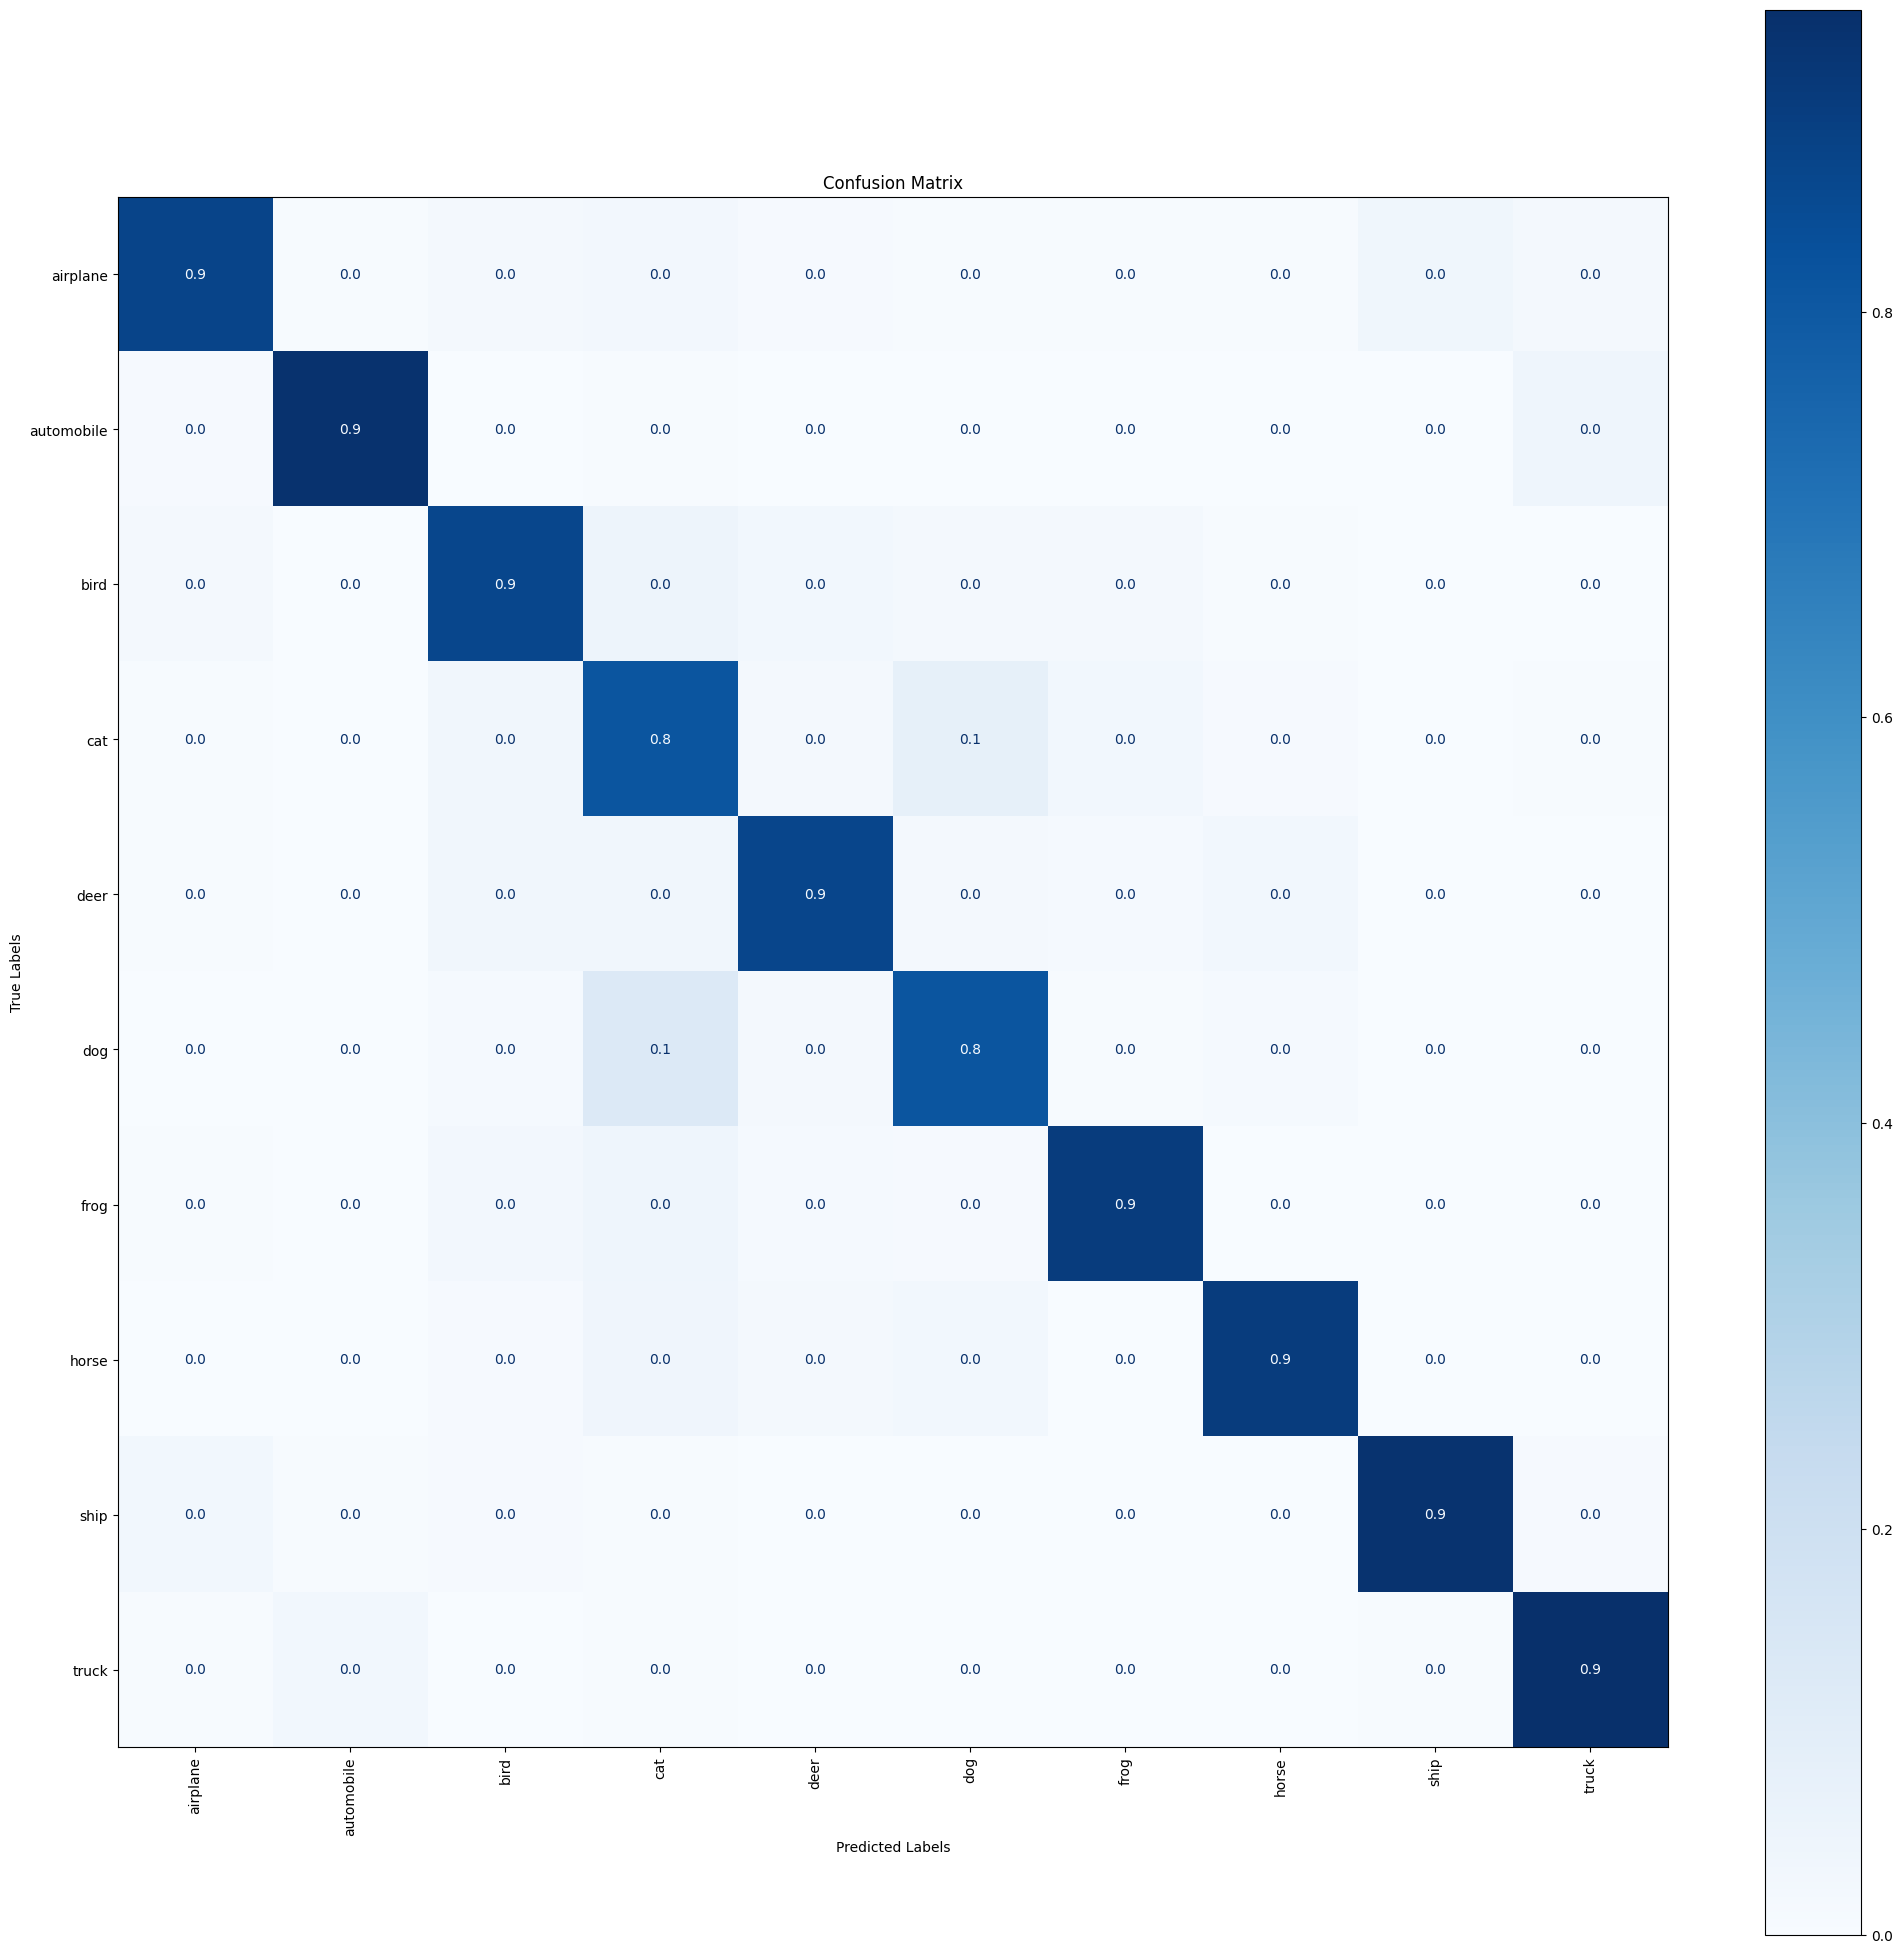

07/23 17:23:44 - mmengine - INFO - Epoch(val) [29][157/157]    accuracy/top1: 88.6900  accuracy/top5: 99.0500  loss/loss: 1.6599  data_time: 0.0094  time: 0.1136
07/23 17:23:44 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_28.pth is removed
07/23 17:23:44 - mmengine - INFO - The best checkpoint with 88.6900 accuracy/top1 at 29 epoch is saved to best_accuracy_top1_epoch_29.pth.
07/23 17:24:33 - mmengine - INFO - Epoch(train) [30][100/782]  base_lr: 2.2763e-04 lr: 9.9716e-05  eta: 0:54:20  time: 0.4803  data_time: 0.1178  memory: 3611  grad_norm: 1.3377  loss: 0.5794
07/23 17:25:21 - mmengine - INFO - Epoch(train) [30][200/782]  base_lr: 2.2294e-04 lr: 9.7784e-05  eta: 0:53:45  time: 0.4801  data_time: 0.1183  memory: 3611  grad_norm: 1.2116  loss: 0.5698
07/23 17:26:09 - mmengine - INFO - Epoch(train) [30][300/782]  base_lr: 2.1829e-04 lr: 9.5867e-05  eta: 0:53:10  time

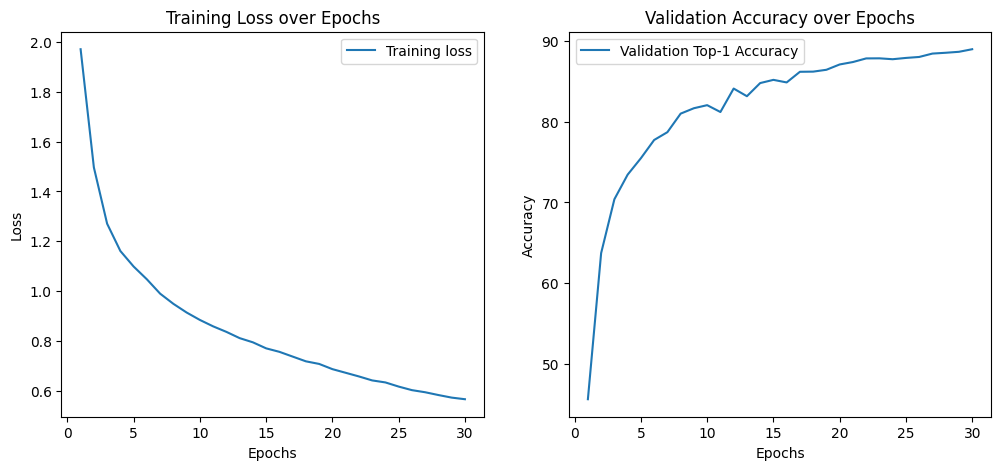

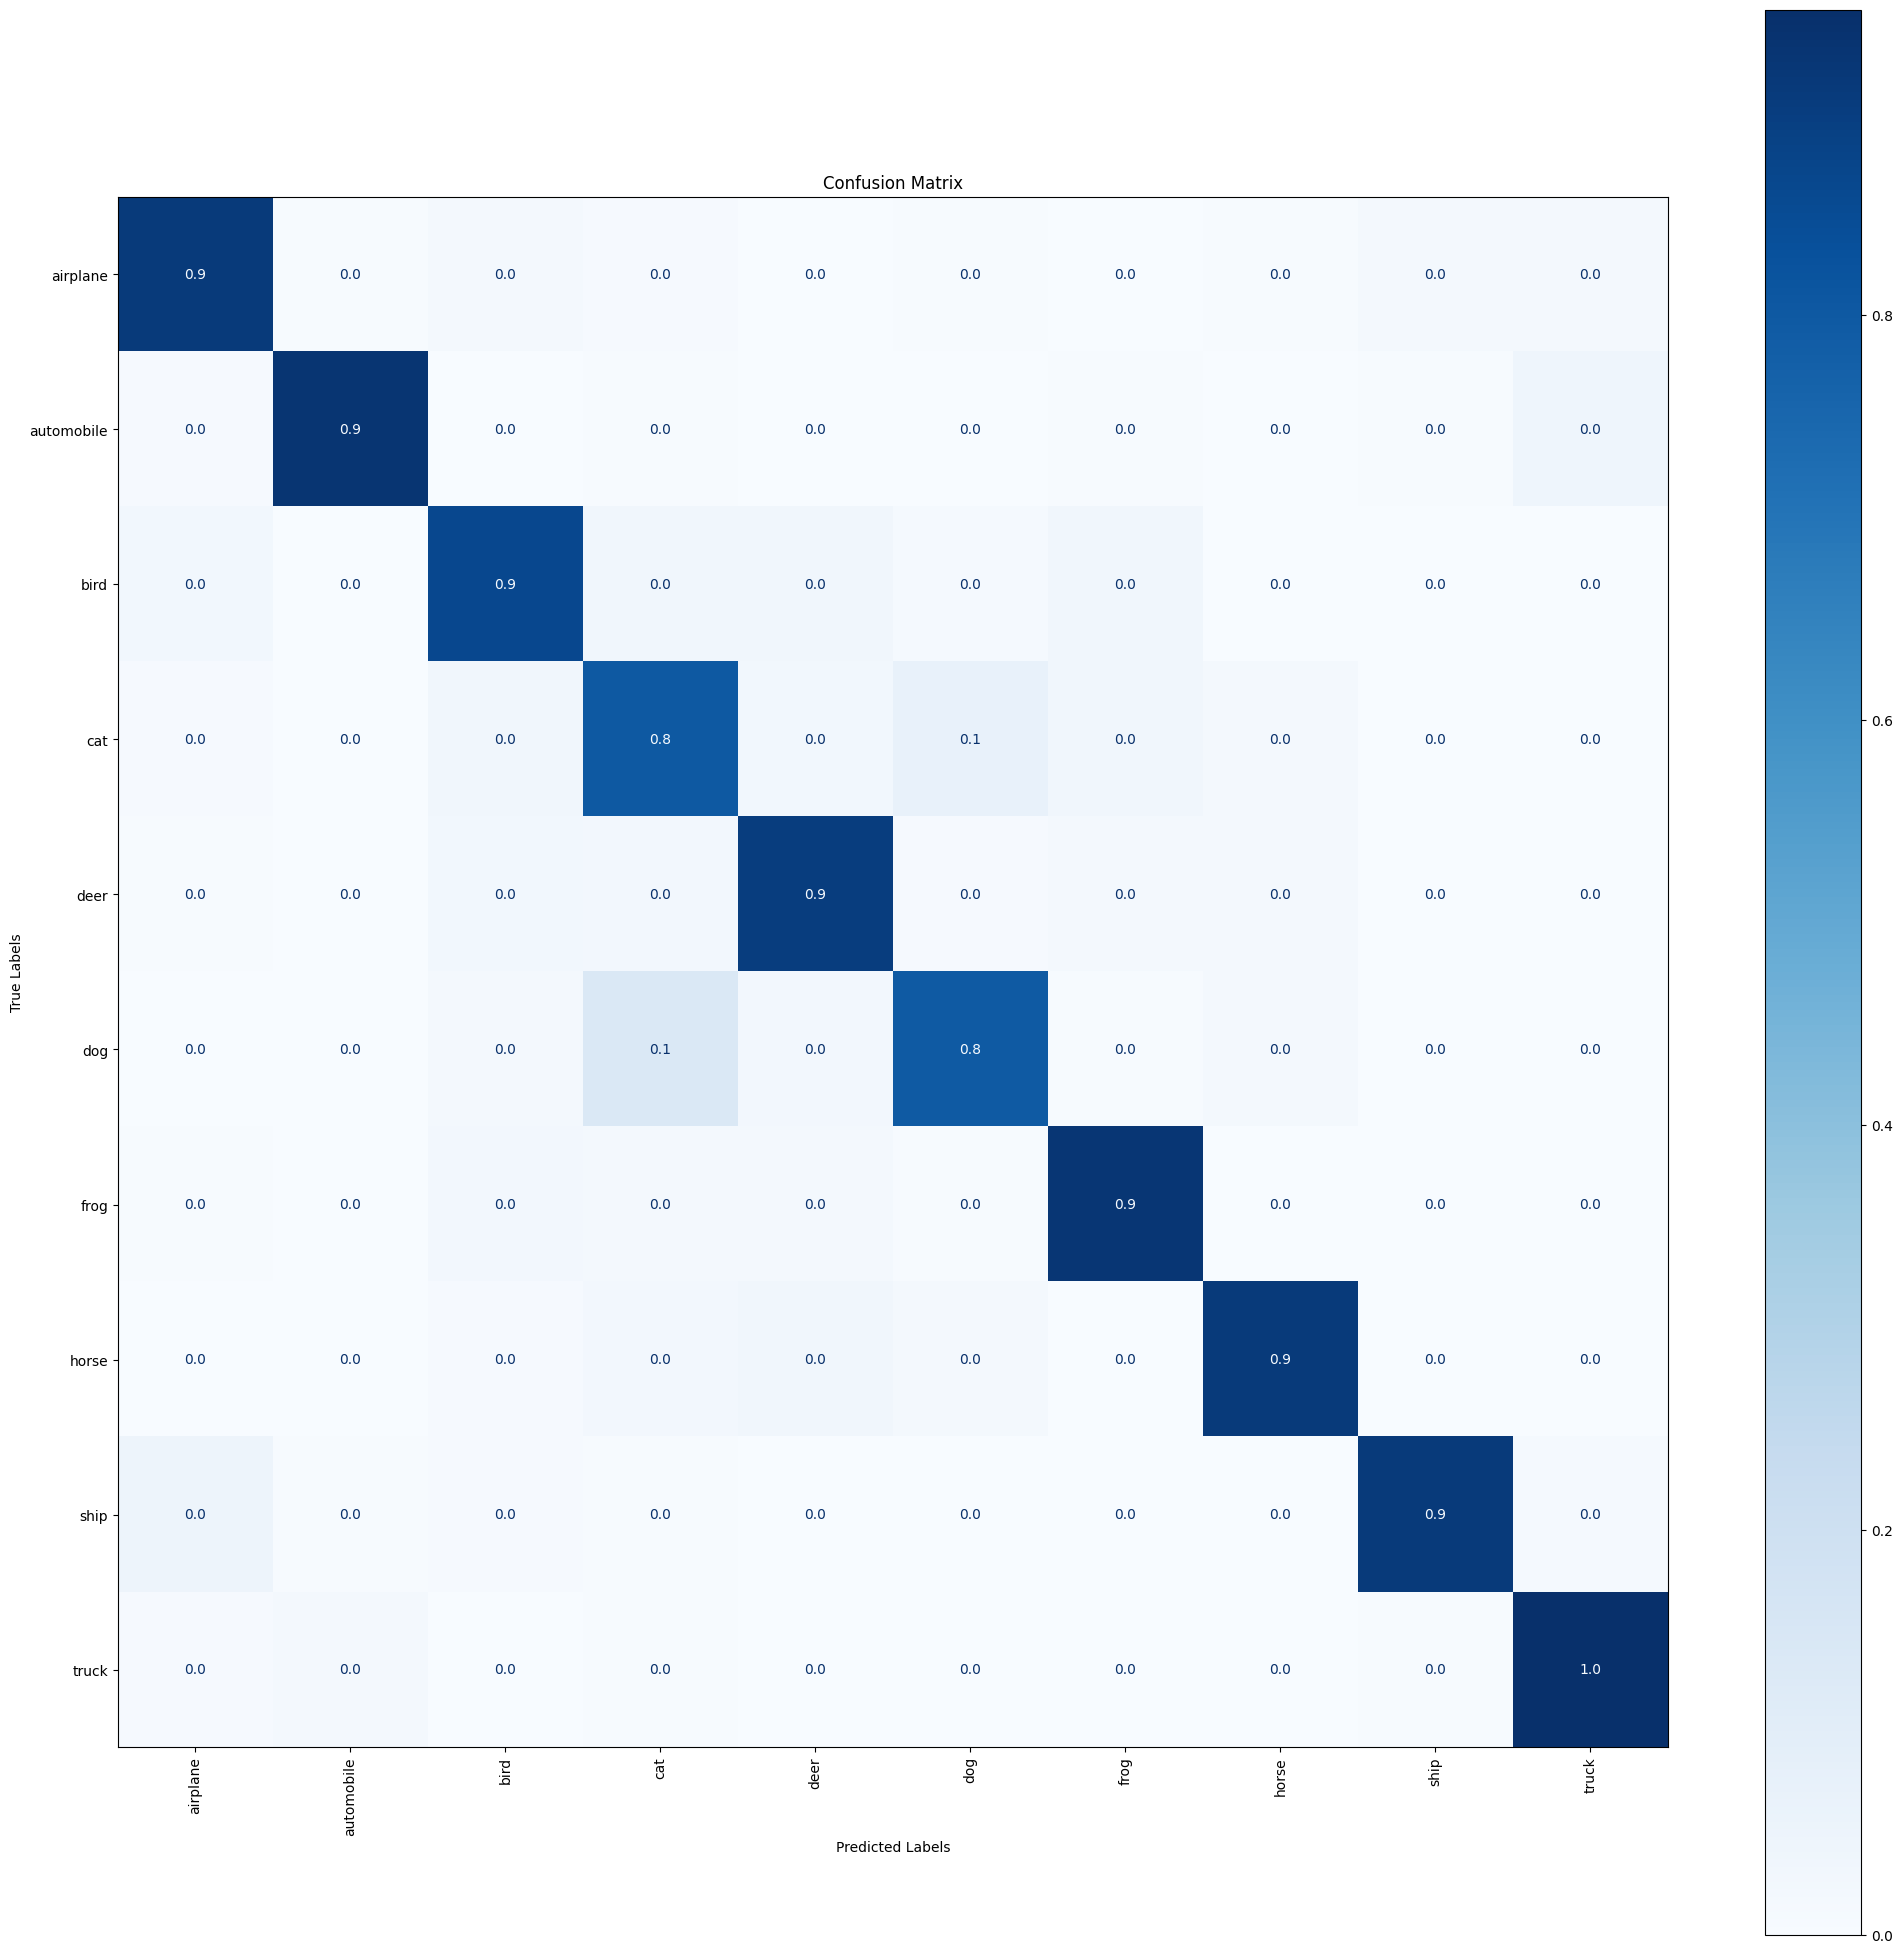

07/23 17:30:18 - mmengine - INFO - Epoch(val) [30][157/157]    accuracy/top1: 89.0100  accuracy/top5: 98.7800  loss/loss: 1.6577  data_time: 0.0099  time: 0.1141
07/23 17:30:18 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_29.pth is removed
07/23 17:30:19 - mmengine - INFO - The best checkpoint with 89.0100 accuracy/top1 at 30 epoch is saved to best_accuracy_top1_epoch_30.pth.
07/23 17:31:07 - mmengine - INFO - Epoch(train) [31][100/782]  base_lr: 1.9199e-04 lr: 8.5026e-05  eta: 0:49:45  time: 0.4796  data_time: 0.1178  memory: 3611  grad_norm: 1.3185  loss: 0.5579
07/23 17:31:55 - mmengine - INFO - Epoch(train) [31][200/782]  base_lr: 1.8761e-04 lr: 8.3220e-05  eta: 0:49:09  time: 0.4811  data_time: 0.1178  memory: 3611  grad_norm: 1.3665  loss: 0.5740
07/23 17:32:43 - mmengine - INFO - Epoch(train) [31][300/782]  base_lr: 1.8327e-04 lr: 8.1431e-05  eta: 0:48:33  time

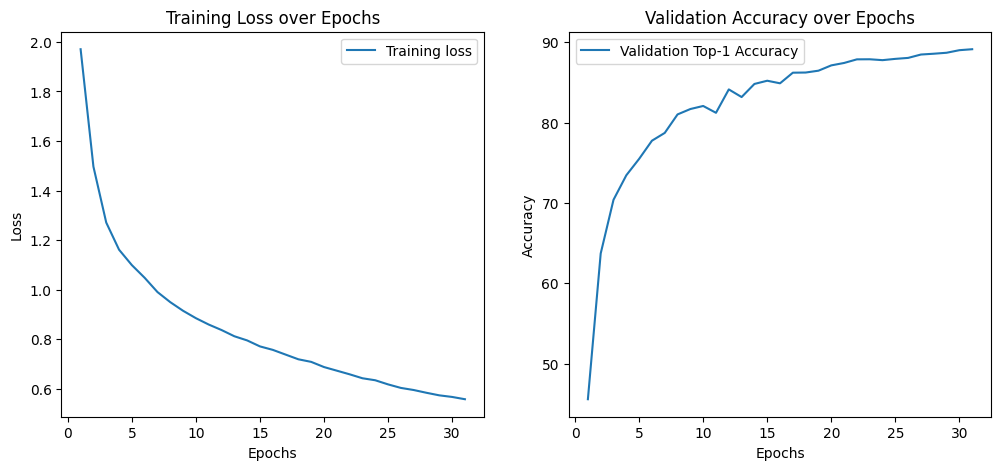

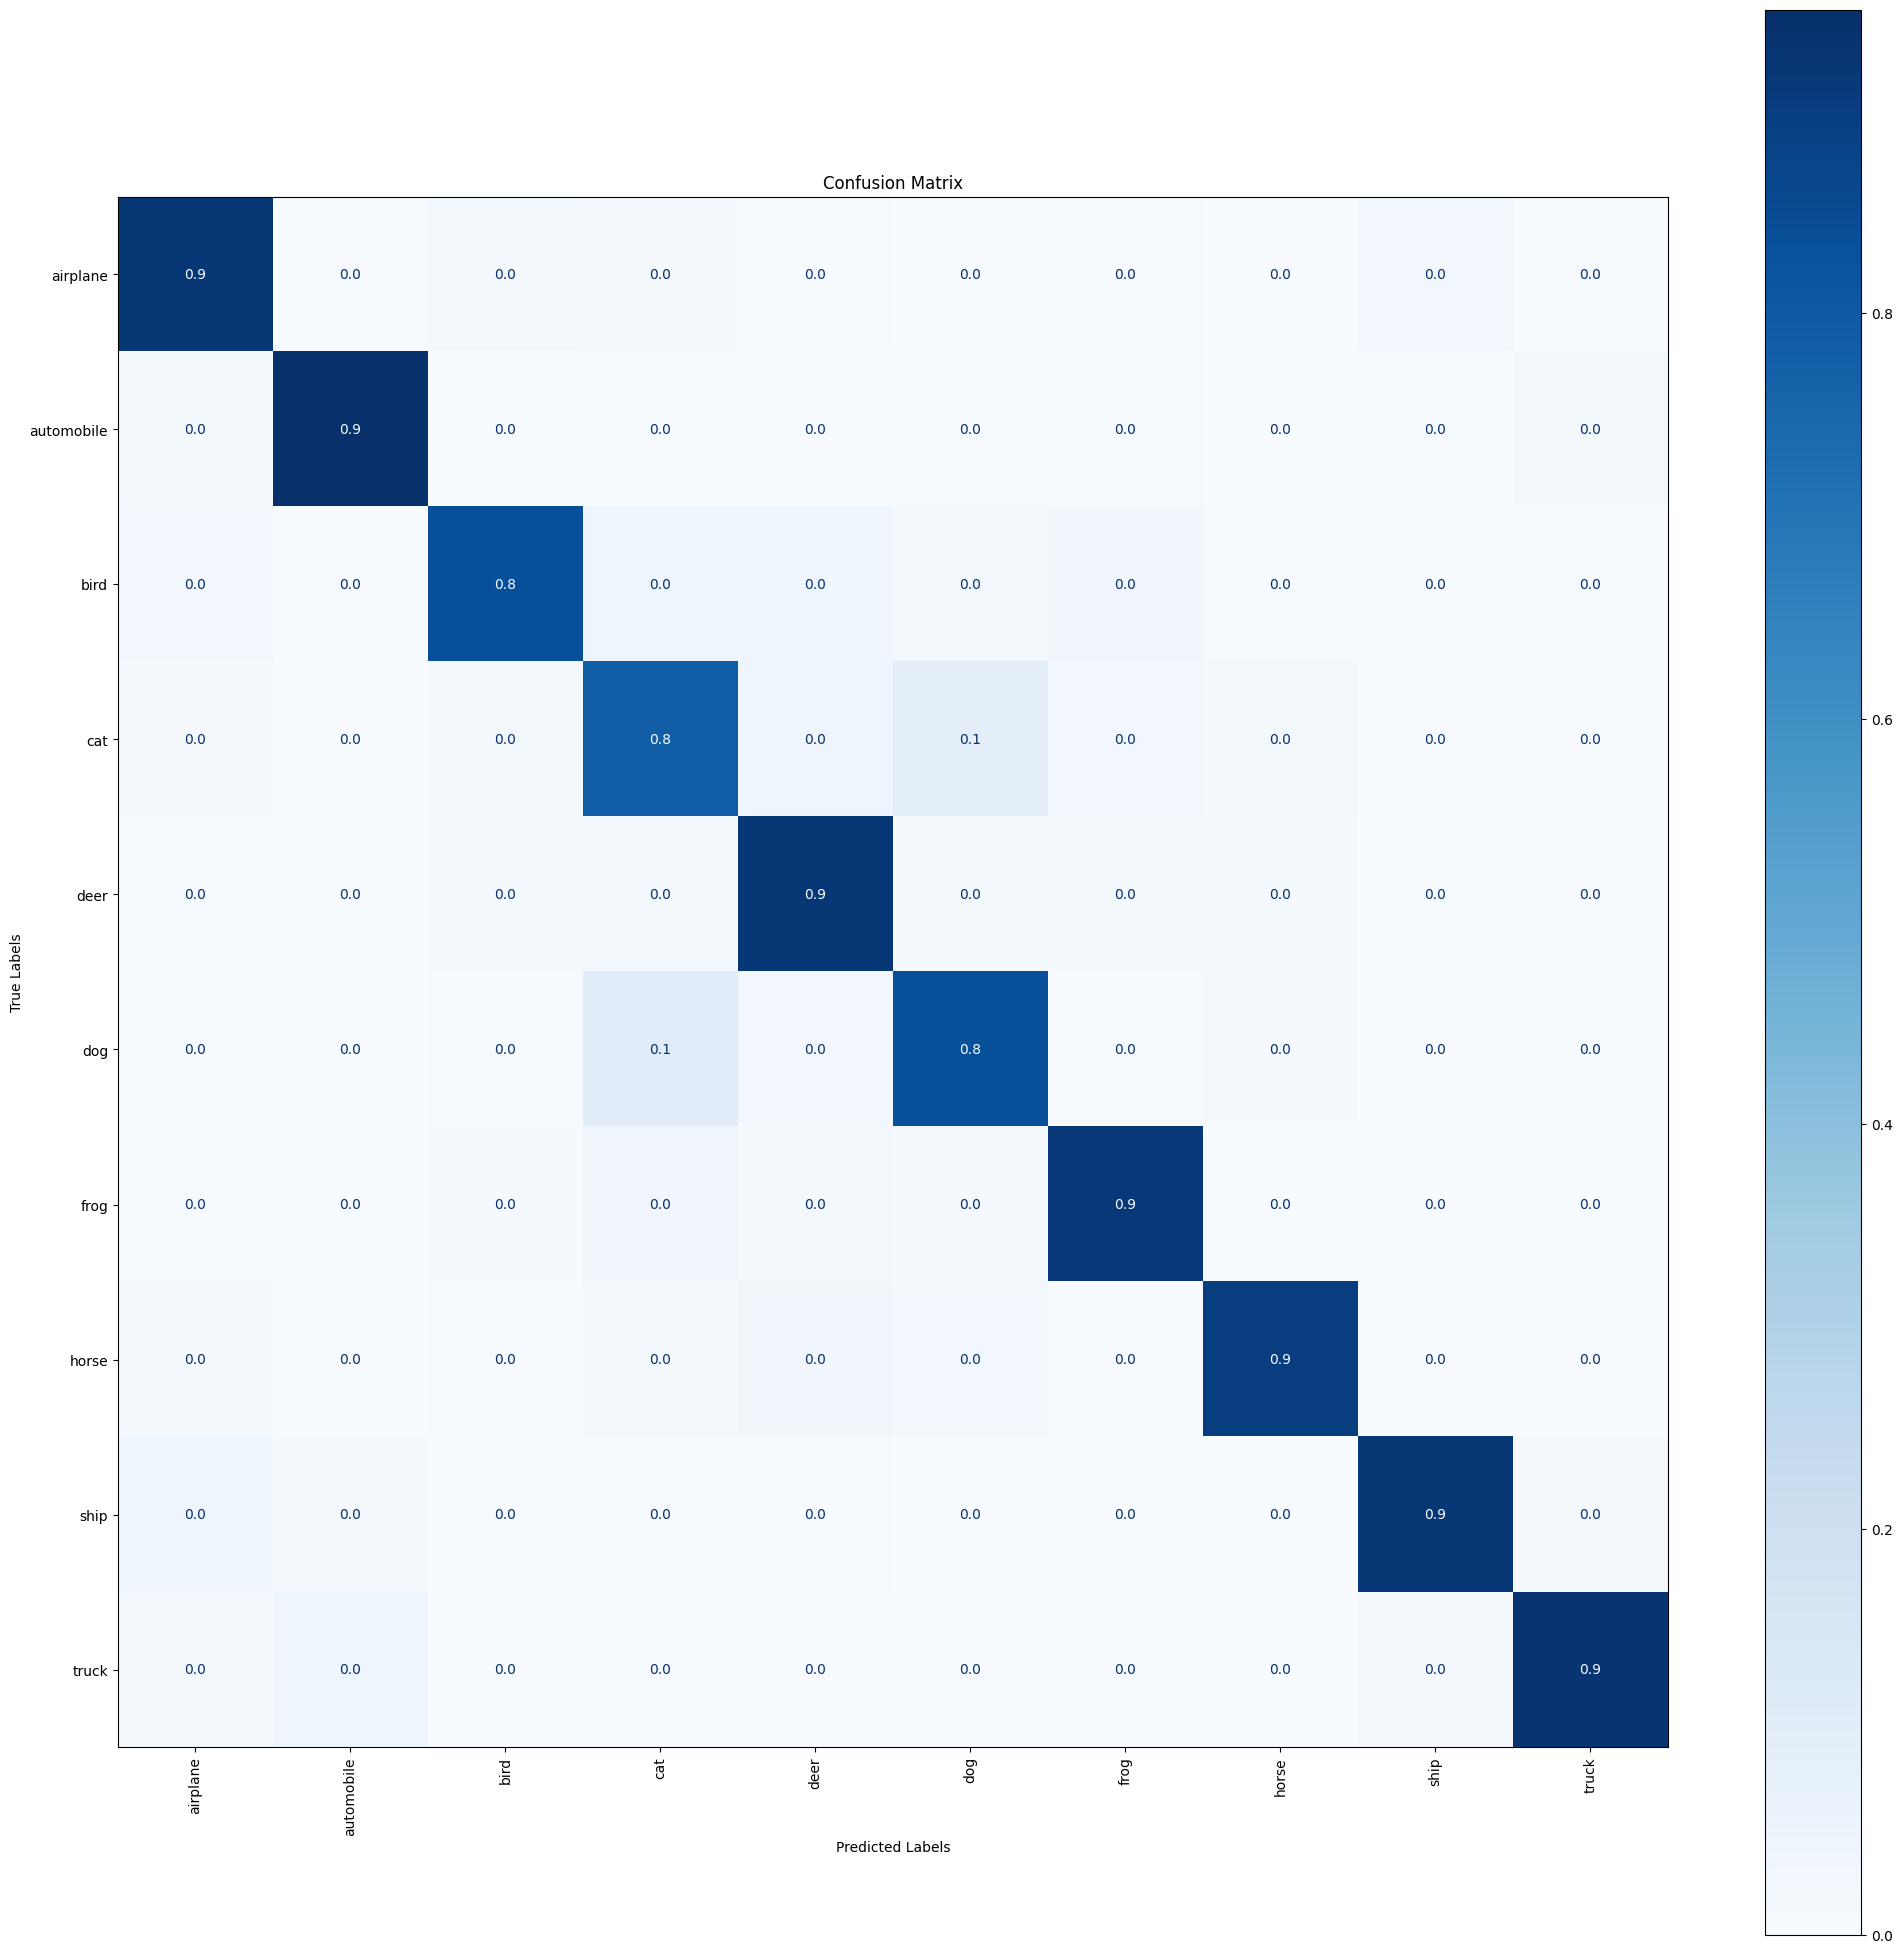

07/23 17:36:54 - mmengine - INFO - Epoch(val) [31][157/157]    accuracy/top1: 89.1300  accuracy/top5: 98.7600  loss/loss: 1.6548  data_time: 0.0103  time: 0.1147
07/23 17:36:54 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_30.pth is removed
07/23 17:36:54 - mmengine - INFO - The best checkpoint with 89.1300 accuracy/top1 at 31 epoch is saved to best_accuracy_top1_epoch_31.pth.
07/23 17:37:42 - mmengine - INFO - Epoch(train) [32][100/782]  base_lr: 1.5888e-04 lr: 7.1375e-05  eta: 0:45:03  time: 0.4791  data_time: 0.1178  memory: 3611  grad_norm: 1.3402  loss: 0.5745
07/23 17:38:30 - mmengine - INFO - Epoch(train) [32][200/782]  base_lr: 1.5484e-04 lr: 6.9710e-05  eta: 0:44:27  time: 0.4801  data_time: 0.1175  memory: 3611  grad_norm: 1.0987  loss: 0.5510
07/23 17:39:18 - mmengine - INFO - Epoch(train) [32][300/782]  base_lr: 1.5085e-04 lr: 6.8064e-05  eta: 0:43:50  time

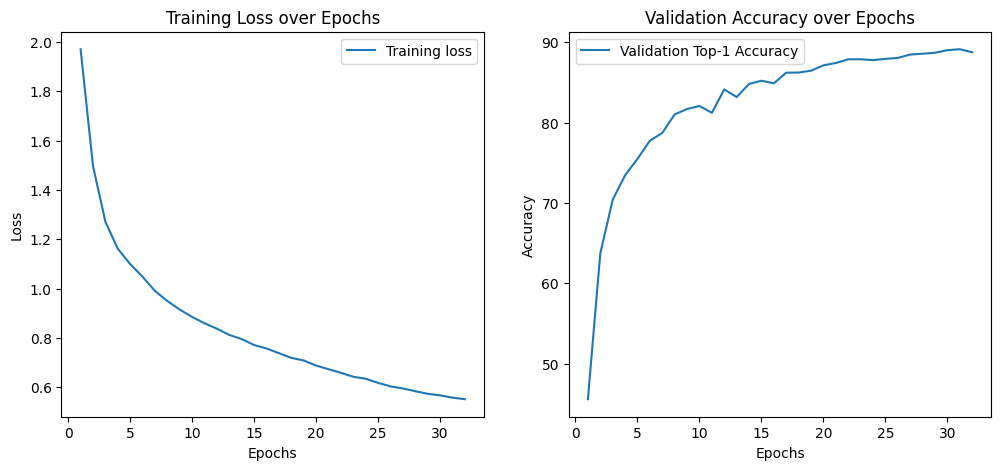

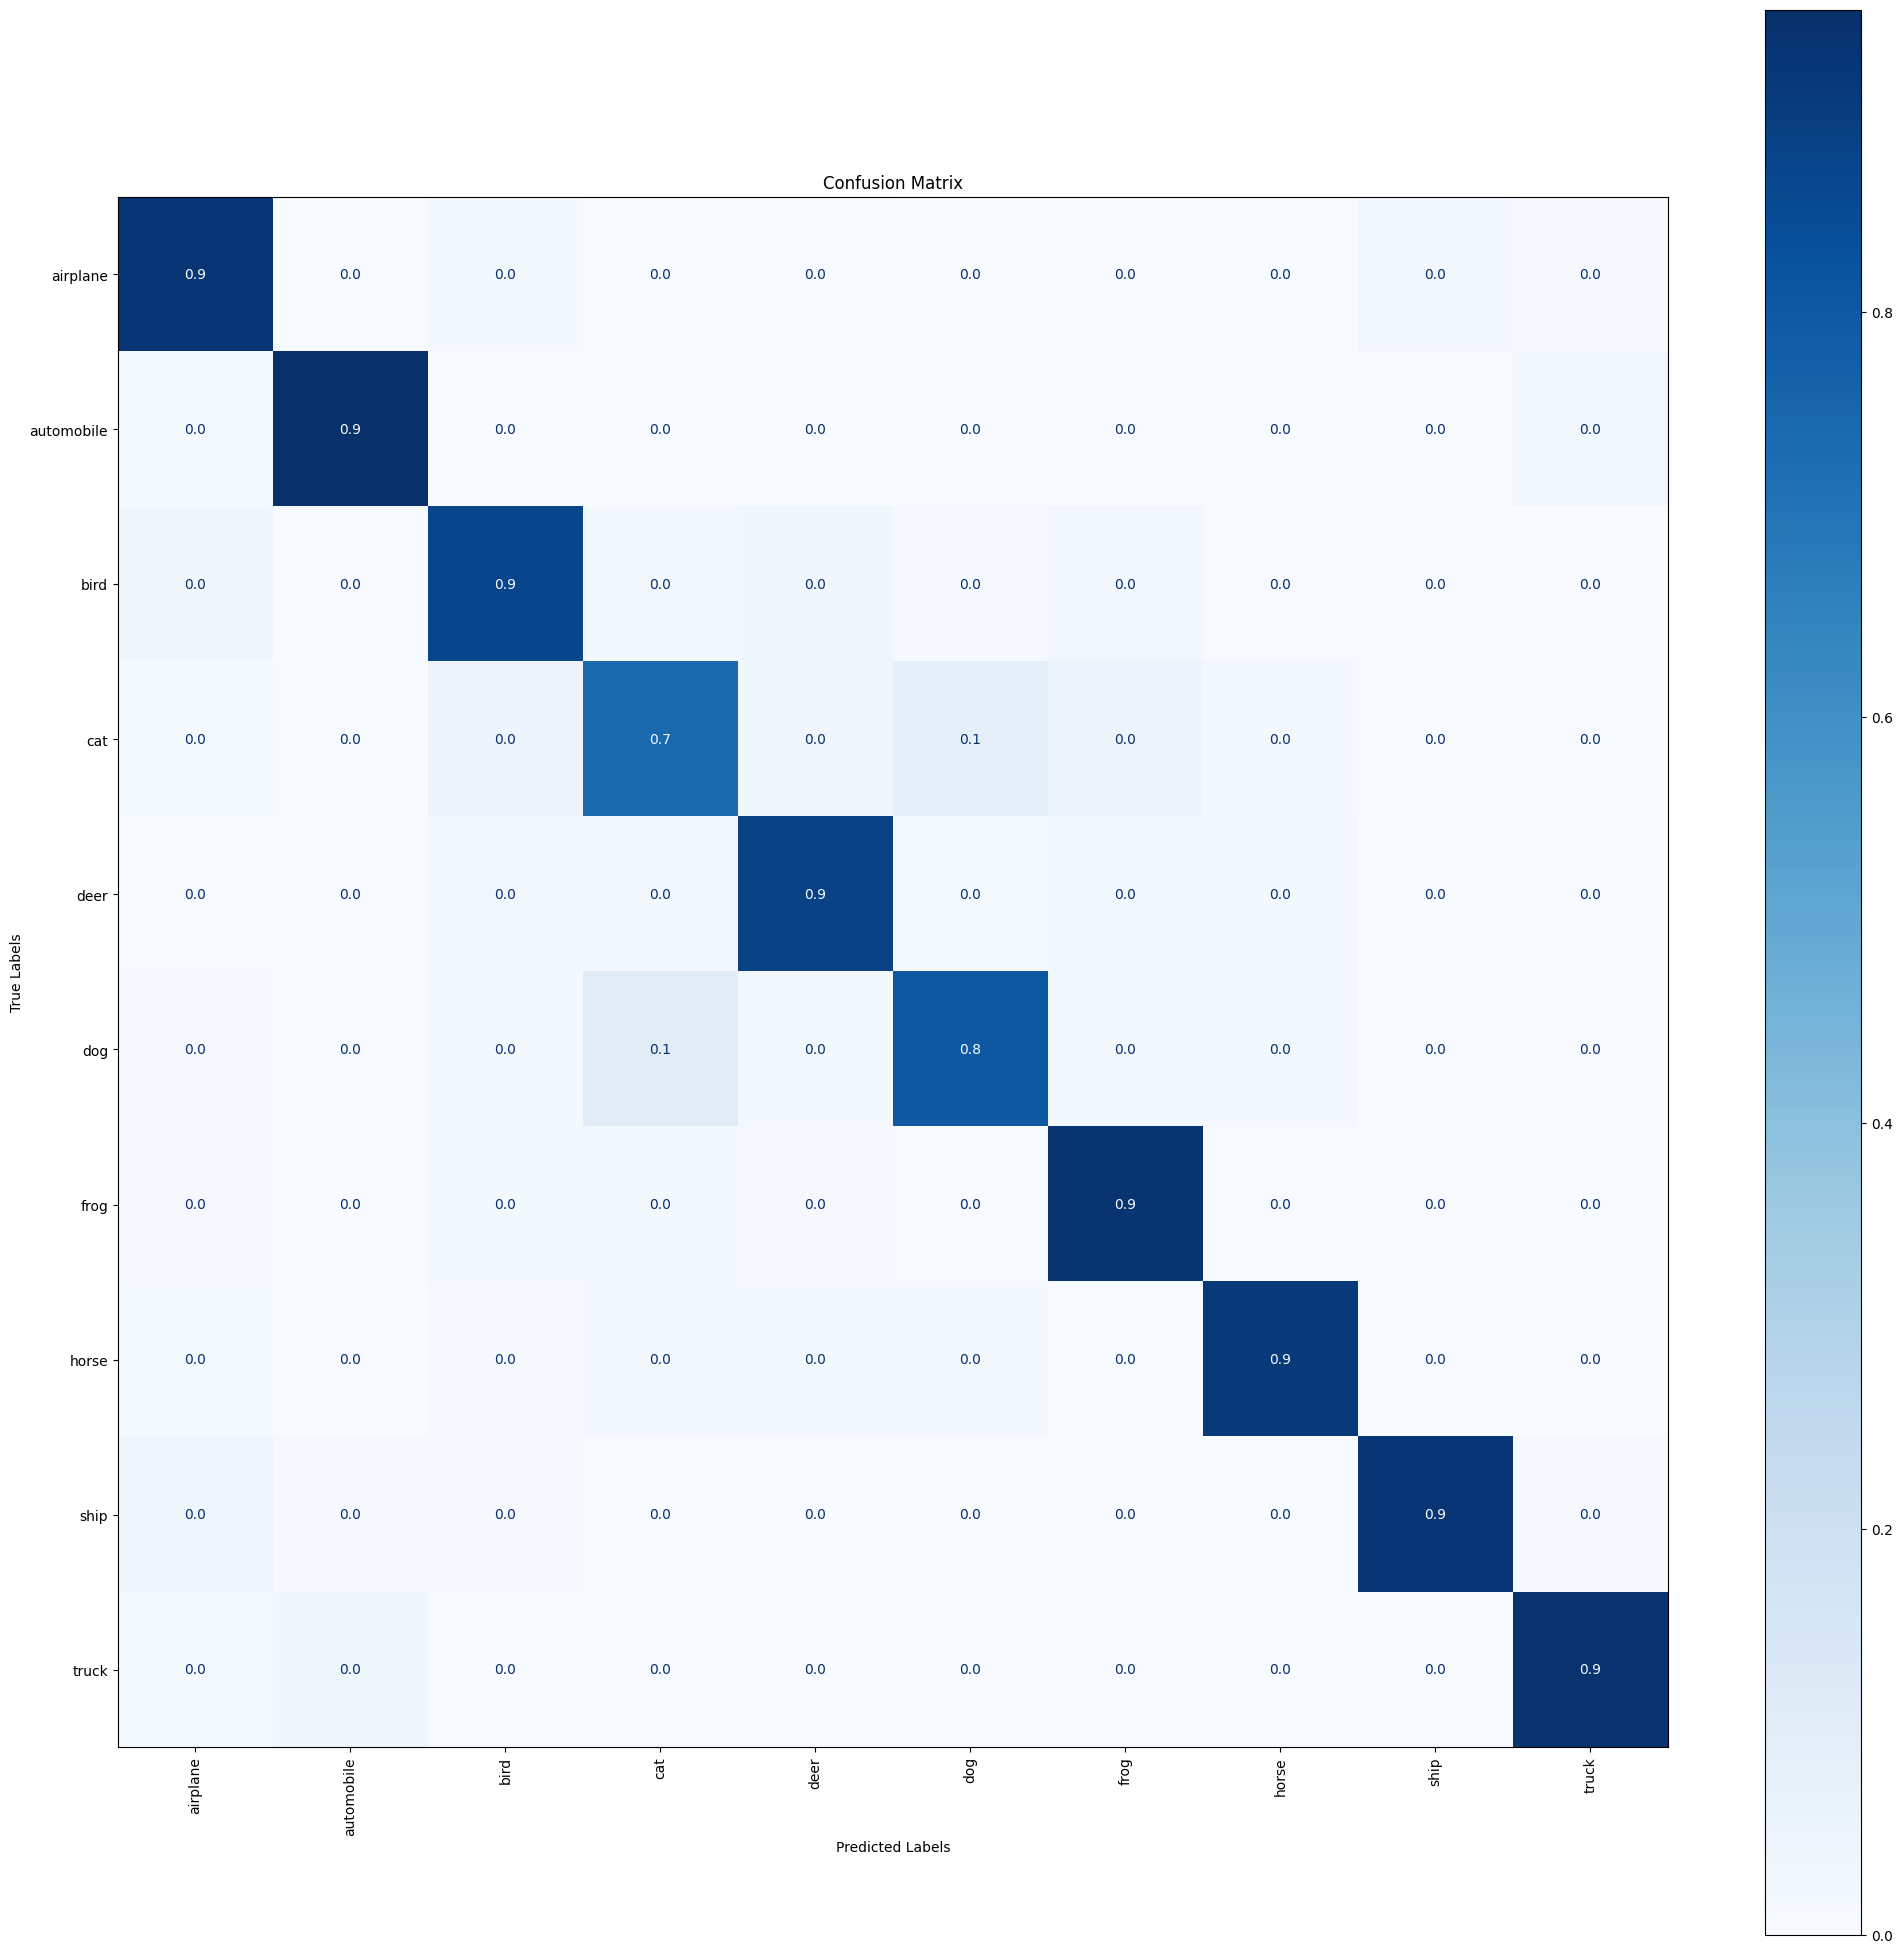

07/23 17:43:29 - mmengine - INFO - Epoch(val) [32][157/157]    accuracy/top1: 88.7500  accuracy/top5: 98.6100  loss/loss: 1.6526  data_time: 0.0099  time: 0.1142
07/23 17:44:17 - mmengine - INFO - Epoch(train) [33][100/782]  base_lr: 1.2855e-04 lr: 5.8873e-05  eta: 0:40:16  time: 0.4791  data_time: 0.1198  memory: 3611  grad_norm: 0.8176  loss: 0.5498
07/23 17:45:05 - mmengine - INFO - Epoch(train) [33][200/782]  base_lr: 1.2489e-04 lr: 5.7362e-05  eta: 0:39:39  time: 0.4809  data_time: 0.1182  memory: 3611  grad_norm: 1.0810  loss: 0.5485
07/23 17:45:53 - mmengine - INFO - Epoch(train) [33][300/782]  base_lr: 1.2127e-04 lr: 5.5872e-05  eta: 0:39:02  time: 0.4822  data_time: 0.1187  memory: 3611  grad_norm: 0.9378  loss: 0.5354
07/23 17:46:42 - mmengine - INFO - Epoch(train) [33][400/782]  base_lr: 1.1771e-04 lr: 5.4403e-05  eta: 0:38:24  time: 0.4814  data_time: 0.1202  memory: 3611  grad_norm: 0.8455  loss: 0.5284
07/23 17:47:30 - mmengine - INFO - Epoch(train) [33][500/782]  base_lr

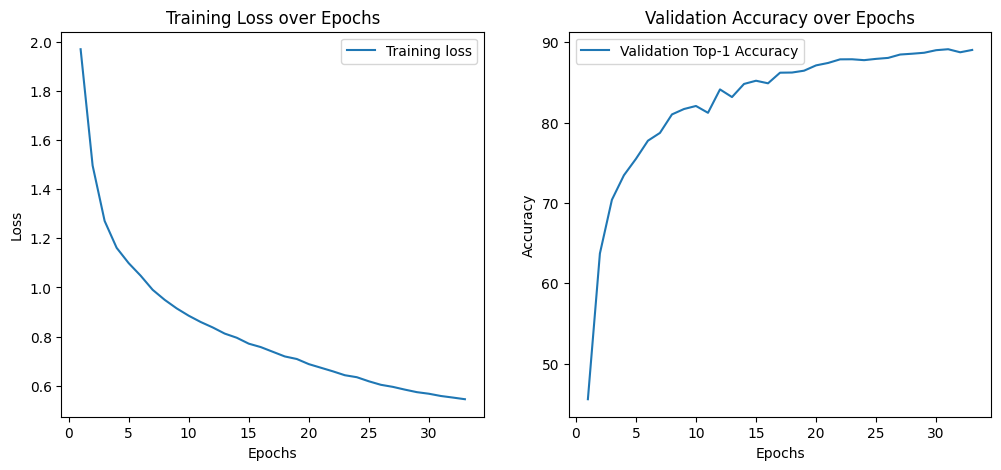

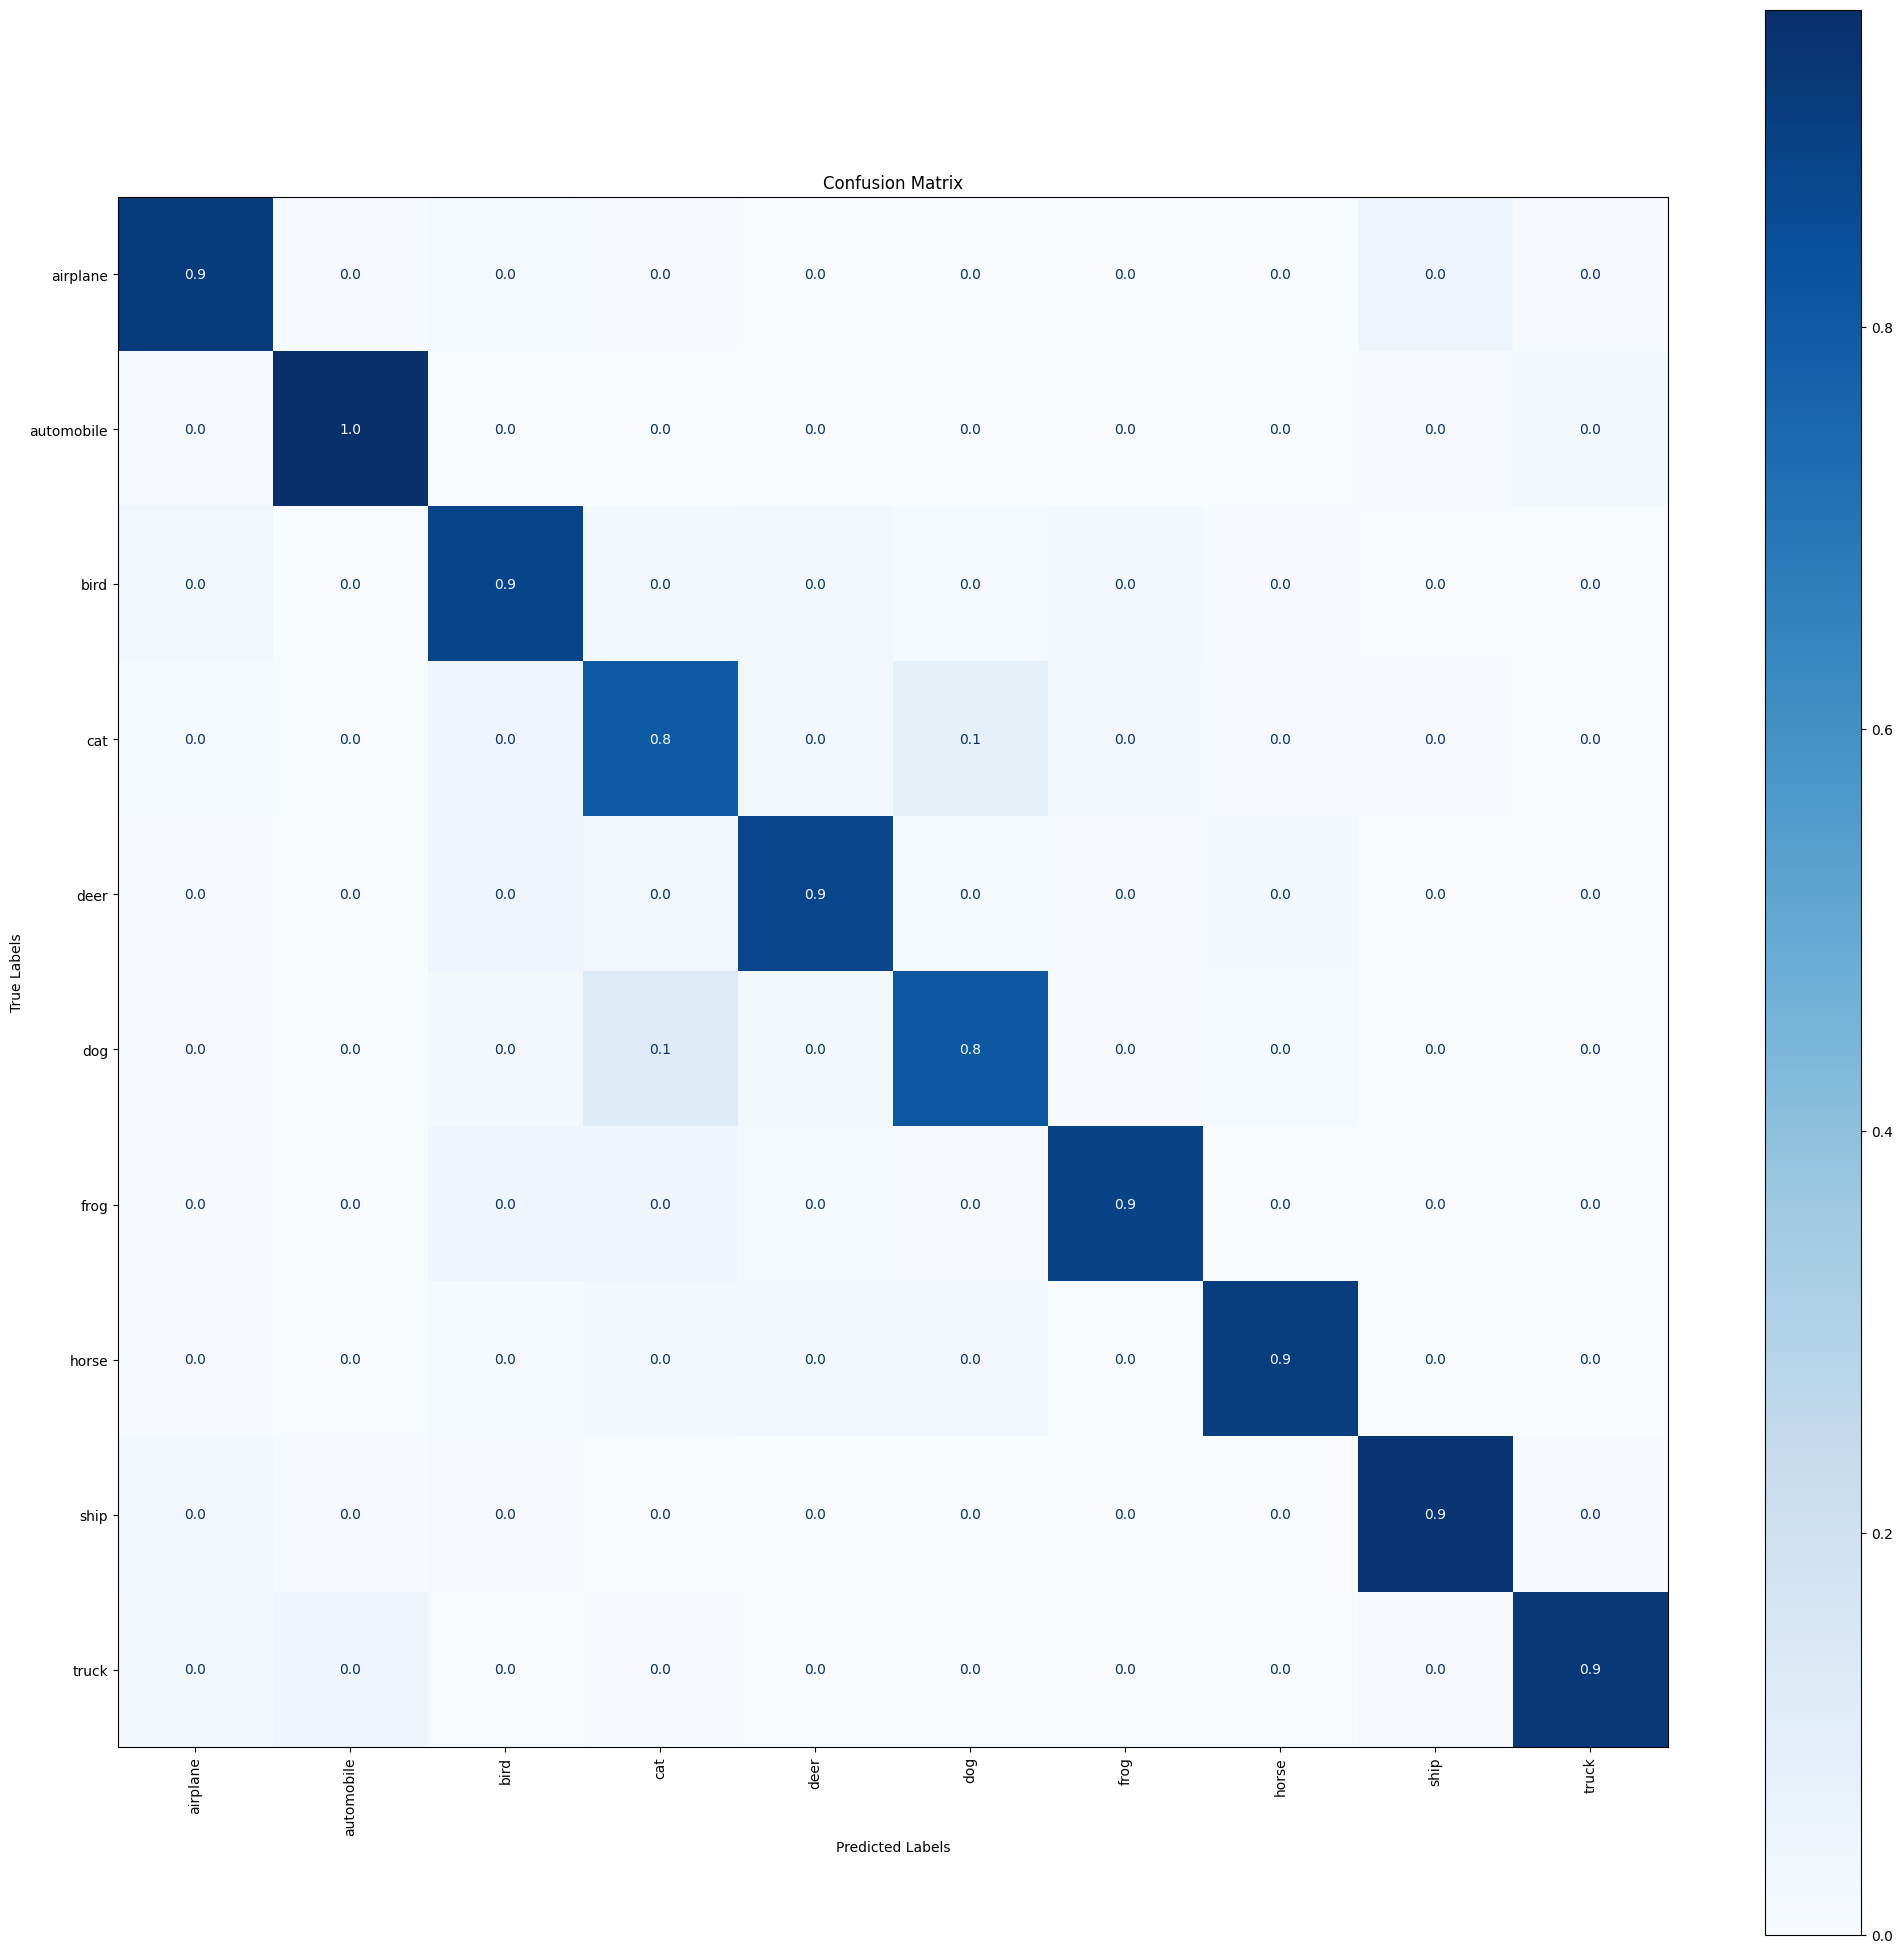

07/23 17:50:05 - mmengine - INFO - Epoch(val) [33][157/157]    accuracy/top1: 89.0400  accuracy/top5: 98.5900  loss/loss: 1.6504  data_time: 0.0099  time: 0.1144
07/23 17:50:53 - mmengine - INFO - Epoch(train) [34][100/782]  base_lr: 1.0126e-04 lr: 4.7620e-05  eta: 0:35:23  time: 0.4818  data_time: 0.1181  memory: 3611  grad_norm: 0.9250  loss: 0.5400
07/23 17:51:38 - mmengine - INFO - Exp name: 20240723_145117
07/23 17:51:41 - mmengine - INFO - Epoch(train) [34][200/782]  base_lr: 9.7996e-05 lr: 4.6276e-05  eta: 0:34:46  time: 0.4817  data_time: 0.1181  memory: 3611  grad_norm: 0.9581  loss: 0.5419
07/23 17:52:29 - mmengine - INFO - Epoch(train) [34][300/782]  base_lr: 9.4789e-05 lr: 4.4954e-05  eta: 0:34:08  time: 0.4795  data_time: 0.1176  memory: 3611  grad_norm: 0.8486  loss: 0.5313
07/23 17:53:17 - mmengine - INFO - Epoch(train) [34][400/782]  base_lr: 9.1636e-05 lr: 4.3654e-05  eta: 0:33:30  time: 0.4792  data_time: 0.1171  memory: 3611  grad_norm: 0.8979  loss: 0.5409
07/23 17:

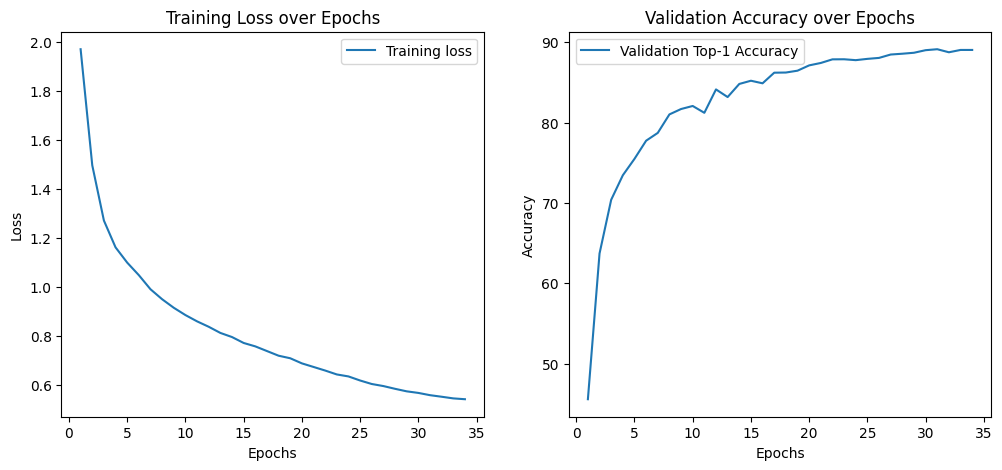

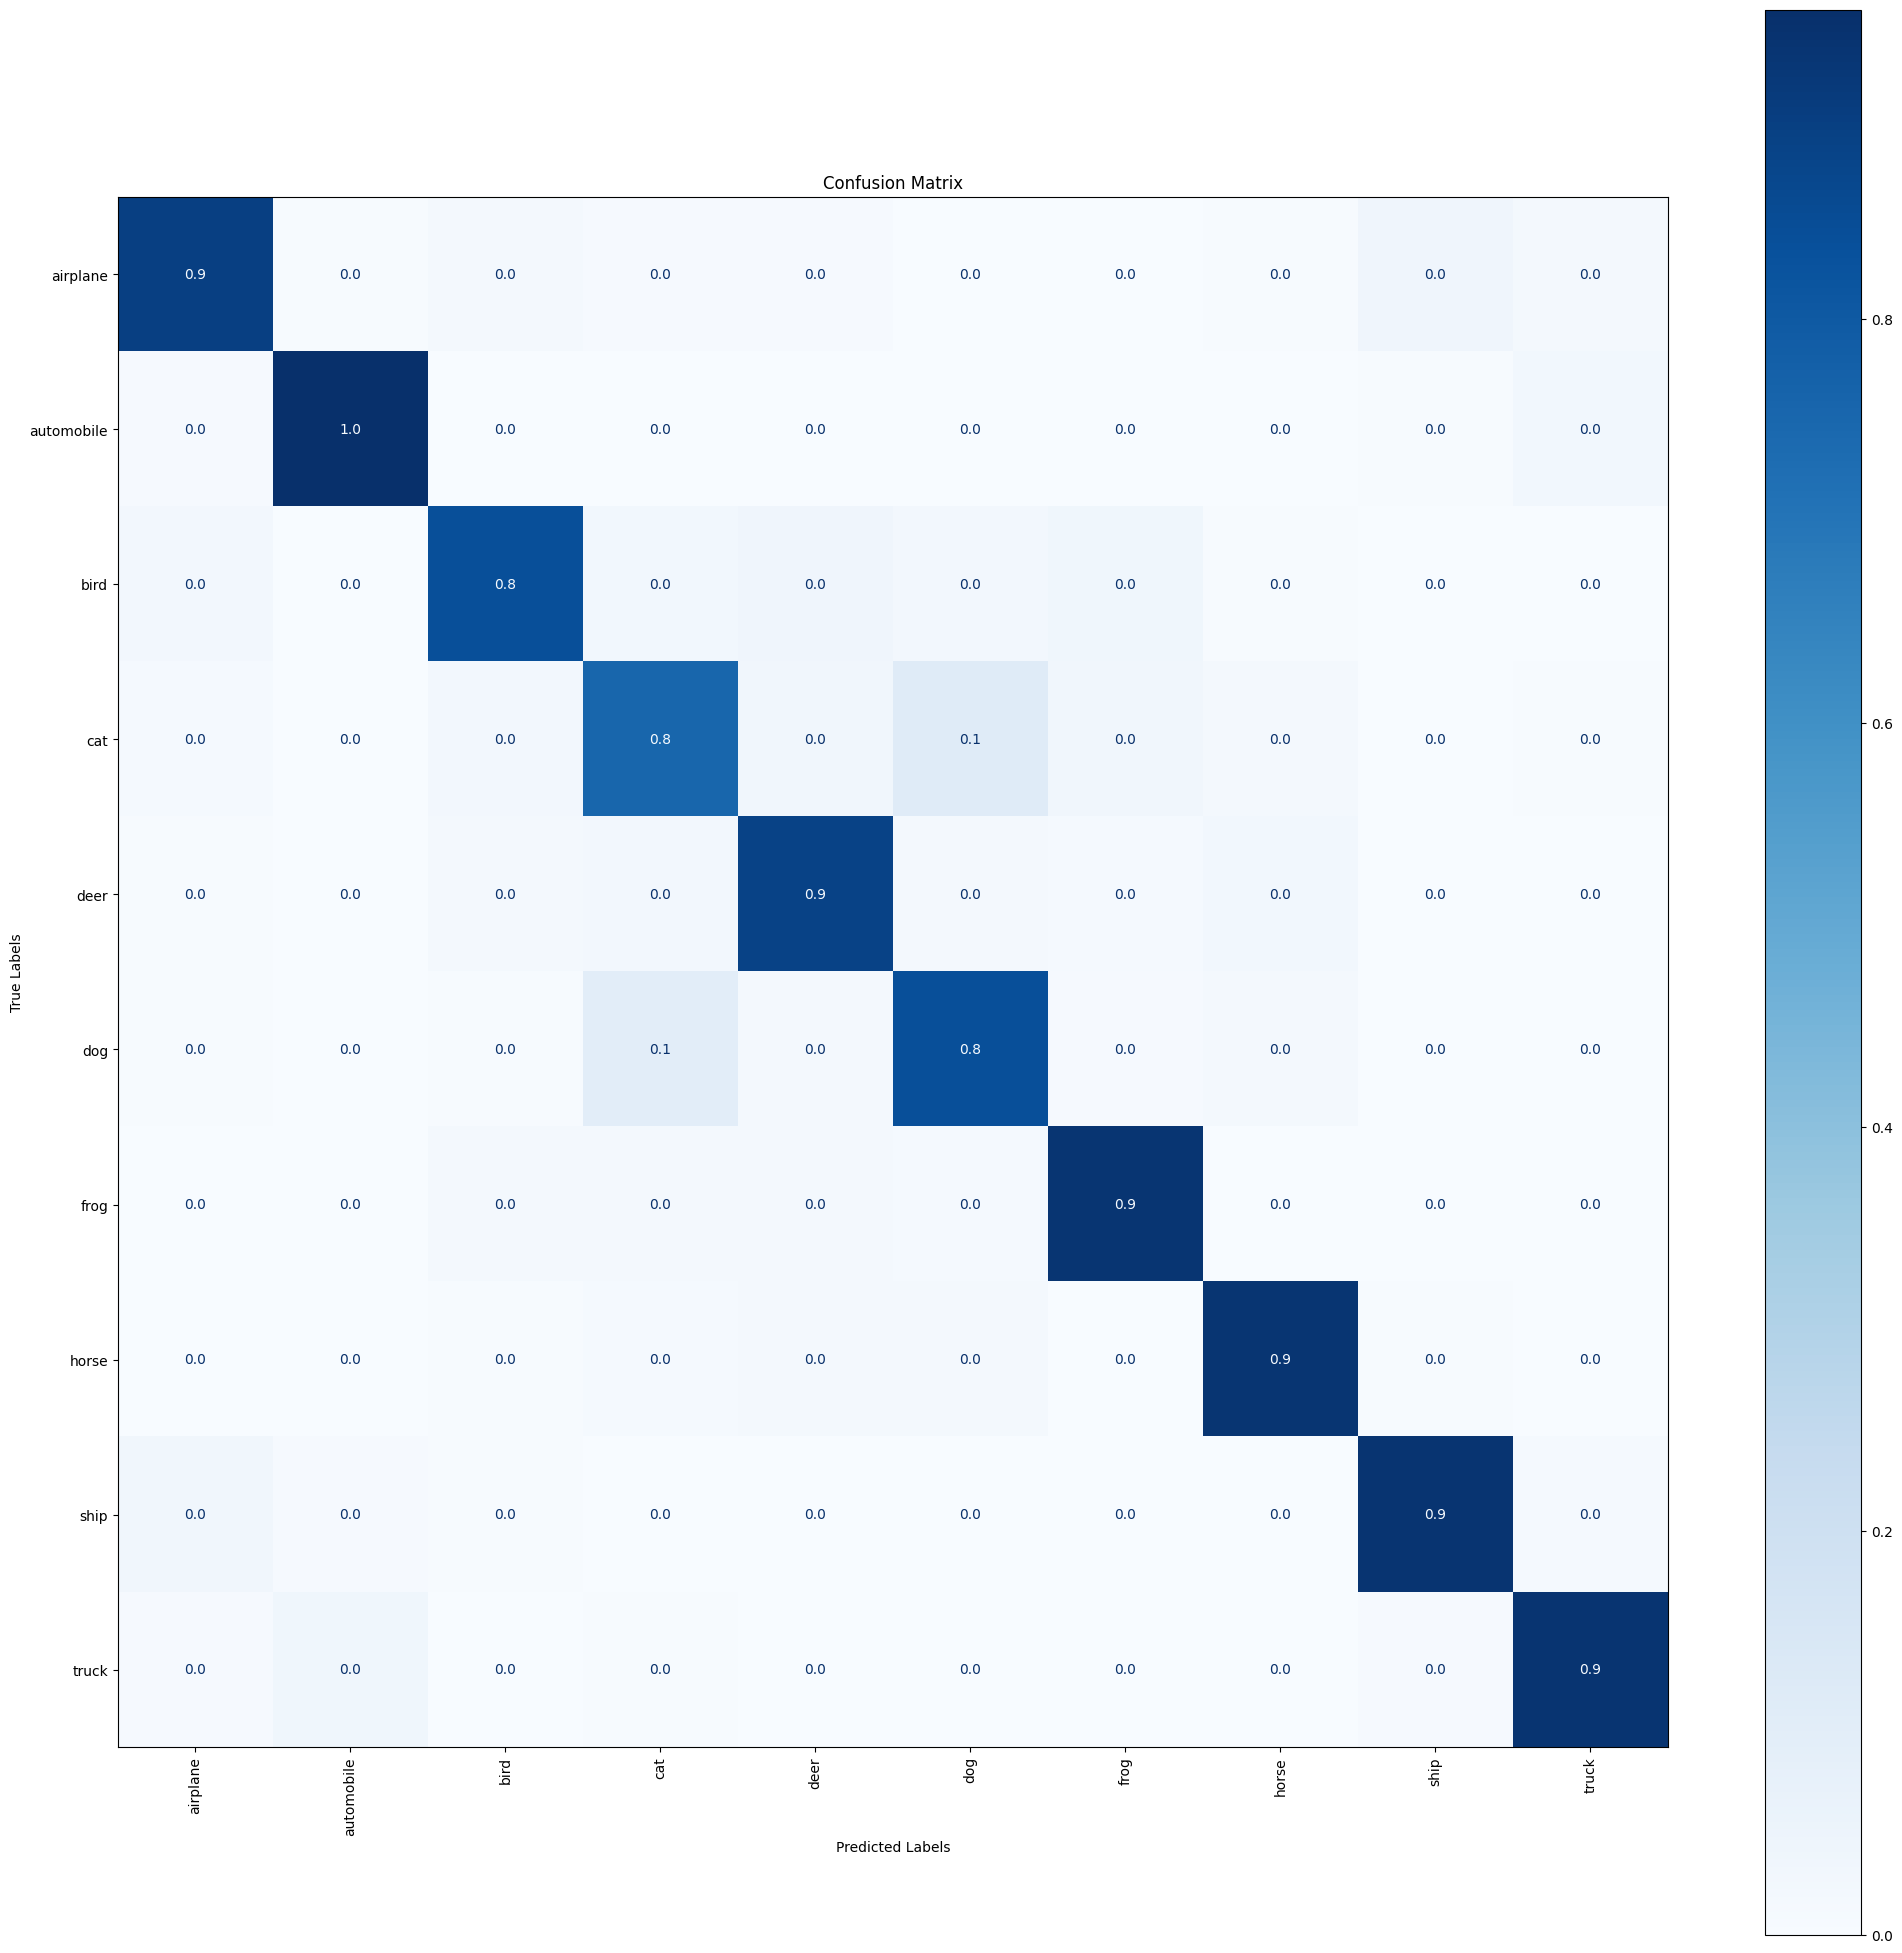

07/23 17:56:39 - mmengine - INFO - Epoch(val) [34][157/157]    accuracy/top1: 89.0400  accuracy/top5: 98.7500  loss/loss: 1.6481  data_time: 0.0092  time: 0.1136
07/23 17:57:27 - mmengine - INFO - Epoch(train) [35][100/782]  base_lr: 7.7210e-05 lr: 3.7707e-05  eta: 0:30:26  time: 0.4791  data_time: 0.1189  memory: 3611  grad_norm: 0.9650  loss: 0.5490
07/23 17:58:15 - mmengine - INFO - Epoch(train) [35][200/782]  base_lr: 7.4380e-05 lr: 3.6540e-05  eta: 0:29:47  time: 0.4790  data_time: 0.1182  memory: 3611  grad_norm: 1.2694  loss: 0.5497
07/23 17:59:03 - mmengine - INFO - Epoch(train) [35][300/782]  base_lr: 7.1606e-05 lr: 3.5397e-05  eta: 0:29:09  time: 0.4794  data_time: 0.1176  memory: 3611  grad_norm: 0.7956  loss: 0.5290
07/23 17:59:51 - mmengine - INFO - Epoch(train) [35][400/782]  base_lr: 6.8890e-05 lr: 3.4277e-05  eta: 0:28:30  time: 0.4799  data_time: 0.1177  memory: 3611  grad_norm: 0.8459  loss: 0.5317
07/23 17:59:56 - mmengine - INFO - Exp name: 20240723_145117
07/23 18:

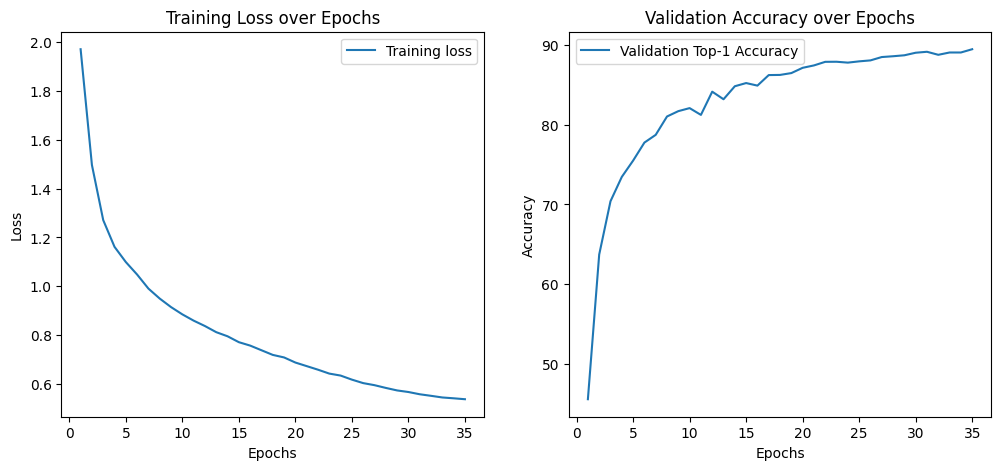

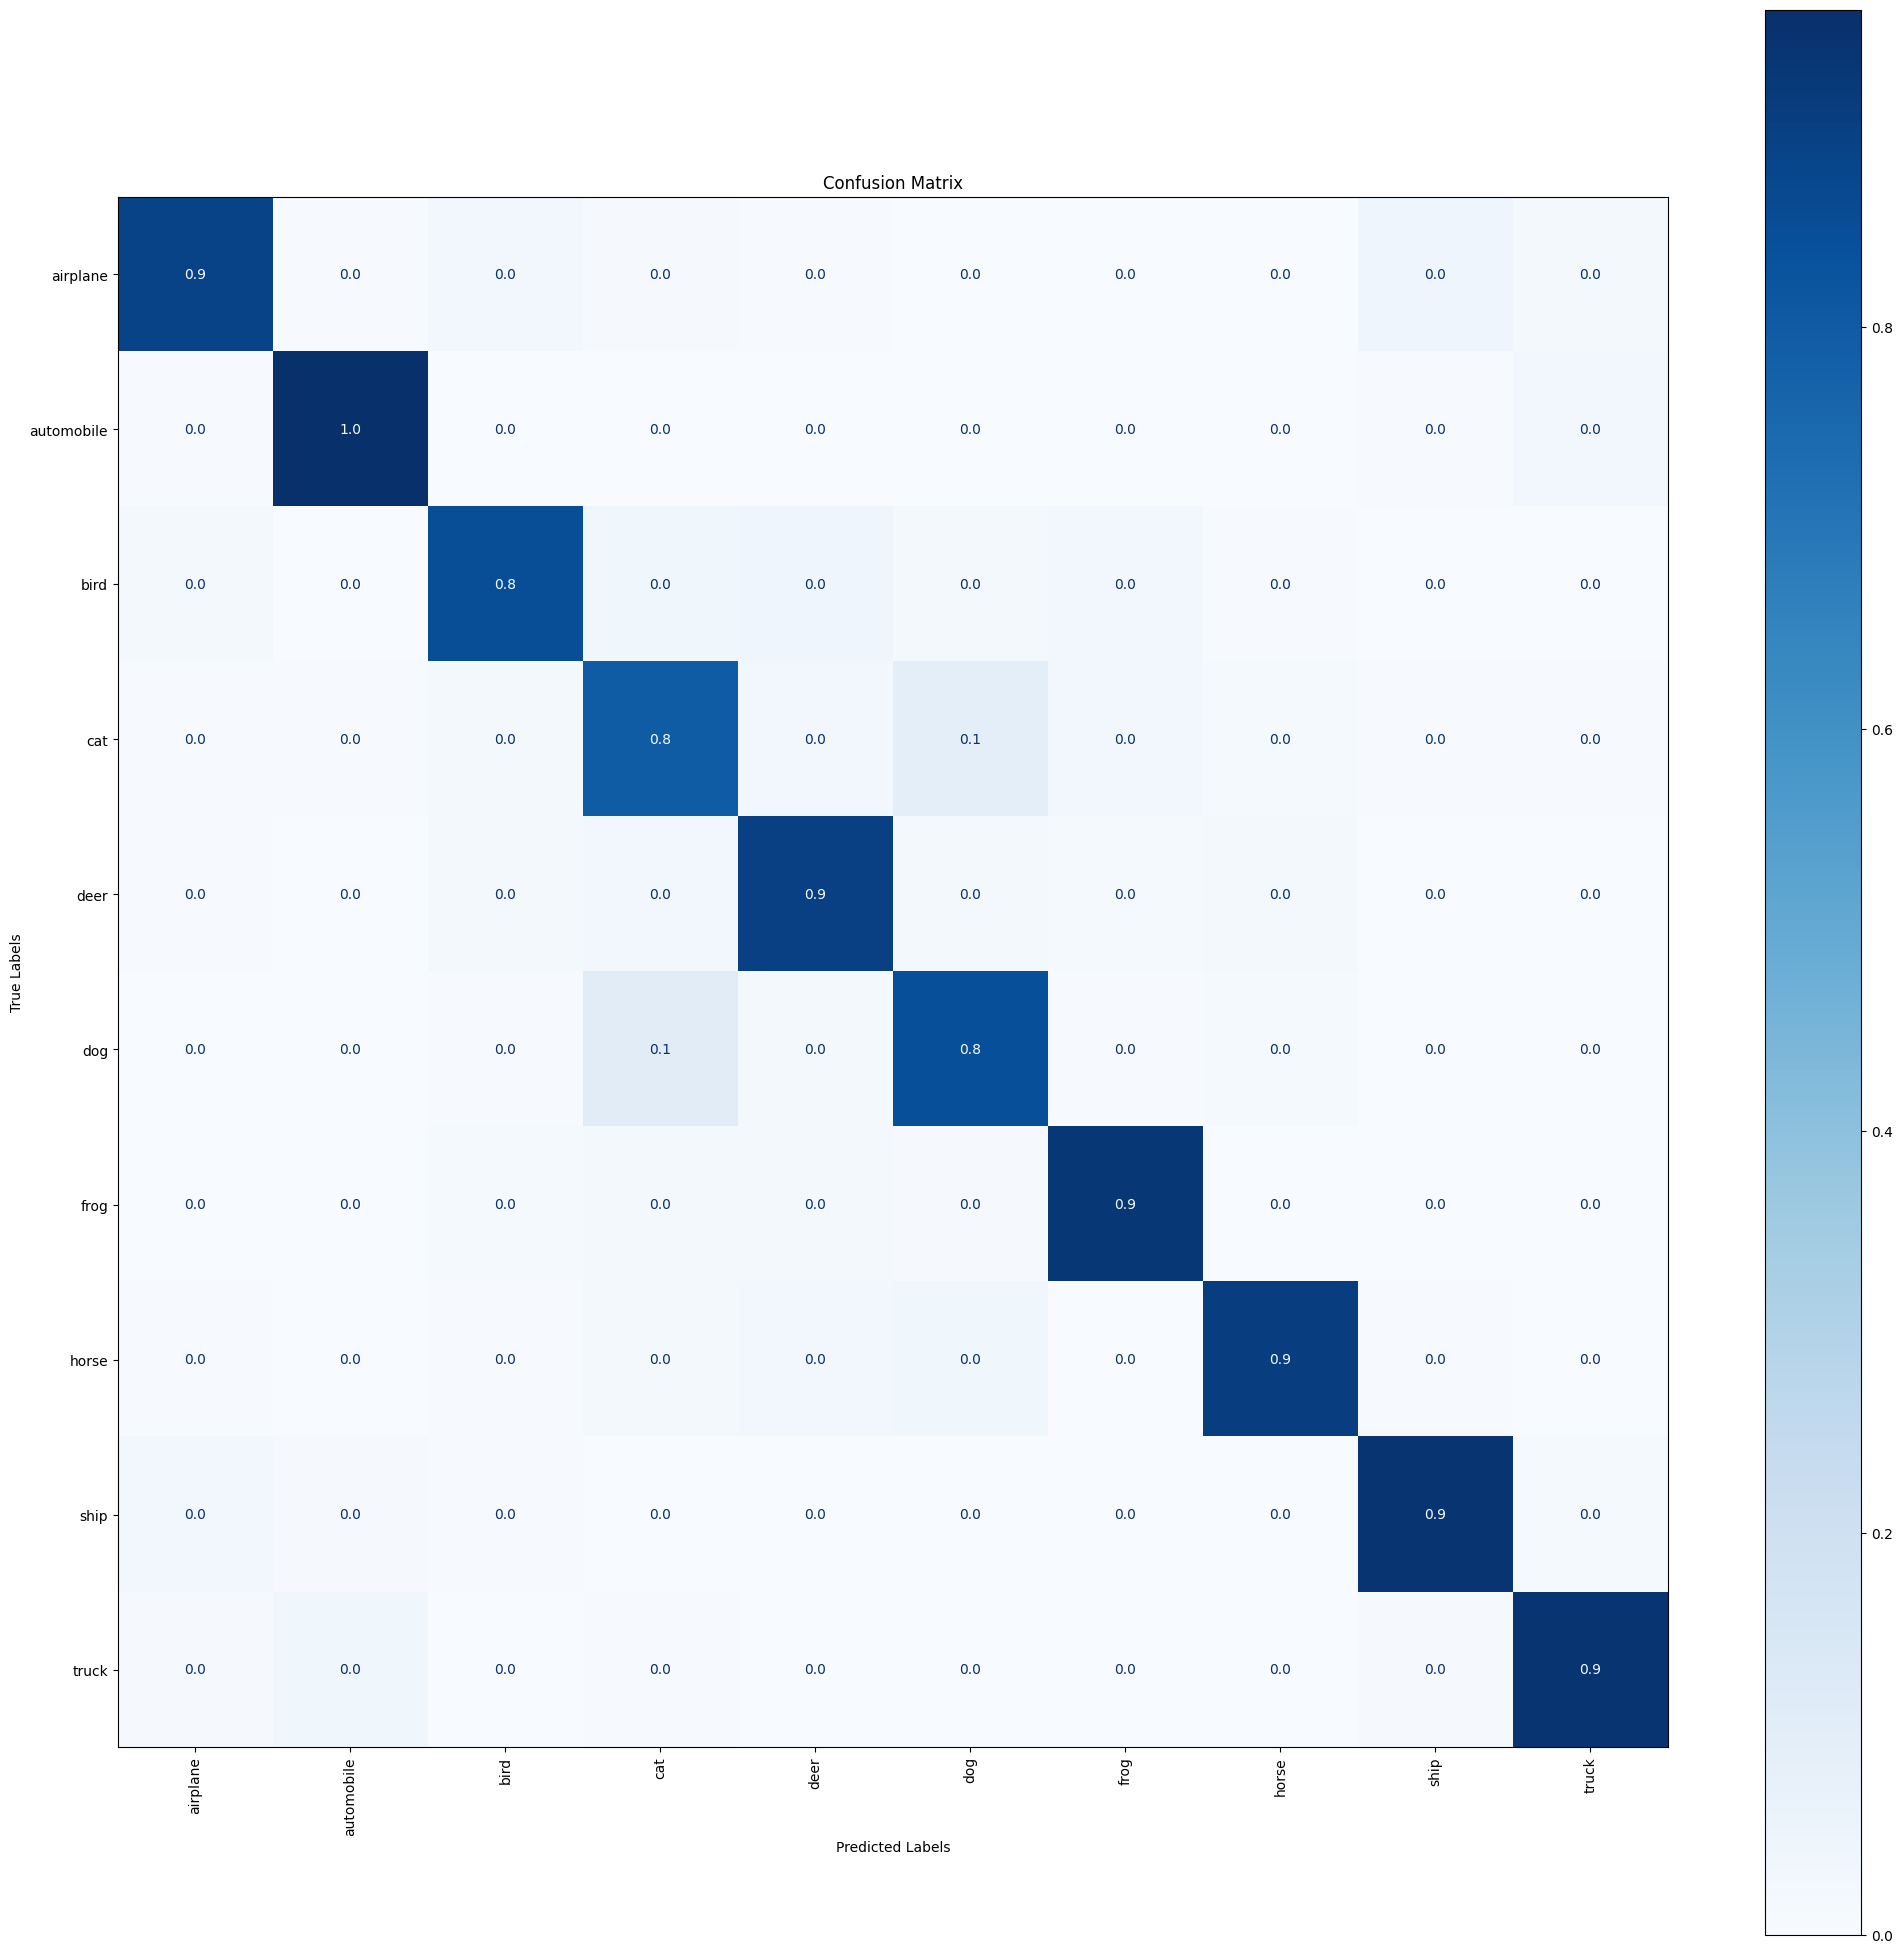

07/23 18:03:13 - mmengine - INFO - Epoch(val) [35][157/157]    accuracy/top1: 89.4500  accuracy/top5: 98.6100  loss/loss: 1.6463  data_time: 0.0101  time: 0.1145
07/23 18:03:13 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_31.pth is removed
07/23 18:03:13 - mmengine - INFO - The best checkpoint with 89.4500 accuracy/top1 at 35 epoch is saved to best_accuracy_top1_epoch_35.pth.
07/23 18:04:01 - mmengine - INFO - Epoch(train) [36][100/782]  base_lr: 5.6609e-05 lr: 2.9214e-05  eta: 0:25:24  time: 0.4805  data_time: 0.1174  memory: 3611  grad_norm: 0.7129  loss: 0.5309
07/23 18:04:49 - mmengine - INFO - Epoch(train) [36][200/782]  base_lr: 5.4231e-05 lr: 2.8234e-05  eta: 0:24:45  time: 0.4794  data_time: 0.1174  memory: 3611  grad_norm: 0.9256  loss: 0.5406
07/23 18:05:37 - mmengine - INFO - Epoch(train) [36][300/782]  base_lr: 5.1914e-05 lr: 2.7279e-05  eta: 0:24:06  time

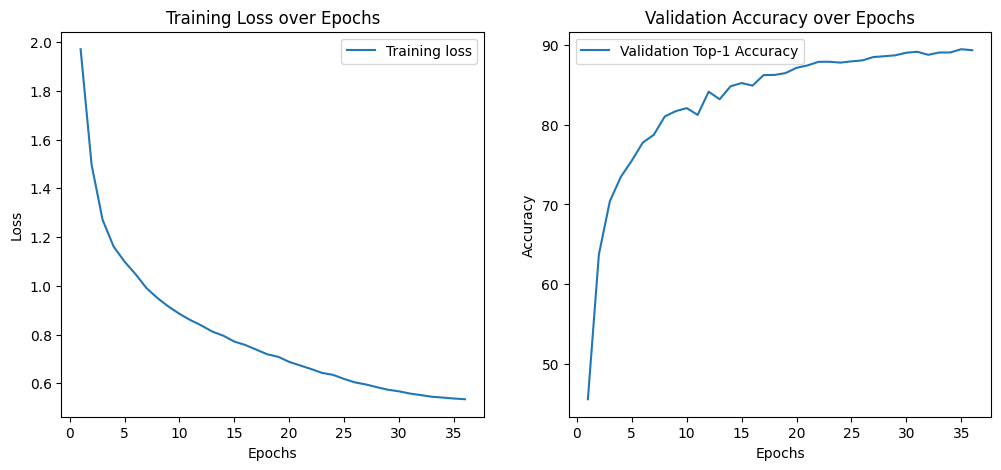

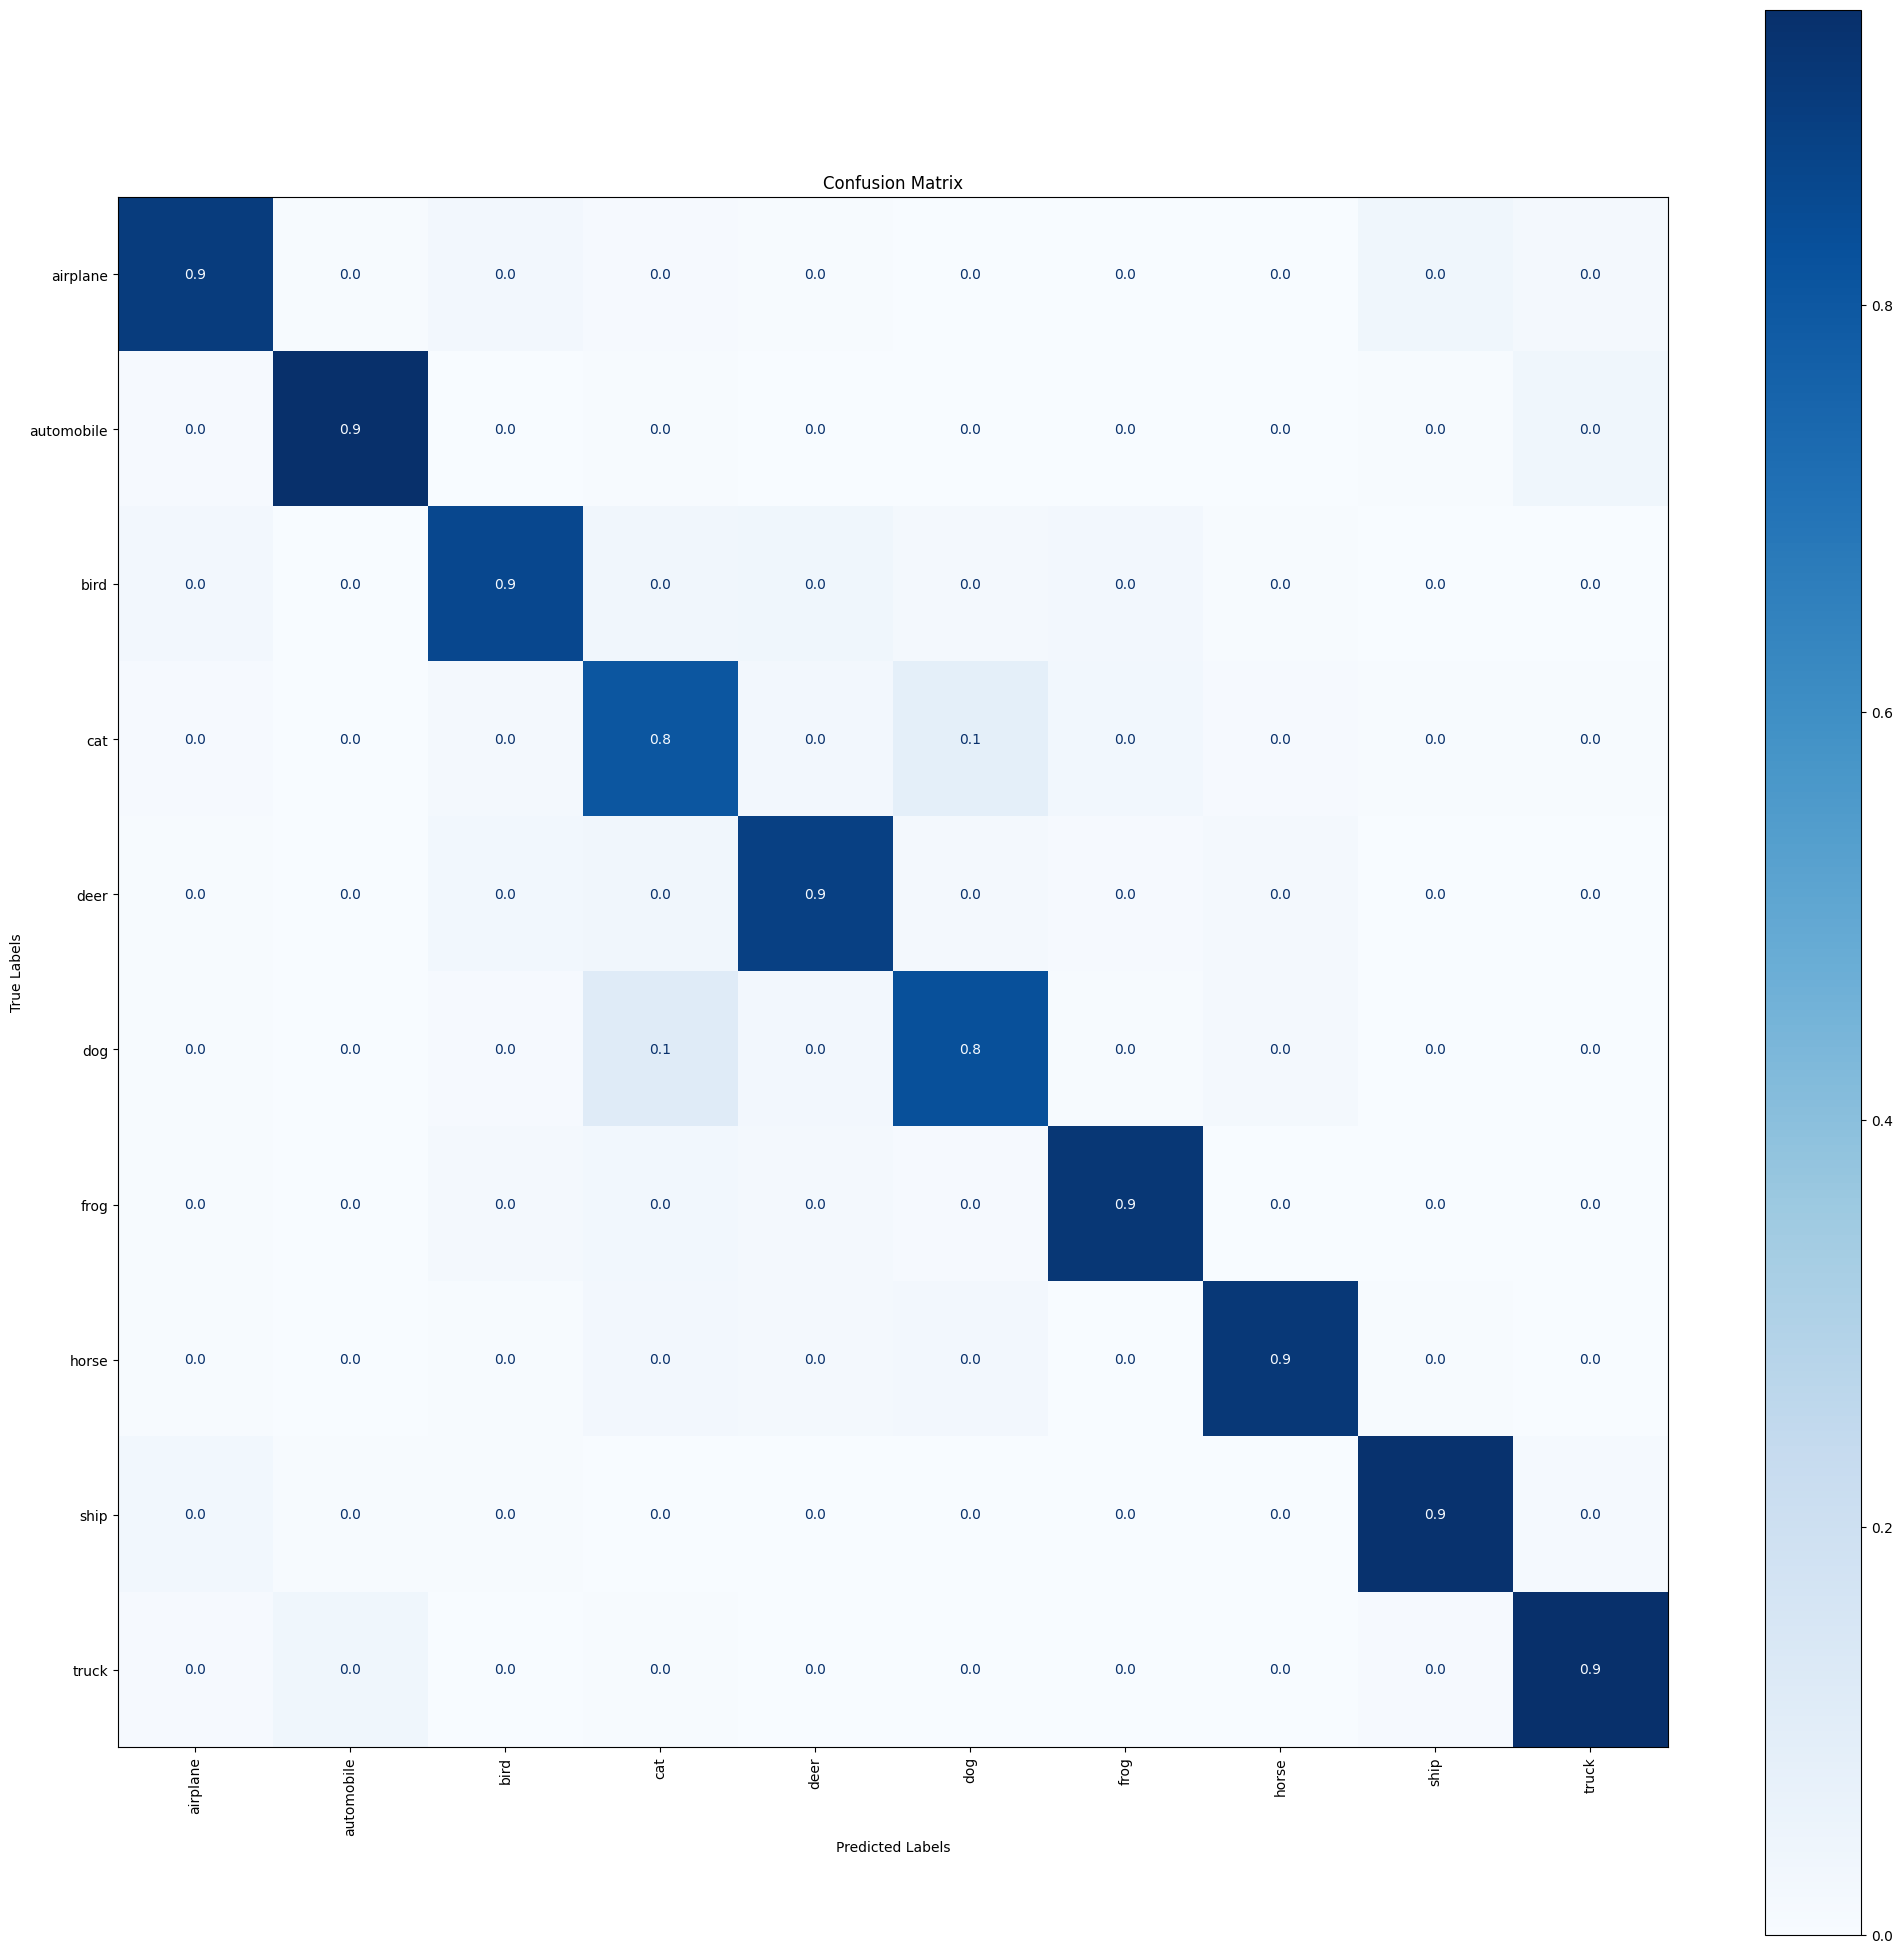

07/23 18:09:47 - mmengine - INFO - Epoch(val) [36][157/157]    accuracy/top1: 89.3300  accuracy/top5: 98.6000  loss/loss: 1.6445  data_time: 0.0092  time: 0.1135
07/23 18:10:35 - mmengine - INFO - Epoch(train) [37][100/782]  base_lr: 3.9617e-05 lr: 2.2209e-05  eta: 0:20:17  time: 0.4786  data_time: 0.1182  memory: 3611  grad_norm: 0.7560  loss: 0.5323
07/23 18:11:23 - mmengine - INFO - Epoch(train) [37][200/782]  base_lr: 3.7712e-05 lr: 2.1424e-05  eta: 0:19:38  time: 0.4797  data_time: 0.1194  memory: 3611  grad_norm: 0.8911  loss: 0.5313
07/23 18:12:11 - mmengine - INFO - Epoch(train) [37][300/782]  base_lr: 3.5869e-05 lr: 2.0664e-05  eta: 0:18:59  time: 0.4797  data_time: 0.1181  memory: 3611  grad_norm: 0.7545  loss: 0.5289
07/23 18:12:59 - mmengine - INFO - Epoch(train) [37][400/782]  base_lr: 3.4087e-05 lr: 1.9930e-05  eta: 0:18:19  time: 0.4794  data_time: 0.1193  memory: 3611  grad_norm: 0.9081  loss: 0.5392
07/23 18:13:47 - mmengine - INFO - Epoch(train) [37][500/782]  base_lr

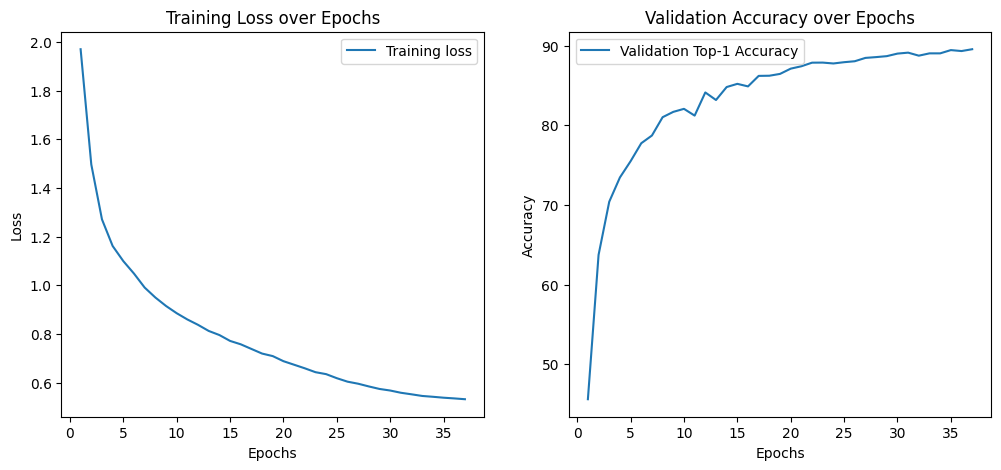

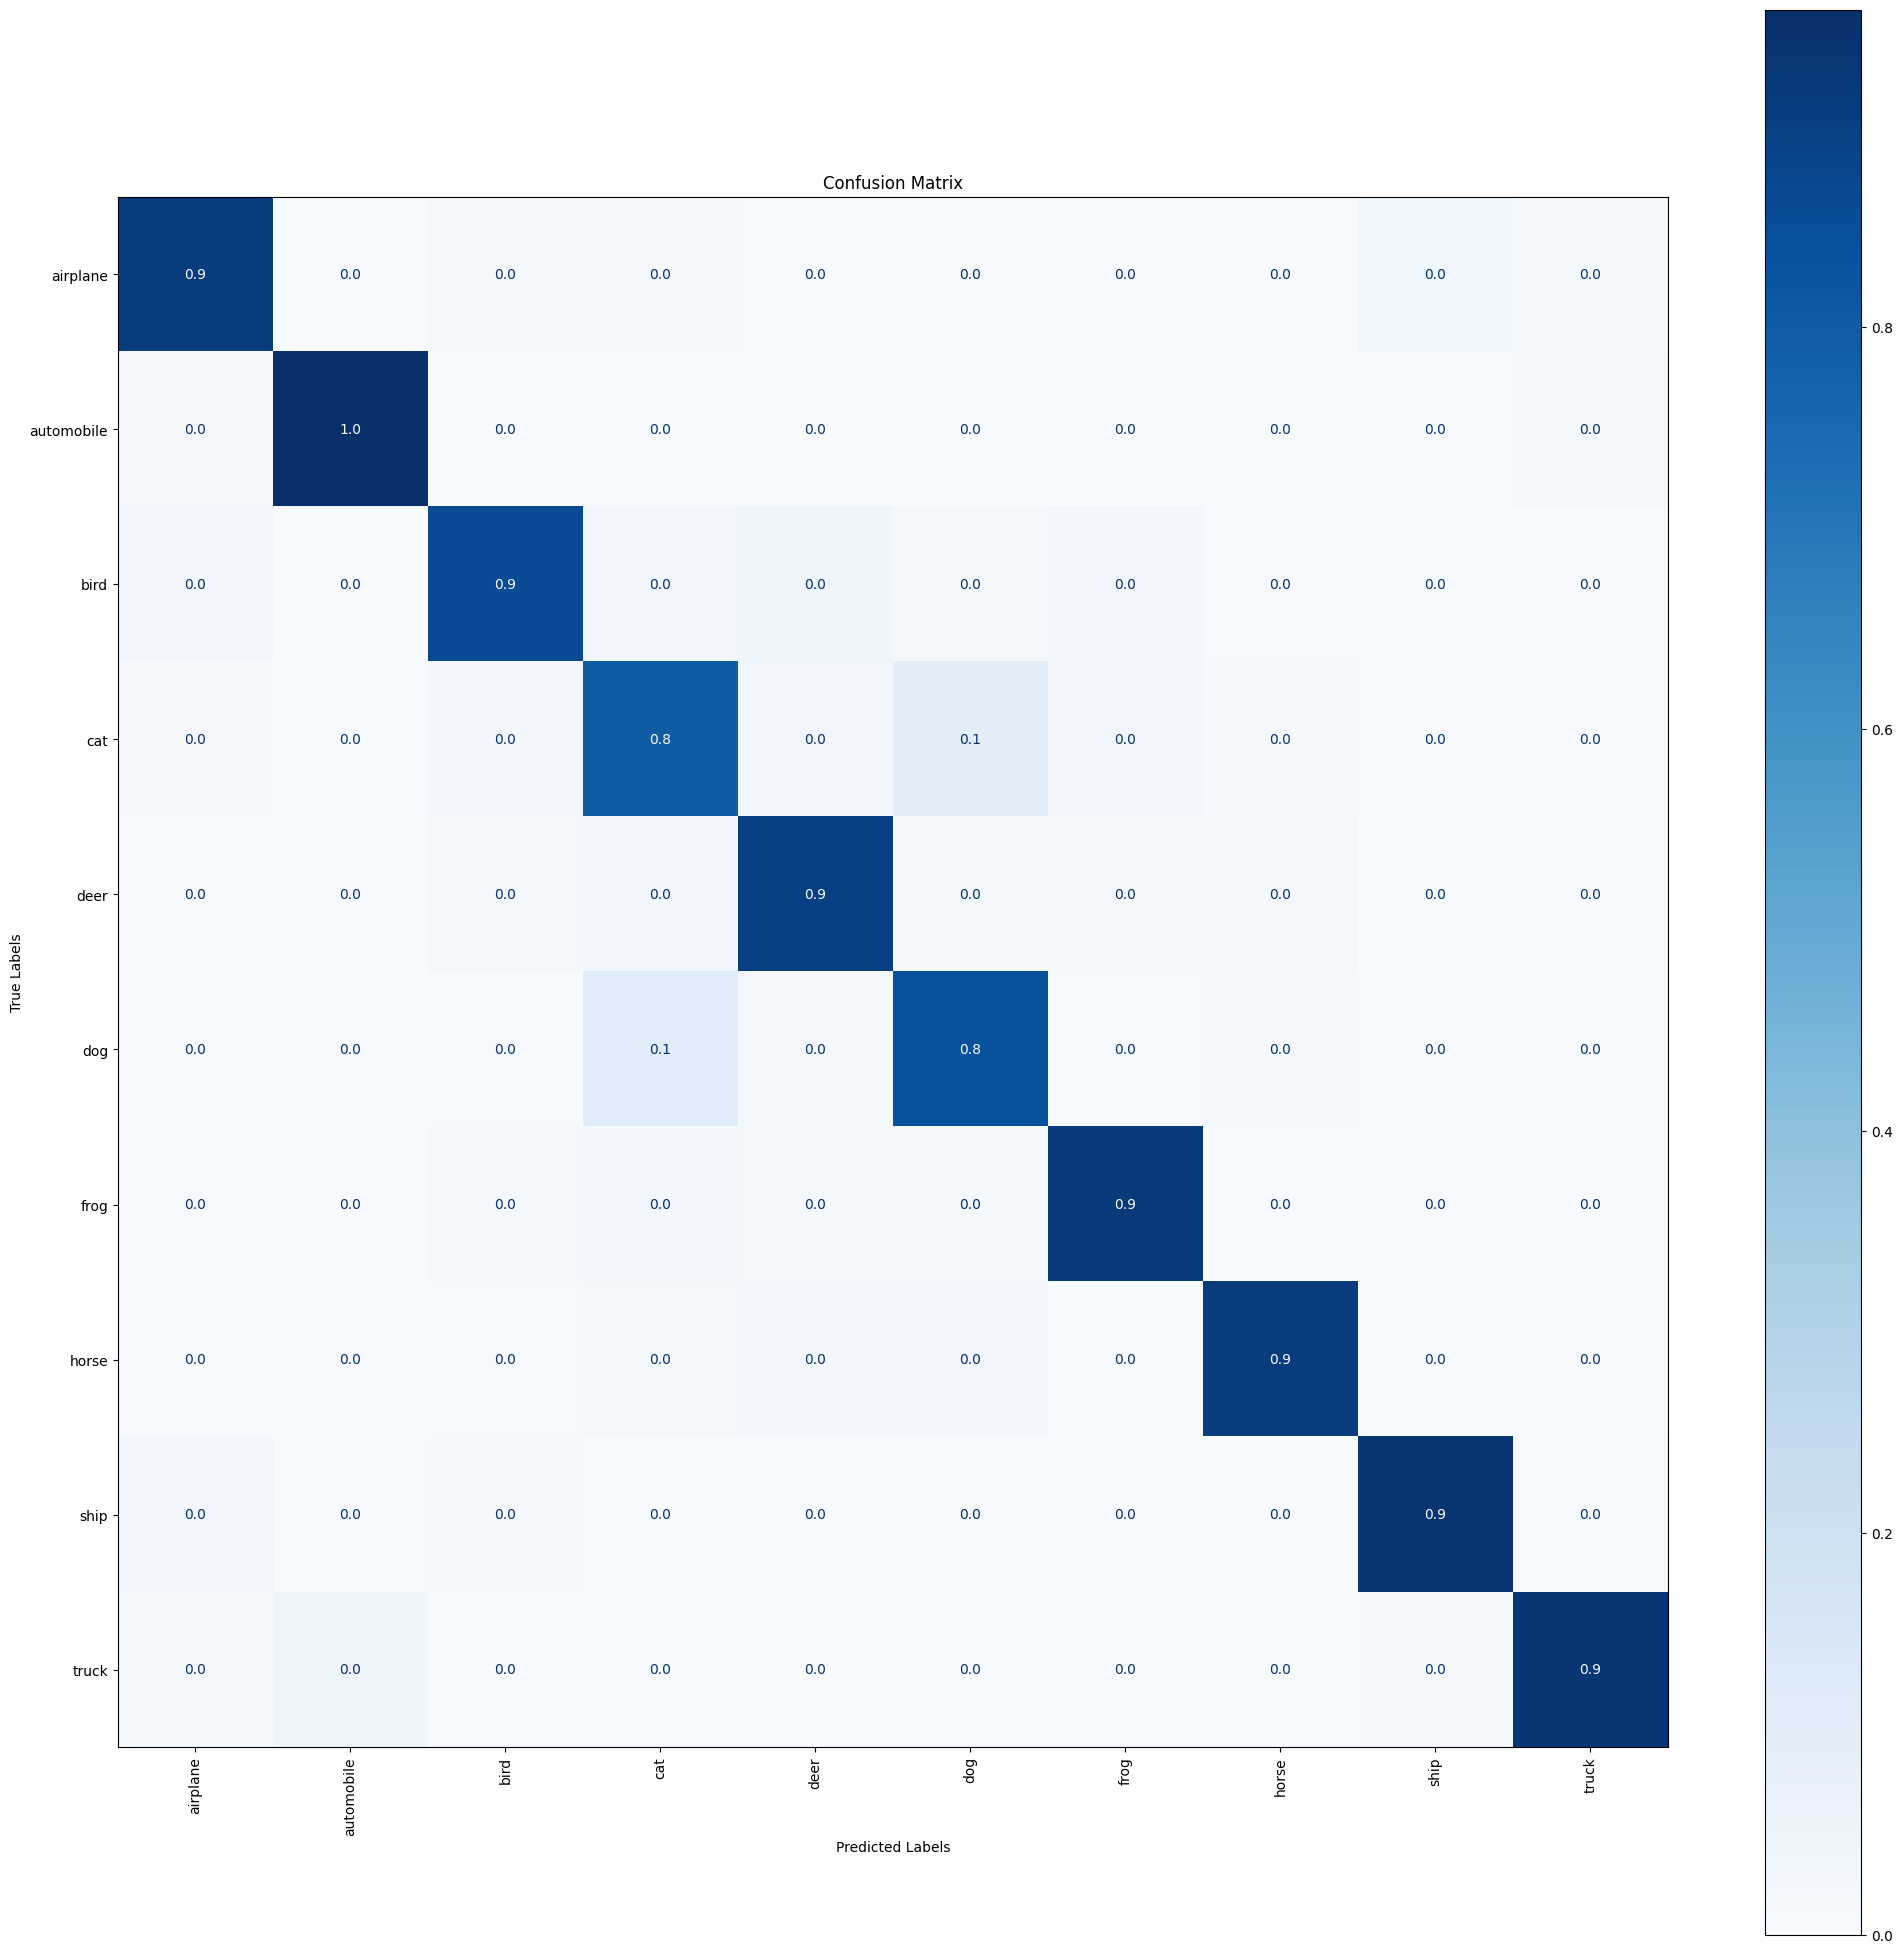

07/23 18:16:21 - mmengine - INFO - Epoch(val) [37][157/157]    accuracy/top1: 89.5600  accuracy/top5: 98.4900  loss/loss: 1.6431  data_time: 0.0105  time: 0.1152
07/23 18:16:21 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_35.pth is removed
07/23 18:16:22 - mmengine - INFO - The best checkpoint with 89.5600 accuracy/top1 at 37 epoch is saved to best_accuracy_top1_epoch_37.pth.
07/23 18:16:54 - mmengine - INFO - Exp name: 20240723_145117
07/23 18:17:10 - mmengine - INFO - Epoch(train) [38][100/782]  base_lr: 2.6373e-05 lr: 1.6750e-05  eta: 0:15:08  time: 0.4814  data_time: 0.1198  memory: 3611  grad_norm: 0.6390  loss: 0.5303
07/23 18:17:58 - mmengine - INFO - Epoch(train) [38][200/782]  base_lr: 2.4955e-05 lr: 1.6165e-05  eta: 0:14:28  time: 0.4821  data_time: 0.1184  memory: 3611  grad_norm: 0.5597  loss: 0.5174
07/23 18:18:46 - mmengine - INFO - Epoch(train) [38][300

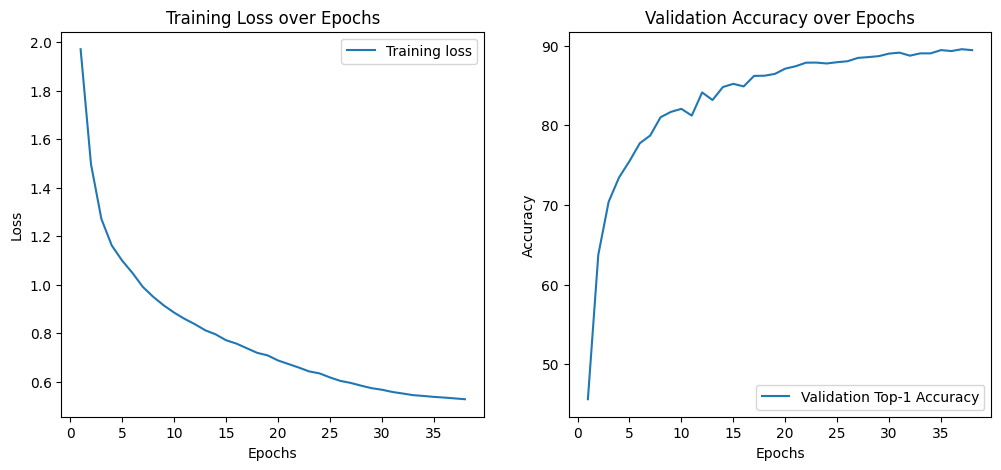

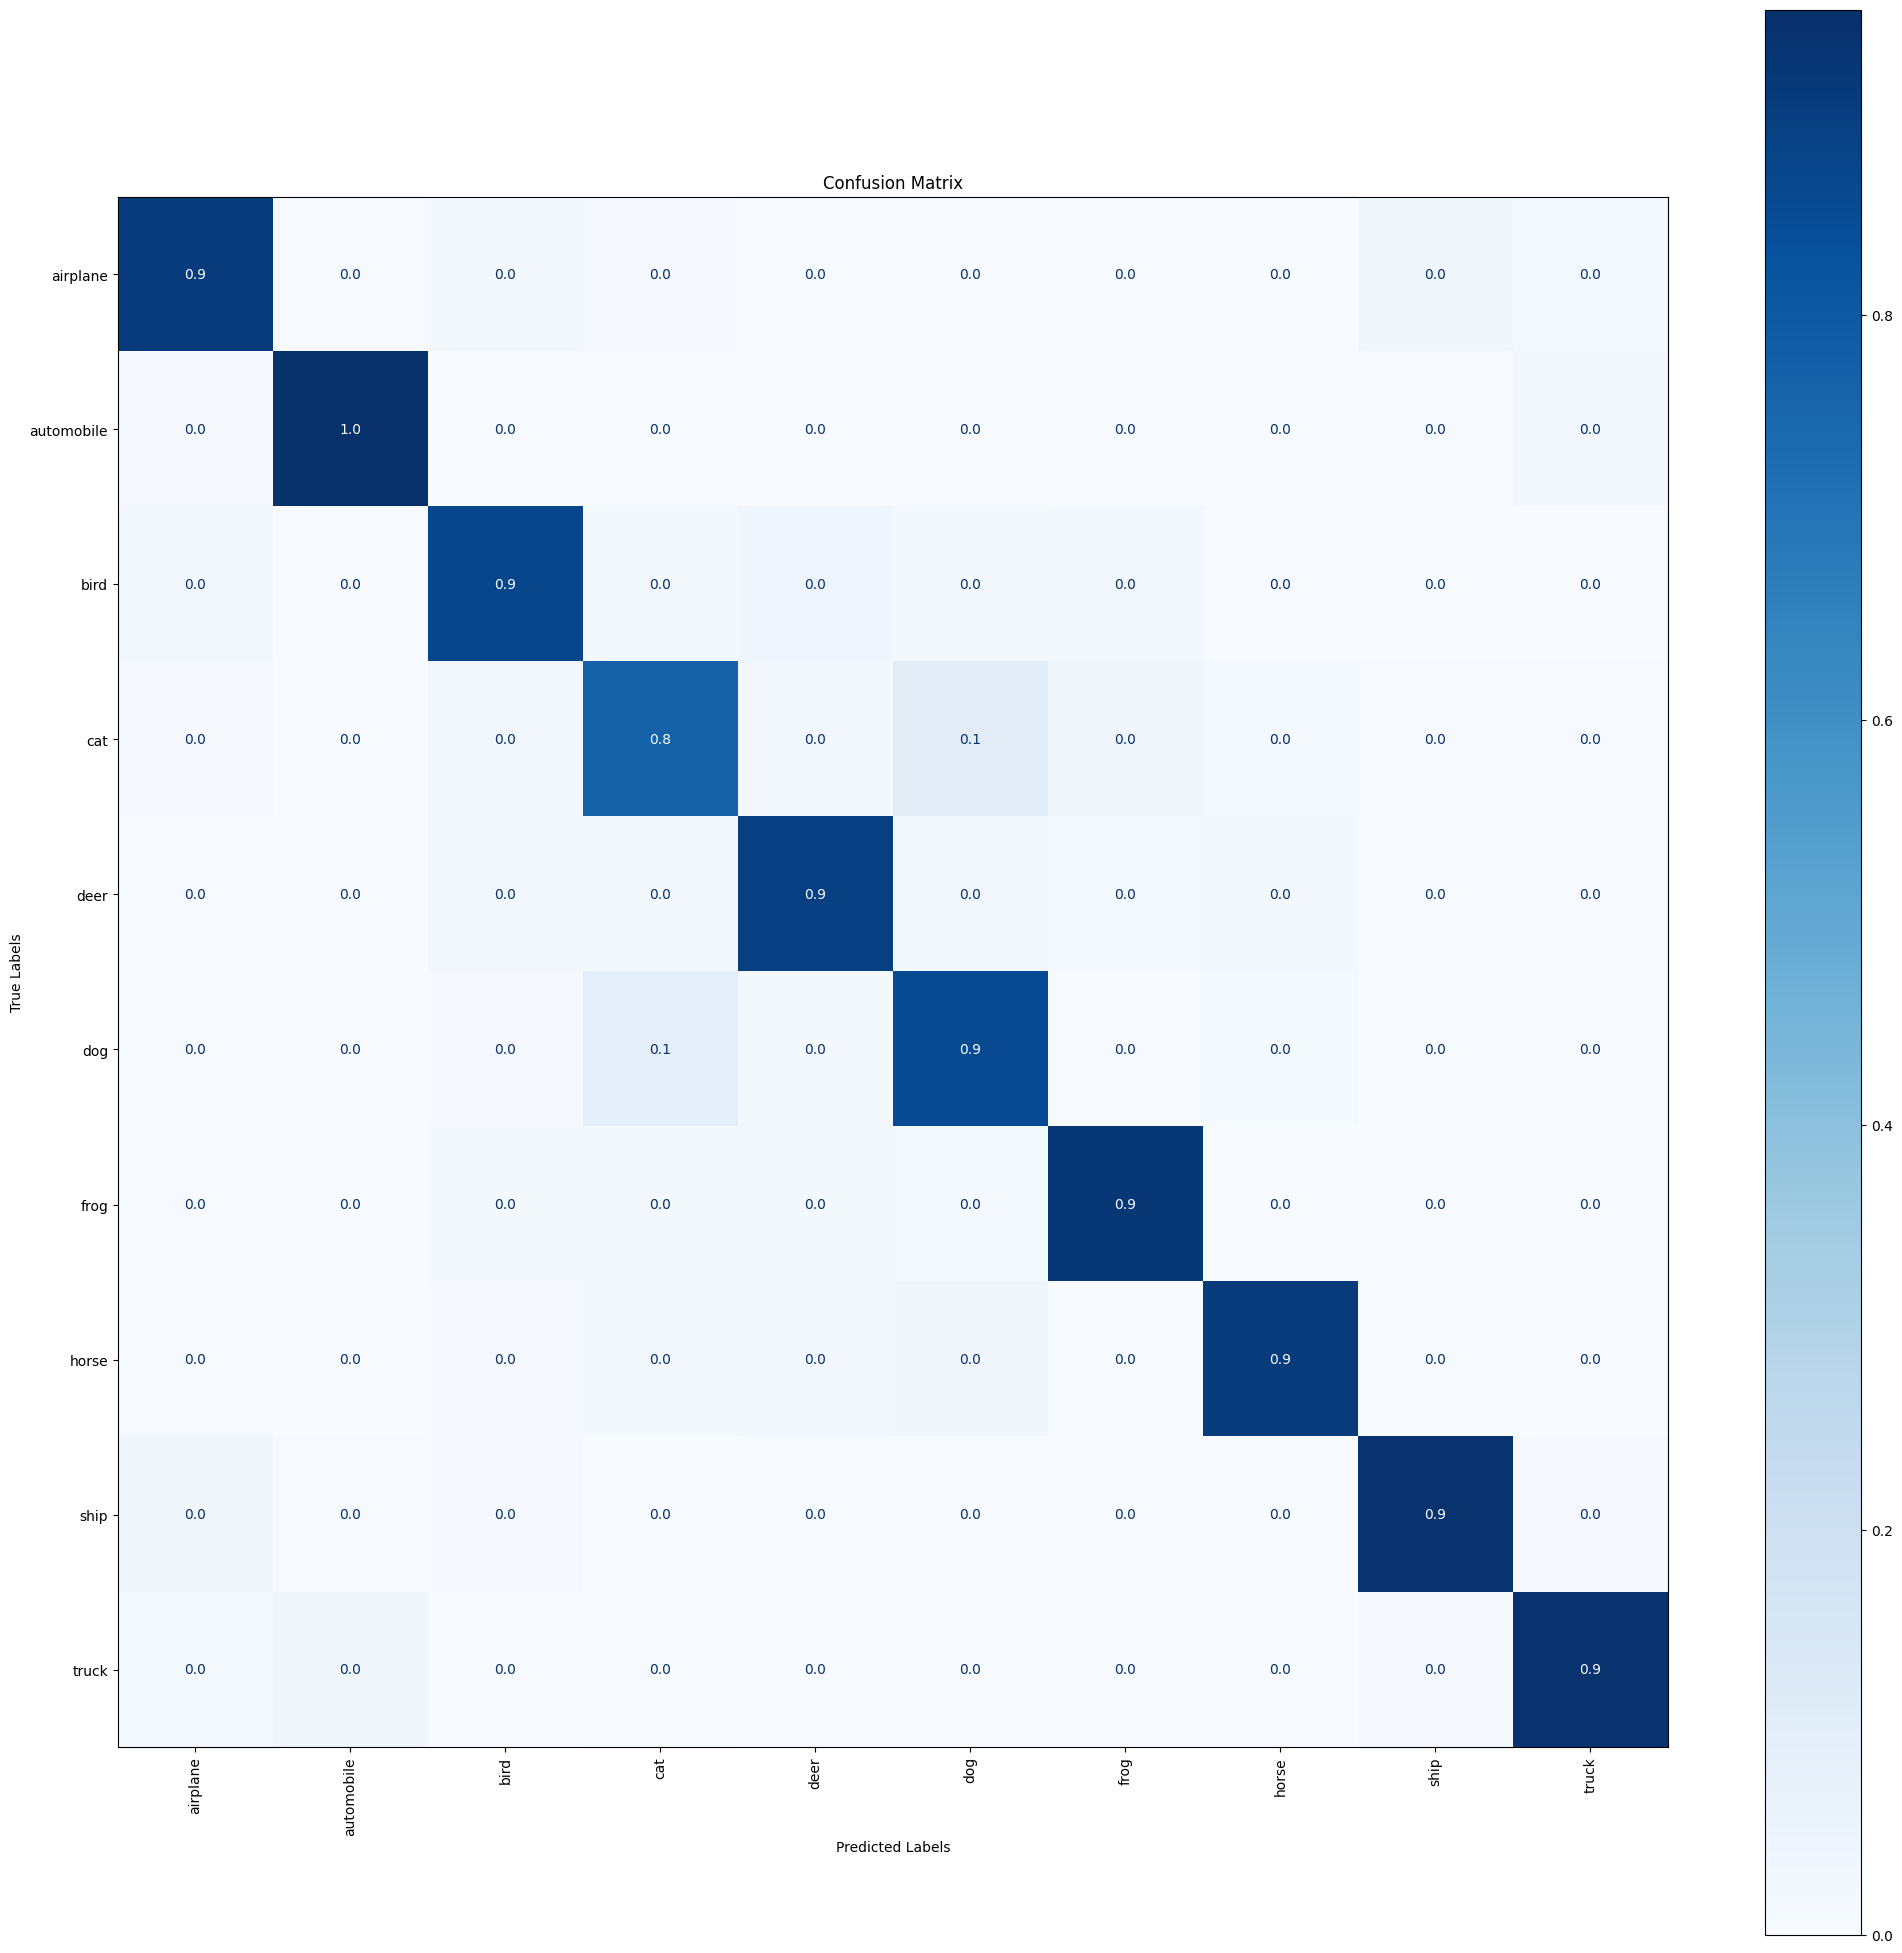

07/23 18:22:58 - mmengine - INFO - Epoch(val) [38][157/157]    accuracy/top1: 89.4400  accuracy/top5: 98.3800  loss/loss: 1.6422  data_time: 0.0106  time: 0.1150
07/23 18:23:46 - mmengine - INFO - Epoch(train) [39][100/782]  base_lr: 1.6982e-05 lr: 1.2878e-05  eta: 0:09:54  time: 0.4816  data_time: 0.1181  memory: 3611  grad_norm: 1.0186  loss: 0.5384
07/23 18:24:34 - mmengine - INFO - Epoch(train) [39][200/782]  base_lr: 1.6063e-05 lr: 1.2500e-05  eta: 0:09:14  time: 0.4822  data_time: 0.1197  memory: 3611  grad_norm: 0.8208  loss: 0.5336
07/23 18:25:15 - mmengine - INFO - Exp name: 20240723_145117
07/23 18:25:22 - mmengine - INFO - Epoch(train) [39][300/782]  base_lr: 1.5209e-05 lr: 1.2147e-05  eta: 0:08:34  time: 0.4826  data_time: 0.1182  memory: 3611  grad_norm: 0.6603  loss: 0.5281
07/23 18:26:10 - mmengine - INFO - Epoch(train) [39][400/782]  base_lr: 1.4419e-05 lr: 1.1822e-05  eta: 0:07:53  time: 0.4837  data_time: 0.1191  memory: 3611  grad_norm: 0.6846  loss: 0.5250
07/23 18:

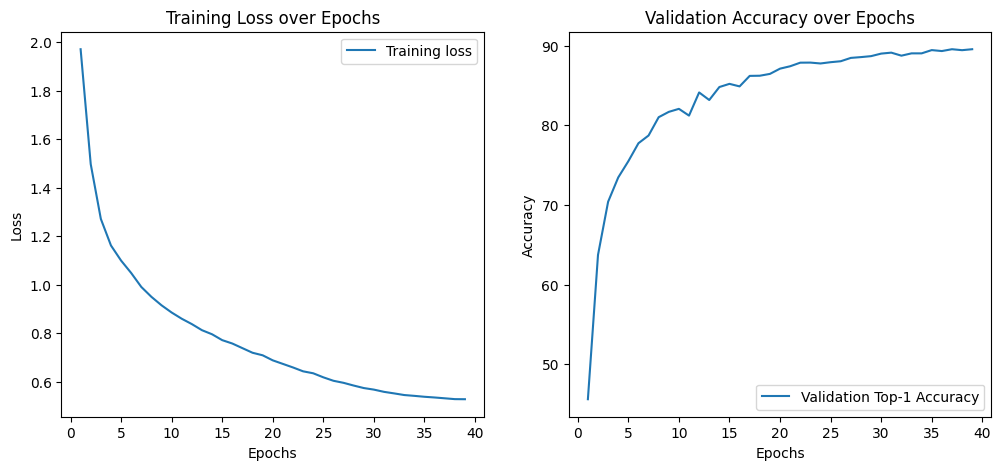

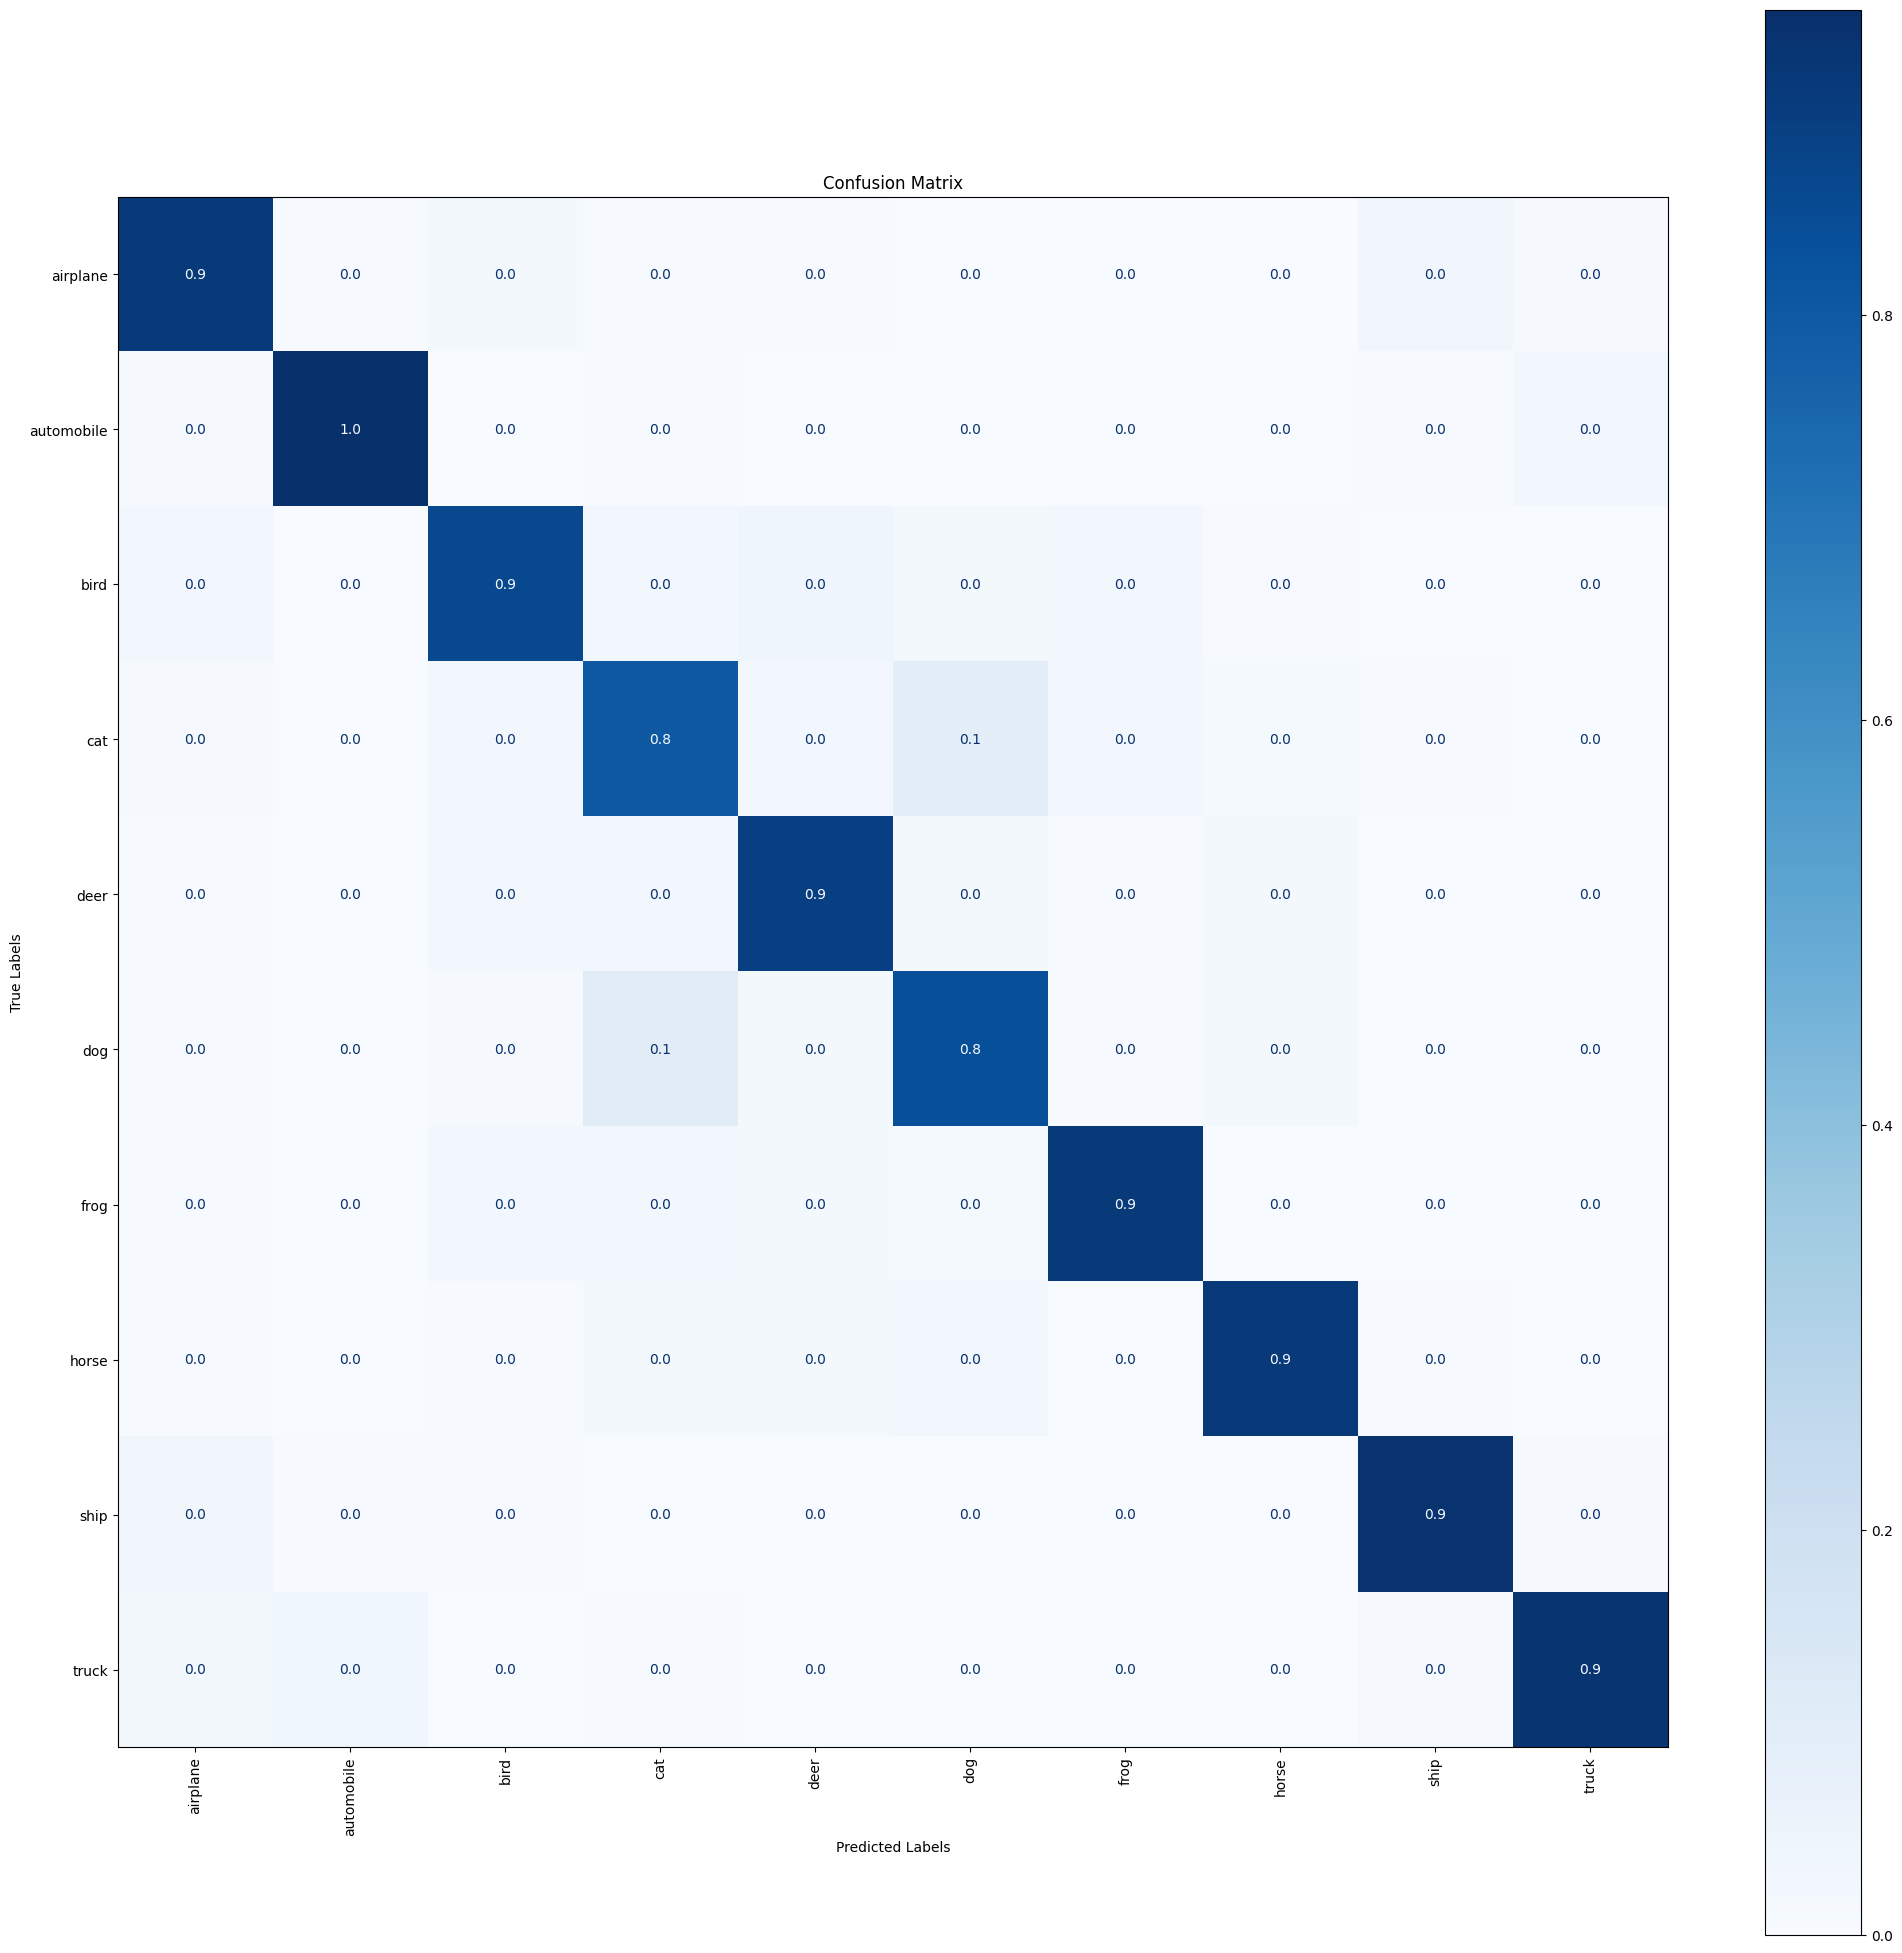

07/23 18:29:33 - mmengine - INFO - Epoch(val) [39][157/157]    accuracy/top1: 89.5600  accuracy/top5: 98.4200  loss/loss: 1.6413  data_time: 0.0099  time: 0.1148
07/23 18:30:22 - mmengine - INFO - Epoch(train) [40][100/782]  base_lr: 1.1520e-05 lr: 1.0627e-05  eta: 0:04:38  time: 0.4813  data_time: 0.1197  memory: 3611  grad_norm: 0.7306  loss: 0.5210
07/23 18:31:10 - mmengine - INFO - Epoch(train) [40][200/782]  base_lr: 1.1108e-05 lr: 1.0457e-05  eta: 0:03:57  time: 0.4808  data_time: 0.1189  memory: 3611  grad_norm: 0.6481  loss: 0.5199
07/23 18:31:58 - mmengine - INFO - Epoch(train) [40][300/782]  base_lr: 1.0761e-05 lr: 1.0314e-05  eta: 0:03:17  time: 0.4812  data_time: 0.1185  memory: 3611  grad_norm: 0.6489  loss: 0.5271
07/23 18:32:46 - mmengine - INFO - Epoch(train) [40][400/782]  base_lr: 1.0478e-05 lr: 1.0197e-05  eta: 0:02:36  time: 0.4810  data_time: 0.1192  memory: 3611  grad_norm: 0.6602  loss: 0.5269
07/23 18:33:34 - mmengine - INFO - Epoch(train) [40][500/782]  base_lr

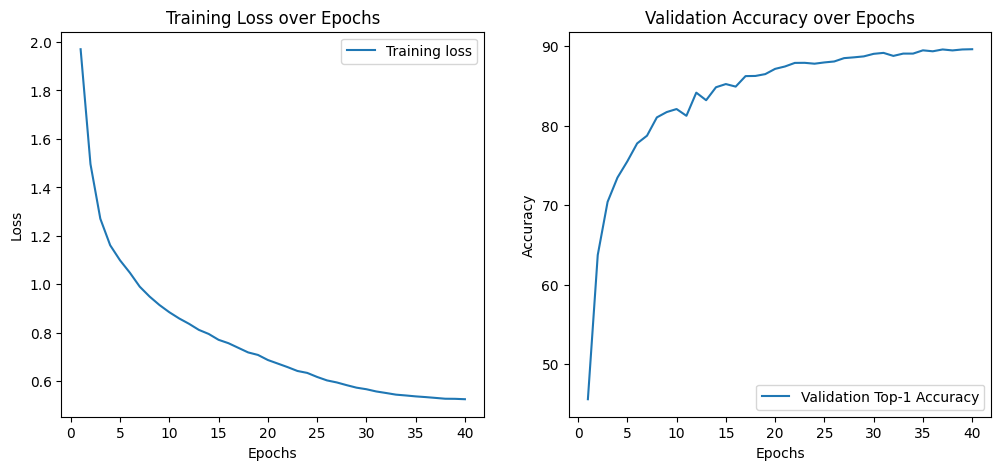

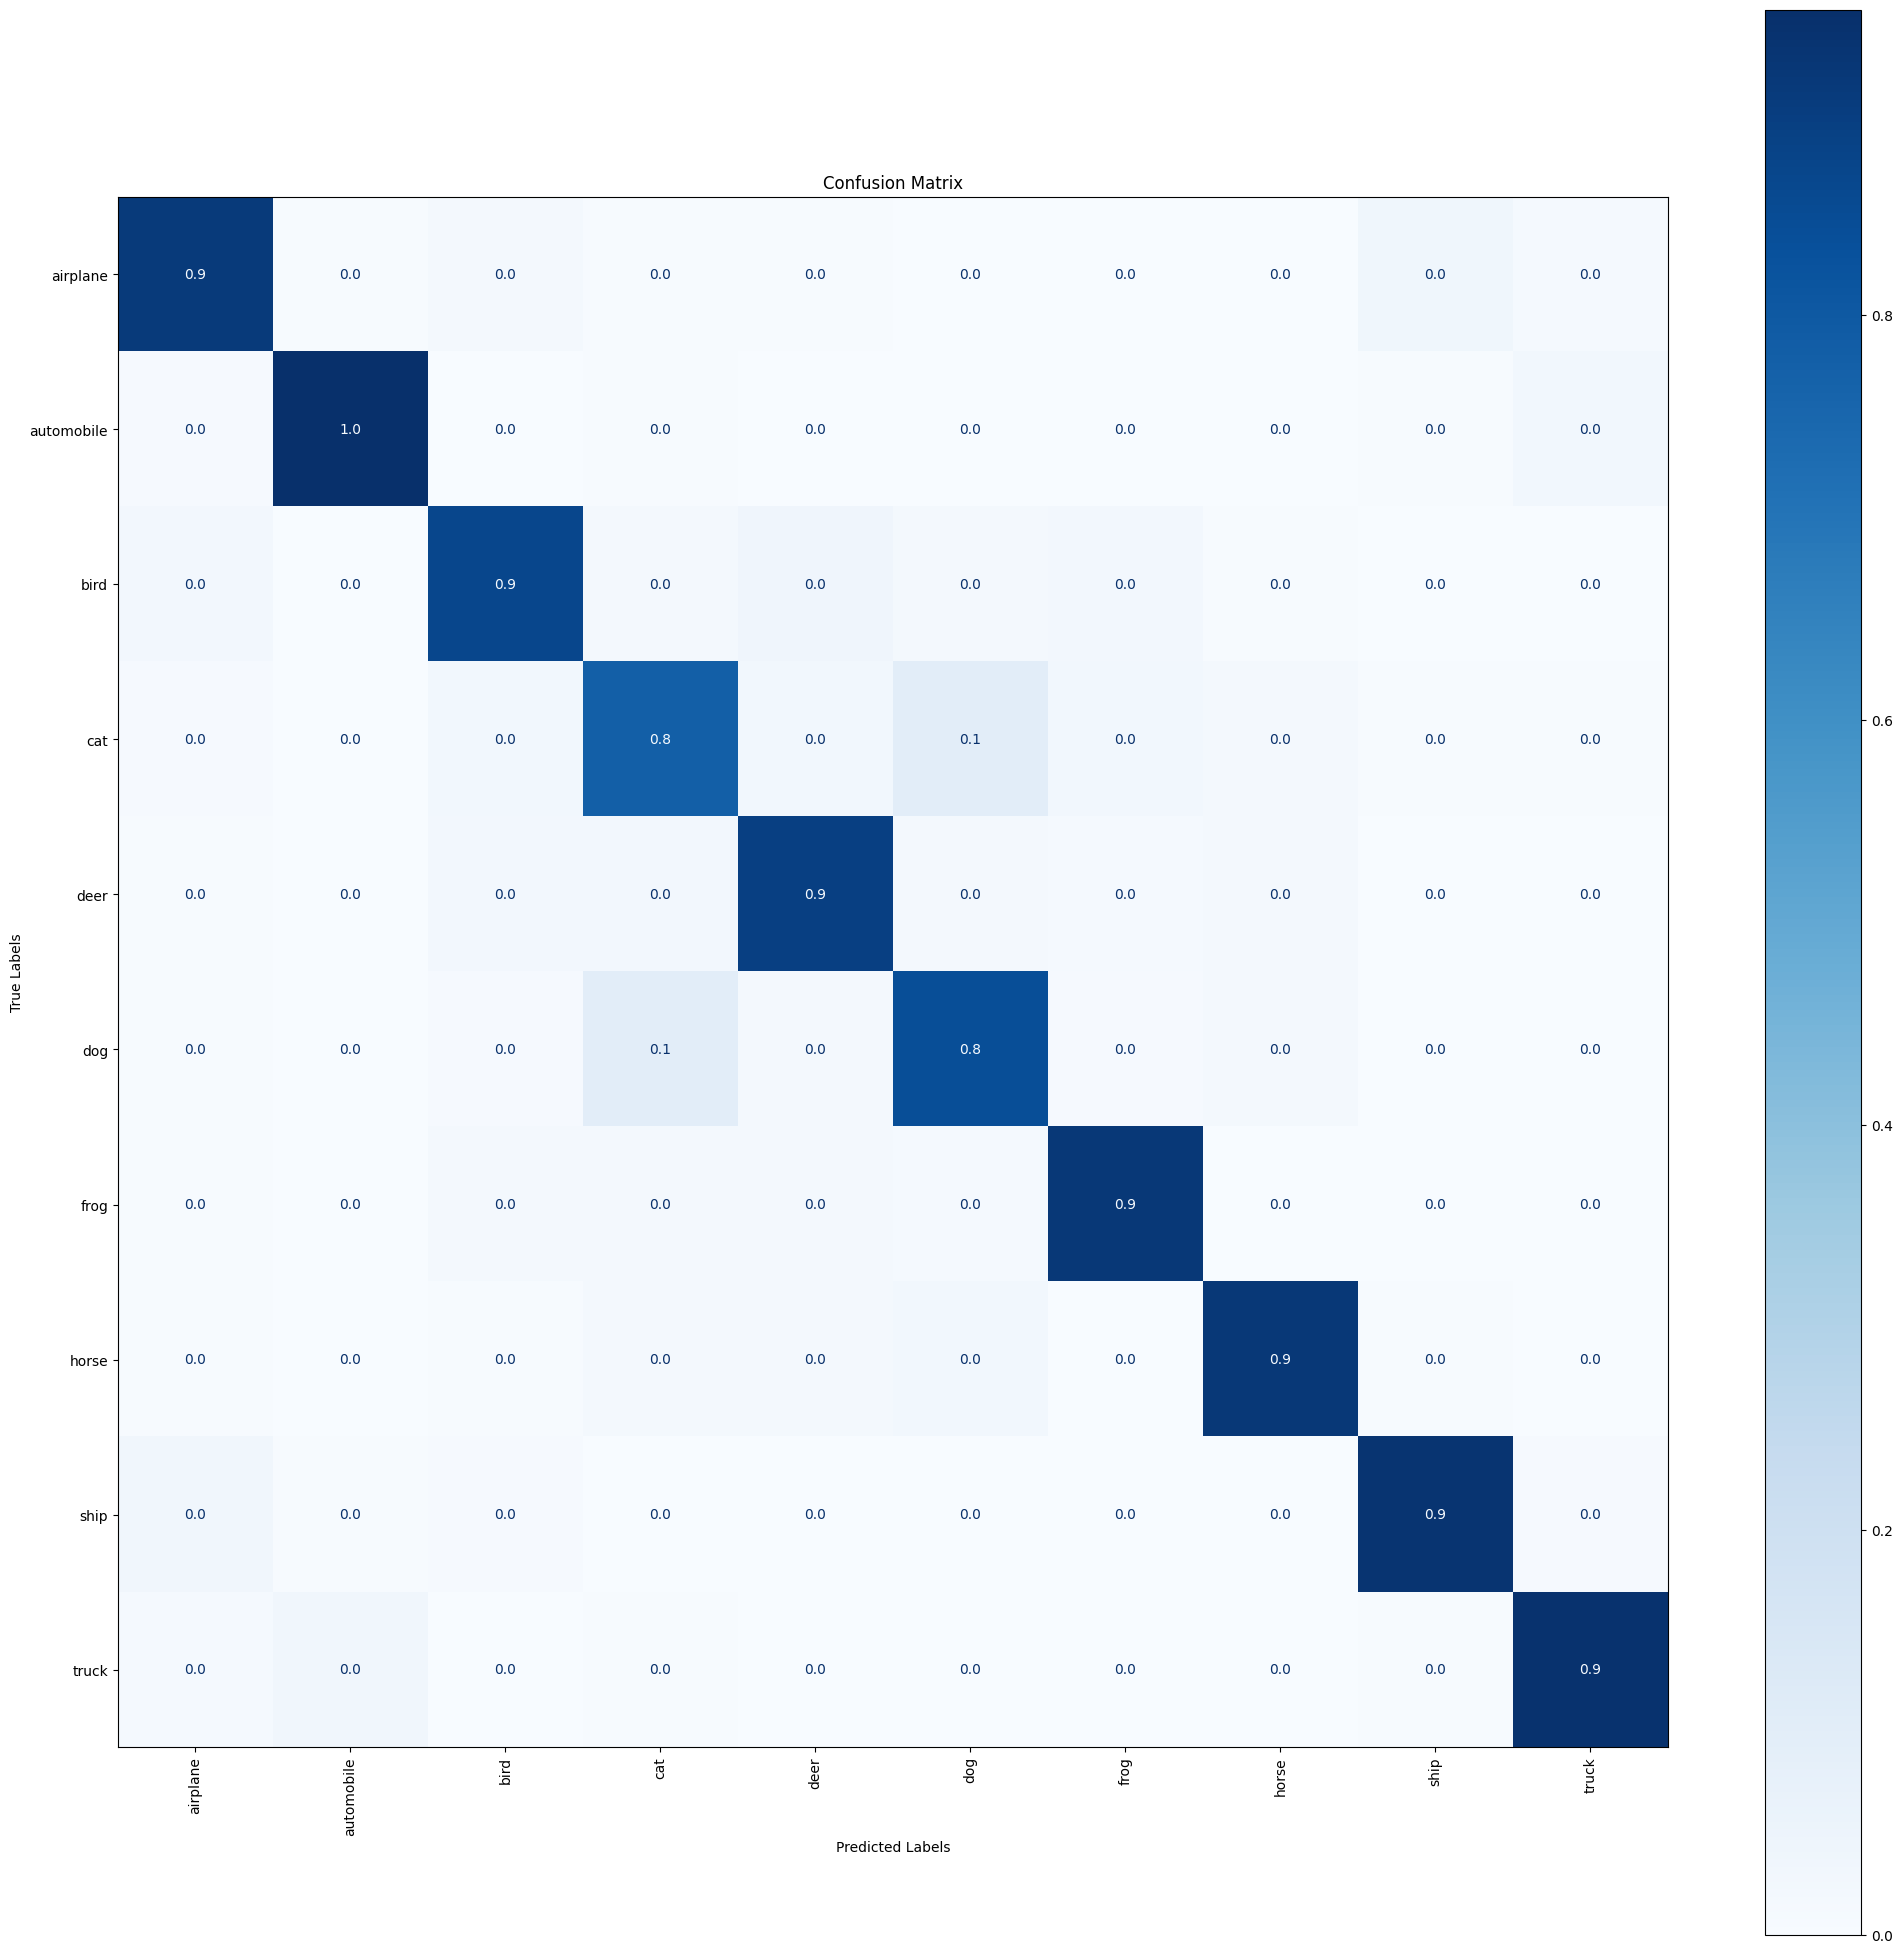

07/23 18:36:09 - mmengine - INFO - Epoch(val) [40][157/157]    accuracy/top1: 89.5900  accuracy/top5: 98.4100  loss/loss: 1.6403  data_time: 0.0095  time: 0.1141
07/23 18:36:09 - mmengine - INFO - The previous best checkpoint /home/simon/Documents/MambaND/MambaNDoff/image_classification/work_dirs/cifar10_experiment/best_accuracy_top1_epoch_37.pth is removed
07/23 18:36:09 - mmengine - INFO - The best checkpoint with 89.5900 accuracy/top1 at 40 epoch is saved to best_accuracy_top1_epoch_40.pth.


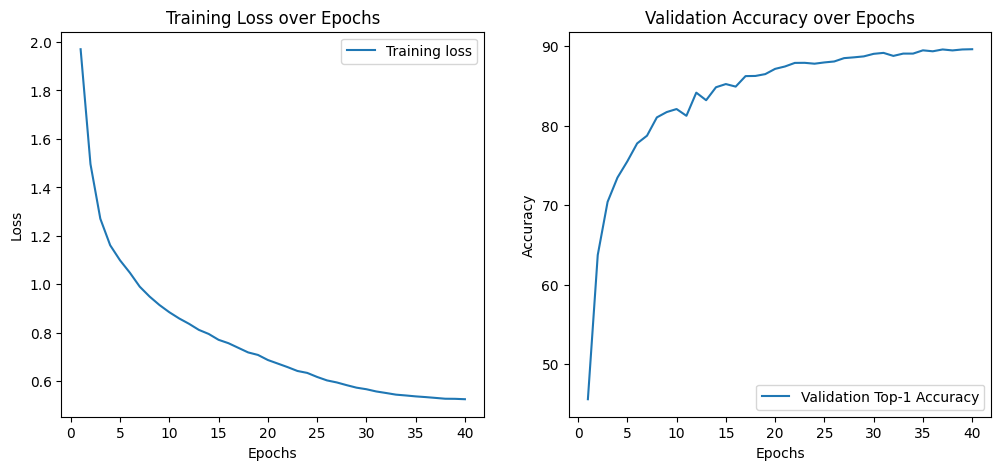

In [8]:
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch
from mmengine.config import Config, ConfigDict
from mmengine.registry import RUNNERS
from mmengine.runner import Runner
import logging


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)



class DataSample:
  def __init__(self, gt_label):
   self.gt_label = torch.tensor([gt_label]).to('cuda')

  def set_pred_score(self, score):
   self.pred_score = score
   return self

  def set_pred_label(self, label):
   self.pred_label = label
   return self

  @property
  def gt_score(self):
   # Cette méthode peut être modifiée selon vos besoins spécifiques
   return None

  def __contains__(self, key):
   return key in self.__dict__

  def __getitem__(self, key):
   return self.__dict__[key]



class CustomDataset(Dataset):
  def __init__(self, dataset):
   self.dataset = dataset

  def __len__(self):
   return len(self.dataset)

  def __getitem__(self, idx):
   data = self.dataset[idx]
   return {'inputs': data[0], 'labels': data[1]}



# Fonction custom_collate_fn
def custom_collate_fn(batch):
  inputs = torch.stack([item['inputs'] for item in batch]).to('cuda')
  labels = torch.tensor([item['labels'] for item in batch]).to('cuda')
  data_samples = [DataSample(label.item()) for label in labels]
  return {'inputs': inputs, 'data_samples': data_samples}



# Define the configuration dictionary directly in the notebook
cfg = ConfigDict(
  default_scope='mmpretrain',
  env_cfg=dict(
   cudnn_benchmark=False,
   mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
   dist_cfg=dict(backend='nccl'),
  ),
  vis_backends=[dict(type='LocalVisBackend')],
  visualizer=dict(type='UniversalVisualizer', vis_backends=[
               dict(type='LocalVisBackend')]),
  log_level='INFO',
  load_from=None, 
  resume=False,
  randomness=dict(seed=77, diff_rank_seed=True),
  train_cfg=dict(by_epoch=True, max_epochs=40),
  val_cfg=dict(),
  test_cfg=dict(),
  auto_scale_lr=dict(base_batch_size=32),
  model=dict(
   type='ImageClassifier',
   backbone=dict(
       type='Mamba2DModel',
       arch='small',
       img_size=32,
       patch_size=2,
       out_type='avg_featmap',
       drop_path_rate=0.1,
       drop_rate=0.1,
       with_cls_token=False,
       final_norm=True,
       fused_add_norm=False,
       d_state=16,
       is_2d=False,
       use_v2=False,
       constant_dim=True,
       downsample=(9,),
       force_a2=False,
       use_mlp=False,
   ),
   neck=None,
   head=dict(
       type='LinearClsHead',
       num_classes=10,
       in_channels=256,
       loss=dict(
           type='LabelSmoothLoss', label_smooth_val=0.1, mode='original'),
       init_cfg=[dict(type='TruncNormal', layer='Linear', std=2e-5)]),
   train_cfg=dict(augments=[
       dict(type='Mixup', alpha=0.8),
       dict(type='CutMix', alpha=1.0)
   ])),
  optim_wrapper=dict(
   optimizer=dict(
       type='AdamW', lr=1e-3, weight_decay=0.1, betas=(0.9, 0.999)),#
   constructor='LearningRateDecayOptimWrapperConstructor',
   clip_grad=dict(max_norm=2.0),
   paramwise_cfg=dict(
       norm_decay_mult=0.1,
       layer_decay_rate=0.95,
       custom_keys={
           '.ln': dict(decay_mult=0.0),
           '.bias': dict(decay_mult=0.0),
           '.cls_token': dict(decay_mult=0.0),
           '.pos_embed': dict(decay_mult=0.0),
           '.A_log': dict(decay_mult=0.1),
           '.A2_log': dict(decay_mult=0.1),
           '.absolute_pos_embed': dict(decay_mult=0.0),
       })),
  param_scheduler=[
   dict(
     type='LinearLR',
     start_factor=1e-4,
     by_epoch=True,
     begin=0,
     end=5,
     convert_to_iter_based=True),
   dict(
     type='CosineAnnealingLR',
     by_epoch=True,
     begin=5,
     eta_min=1e-5,
     convert_to_iter_based=True)
  ],
  default_hooks=dict(
   timer=dict(type='IterTimerHook'),
   logger=dict(type='LoggerHook', interval=100),
   param_scheduler=dict(type='ParamSchedulerHook'),
   checkpoint=dict(type='CheckpointHook', interval=1, max_keep_ckpts=3, save_best='auto'),
   sampler_seed=dict(type='DistSamplerSeedHook'),
   visualization=dict(type='VisualizationHook', enable=True),
  ),
  data_preprocessor=dict(
   num_classes=10,
   mean=[0.5, 0.5, 0.5],
   std=[0.5, 0.5, 0.5],
   to_rgb=True,
  )
)



data_root = './data'


# Téléchargement et préparation des datasets CIFAR-10
if not os.path.exists(data_root):
  os.makedirs(data_root)




transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(0.5),
  transforms.RandomVerticalFlip(0.3),
  transforms.ToTensor(),

])


transform_test = transforms.Compose([
  transforms.ToTensor(),
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


# DataLoader pour l'entraînement
train_dataloader = DataLoader(
  CustomDataset(train_dataset),
  batch_size=64,
  shuffle=True,
  num_workers=0,
  #pin_memory=True,
  collate_fn=custom_collate_fn
)



# DataLoader pour la validation
val_dataloader = DataLoader(
  CustomDataset(test_dataset),
  batch_size=64,
  shuffle=False,
  num_workers=0,
  #pin_memory=True,
  collate_fn=custom_collate_fn
)


# Évaluateur
cfg.val_evaluator = [dict(type='Accuracy', topk=(1, 5)), dict(type='LossValMetric')]
cfg.test_evaluator = cfg.val_evaluator



# Affichage des configurations
print("Train dataloader:", train_dataloader)
print("Validation dataloader:", val_dataloader)
print("Validation evaluator:", cfg.val_evaluator)


# ####################   DEBOGAGE VISUALISATION DONNEE   ###############################

# def visualize_samples(dataset):
#     for i in range(0,5):
#         img, label = dataset[i]
#         plt.imshow(img.permute(1, 2, 0))  # Change the format for displaying
#         plt.title(f'Label: {label}')
#         plt.show()


# # Visualiser quelques échantillons du dataset
# print("Visualisation des échantillons de l'ensemble d'entraînement :")
# visualize_samples(train_dataset)

# print("Visualisation des échantillons de l'ensemble de validation :")
# visualize_samples(test_dataset)
# ####################################################################################


# Simuler les arguments d'entrée
class Args:
  work_dir = None
  resume = None
  amp = False
  no_validate = False
  auto_scale_lr = False
  no_pin_memory = False
  no_persistent_workers = False
  cfg_options = None
  launcher = 'none'
  local_rank = 0



args = Args()



def merge_args(cfg, args):
  """Merge CLI arguments to config."""
  if args.no_validate:
   cfg.val_cfg = None
   cfg.val_dataloader = None
   cfg.val_evaluator = None


  cfg.launcher = args.launcher

  # work_dir is determined in this priority: CLI > segment in file > filename
  if args.work_dir is not None:
   cfg.work_dir = args.work_dir
  elif cfg.get('work_dir', None) is None:
   cfg.work_dir = os.path.join('./work_dirs', 'cifar10_experiment')


  # enable automatic-mixed-precision training
  if args.amp:
   cfg.optim_wrapper.type = 'AmpOptimWrapper'
   cfg.optim_wrapper.setdefault('loss_scale', 'dynamic')


  # resume training
  if args.resume == 'auto':
   cfg.resume = True
   cfg.load_from = None
  elif args.resume is not None:
   cfg.resume = True
   cfg.load_from = args.resume




  # enable auto scale learning rate
  if args.auto_scale_lr:
   cfg.auto_scale_lr.enable = True



  if args.cfg_options is not None:
   cfg.merge_from_dict(args.cfg_options)

  return cfg




# Merging args with the configuration
cfg = merge_args(cfg, args)


# Initialisation du hook personnalisé
metric_logger_hook = MetricLoggerHook()


# Initialize runner and start training
runner = Runner(
  model=cfg.model,
  work_dir=cfg.work_dir,
  train_dataloader=train_dataloader,
  val_dataloader=val_dataloader,
  test_dataloader=val_dataloader,  # Assuming test and val dataloaders are the same
  train_cfg=cfg.train_cfg,
  val_cfg=cfg.val_cfg,
  test_cfg=cfg.test_cfg,
  auto_scale_lr=cfg.auto_scale_lr,
  optim_wrapper=cfg.optim_wrapper,
  param_scheduler=cfg.param_scheduler,
  val_evaluator=cfg.val_evaluator,
  test_evaluator=cfg.test_evaluator,
  default_hooks=cfg.default_hooks,
  custom_hooks=[metric_logger_hook],
  data_preprocessor=cfg.data_preprocessor,
  load_from=cfg.load_from,
  resume=cfg.resume,
  launcher=cfg.launcher,
  env_cfg=cfg.env_cfg,
  log_level=cfg.log_level,
  visualizer=cfg.visualizer,
  default_scope=cfg.default_scope,
  randomness=cfg.randomness,
  cfg=cfg
)



# Déplacer le modèle et les autres composants sur l'appareil approprié
runner.model.to('cuda')


# Start training
logger.info("Starting training...")
# Sample batch display for debugging
sample_batch = next(iter(train_dataloader))
print("Sample batch inputs shape:", sample_batch['inputs'].shape)
print("Sample batch labels shape:", sample_batch['data_samples'][0].gt_label.shape)


runner.train()


# Après l'entraînement, tracer les courbes
metric_logger_hook.plot_metrics()
